In [2]:
import sys

In [6]:
!{sys.executable} -m pip install cvxpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install polytope

  Using cached polytope-0.2.3.tar.gz (51 kB)
  Created wheel for polytope: filename=polytope-0.2.3-py3-none-any.whl size=46037 sha256=0e3ebf3cbcca7eaeb8a9d659ed0e5e5c73c248ddbbead716f81b3f8ff4329edd
  Stored in directory: /home/gary/.cache/pip/wheels/dc/0b/33/e063a044f930977e4897732d007122648d9db0e50934094040
Successfully built polytope


In [3]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import sympy
import math

In [32]:
# latest version
# define states
x,y,p = sympy.symbols('x y p')
K = 50
V = 1.0
p_d1 = -45*np.pi/180
p_d2 = -20*np.pi/180
p_d3 = 0
p_d4 = 20*np.pi/180
p_d5 = 45*np.pi/180

angle = 0

# taylor approximation around 0 (should be changed later)
#f = sympy.Matrix([[-V*p +(V*p**3)/6],[V - (V*p**2)/2],[-K*(p - p_d4)]])
f = sympy.Matrix([[-(V*math.cos(angle)*p - (V*math.cos(angle))/6*p**3)],[V*math.cos(angle) - (V*math.cos(angle)/2)*p**2],[-K*(p - p_d3)]])
#print(f_1)
#print(f_2)
# polynomial basis
b1 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b1 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b1 = sympy.Matrix([[1,x,y,p]]).transpose()


Q = sympy.MatrixSymbol('Q',10,10)
#Q = sympy.MatrixSymbol('Q',4,4)
#Q = sympy.MatrixSymbol('Q',9,9)


# partial derivative
db1_dx = sympy.diff(b1,x)
#print(db1_dx)
db1_dy = sympy.diff(b1,y)
db1_dp = sympy.diff(b1,p)


########## parameterization step
# V
V = (b1.T @ Q @ b1).as_explicit()
SOS_V_para_poly = sympy.Poly(V[0],x,y,p)
B = sympy.Matrix([
            [db1_dx, db1_dy,db1_dp]])
print(B.shape)
ne_Vdot_compute = (- 2 * b1.T @ Q @ B @ f).as_explicit()
ne_Vdot_compute_poly = sympy.Poly(ne_Vdot_compute[0],x, y, p)

#print('check coeff of ne_Vdot_compute_poly:')
#print(ne_Vdot_compute_poly)
    

# -V_dot
#b2 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
b2 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b2 = sympy.Matrix([[1,x,y,p]]).transpose()
#G = sympy.MatrixSymbol('G', 4, 4)
G = sympy.MatrixSymbol('G', 10, 10)
#G = G = sympy.MatrixSymbol('G', 9, 9)
SOS_of_ne_V_dot = (b2.T @ G @ b2).as_explicit()
SOS_of_ne_V_dot_poly = sympy.Poly(SOS_of_ne_V_dot[0], x, y, p)

#print('\ncheck coeff of SOS_of_ne_V_dot_poly:')
#print(SOS_of_ne_V_dot_poly)

b2_sqr = [b*b for b in b2]
for b_sqr in b2_sqr:
    coeff = ne_Vdot_compute_poly.coeff_monomial(b_sqr)
    if coeff is sympy.S.Zero:
        print('WARNING: digonal coeff is zero for',b_sqr, ' not PSD for sure!')


# largrange multiplier
b3 = sympy.Matrix([[1,x,y,p]]).transpose()
#b3 = sympy.Matrix([[x,y,p]]).transpose()
J = sympy.MatrixSymbol('J',4,4)
#J = sympy.MatrixSymbol('J',3,3)
SOS_mutiplier_para = (b3.T @ J @ b3).as_explicit()
SOS_mutiplier_para_poly = sympy.Poly(SOS_mutiplier_para[0],x,y,p)


### dealing with obstacle constraint SOS

# obstacle constraint SOS paratrization
b4 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b4 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b4 = sympy.Matrix([[1,x,y,p]]).transpose()
#M = sympy.MatrixSymbol('M',10,10)
M = sympy.MatrixSymbol('M',10,10)
#M = sympy.MatrixSymbol('M',4,4)
SOS_constraint_para = (b4.T @ M @ b4).as_explicit()
SOS_constraint_para_poly = sympy.Poly(SOS_constraint_para[0],x,y,p)


#print('\ncheck coeff of SOS_constraint_para_poly:{}'.format(SOS_constraint_para_poly))

# obstacle constraint SOS computed from V and multiplier
epsilon_1 = 1e-6
SOS_constraint_compute_poly = (SOS_V_para_poly - (1 + epsilon_1)) - (SOS_mutiplier_para_poly * (0.4 - (x - 2)**2-(y - 2)**2))




constraint_list_V_Vdot = []
constraint_list_obstacle = []


#print('\ncheck coeff of SOS_constraint_compute_poly:{}'.format(SOS_constraint_compute_poly))

max_order = 10
# deal with V and -V_dot adding coeff matching constraint
for x_order in range(0,max_order+1):
    for y_order in range(0,max_order + 1):
        for p_order in range(0,max_order + 1):
            monomial = (x**x_order)*(y**y_order)*(p**p_order)
            # check if b2.T @ G b2 has coeff
            coeff_V_dot_para = SOS_of_ne_V_dot_poly.coeff_monomial(monomial)
            #print('coeff for {} in SOS_of_ne_V_dot_poly is {}'.format(monomial,coeff_V_dot_para))
            # check if - 2 * b1.T @ Q @ B @ f has coeff
            coeff_V_dot_compu = ne_Vdot_compute_poly.coeff_monomial(monomial)
            #print('coeff for {} in ne_Vdot_compute_poly is {}'.format(monomial,coeff_V_dot_compu))
            
            # continue if both do not contain
            if coeff_V_dot_para is sympy.S.Zero and coeff_V_dot_compu is sympy.S.Zero:
                continue
            
            ## should be modified
            if coeff_V_dot_para is sympy.S.Zero and not coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_V_dot_compu)
                constraint_list_V_Vdot.append(constrain)
            ## should be modified
            if not coeff_V_dot_para is sympy.S.Zero and coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_V_dot_para)
                constraint_list_V_Vdot.append(constrain)
                
            if not coeff_V_dot_para is sympy.S.Zero and not coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}=={}'.format(coeff_V_dot_compu,coeff_V_dot_para)
                constraint_list_V_Vdot.append(constrain)

            
print('\nConstraints V_Vdot (copy):', ','.join(constraint_list_V_Vdot))                

# delta with obstacle SOS coeff matching
for x_order in range(0,max_order+1):
    for y_order in range(0,max_order + 1):
        for p_order in range(0,max_order + 1):
            monomial = (x**x_order)*(y**y_order)*(p**p_order)
            
            coeff_constraint_para = SOS_constraint_para_poly.coeff_monomial(monomial)
            coeff_constraint_compute = SOS_constraint_compute_poly.coeff_monomial(monomial)
            
            if coeff_constraint_para is sympy.S.Zero and coeff_constraint_compute is sympy.S.Zero:
                #print(monomial)
                continue
            
            ## should be modified
            if coeff_constraint_para is sympy.S.Zero and not coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_constraint_compute)
                constraint_list_obstacle.append(constrain)
            ## should be modified
            if not coeff_constraint_para is sympy.S.Zero and coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_constraint_para)
                constraint_list_obstacle.append(constrain)
                
            if not coeff_constraint_para is sympy.S.Zero and not coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}=={}'.format(coeff_constraint_compute,coeff_constraint_para)
                constraint_list_obstacle.append(constrain)

print('\nConstraints obstacle SOS (copy):', ','.join(constraint_list_obstacle))            
            


(10, 3)

Constraints V_Vdot (copy): -2.0*Q[0, 2]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] - 2.0*Q[3, 2]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] - 2.0*Q[9, 2]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] - 2.0*Q[2, 2]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] - 4.0*Q[3, 6] - 2.0*Q[8, 2]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] - 4.0*Q[9, 6]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333

In [7]:
x_0 = 0.0
y_0 = 0.0
p_0 = 0.0

b_0 = np.array([[1,x_0,y_0,p_0,x**2,x*y,y**2,x*p,y*p,p**2]])


In [52]:
# solve SOS as SDP based on constraint obtained earilier
Q = cp.Variable((10,10), symmetric=False)
G = cp.Variable((10,10), symmetric=True)
M = cp.Variable((10,10), symmetric = True)
J = cp.Variable((4,4), symmetric = True)

# make sure positive definite , sufficient condition
#epsilon = 1e-8
#constraints = [Q >> 0]
constraints = [G >> 0]
constraints += [M >> 0]
constraints += [J >> 0]

# equaility constraint for initial condition
x_0 = 2.1
y_0 = 2.0
p_0 = 0.0

b_0 = np.array([[1,x_0,y_0,p_0,x_0**2,x_0*y_0,y_0**2,x_0*p_0,y_0*p_0,p_0**2]]).transpose()
#print(b_0.T @ Q @ b_0)
#b1 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#constraints += 

constraints += [b_0.T @ Q @ b_0 == 0]


# V Vdot coeff matching constraint

# p_d1
constraints += [-2.0*Q[0, 2] + 78.5398163397448*Q[0, 3]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] + 157.07963267949*Q[0, 9] - 2.0*Q[3, 2] + 78.5398163397448*Q[3, 3]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] + 157.07963267949*Q[3, 9] - 2.0*Q[9, 2] + 78.5398163397448*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8] + 157.07963267949*Q[9, 9]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] + 78.5398163397448*Q[0, 8] - 2.0*Q[2, 2] + 78.5398163397448*Q[2, 3]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] + 157.07963267949*Q[2, 9] - 4.0*Q[3, 6] + 78.5398163397448*Q[3, 8] - 2.0*Q[8, 2] + 78.5398163397448*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] + 157.07963267949*Q[8, 9] - 4.0*Q[9, 6] + 78.5398163397448*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333*Q[0, 5] - 0.333333333333333*Q[2, 1] + 1.0*Q[2, 8] + 2.0*Q[3, 6] + 1.0*Q[8, 2] + 2.0*Q[8, 7] + 200*Q[8, 9] + 2.0*Q[9, 5] + 100*Q[9, 8]==G[8, 9] + G[9, 8],-0.333333333333333*Q[2, 7] - 0.333333333333333*Q[3, 5] - 0.333333333333333*Q[8, 1] + 1.0*Q[8, 8] + 2.0*Q[9, 6]==0.,-0.333333333333333*Q[8, 7] - 0.333333333333333*Q[9, 5]==0.,-4.0*Q[2, 6] + 78.5398163397448*Q[2, 8] - 2.0*Q[6, 2] + 78.5398163397448*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],2.0*Q[2, 5] + 100*Q[2, 8] + 2.0*Q[6, 1] + 100*Q[6, 3] - 2.0*Q[6, 8] + 157.07963267949*Q[6, 9] - 4.0*Q[8, 6] + 78.5398163397448*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],2.0*Q[2, 6] + 1.0*Q[6, 2] + 2.0*Q[6, 7] + 200*Q[6, 9] + 2.0*Q[8, 5] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],-0.333333333333333*Q[2, 5] - 0.333333333333333*Q[6, 1] + 1.0*Q[6, 8] + 2.0*Q[8, 6]==0.,-0.333333333333333*Q[6, 7] - 0.333333333333333*Q[8, 5]==0.,-4.0*Q[6, 6] + 78.5398163397448*Q[6, 8]==G[2, 6] + G[6, 2],2.0*Q[6, 5] + 100*Q[6, 8]==G[6, 8] + G[8, 6],2.0*Q[6, 6]==0.,-0.333333333333333*Q[6, 5]==0.,G[6, 6]==0.,-2.0*Q[0, 5] + 78.5398163397448*Q[0, 7] - 2.0*Q[1, 2] + 78.5398163397448*Q[1, 3]==G[0, 1] + G[1, 0],4.0*Q[0, 4] + 100*Q[0, 7] + 2.0*Q[1, 1] + 100*Q[1, 3] - 2.0*Q[1, 8] + 157.07963267949*Q[1, 9] - 2.0*Q[3, 5] + 78.5398163397448*Q[3, 7] - 2.0*Q[7, 2] + 78.5398163397448*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],1.0*Q[0, 5] + 1.0*Q[1, 2] + 2.0*Q[1, 7] + 200*Q[1, 9] + 4.0*Q[3, 4] + 100*Q[3, 7] + 2.0*Q[7, 1] + 100*Q[7, 3] - 2.0*Q[7, 8] + 157.07963267949*Q[7, 9] - 2.0*Q[9, 5] + 78.5398163397448*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],-0.666666666666667*Q[0, 4] - 0.333333333333333*Q[1, 1] + 1.0*Q[1, 8] + 1.0*Q[3, 5] + 1.0*Q[7, 2] + 2.0*Q[7, 7] + 200*Q[7, 9] + 4.0*Q[9, 4] + 100*Q[9, 7]==G[7, 9] + G[9, 7],-0.333333333333333*Q[1, 7] - 0.666666666666667*Q[3, 4] - 0.333333333333333*Q[7, 1] + 1.0*Q[7, 8] + 1.0*Q[9, 5]==0.,-0.333333333333333*Q[7, 7] - 0.666666666666667*Q[9, 4]==0.,-4.0*Q[1, 6] + 78.5398163397448*Q[1, 8] - 2.0*Q[2, 5] + 78.5398163397448*Q[2, 7] - 2.0*Q[5, 2] + 78.5398163397448*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],2.0*Q[1, 5] + 100*Q[1, 8] + 4.0*Q[2, 4] + 100*Q[2, 7] + 2.0*Q[5, 1] + 100*Q[5, 3] - 2.0*Q[5, 8] + 157.07963267949*Q[5, 9] - 4.0*Q[7, 6] + 78.5398163397448*Q[7, 8] - 2.0*Q[8, 5] + 78.5398163397448*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],2.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 2.0*Q[5, 7] + 200*Q[5, 9] + 2.0*Q[7, 5] + 100*Q[7, 8] + 4.0*Q[8, 4] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],-0.333333333333333*Q[1, 5] - 0.666666666666667*Q[2, 4] - 0.333333333333333*Q[5, 1] + 1.0*Q[5, 8] + 2.0*Q[7, 6] + 1.0*Q[8, 5]==0.,-0.333333333333333*Q[5, 7] - 0.333333333333333*Q[7, 5] - 0.666666666666667*Q[8, 4]==0.,-4.0*Q[5, 6] + 78.5398163397448*Q[5, 8] - 2.0*Q[6, 5] + 78.5398163397448*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],2.0*Q[5, 5] + 100*Q[5, 8] + 4.0*Q[6, 4] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],2.0*Q[5, 6] + 1.0*Q[6, 5]==0.,-0.333333333333333*Q[5, 5] - 0.666666666666667*Q[6, 4]==0.,G[5, 6] + G[6, 5]==0.,-2.0*Q[1, 5] + 78.5398163397448*Q[1, 7] - 2.0*Q[4, 2] + 78.5398163397448*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] + 157.07963267949*Q[4, 9] - 2.0*Q[7, 5] + 78.5398163397448*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5]==0.,-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4]==0.,-4.0*Q[4, 6] + 78.5398163397448*Q[4, 8] - 2.0*Q[5, 5] + 78.5398163397448*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],2.0*Q[4, 6] + 1.0*Q[5, 5]==0.,-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-2.0*Q[4, 5] + 78.5398163397448*Q[4, 7]==G[1, 4] + G[4, 1],4.0*Q[4, 4] + 100*Q[4, 7]==G[4, 7] + G[7, 4],1.0*Q[4, 5]==0.,-0.666666666666667*Q[4, 4]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
constraints += [7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],1.0*J[0, 2] + 1.0*J[2, 0] - 4.0*J[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[6, 8] + 1.0*Q[8, 6]==M[6, 8] + M[8, 6],1.0*J[2, 2] + 1.0*Q[6, 6]==M[6, 6],-4.0*J[0, 0] + 7.6*J[0, 1] + 7.6*J[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-4.0*J[0, 3] + 7.6*J[1, 3] - 4.0*J[3, 0] + 7.6*J[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-4.0*J[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-4.0*J[0, 1] - 4.0*J[0, 2] - 4.0*J[1, 0] + 7.6*J[1, 2] - 4.0*J[2, 0] + 7.6*J[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-4.0*J[1, 3] - 4.0*J[2, 3] - 4.0*J[3, 1] - 4.0*J[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 2] - 4.0*J[2, 1] - 4.0*J[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[5, 8] + 1.0*Q[6, 7] + 1.0*Q[7, 6] + 1.0*Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[5, 6] + 1.0*Q[6, 5]==M[5, 6] + M[6, 5],1.0*J[0, 0] - 4.0*J[0, 1] - 4.0*J[1, 0] + 7.6*J[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],1.0*J[0, 3] - 4.0*J[1, 3] + 1.0*J[3, 0] - 4.0*J[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],1.0*J[3, 3] + 1.0*Q[4, 9] + 1.0*Q[7, 7] + 1.0*Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],1.0*J[0, 2] - 4.0*J[1, 1] - 4.0*J[1, 2] + 1.0*J[2, 0] - 4.0*J[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[4, 8] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 1.0*Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],1.0*J[1, 1] + 1.0*J[2, 2] + 1.0*Q[4, 6] + 1.0*Q[5, 5] + 1.0*Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[4, 7] + 1.0*Q[7, 4]==M[4, 7] + M[7, 4],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[4, 5] + 1.0*Q[5, 4]==M[4, 5] + M[5, 4],1.0*J[1, 1] + 1.0*Q[4, 4]==M[4, 4]]


# p_d2

#constraints += [-2.0*Q[0, 2] + 34.9065850398866*Q[0, 3]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] + 69.8131700797732*Q[0, 9] - 2.0*Q[3, 2] + 34.9065850398866*Q[3, 3]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] + 69.8131700797732*Q[3, 9] - 2.0*Q[9, 2] + 34.9065850398866*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8] + 69.8131700797732*Q[9, 9]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] + 34.9065850398866*Q[0, 8] - 2.0*Q[2, 2] + 34.9065850398866*Q[2, 3]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] + 69.8131700797732*Q[2, 9] - 4.0*Q[3, 6] + 34.9065850398866*Q[3, 8] - 2.0*Q[8, 2] + 34.9065850398866*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] + 69.8131700797732*Q[8, 9] - 4.0*Q[9, 6] + 34.9065850398866*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333*Q[0, 5] - 0.333333333333333*Q[2, 1] + 1.0*Q[2, 8] + 2.0*Q[3, 6] + 1.0*Q[8, 2] + 2.0*Q[8, 7] + 200*Q[8, 9] + 2.0*Q[9, 5] + 100*Q[9, 8]==G[8, 9] + G[9, 8],-0.333333333333333*Q[2, 7] - 0.333333333333333*Q[3, 5] - 0.333333333333333*Q[8, 1] + 1.0*Q[8, 8] + 2.0*Q[9, 6]==0.,-0.333333333333333*Q[8, 7] - 0.333333333333333*Q[9, 5]==0.,-4.0*Q[2, 6] + 34.9065850398866*Q[2, 8] - 2.0*Q[6, 2] + 34.9065850398866*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],2.0*Q[2, 5] + 100*Q[2, 8] + 2.0*Q[6, 1] + 100*Q[6, 3] - 2.0*Q[6, 8] + 69.8131700797732*Q[6, 9] - 4.0*Q[8, 6] + 34.9065850398866*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],2.0*Q[2, 6] + 1.0*Q[6, 2] + 2.0*Q[6, 7] + 200*Q[6, 9] + 2.0*Q[8, 5] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],-0.333333333333333*Q[2, 5] - 0.333333333333333*Q[6, 1] + 1.0*Q[6, 8] + 2.0*Q[8, 6]==0.,-0.333333333333333*Q[6, 7] - 0.333333333333333*Q[8, 5]==0.,-4.0*Q[6, 6] + 34.9065850398866*Q[6, 8]==G[2, 6] + G[6, 2],2.0*Q[6, 5] + 100*Q[6, 8]==G[6, 8] + G[8, 6],2.0*Q[6, 6]==0.,-0.333333333333333*Q[6, 5]==0.,G[6, 6]==0.,-2.0*Q[0, 5] + 34.9065850398866*Q[0, 7] - 2.0*Q[1, 2] + 34.9065850398866*Q[1, 3]==G[0, 1] + G[1, 0],4.0*Q[0, 4] + 100*Q[0, 7] + 2.0*Q[1, 1] + 100*Q[1, 3] - 2.0*Q[1, 8] + 69.8131700797732*Q[1, 9] - 2.0*Q[3, 5] + 34.9065850398866*Q[3, 7] - 2.0*Q[7, 2] + 34.9065850398866*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],1.0*Q[0, 5] + 1.0*Q[1, 2] + 2.0*Q[1, 7] + 200*Q[1, 9] + 4.0*Q[3, 4] + 100*Q[3, 7] + 2.0*Q[7, 1] + 100*Q[7, 3] - 2.0*Q[7, 8] + 69.8131700797732*Q[7, 9] - 2.0*Q[9, 5] + 34.9065850398866*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],-0.666666666666667*Q[0, 4] - 0.333333333333333*Q[1, 1] + 1.0*Q[1, 8] + 1.0*Q[3, 5] + 1.0*Q[7, 2] + 2.0*Q[7, 7] + 200*Q[7, 9] + 4.0*Q[9, 4] + 100*Q[9, 7]==G[7, 9] + G[9, 7],-0.333333333333333*Q[1, 7] - 0.666666666666667*Q[3, 4] - 0.333333333333333*Q[7, 1] + 1.0*Q[7, 8] + 1.0*Q[9, 5]==0.,-0.333333333333333*Q[7, 7] - 0.666666666666667*Q[9, 4]==0.,-4.0*Q[1, 6] + 34.9065850398866*Q[1, 8] - 2.0*Q[2, 5] + 34.9065850398866*Q[2, 7] - 2.0*Q[5, 2] + 34.9065850398866*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],2.0*Q[1, 5] + 100*Q[1, 8] + 4.0*Q[2, 4] + 100*Q[2, 7] + 2.0*Q[5, 1] + 100*Q[5, 3] - 2.0*Q[5, 8] + 69.8131700797732*Q[5, 9] - 4.0*Q[7, 6] + 34.9065850398866*Q[7, 8] - 2.0*Q[8, 5] + 34.9065850398866*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],2.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 2.0*Q[5, 7] + 200*Q[5, 9] + 2.0*Q[7, 5] + 100*Q[7, 8] + 4.0*Q[8, 4] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],-0.333333333333333*Q[1, 5] - 0.666666666666667*Q[2, 4] - 0.333333333333333*Q[5, 1] + 1.0*Q[5, 8] + 2.0*Q[7, 6] + 1.0*Q[8, 5]==0.,-0.333333333333333*Q[5, 7] - 0.333333333333333*Q[7, 5] - 0.666666666666667*Q[8, 4]==0.,-4.0*Q[5, 6] + 34.9065850398866*Q[5, 8] - 2.0*Q[6, 5] + 34.9065850398866*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],2.0*Q[5, 5] + 100*Q[5, 8] + 4.0*Q[6, 4] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],2.0*Q[5, 6] + 1.0*Q[6, 5]==0.,-0.333333333333333*Q[5, 5] - 0.666666666666667*Q[6, 4]==0.,G[5, 6] + G[6, 5]==0.,-2.0*Q[1, 5] + 34.9065850398866*Q[1, 7] - 2.0*Q[4, 2] + 34.9065850398866*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] + 69.8131700797732*Q[4, 9] - 2.0*Q[7, 5] + 34.9065850398866*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5]==0.,-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4]==0.,-4.0*Q[4, 6] + 34.9065850398866*Q[4, 8] - 2.0*Q[5, 5] + 34.9065850398866*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],2.0*Q[4, 6] + 1.0*Q[5, 5]==0.,-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-2.0*Q[4, 5] + 34.9065850398866*Q[4, 7]==G[1, 4] + G[4, 1],4.0*Q[4, 4] + 100*Q[4, 7]==G[4, 7] + G[7, 4],1.0*Q[4, 5]==0.,-0.666666666666667*Q[4, 4]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],1.0*J[0, 2] + 1.0*J[2, 0] - 4.0*J[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[6, 8] + 1.0*Q[8, 6]==M[6, 8] + M[8, 6],1.0*J[2, 2] + 1.0*Q[6, 6]==M[6, 6],-4.0*J[0, 0] + 7.6*J[0, 1] + 7.6*J[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-4.0*J[0, 3] + 7.6*J[1, 3] - 4.0*J[3, 0] + 7.6*J[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-4.0*J[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-4.0*J[0, 1] - 4.0*J[0, 2] - 4.0*J[1, 0] + 7.6*J[1, 2] - 4.0*J[2, 0] + 7.6*J[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-4.0*J[1, 3] - 4.0*J[2, 3] - 4.0*J[3, 1] - 4.0*J[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 2] - 4.0*J[2, 1] - 4.0*J[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[5, 8] + 1.0*Q[6, 7] + 1.0*Q[7, 6] + 1.0*Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[5, 6] + 1.0*Q[6, 5]==M[5, 6] + M[6, 5],1.0*J[0, 0] - 4.0*J[0, 1] - 4.0*J[1, 0] + 7.6*J[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],1.0*J[0, 3] - 4.0*J[1, 3] + 1.0*J[3, 0] - 4.0*J[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],1.0*J[3, 3] + 1.0*Q[4, 9] + 1.0*Q[7, 7] + 1.0*Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],1.0*J[0, 2] - 4.0*J[1, 1] - 4.0*J[1, 2] + 1.0*J[2, 0] - 4.0*J[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[4, 8] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 1.0*Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],1.0*J[1, 1] + 1.0*J[2, 2] + 1.0*Q[4, 6] + 1.0*Q[5, 5] + 1.0*Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[4, 7] + 1.0*Q[7, 4]==M[4, 7] + M[7, 4],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[4, 5] + 1.0*Q[5, 4]==M[4, 5] + M[5, 4],1.0*J[1, 1] + 1.0*Q[4, 4]==M[4, 4]]


## old
#constraints += [-2.0*Q[0, 2] + 34.9065850398866*Q[0, 3]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] + 69.8131700797732*Q[0, 9] - 2.0*Q[3, 2] + 34.9065850398866*Q[3, 3]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] + 69.8131700797732*Q[3, 9] - 2.0*Q[9, 2] + 34.9065850398866*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8] + 69.8131700797732*Q[9, 9]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] + 34.9065850398866*Q[0, 8] - 2.0*Q[2, 2] + 34.9065850398866*Q[2, 3]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] + 69.8131700797732*Q[2, 9] - 4.0*Q[3, 6] + 34.9065850398866*Q[3, 8] - 2.0*Q[8, 2] + 34.9065850398866*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] + 69.8131700797732*Q[8, 9] - 4.0*Q[9, 6] + 34.9065850398866*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333*Q[0, 5] - 0.333333333333333*Q[2, 1] + 1.0*Q[2, 8] + 2.0*Q[3, 6] + 1.0*Q[8, 2] + 2.0*Q[8, 7] + 200*Q[8, 9] + 2.0*Q[9, 5] + 100*Q[9, 8]==G[8, 9] + G[9, 8],-0.333333333333333*Q[2, 7] - 0.333333333333333*Q[3, 5] - 0.333333333333333*Q[8, 1] + 1.0*Q[8, 8] + 2.0*Q[9, 6]==0.,-0.333333333333333*Q[8, 7] - 0.333333333333333*Q[9, 5]==0.,-4.0*Q[2, 6] + 34.9065850398866*Q[2, 8] - 2.0*Q[6, 2] + 34.9065850398866*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],2.0*Q[2, 5] + 100*Q[2, 8] + 2.0*Q[6, 1] + 100*Q[6, 3] - 2.0*Q[6, 8] + 69.8131700797732*Q[6, 9] - 4.0*Q[8, 6] + 34.9065850398866*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],2.0*Q[2, 6] + 1.0*Q[6, 2] + 2.0*Q[6, 7] + 200*Q[6, 9] + 2.0*Q[8, 5] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],-0.333333333333333*Q[2, 5] - 0.333333333333333*Q[6, 1] + 1.0*Q[6, 8] + 2.0*Q[8, 6]==0.,-0.333333333333333*Q[6, 7] - 0.333333333333333*Q[8, 5]==0.,-4.0*Q[6, 6] + 34.9065850398866*Q[6, 8]==G[2, 6] + G[6, 2],2.0*Q[6, 5] + 100*Q[6, 8]==G[6, 8] + G[8, 6],2.0*Q[6, 6]==0.,-0.333333333333333*Q[6, 5]==0.,G[6, 6]==0.,-2.0*Q[0, 5] + 34.9065850398866*Q[0, 7] - 2.0*Q[1, 2] + 34.9065850398866*Q[1, 3]==G[0, 1] + G[1, 0],4.0*Q[0, 4] + 100*Q[0, 7] + 2.0*Q[1, 1] + 100*Q[1, 3] - 2.0*Q[1, 8] + 69.8131700797732*Q[1, 9] - 2.0*Q[3, 5] + 34.9065850398866*Q[3, 7] - 2.0*Q[7, 2] + 34.9065850398866*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],1.0*Q[0, 5] + 1.0*Q[1, 2] + 2.0*Q[1, 7] + 200*Q[1, 9] + 4.0*Q[3, 4] + 100*Q[3, 7] + 2.0*Q[7, 1] + 100*Q[7, 3] - 2.0*Q[7, 8] + 69.8131700797732*Q[7, 9] - 2.0*Q[9, 5] + 34.9065850398866*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],-0.666666666666667*Q[0, 4] - 0.333333333333333*Q[1, 1] + 1.0*Q[1, 8] + 1.0*Q[3, 5] + 1.0*Q[7, 2] + 2.0*Q[7, 7] + 200*Q[7, 9] + 4.0*Q[9, 4] + 100*Q[9, 7]==G[7, 9] + G[9, 7],-0.333333333333333*Q[1, 7] - 0.666666666666667*Q[3, 4] - 0.333333333333333*Q[7, 1] + 1.0*Q[7, 8] + 1.0*Q[9, 5]==0.,-0.333333333333333*Q[7, 7] - 0.666666666666667*Q[9, 4]==0.,-4.0*Q[1, 6] + 34.9065850398866*Q[1, 8] - 2.0*Q[2, 5] + 34.9065850398866*Q[2, 7] - 2.0*Q[5, 2] + 34.9065850398866*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],2.0*Q[1, 5] + 100*Q[1, 8] + 4.0*Q[2, 4] + 100*Q[2, 7] + 2.0*Q[5, 1] + 100*Q[5, 3] - 2.0*Q[5, 8] + 69.8131700797732*Q[5, 9] - 4.0*Q[7, 6] + 34.9065850398866*Q[7, 8] - 2.0*Q[8, 5] + 34.9065850398866*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],2.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 2.0*Q[5, 7] + 200*Q[5, 9] + 2.0*Q[7, 5] + 100*Q[7, 8] + 4.0*Q[8, 4] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],-0.333333333333333*Q[1, 5] - 0.666666666666667*Q[2, 4] - 0.333333333333333*Q[5, 1] + 1.0*Q[5, 8] + 2.0*Q[7, 6] + 1.0*Q[8, 5]==0.,-0.333333333333333*Q[5, 7] - 0.333333333333333*Q[7, 5] - 0.666666666666667*Q[8, 4]==0.,-4.0*Q[5, 6] + 34.9065850398866*Q[5, 8] - 2.0*Q[6, 5] + 34.9065850398866*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],2.0*Q[5, 5] + 100*Q[5, 8] + 4.0*Q[6, 4] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],2.0*Q[5, 6] + 1.0*Q[6, 5]==0.,-0.333333333333333*Q[5, 5] - 0.666666666666667*Q[6, 4]==0.,G[5, 6] + G[6, 5]==0.,-2.0*Q[1, 5] + 34.9065850398866*Q[1, 7] - 2.0*Q[4, 2] + 34.9065850398866*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] + 69.8131700797732*Q[4, 9] - 2.0*Q[7, 5] + 34.9065850398866*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5]==0.,-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4]==0.,-4.0*Q[4, 6] + 34.9065850398866*Q[4, 8] - 2.0*Q[5, 5] + 34.9065850398866*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],2.0*Q[4, 6] + 1.0*Q[5, 5]==0.,-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-2.0*Q[4, 5] + 34.9065850398866*Q[4, 7]==G[1, 4] + G[4, 1],4.0*Q[4, 4] + 100*Q[4, 7]==G[4, 7] + G[7, 4],1.0*Q[4, 5]==0.,-0.666666666666667*Q[4, 4]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],1.0*J[0, 2] + 1.0*J[2, 0] - 4.0*J[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[6, 8] + 1.0*Q[8, 6]==M[6, 8] + M[8, 6],1.0*J[2, 2] + 1.0*Q[6, 6]==M[6, 6],-4.0*J[0, 0] + 7.6*J[0, 1] + 7.6*J[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-4.0*J[0, 3] + 7.6*J[1, 3] - 4.0*J[3, 0] + 7.6*J[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-4.0*J[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-4.0*J[0, 1] - 4.0*J[0, 2] - 4.0*J[1, 0] + 7.6*J[1, 2] - 4.0*J[2, 0] + 7.6*J[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-4.0*J[1, 3] - 4.0*J[2, 3] - 4.0*J[3, 1] - 4.0*J[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 2] - 4.0*J[2, 1] - 4.0*J[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[5, 8] + 1.0*Q[6, 7] + 1.0*Q[7, 6] + 1.0*Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[5, 6] + 1.0*Q[6, 5]==M[5, 6] + M[6, 5],1.0*J[0, 0] - 4.0*J[0, 1] - 4.0*J[1, 0] + 7.6*J[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],1.0*J[0, 3] - 4.0*J[1, 3] + 1.0*J[3, 0] - 4.0*J[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],1.0*J[3, 3] + 1.0*Q[4, 9] + 1.0*Q[7, 7] + 1.0*Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],1.0*J[0, 2] - 4.0*J[1, 1] - 4.0*J[1, 2] + 1.0*J[2, 0] - 4.0*J[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[4, 8] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 1.0*Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],1.0*J[1, 1] + 1.0*J[2, 2] + 1.0*Q[4, 6] + 1.0*Q[5, 5] + 1.0*Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[4, 7] + 1.0*Q[7, 4]==M[4, 7] + M[7, 4],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[4, 5] + 1.0*Q[5, 4]==M[4, 5] + M[5, 4],1.0*J[1, 1] + 1.0*Q[4, 4]==M[4, 4]]



# p_d3
#constraints += [-2.0*Q[0, 2]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] - 2.0*Q[3, 2]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] - 2.0*Q[9, 2]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] - 2.0*Q[2, 2]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] - 4.0*Q[3, 6] - 2.0*Q[8, 2]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] - 4.0*Q[9, 6]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333*Q[0, 5] - 0.333333333333333*Q[2, 1] + 1.0*Q[2, 8] + 2.0*Q[3, 6] + 1.0*Q[8, 2] + 2.0*Q[8, 7] + 200*Q[8, 9] + 2.0*Q[9, 5] + 100*Q[9, 8]==G[8, 9] + G[9, 8],-0.333333333333333*Q[2, 7] - 0.333333333333333*Q[3, 5] - 0.333333333333333*Q[8, 1] + 1.0*Q[8, 8] + 2.0*Q[9, 6]==0.,-0.333333333333333*Q[8, 7] - 0.333333333333333*Q[9, 5]==0.,-4.0*Q[2, 6] - 2.0*Q[6, 2]==G[0, 6] + G[2, 2] + G[6, 0],2.0*Q[2, 5] + 100*Q[2, 8] + 2.0*Q[6, 1] + 100*Q[6, 3] - 2.0*Q[6, 8] - 4.0*Q[8, 6]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],2.0*Q[2, 6] + 1.0*Q[6, 2] + 2.0*Q[6, 7] + 200*Q[6, 9] + 2.0*Q[8, 5] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],-0.333333333333333*Q[2, 5] - 0.333333333333333*Q[6, 1] + 1.0*Q[6, 8] + 2.0*Q[8, 6]==0.,-0.333333333333333*Q[6, 7] - 0.333333333333333*Q[8, 5]==0.,-4.0*Q[6, 6]==G[2, 6] + G[6, 2],2.0*Q[6, 5] + 100*Q[6, 8]==G[6, 8] + G[8, 6],2.0*Q[6, 6]==0.,-0.333333333333333*Q[6, 5]==0.,G[6, 6]==0.,-2.0*Q[0, 5] - 2.0*Q[1, 2]==G[0, 1] + G[1, 0],4.0*Q[0, 4] + 100*Q[0, 7] + 2.0*Q[1, 1] + 100*Q[1, 3] - 2.0*Q[1, 8] - 2.0*Q[3, 5] - 2.0*Q[7, 2]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],1.0*Q[0, 5] + 1.0*Q[1, 2] + 2.0*Q[1, 7] + 200*Q[1, 9] + 4.0*Q[3, 4] + 100*Q[3, 7] + 2.0*Q[7, 1] + 100*Q[7, 3] - 2.0*Q[7, 8] - 2.0*Q[9, 5]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],-0.666666666666667*Q[0, 4] - 0.333333333333333*Q[1, 1] + 1.0*Q[1, 8] + 1.0*Q[3, 5] + 1.0*Q[7, 2] + 2.0*Q[7, 7] + 200*Q[7, 9] + 4.0*Q[9, 4] + 100*Q[9, 7]==G[7, 9] + G[9, 7],-0.333333333333333*Q[1, 7] - 0.666666666666667*Q[3, 4] - 0.333333333333333*Q[7, 1] + 1.0*Q[7, 8] + 1.0*Q[9, 5]==0.,-0.333333333333333*Q[7, 7] - 0.666666666666667*Q[9, 4]==0.,-4.0*Q[1, 6] - 2.0*Q[2, 5] - 2.0*Q[5, 2]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],2.0*Q[1, 5] + 100*Q[1, 8] + 4.0*Q[2, 4] + 100*Q[2, 7] + 2.0*Q[5, 1] + 100*Q[5, 3] - 2.0*Q[5, 8] - 4.0*Q[7, 6] - 2.0*Q[8, 5]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],2.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 2.0*Q[5, 7] + 200*Q[5, 9] + 2.0*Q[7, 5] + 100*Q[7, 8] + 4.0*Q[8, 4] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],-0.333333333333333*Q[1, 5] - 0.666666666666667*Q[2, 4] - 0.333333333333333*Q[5, 1] + 1.0*Q[5, 8] + 2.0*Q[7, 6] + 1.0*Q[8, 5]==0.,-0.333333333333333*Q[5, 7] - 0.333333333333333*Q[7, 5] - 0.666666666666667*Q[8, 4]==0.,-4.0*Q[5, 6] - 2.0*Q[6, 5]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],2.0*Q[5, 5] + 100*Q[5, 8] + 4.0*Q[6, 4] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],2.0*Q[5, 6] + 1.0*Q[6, 5]==0.,-0.333333333333333*Q[5, 5] - 0.666666666666667*Q[6, 4]==0.,G[5, 6] + G[6, 5]==0.,-2.0*Q[1, 5] - 2.0*Q[4, 2]==G[0, 4] + G[1, 1] + G[4, 0],4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] - 2.0*Q[7, 5]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5]==0.,-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4]==0.,-4.0*Q[4, 6] - 2.0*Q[5, 5]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],2.0*Q[4, 6] + 1.0*Q[5, 5]==0.,-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-2.0*Q[4, 5]==G[1, 4] + G[4, 1],4.0*Q[4, 4] + 100*Q[4, 7]==G[4, 7] + G[7, 4],1.0*Q[4, 5]==0.,-0.666666666666667*Q[4, 4]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],1.0*J[0, 2] + 1.0*J[2, 0] - 4.0*J[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[6, 8] + 1.0*Q[8, 6]==M[6, 8] + M[8, 6],1.0*J[2, 2] + 1.0*Q[6, 6]==M[6, 6],-4.0*J[0, 0] + 7.6*J[0, 1] + 7.6*J[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-4.0*J[0, 3] + 7.6*J[1, 3] - 4.0*J[3, 0] + 7.6*J[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-4.0*J[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-4.0*J[0, 1] - 4.0*J[0, 2] - 4.0*J[1, 0] + 7.6*J[1, 2] - 4.0*J[2, 0] + 7.6*J[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-4.0*J[1, 3] - 4.0*J[2, 3] - 4.0*J[3, 1] - 4.0*J[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 2] - 4.0*J[2, 1] - 4.0*J[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[5, 8] + 1.0*Q[6, 7] + 1.0*Q[7, 6] + 1.0*Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[5, 6] + 1.0*Q[6, 5]==M[5, 6] + M[6, 5],1.0*J[0, 0] - 4.0*J[0, 1] - 4.0*J[1, 0] + 7.6*J[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],1.0*J[0, 3] - 4.0*J[1, 3] + 1.0*J[3, 0] - 4.0*J[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],1.0*J[3, 3] + 1.0*Q[4, 9] + 1.0*Q[7, 7] + 1.0*Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],1.0*J[0, 2] - 4.0*J[1, 1] - 4.0*J[1, 2] + 1.0*J[2, 0] - 4.0*J[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[4, 8] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 1.0*Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],1.0*J[1, 1] + 1.0*J[2, 2] + 1.0*Q[4, 6] + 1.0*Q[5, 5] + 1.0*Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[4, 7] + 1.0*Q[7, 4]==M[4, 7] + M[7, 4],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[4, 5] + 1.0*Q[5, 4]==M[4, 5] + M[5, 4],1.0*J[1, 1] + 1.0*Q[4, 4]==M[4, 4]]


## old
#constraints += [-2.0*Q[0, 2]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] - 2.0*Q[3, 2]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] - 2.0*Q[9, 2]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] - 2.0*Q[2, 2]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] - 4.0*Q[3, 6] - 2.0*Q[8, 2]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] - 4.0*Q[9, 6]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333*Q[0, 5] - 0.333333333333333*Q[2, 1] + 1.0*Q[2, 8] + 2.0*Q[3, 6] + 1.0*Q[8, 2] + 2.0*Q[8, 7] + 200*Q[8, 9] + 2.0*Q[9, 5] + 100*Q[9, 8]==G[8, 9] + G[9, 8],-0.333333333333333*Q[2, 7] - 0.333333333333333*Q[3, 5] - 0.333333333333333*Q[8, 1] + 1.0*Q[8, 8] + 2.0*Q[9, 6]==0.,-0.333333333333333*Q[8, 7] - 0.333333333333333*Q[9, 5]==0.,-4.0*Q[2, 6] - 2.0*Q[6, 2]==G[0, 6] + G[2, 2] + G[6, 0],2.0*Q[2, 5] + 100*Q[2, 8] + 2.0*Q[6, 1] + 100*Q[6, 3] - 2.0*Q[6, 8] - 4.0*Q[8, 6]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],2.0*Q[2, 6] + 1.0*Q[6, 2] + 2.0*Q[6, 7] + 200*Q[6, 9] + 2.0*Q[8, 5] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],-0.333333333333333*Q[2, 5] - 0.333333333333333*Q[6, 1] + 1.0*Q[6, 8] + 2.0*Q[8, 6]==0.,-0.333333333333333*Q[6, 7] - 0.333333333333333*Q[8, 5]==0.,-4.0*Q[6, 6]==G[2, 6] + G[6, 2],2.0*Q[6, 5] + 100*Q[6, 8]==G[6, 8] + G[8, 6],2.0*Q[6, 6]==0.,-0.333333333333333*Q[6, 5]==0.,G[6, 6]==0.,-2.0*Q[0, 5] - 2.0*Q[1, 2]==G[0, 1] + G[1, 0],4.0*Q[0, 4] + 100*Q[0, 7] + 2.0*Q[1, 1] + 100*Q[1, 3] - 2.0*Q[1, 8] - 2.0*Q[3, 5] - 2.0*Q[7, 2]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],1.0*Q[0, 5] + 1.0*Q[1, 2] + 2.0*Q[1, 7] + 200*Q[1, 9] + 4.0*Q[3, 4] + 100*Q[3, 7] + 2.0*Q[7, 1] + 100*Q[7, 3] - 2.0*Q[7, 8] - 2.0*Q[9, 5]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],-0.666666666666667*Q[0, 4] - 0.333333333333333*Q[1, 1] + 1.0*Q[1, 8] + 1.0*Q[3, 5] + 1.0*Q[7, 2] + 2.0*Q[7, 7] + 200*Q[7, 9] + 4.0*Q[9, 4] + 100*Q[9, 7]==G[7, 9] + G[9, 7],-0.333333333333333*Q[1, 7] - 0.666666666666667*Q[3, 4] - 0.333333333333333*Q[7, 1] + 1.0*Q[7, 8] + 1.0*Q[9, 5]==0.,-0.333333333333333*Q[7, 7] - 0.666666666666667*Q[9, 4]==0.,-4.0*Q[1, 6] - 2.0*Q[2, 5] - 2.0*Q[5, 2]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],2.0*Q[1, 5] + 100*Q[1, 8] + 4.0*Q[2, 4] + 100*Q[2, 7] + 2.0*Q[5, 1] + 100*Q[5, 3] - 2.0*Q[5, 8] - 4.0*Q[7, 6] - 2.0*Q[8, 5]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],2.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 2.0*Q[5, 7] + 200*Q[5, 9] + 2.0*Q[7, 5] + 100*Q[7, 8] + 4.0*Q[8, 4] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],-0.333333333333333*Q[1, 5] - 0.666666666666667*Q[2, 4] - 0.333333333333333*Q[5, 1] + 1.0*Q[5, 8] + 2.0*Q[7, 6] + 1.0*Q[8, 5]==0.,-0.333333333333333*Q[5, 7] - 0.333333333333333*Q[7, 5] - 0.666666666666667*Q[8, 4]==0.,-4.0*Q[5, 6] - 2.0*Q[6, 5]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],2.0*Q[5, 5] + 100*Q[5, 8] + 4.0*Q[6, 4] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],2.0*Q[5, 6] + 1.0*Q[6, 5]==0.,-0.333333333333333*Q[5, 5] - 0.666666666666667*Q[6, 4]==0.,G[5, 6] + G[6, 5]==0.,-2.0*Q[1, 5] - 2.0*Q[4, 2]==G[0, 4] + G[1, 1] + G[4, 0],4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] - 2.0*Q[7, 5]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5]==0.,-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4]==0.,-4.0*Q[4, 6] - 2.0*Q[5, 5]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],2.0*Q[4, 6] + 1.0*Q[5, 5]==0.,-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-2.0*Q[4, 5]==G[1, 4] + G[4, 1],4.0*Q[4, 4] + 100*Q[4, 7]==G[4, 7] + G[7, 4],1.0*Q[4, 5]==0.,-0.666666666666667*Q[4, 4]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],1.0*J[0, 2] + 1.0*J[2, 0] - 4.0*J[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[6, 8] + 1.0*Q[8, 6]==M[6, 8] + M[8, 6],1.0*J[2, 2] + 1.0*Q[6, 6]==M[6, 6],-4.0*J[0, 0] + 7.6*J[0, 1] + 7.6*J[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-4.0*J[0, 3] + 7.6*J[1, 3] - 4.0*J[3, 0] + 7.6*J[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-4.0*J[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-4.0*J[0, 1] - 4.0*J[0, 2] - 4.0*J[1, 0] + 7.6*J[1, 2] - 4.0*J[2, 0] + 7.6*J[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-4.0*J[1, 3] - 4.0*J[2, 3] - 4.0*J[3, 1] - 4.0*J[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 2] - 4.0*J[2, 1] - 4.0*J[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[5, 8] + 1.0*Q[6, 7] + 1.0*Q[7, 6] + 1.0*Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[5, 6] + 1.0*Q[6, 5]==M[5, 6] + M[6, 5],1.0*J[0, 0] - 4.0*J[0, 1] - 4.0*J[1, 0] + 7.6*J[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],1.0*J[0, 3] - 4.0*J[1, 3] + 1.0*J[3, 0] - 4.0*J[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],1.0*J[3, 3] + 1.0*Q[4, 9] + 1.0*Q[7, 7] + 1.0*Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],1.0*J[0, 2] - 4.0*J[1, 1] - 4.0*J[1, 2] + 1.0*J[2, 0] - 4.0*J[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[4, 8] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 1.0*Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],1.0*J[1, 1] + 1.0*J[2, 2] + 1.0*Q[4, 6] + 1.0*Q[5, 5] + 1.0*Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[4, 7] + 1.0*Q[7, 4]==M[4, 7] + M[7, 4],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[4, 5] + 1.0*Q[5, 4]==M[4, 5] + M[5, 4],1.0*J[1, 1] + 1.0*Q[4, 4]==M[4, 4]]


# p_d4
## old
#constraints += [-2.0*Q[0, 2] - 34.9065850398866*Q[0, 3]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] - 69.8131700797732*Q[0, 9] - 2.0*Q[3, 2] - 34.9065850398866*Q[3, 3]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] - 69.8131700797732*Q[3, 9] - 2.0*Q[9, 2] - 34.9065850398866*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8] - 69.8131700797732*Q[9, 9]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] - 34.9065850398866*Q[0, 8] - 2.0*Q[2, 2] - 34.9065850398866*Q[2, 3]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] - 69.8131700797732*Q[2, 9] - 4.0*Q[3, 6] - 34.9065850398866*Q[3, 8] - 2.0*Q[8, 2] - 34.9065850398866*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] - 69.8131700797732*Q[8, 9] - 4.0*Q[9, 6] - 34.9065850398866*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333*Q[0, 5] - 0.333333333333333*Q[2, 1] + 1.0*Q[2, 8] + 2.0*Q[3, 6] + 1.0*Q[8, 2] + 2.0*Q[8, 7] + 200*Q[8, 9] + 2.0*Q[9, 5] + 100*Q[9, 8]==G[8, 9] + G[9, 8],-0.333333333333333*Q[2, 7] - 0.333333333333333*Q[3, 5] - 0.333333333333333*Q[8, 1] + 1.0*Q[8, 8] + 2.0*Q[9, 6]==0.,-0.333333333333333*Q[8, 7] - 0.333333333333333*Q[9, 5]==0.,-4.0*Q[2, 6] - 34.9065850398866*Q[2, 8] - 2.0*Q[6, 2] - 34.9065850398866*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],2.0*Q[2, 5] + 100*Q[2, 8] + 2.0*Q[6, 1] + 100*Q[6, 3] - 2.0*Q[6, 8] - 69.8131700797732*Q[6, 9] - 4.0*Q[8, 6] - 34.9065850398866*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],2.0*Q[2, 6] + 1.0*Q[6, 2] + 2.0*Q[6, 7] + 200*Q[6, 9] + 2.0*Q[8, 5] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],-0.333333333333333*Q[2, 5] - 0.333333333333333*Q[6, 1] + 1.0*Q[6, 8] + 2.0*Q[8, 6]==0.,-0.333333333333333*Q[6, 7] - 0.333333333333333*Q[8, 5]==0.,-4.0*Q[6, 6] - 34.9065850398866*Q[6, 8]==G[2, 6] + G[6, 2],2.0*Q[6, 5] + 100*Q[6, 8]==G[6, 8] + G[8, 6],2.0*Q[6, 6]==0.,-0.333333333333333*Q[6, 5]==0.,G[6, 6]==0.,-2.0*Q[0, 5] - 34.9065850398866*Q[0, 7] - 2.0*Q[1, 2] - 34.9065850398866*Q[1, 3]==G[0, 1] + G[1, 0],4.0*Q[0, 4] + 100*Q[0, 7] + 2.0*Q[1, 1] + 100*Q[1, 3] - 2.0*Q[1, 8] - 69.8131700797732*Q[1, 9] - 2.0*Q[3, 5] - 34.9065850398866*Q[3, 7] - 2.0*Q[7, 2] - 34.9065850398866*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],1.0*Q[0, 5] + 1.0*Q[1, 2] + 2.0*Q[1, 7] + 200*Q[1, 9] + 4.0*Q[3, 4] + 100*Q[3, 7] + 2.0*Q[7, 1] + 100*Q[7, 3] - 2.0*Q[7, 8] - 69.8131700797732*Q[7, 9] - 2.0*Q[9, 5] - 34.9065850398866*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],-0.666666666666667*Q[0, 4] - 0.333333333333333*Q[1, 1] + 1.0*Q[1, 8] + 1.0*Q[3, 5] + 1.0*Q[7, 2] + 2.0*Q[7, 7] + 200*Q[7, 9] + 4.0*Q[9, 4] + 100*Q[9, 7]==G[7, 9] + G[9, 7],-0.333333333333333*Q[1, 7] - 0.666666666666667*Q[3, 4] - 0.333333333333333*Q[7, 1] + 1.0*Q[7, 8] + 1.0*Q[9, 5]==0.,-0.333333333333333*Q[7, 7] - 0.666666666666667*Q[9, 4]==0.,-4.0*Q[1, 6] - 34.9065850398866*Q[1, 8] - 2.0*Q[2, 5] - 34.9065850398866*Q[2, 7] - 2.0*Q[5, 2] - 34.9065850398866*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],2.0*Q[1, 5] + 100*Q[1, 8] + 4.0*Q[2, 4] + 100*Q[2, 7] + 2.0*Q[5, 1] + 100*Q[5, 3] - 2.0*Q[5, 8] - 69.8131700797732*Q[5, 9] - 4.0*Q[7, 6] - 34.9065850398866*Q[7, 8] - 2.0*Q[8, 5] - 34.9065850398866*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],2.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 2.0*Q[5, 7] + 200*Q[5, 9] + 2.0*Q[7, 5] + 100*Q[7, 8] + 4.0*Q[8, 4] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],-0.333333333333333*Q[1, 5] - 0.666666666666667*Q[2, 4] - 0.333333333333333*Q[5, 1] + 1.0*Q[5, 8] + 2.0*Q[7, 6] + 1.0*Q[8, 5]==0.,-0.333333333333333*Q[5, 7] - 0.333333333333333*Q[7, 5] - 0.666666666666667*Q[8, 4]==0.,-4.0*Q[5, 6] - 34.9065850398866*Q[5, 8] - 2.0*Q[6, 5] - 34.9065850398866*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],2.0*Q[5, 5] + 100*Q[5, 8] + 4.0*Q[6, 4] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],2.0*Q[5, 6] + 1.0*Q[6, 5]==0.,-0.333333333333333*Q[5, 5] - 0.666666666666667*Q[6, 4]==0.,G[5, 6] + G[6, 5]==0.,-2.0*Q[1, 5] - 34.9065850398866*Q[1, 7] - 2.0*Q[4, 2] - 34.9065850398866*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] - 69.8131700797732*Q[4, 9] - 2.0*Q[7, 5] - 34.9065850398866*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5]==0.,-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4]==0.,-4.0*Q[4, 6] - 34.9065850398866*Q[4, 8] - 2.0*Q[5, 5] - 34.9065850398866*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],2.0*Q[4, 6] + 1.0*Q[5, 5]==0.,-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-2.0*Q[4, 5] - 34.9065850398866*Q[4, 7]==G[1, 4] + G[4, 1],4.0*Q[4, 4] + 100*Q[4, 7]==G[4, 7] + G[7, 4],1.0*Q[4, 5]==0.,-0.666666666666667*Q[4, 4]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],1.0*J[0, 2] + 1.0*J[2, 0] - 4.0*J[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[6, 8] + 1.0*Q[8, 6]==M[6, 8] + M[8, 6],1.0*J[2, 2] + 1.0*Q[6, 6]==M[6, 6],-4.0*J[0, 0] + 7.6*J[0, 1] + 7.6*J[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-4.0*J[0, 3] + 7.6*J[1, 3] - 4.0*J[3, 0] + 7.6*J[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-4.0*J[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-4.0*J[0, 1] - 4.0*J[0, 2] - 4.0*J[1, 0] + 7.6*J[1, 2] - 4.0*J[2, 0] + 7.6*J[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-4.0*J[1, 3] - 4.0*J[2, 3] - 4.0*J[3, 1] - 4.0*J[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 2] - 4.0*J[2, 1] - 4.0*J[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[5, 8] + 1.0*Q[6, 7] + 1.0*Q[7, 6] + 1.0*Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[5, 6] + 1.0*Q[6, 5]==M[5, 6] + M[6, 5],1.0*J[0, 0] - 4.0*J[0, 1] - 4.0*J[1, 0] + 7.6*J[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],1.0*J[0, 3] - 4.0*J[1, 3] + 1.0*J[3, 0] - 4.0*J[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],1.0*J[3, 3] + 1.0*Q[4, 9] + 1.0*Q[7, 7] + 1.0*Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],1.0*J[0, 2] - 4.0*J[1, 1] - 4.0*J[1, 2] + 1.0*J[2, 0] - 4.0*J[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[4, 8] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 1.0*Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],1.0*J[1, 1] + 1.0*J[2, 2] + 1.0*Q[4, 6] + 1.0*Q[5, 5] + 1.0*Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[4, 7] + 1.0*Q[7, 4]==M[4, 7] + M[7, 4],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[4, 5] + 1.0*Q[5, 4]==M[4, 5] + M[5, 4],1.0*J[1, 1] + 1.0*Q[4, 4]==M[4, 4]]

# p_d5
## old
#constraints += [-2.0*Q[0, 2] - 78.5398163397448*Q[0, 3]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] - 157.07963267949*Q[0, 9] - 2.0*Q[3, 2] - 78.5398163397448*Q[3, 3]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] - 157.07963267949*Q[3, 9] - 2.0*Q[9, 2] - 78.5398163397448*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8] - 157.07963267949*Q[9, 9]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] - 78.5398163397448*Q[0, 8] - 2.0*Q[2, 2] - 78.5398163397448*Q[2, 3]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] - 157.07963267949*Q[2, 9] - 4.0*Q[3, 6] - 78.5398163397448*Q[3, 8] - 2.0*Q[8, 2] - 78.5398163397448*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] - 157.07963267949*Q[8, 9] - 4.0*Q[9, 6] - 78.5398163397448*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333*Q[0, 5] - 0.333333333333333*Q[2, 1] + 1.0*Q[2, 8] + 2.0*Q[3, 6] + 1.0*Q[8, 2] + 2.0*Q[8, 7] + 200*Q[8, 9] + 2.0*Q[9, 5] + 100*Q[9, 8]==G[8, 9] + G[9, 8],-0.333333333333333*Q[2, 7] - 0.333333333333333*Q[3, 5] - 0.333333333333333*Q[8, 1] + 1.0*Q[8, 8] + 2.0*Q[9, 6]==0.,-0.333333333333333*Q[8, 7] - 0.333333333333333*Q[9, 5]==0.,-4.0*Q[2, 6] - 78.5398163397448*Q[2, 8] - 2.0*Q[6, 2] - 78.5398163397448*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],2.0*Q[2, 5] + 100*Q[2, 8] + 2.0*Q[6, 1] + 100*Q[6, 3] - 2.0*Q[6, 8] - 157.07963267949*Q[6, 9] - 4.0*Q[8, 6] - 78.5398163397448*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],2.0*Q[2, 6] + 1.0*Q[6, 2] + 2.0*Q[6, 7] + 200*Q[6, 9] + 2.0*Q[8, 5] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],-0.333333333333333*Q[2, 5] - 0.333333333333333*Q[6, 1] + 1.0*Q[6, 8] + 2.0*Q[8, 6]==0.,-0.333333333333333*Q[6, 7] - 0.333333333333333*Q[8, 5]==0.,-4.0*Q[6, 6] - 78.5398163397448*Q[6, 8]==G[2, 6] + G[6, 2],2.0*Q[6, 5] + 100*Q[6, 8]==G[6, 8] + G[8, 6],2.0*Q[6, 6]==0.,-0.333333333333333*Q[6, 5]==0.,G[6, 6]==0.,-2.0*Q[0, 5] - 78.5398163397448*Q[0, 7] - 2.0*Q[1, 2] - 78.5398163397448*Q[1, 3]==G[0, 1] + G[1, 0],4.0*Q[0, 4] + 100*Q[0, 7] + 2.0*Q[1, 1] + 100*Q[1, 3] - 2.0*Q[1, 8] - 157.07963267949*Q[1, 9] - 2.0*Q[3, 5] - 78.5398163397448*Q[3, 7] - 2.0*Q[7, 2] - 78.5398163397448*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],1.0*Q[0, 5] + 1.0*Q[1, 2] + 2.0*Q[1, 7] + 200*Q[1, 9] + 4.0*Q[3, 4] + 100*Q[3, 7] + 2.0*Q[7, 1] + 100*Q[7, 3] - 2.0*Q[7, 8] - 157.07963267949*Q[7, 9] - 2.0*Q[9, 5] - 78.5398163397448*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],-0.666666666666667*Q[0, 4] - 0.333333333333333*Q[1, 1] + 1.0*Q[1, 8] + 1.0*Q[3, 5] + 1.0*Q[7, 2] + 2.0*Q[7, 7] + 200*Q[7, 9] + 4.0*Q[9, 4] + 100*Q[9, 7]==G[7, 9] + G[9, 7],-0.333333333333333*Q[1, 7] - 0.666666666666667*Q[3, 4] - 0.333333333333333*Q[7, 1] + 1.0*Q[7, 8] + 1.0*Q[9, 5]==0.,-0.333333333333333*Q[7, 7] - 0.666666666666667*Q[9, 4]==0.,-4.0*Q[1, 6] - 78.5398163397448*Q[1, 8] - 2.0*Q[2, 5] - 78.5398163397448*Q[2, 7] - 2.0*Q[5, 2] - 78.5398163397448*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],2.0*Q[1, 5] + 100*Q[1, 8] + 4.0*Q[2, 4] + 100*Q[2, 7] + 2.0*Q[5, 1] + 100*Q[5, 3] - 2.0*Q[5, 8] - 157.07963267949*Q[5, 9] - 4.0*Q[7, 6] - 78.5398163397448*Q[7, 8] - 2.0*Q[8, 5] - 78.5398163397448*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],2.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 2.0*Q[5, 7] + 200*Q[5, 9] + 2.0*Q[7, 5] + 100*Q[7, 8] + 4.0*Q[8, 4] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],-0.333333333333333*Q[1, 5] - 0.666666666666667*Q[2, 4] - 0.333333333333333*Q[5, 1] + 1.0*Q[5, 8] + 2.0*Q[7, 6] + 1.0*Q[8, 5]==0.,-0.333333333333333*Q[5, 7] - 0.333333333333333*Q[7, 5] - 0.666666666666667*Q[8, 4]==0.,-4.0*Q[5, 6] - 78.5398163397448*Q[5, 8] - 2.0*Q[6, 5] - 78.5398163397448*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],2.0*Q[5, 5] + 100*Q[5, 8] + 4.0*Q[6, 4] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],2.0*Q[5, 6] + 1.0*Q[6, 5]==0.,-0.333333333333333*Q[5, 5] - 0.666666666666667*Q[6, 4]==0.,G[5, 6] + G[6, 5]==0.,-2.0*Q[1, 5] - 78.5398163397448*Q[1, 7] - 2.0*Q[4, 2] - 78.5398163397448*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] - 157.07963267949*Q[4, 9] - 2.0*Q[7, 5] - 78.5398163397448*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5]==0.,-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4]==0.,-4.0*Q[4, 6] - 78.5398163397448*Q[4, 8] - 2.0*Q[5, 5] - 78.5398163397448*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],2.0*Q[4, 6] + 1.0*Q[5, 5]==0.,-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-2.0*Q[4, 5] - 78.5398163397448*Q[4, 7]==G[1, 4] + G[4, 1],4.0*Q[4, 4] + 100*Q[4, 7]==G[4, 7] + G[7, 4],1.0*Q[4, 5]==0.,-0.666666666666667*Q[4, 4]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],1.0*J[0, 2] + 1.0*J[2, 0] - 4.0*J[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[6, 8] + 1.0*Q[8, 6]==M[6, 8] + M[8, 6],1.0*J[2, 2] + 1.0*Q[6, 6]==M[6, 6],-4.0*J[0, 0] + 7.6*J[0, 1] + 7.6*J[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-4.0*J[0, 3] + 7.6*J[1, 3] - 4.0*J[3, 0] + 7.6*J[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-4.0*J[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-4.0*J[0, 1] - 4.0*J[0, 2] - 4.0*J[1, 0] + 7.6*J[1, 2] - 4.0*J[2, 0] + 7.6*J[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-4.0*J[1, 3] - 4.0*J[2, 3] - 4.0*J[3, 1] - 4.0*J[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 2] - 4.0*J[2, 1] - 4.0*J[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[5, 8] + 1.0*Q[6, 7] + 1.0*Q[7, 6] + 1.0*Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[5, 6] + 1.0*Q[6, 5]==M[5, 6] + M[6, 5],1.0*J[0, 0] - 4.0*J[0, 1] - 4.0*J[1, 0] + 7.6*J[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],1.0*J[0, 3] - 4.0*J[1, 3] + 1.0*J[3, 0] - 4.0*J[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],1.0*J[3, 3] + 1.0*Q[4, 9] + 1.0*Q[7, 7] + 1.0*Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],1.0*J[0, 2] - 4.0*J[1, 1] - 4.0*J[1, 2] + 1.0*J[2, 0] - 4.0*J[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[4, 8] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 1.0*Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],1.0*J[1, 1] + 1.0*J[2, 2] + 1.0*Q[4, 6] + 1.0*Q[5, 5] + 1.0*Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[4, 7] + 1.0*Q[7, 4]==M[4, 7] + M[7, 4],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[4, 5] + 1.0*Q[5, 4]==M[4, 5] + M[5, 4],1.0*J[1, 1] + 1.0*Q[4, 4]==M[4, 4]]





prob = cp.Problem(cp.Minimize(1),constraints)
prob.solve(verbose=False)

# Print result
print("status:", prob.status)
print("The optimal value is", prob.value)
print("A solution Q is")
print(Q.value)
print(J.value)

V_sol = b1.T @ Q.value @ b1

print(V_sol)


status: infeasible
The optimal value is inf
A solution Q is
None
None


TypeError: unsupported operand type(s) for @: 'MutableDenseMatrix' and 'NoneType'

In [45]:
print(prob.solver_stats.solve_time)

3.5583


In [48]:
p = 0
x,y= sympy.symbols('x y')
#value1 No solution


value1 = p**2*(4.20446420633635e-5*p**2 - 0.000131713029652923*p*x - 0.00191660069101062*p*y + 0.00722152121594902*p - 4.0126932305428e-7*x**2 - 2.38809823092415e-6*x*y - 0.00087740762125465*x + 4.12681529622046e-6*y**2 + 0.000464872480776949*y + 0.000805169998651014) - 0.00258022506342852*p**2 + p*x*(-1.31539827886313e-13*p**2 - 7.940265886314e-7*p*x + 8.99899667874153e-5*p*y + 0.0012354545446146*p - 5.4547660041546e-11*x**2 + 7.83615665832022e-7*x*y - 1.13243578297592e-6*x + 3.94502633495442e-6*y**2 + 6.79224687148178e-6*y + 0.00692173455387315) - 0.0233376479524036*p*x + p*y*(0.00188894532192493*p**2 - 0.000102208392643149*p*x + 9.39629803752205e-6*p*y - 0.000820517920783072*p - 7.8354695238154e-7*x**2 - 3.94506687335456e-6*x*y - 0.000448612804842445*x + 1.89532581356508e-11*y**2 + 0.000678123861924175*y - 0.00194207788420736) + 0.580069234142098*p*y + p*(-0.0072081887097245*p**2 - 0.00469529984535112*p*x + 0.00266408399690359*p*y + 0.00160714716377259*p + 5.48719199773456e-6*x**2 + 0.000484560938964275*x*y + 0.00690395389853443*x - 0.000722084103243674*y**2 - 0.00124365256294063*y - 0.0236388798033239) + 0.0238039205743215*p + x**2*(3.97014758550579e-7*p**2 + 2.69198079121119e-11*p*x + 3.9691311187873e-5*p*y - 0.000716561069043912*p + 1.84853382719254e-9*x**2 - 5.05561330000339e-10*x*y + 0.179785832053468*x + 2.79984224455267e-9*y**2 + 0.00425392689134826*y - 0.363944253395137) + 0.55753475070707*x**2 + x*y*(-8.9989966496204e-5*p**2 - 8.01662337536002e-5*p*x - 3.94501366043794e-6*p*y - 0.202774037689862*p - 3.60551792113297e-10*x**2 + 3.45726107570363e-9*x*y + 0.0166415516024158*x + 1.85284996214215e-9*y**2 - 0.670812656635258*y - 0.112841493157909) + 1.35097124558541*x*y + x*(0.00443138142326589*p**2 + 0.000857659495637247*p*x + 0.203122006865991*p*y + 0.00924570988595821*p - 0.359814513450407*x**2 - 0.0273314721424258*x*y + 0.0376417211662109*x + 0.673029218363356*y**2 + 0.480048995152463*y + 0.476885591771541) - 0.907041840255158*x + y**2*(5.4428755415877e-5*p**2 - 0.000359732746341011*p*x + 0.000369426964541165*p*y + 0.316445765187073*p + 1.44803095510492e-9*x**2 + 2.7151605879977e-9*x*y - 0.231894900728396*x + 2.05841531438897e-9*y**2 + 0.284018302191343*y - 0.110453543960549) + 0.318914392347248*y**2 + y*(-0.00219005957242391*p**2 - 0.000514484216324348*p*x - 0.316741245519419*p*y - 0.576755169568007*p - 0.0164750630408635*x**2 + 1.13629036312759*x*y + 0.655772336129833*x - 0.569780224874624*y**2 + 0.0958040535141881*y - 0.928303685751165) - 1.77130303888517*y - 1.48132552143094
#value2 = p**2*(3.13275942919942e-5*p**2 - 2.07494867643005e-5*p*x + 0.000112046748317968*p*y - 0.000628999203031467*p - 1.34837713947398e-9*x**2 + 1.98224461605279e-8*x*y - 2.88323191534386e-5*x + 6.59819445192035e-10*y**2 + 1.05802642694756e-5*y - 3.66504074706174e-6) + 3.61782603793477e-6*p**2 + p*x*(7.7338999882161e-16*p**2 - 2.65705681085819e-9*p*x + 3.88520973629342e-6*p*y - 0.000467624778384743*p - 7.07830474680242e-13*x**2 + 8.73764088574159e-9*x*y - 9.97468381618125e-8*x + 2.33329734347218e-8*y**2 - 7.91126061022071e-7*y + 0.000534810136752129) - 0.01939241644222*p*x + p*y*(-0.000107167349728499*p**2 - 3.95681055307362e-6*p*x - 1.98026215841314e-9*p*y + 7.35947540131748e-5*p - 8.74713773088218e-9*x**2 - 2.33511577221112e-8*x*y - 3.89250657981174e-5*x + 2.66371563595286e-12*y**2 - 6.72548709537214e-6*y - 0.000233493749398137) - 0.112199631547373*p*y + p*(0.000626176597742328*p**2 + 0.000356814025048962*p*x - 3.17683567245079e-5*p*y - 7.32001106404243e-6*p + 1.37610017909214e-7*x**2 + 3.98985384485157e-5*x*y + 0.000515275824797247*x + 6.73078676177743e-6*y**2 - 0.000361198476154526*y - 0.000811819754766214) + 0.000811055943186197*p + x**2*(1.32866713675586e-9*p**2 + 4.07248419481335e-13*p*x + 4.42483078312846e-7*p*y - 2.86438963614124e-5*p + 4.08886555900745e-13*x**2 + 1.08757328239998e-14*x*y - 8.03524054389063e-6*x - 2.31995088244195e-14*y**2 - 8.23328812086956e-6*y - 0.00899238984060623) - 0.0999236191044965*x**2 + x*y*(-3.88520973740281e-6*p**2 - 8.93703799035892e-7*p*x - 2.33329734750194e-8*p*y - 0.0185235885616947*p - 1.08090749351215e-14*x**2 - 3.18795434925672e-14*x*y - 8.96600813036925e-6*x - 1.6099649548841e-15*y**2 + 2.17946867408477e-6*y + 0.0135681174527129) - 0.0301659620662027*x*y + x*(0.000146122729199747*p**2 + 3.3861478691817e-5*p*x + 0.0185236581241188*p*y + 0.0183339877322101*p + 1.33631282808743e-5*x**2 + 1.25771218145123e-5*x*y - 0.0501362319437982*x - 2.57305436609394e-6*y**2 + 0.0118460123791441*y + 0.15340538870675) + 0.482764100506305*x + y**2*(-1.19270475351775e-7*p**2 - 2.11923502736379e-6*p*x - 6.5598947260306e-8*p*y - 0.00321537596012563*p - 8.4336276301567e-15*x**2 + 3.42258266381842e-15*x*y + 1.05123198966825e-6*x + 2.73110405769774e-14*y**2 + 7.24334710733881e-7*y + 0.00507532046707673) - 0.143585864475023*y**2 + y*(-4.93046900708354e-5*p**2 + 5.31606951532022e-6*p*x + 0.00321627349249113*p*y + 0.112792332769697*p + 9.60795026748078e-6*x**2 - 1.10871684781535e-6*x*y + 0.00475937107214531*x - 1.37422174747182e-6*y**2 - 0.0205299054034837*y - 0.0141691031623692) + 0.650336729518674*y - 1.13117892825863e-9
#value3 = p**2*(2.03887028815584e-5*p**2 - 2.67495969552754e-6*p*x - 1.13006734120313e-6*p*y + 0.000252176606811068*p + 5.89940520102212e-10*x**2 + 7.20127709198951e-10*x*y - 1.81206970173777e-8*x + 2.14910789173845e-8*y**2 + 2.36977312481885e-8*y - 6.07957748657199e-5) + 0.00016656876521335*p**2 + p*x*(4.86252579388871e-15*p**2 + 1.15961773523881e-9*p*x + 1.00302987774313e-7*p*y - 2.91272244828854e-6*p + 3.94059703353129e-13*x**2 + 4.02845175668283e-9*x*y - 3.14429256808729e-8*x + 2.91560589274816e-8*y**2 - 1.42766651770179e-6*y + 0.000495531438260953) - 0.0125854525222817*p*x + p*y*(1.19518535211873e-6*p**2 - 1.01769181168387e-7*p*x - 4.27033326444067e-8*p*y - 5.31947838029193e-5*p - 4.02945711872152e-9*x**2 - 2.91953432511183e-8*x*y - 6.57715898568969e-5*x + 6.05928759608782e-14*y**2 + 1.93453796344174e-7*y + 4.08104090636499e-5) - 0.0516067125281463*p*y + p*(-0.000251847720756142*p**2 + 2.95688110191355e-6*p*x + 5.33706081575566e-5*p*y - 0.000121252929922185*p + 4.3311394692245e-8*x**2 + 6.73522096049027e-5*x*y + 0.000478563913174817*x - 1.82860641123202e-7*y**2 - 3.71616111790261e-5*y - 0.00358104107783595) + 0.00358066880751255*p + x**2*(-5.79831935350874e-10*p**2 - 3.15531113128541e-13*p*x + 1.44321666293407e-7*p*y - 5.55593877198222e-6*p + 9.36781589647409e-14*x**2 - 3.52449924861411e-16*x*y - 1.40104260875339e-5*x - 1.69523298251119e-13*y**2 - 1.98920236145001e-5*y - 0.0108634899328319) - 0.0976762861896071*x**2 + x*y*(-1.00302987761768e-7*p**2 - 2.92671784397572e-7*p*x - 2.91560587608354e-8*p*y - 0.0235046997415426*p - 3.57540093472062e-16*x**2 - 1.61487898105205e-13*x*y - 4.35321084105015e-6*x - 7.63569312670321e-16*y**2 - 1.1906818154019e-6*y - 4.1202976643182e-6) + 0.000116655009401506*x*y + x*(6.49827850413616e-6*p**2 + 1.05371039627353e-5*p*x + 0.0234893302297929*p*y + 0.011601624400971*p + 2.71307484505721e-5*x**2 + 3.26641362753143e-5*x*y - 0.0505275719086497*x + 3.96554900263119e-7*y**2 - 0.000109762842564501*y + 0.230695030636768) + 0.405475277619203*x + y**2*(-2.77817804777061e-6*p**2 - 1.88301126466127e-6*p*x - 1.32354516184775e-7*p*y + 6.7793194491225e-5*p - 3.88255362352603e-14*x**2 - 1.10459692319762e-16*x*y - 2.71057348843077e-8*x - 2.58101385096086e-15*y**2 - 5.86351017592017e-8*y + 0.00241101649533867) - 0.156630870942956*y**2 + y*(8.03828309753948e-6*p**2 + 2.0677227820612e-5*p*x - 6.72462801968198e-5*p*y + 0.051602204412571*p + 4.32730971708777e-6*x**2 + 1.2468839123867e-6*x*y + 4.12210542785523e-6*x + 8.96070471459519e-8*y**2 - 0.00482195332739324*y - 1.47611354347279e-7) + 0.63616790379725*y - 1.13117952603491e-9
#value4 = 0
#value5 = 0


# old
#value2 = p**2*(10.8958110491396*p**2 + 9.0717287189639e-8*p*x + 0.0413958513615449*p*y + 3.09197033298409*p - 2.52382023862416e-6*x**2 + 1.63124833711878e-6*x*y + 0.0620936090443472*x + 0.000459778935407061*y**2 - 0.0105957727325345*y + 2.83976084105481) + 2.83976084105481*p**2 + p*x*(9.0717287189639e-8*p**2 - 5.0471132132301e-6*p*x + 1.63125150475769e-6*p*y + 0.0620936090579993*p + 1.11627951747407e-6*x**2 + 6.00201852888452e-8*x*y + 1.95624438836284e-6*x - 7.97504905974757e-7*y**2 + 0.00183372236738641*y - 0.783394500724563) - 0.783394500724563*p*x + p*y*(0.0413958513615449*p**2 + 1.63125150475769e-6*p*x + 0.000919557744499459*p*y - 0.0105957727305527*p + 5.98579919380982e-8*x**2 - 7.97504948002661e-7*x*y + 0.00183372232419622*x + 9.15451543146573e-6*y**2 + 0.00104987912039122*y + 0.281872283194745) + 0.281872283194745*p*y + p*(3.09197033298409*p**2 + 0.0620936090579993*p*x - 0.0105957727305527*p*y + 5.6795215648648*p + 1.95627274927914e-6*x**2 + 0.00183372236622559*x*y - 0.783394500663006*x + 0.0010498791479924*y**2 + 0.281872283275612*y - 24.6942901134525) - 24.6942901134525*p + x**2*(-2.52382023862416e-6*p**2 + 1.11627951747407e-6*p*x + 5.98579919380982e-8*p*y + 1.95627274927914e-6*p + 3.82997159864681e-6*x**2 + 1.68381677559001e-7*x*y - 1.12113557533194e-5*x - 7.49977957013959e-7*y**2 - 1.40161265400912e-5*y + 15.9715688717261) + 15.9715688717261*x**2 + x*y*(1.63124833711878e-6*p**2 + 6.00201852888452e-8*p*x - 7.97504948002661e-7*p*y + 0.00183372236622559*p + 1.68381677559001e-7*x**2 - 1.49752630081113e-6*x*y - 1.40171554467136e-5*x + 6.06272879926795e-7*y**2 + 6.66433224047681e-5*y - 15.0576007199589) - 15.0576007199589*x*y + x*(0.0620936090443472*p**2 + 1.95624438836284e-6*p*x + 0.00183372232419622*p*y - 0.783394500663006*p - 1.12113557533194e-5*x**2 - 1.40171554467136e-5*x*y + 31.9431370826065*x + 6.66434401433447e-5*y**2 - 15.057600723051*y + 987.752080532361) + 987.752080532361*x + y**2*(0.000459778935407061*p**2 - 7.97504905974757e-7*p*x + 9.15451543146573e-6*p*y + 0.0010498791479924*p - 7.49977957013959e-7*x**2 + 6.06272879926795e-7*x*y + 6.66434401433447e-5*x + 4.8125182779465e-6*y**2 - 0.164581517592047*y + 5.16187968666181) + 5.16187968666181*y**2 + y*(-0.0105957727325345*p**2 + 0.00183372236738641*p*x + 0.00104987912039122*p*y + 0.281872283275612*p - 1.40161265400912e-5*x**2 + 6.66433224047681e-5*x*y - 15.057600723051*x - 0.164581517592047*y**2 + 10.3237591604807*y - 520.323160801046) - 520.323160801046*y - 1.45181859037609e-8
#value3 = p**2*(1.41528633009358*p**2 - 6.52714146913721e-9*p*x - 0.00316763253448577*p*y + 0.251102601414845*p - 4.60608827276226e-7*x**2 - 9.04523952812158e-7*x*y - 0.00475139906956061*x - 4.26234441751824e-5*y**2 + 0.0144770333522157*y + 0.404915596238617) + 0.404915596238617*p**2 + p*x*(-6.52714146913721e-9*p**2 - 9.21017893355491e-7*p*x - 9.0452407340433e-7*p*y - 0.00475139906954246*p + 1.29714214843745e-6*x**2 + 4.82878091540152e-7*x*y - 1.98115351942136e-6*x + 4.60581654971443e-7*y**2 - 0.000168549086830688*y - 0.382773485484164) - 0.382773485484164*p*x + p*y*(-0.00316763253448577*p**2 - 9.0452407340433e-7*p*x - 8.52468606462025e-5*p*y + 0.0144770333524656*p + 4.83676014849106e-7*x**2 + 4.6058208989218e-7*x*y - 0.00016854907977301*x - 1.44242420684305e-5*y**2 - 0.000181669777983546*y - 0.00323080297414192) - 0.00323080297414192*p*y + p*(0.251102601414845*p**2 - 0.00475139906954246*p*x + 0.0144770333524656*p*y + 0.809831175756029*p - 1.98116040698262e-6*x**2 - 0.000168549088163895*x*y - 0.382773485488341*x - 0.00018166977800708*y**2 - 0.00323080297429186*y + 0.33575228308051) + 0.33575228308051*p + x**2*(-4.60608827276226e-7*p**2 + 1.29714214843745e-6*p*x + 4.83676014849106e-7*p*y - 1.98116040698262e-6*p + 2.9580493915551e-6*x**2 + 7.59370726308024e-7*x*y - 4.68497003598265e-7*x + 3.53011673678342e-7*y**2 + 5.92344083621917e-7*y + 9.19466712378124) + 9.19466712378124*x**2 + x*y*(-9.04523952812158e-7*p**2 + 4.82878091540152e-7*p*x + 4.6058208989218e-7*p*y - 0.000168549088163895*p + 7.59370726308024e-7*x**2 + 7.05391543999589e-7*x*y + 5.92319951084293e-7*x + 5.85439054188757e-8*y**2 - 6.65279537432585e-5*y + 0.46505774696933) + 0.46505774696933*x*y + x*(-0.00475139906956061*p**2 - 1.98115351942136e-6*p*x - 0.00016854907977301*p*y - 0.382773485488341*p - 4.68497003598265e-7*x**2 + 5.92319951084293e-7*x*y + 18.3893338677532*x - 6.65279522961589e-5*y**2 + 0.465057746988303*y + 14.657271210702) + 14.657271210702*x + y**2*(-4.26234441751824e-5*p**2 + 4.60581654971443e-7*p*x - 1.44242420684305e-5*p*y - 0.00018166977800708*p + 3.53011673678342e-7*x**2 + 5.85439054188757e-8*x*y - 6.65279522961589e-5*x + 1.88042571099524e-7*y**2 + 0.00264590442711471*y - 0.0855176807148866) - 0.0855176807148866*y**2 + y*(0.0144770333522157*p**2 - 0.000168549086830688*p*x - 0.000181669777983546*p*y - 0.00323080297429186*p + 5.92344083621917e-7*x**2 - 6.65279537432585e-5*x*y + 0.465057746988303*x + 0.00264590442711471*y**2 - 0.171035357911324*y - 20.9101059964369) - 20.9101059964369*y + 1.17380176553371e-9
#value4 = p**2*(0.000285012869506752*p**2 + 3.11689543218454e-10*p*x + 1.30003675602498e-5*p*y + 0.000387674945715758*p - 1.40941428321833e-9*x**2 - 4.39644107793586e-10*x*y + 1.9499790433161e-5*x + 1.48678137506698e-6*y**2 + 1.69369382563534e-5*y - 3.67972936344561e-5) - 3.67972936344561e-5*p**2 + p*x*(3.11689543218454e-10*p**2 - 2.79325667526377e-9*p*x - 4.39615291753814e-10*p*y + 1.94997904456727e-5*p - 5.37878553014768e-9*x**2 + 1.50701251486732e-9*x*y - 6.52107882912485e-10*x + 8.68860572804693e-10*y**2 + 5.95153539266701e-6*y + 0.000233447801274045) + 0.000233447801274045*p*x + p*y*(1.30003675602498e-5*p**2 - 4.39615291753814e-10*p*x + 2.97356488097592e-6*p*y + 1.69369382557596e-5*p + 1.52389662090114e-9*x**2 + 8.69052254724738e-10*x*y + 5.95153587784819e-6*x - 5.89239988738862e-7*y**2 - 2.95090604897331e-6*y + 5.3976587526732e-5) + 5.3976587526732e-5*p*y + p*(0.000387674945715758*p**2 + 1.94997904456727e-5*p*x + 1.69369382557596e-5*p*y - 7.35945860273053e-5*p - 6.5173559470699e-10*x**2 + 5.95153539267698e-6*x*y + 0.000233447801339308*x - 2.95090621379257e-6*y**2 + 5.39765846160502e-5*y - 0.00616535828870006) - 0.00616535828870006*p + x**2*(-1.40941428321833e-9*p**2 - 5.37878553014768e-9*p*x + 1.52389662090114e-9*p*y - 6.5173559470699e-10*p - 1.77971653274253e-8*x**2 + 5.40625267203155e-9*x*y + 2.47293098570904e-9*x - 3.33775814566025e-10*y**2 + 3.12826099044018e-9*y - 0.00591899843131968) - 0.00591899843131968*x**2 + x*y*(-4.39644107793586e-10*p**2 + 1.50701251486732e-9*p*x + 8.69052254724738e-10*p*y + 5.95153539267698e-6*p + 5.40625267203155e-9*x**2 - 6.64400746322418e-10*x*y + 3.09935144598784e-9*x + 1.23810446062208e-9*y**2 - 2.65077787771785e-6*y - 0.0037265441624596) - 0.0037265441624596*x*y + x*(1.9499790433161e-5*p**2 - 6.52107882912485e-10*p*x + 5.95153587784819e-6*p*y + 0.000233447801339308*p + 2.47293098570904e-9*x**2 + 3.09935144598784e-9*x*y - 0.0118379964402727*x - 2.65078060915988e-6*y**2 - 0.00372654432886127*y + 0.322539241930605) + 0.322539241930605*x + y**2*(1.48678137506698e-6*p**2 + 8.68860572804693e-10*p*x - 5.89239988738862e-7*p*y - 2.95090621379257e-6*p - 3.33775814566025e-10*x**2 + 1.23810446062208e-9*x*y - 2.65078060915988e-6*x + 2.60245441173583e-9*y**2 + 1.51193182453602e-6*y - 1.88680136348403e-6) - 1.88680136348403e-6*y**2 + y*(1.69369382563534e-5*p**2 + 5.95153539266701e-6*p*x - 2.95090604897331e-6*p*y + 5.39765846160502e-5*p + 3.12826099044018e-9*x**2 - 2.65077787771785e-6*x*y - 0.00372654432886127*x + 1.51193182453602e-6*y**2 - 3.77359204504968e-6*y + 0.0818001795947616) + 0.0818001795947616*y - 8.77205473660236e-11
#value5 = p**2*(0.00022619411723172*p**2 - 1.84506329987857e-10*p*x - 4.02141452725362e-6*p*y + 0.000454576584573237*p - 3.65152688956041e-9*x**2 + 1.54751424965634e-9*x*y - 6.03316881986151e-6*x + 2.41164913649847e-6*y**2 + 2.51371103380057e-5*y - 0.000175297297498202) - 0.000175297297498202*p**2 + p*x*(-1.84506329987857e-10*p**2 - 7.28319411941535e-9*p*x + 1.54254718437084e-9*p*y - 6.03315930003996e-6*p + 9.09102938131558e-9*x**2 + 5.88925763269122e-9*x*y + 4.1399166830332e-9*x - 1.0289804887522e-9*y**2 + 9.65571661349156e-6*y + 0.000102177537211066) + 0.000102177537211066*p*x + p*y*(-4.02141452725362e-6*p**2 + 1.54254718437084e-9*p*x + 4.82330895029635e-6*p*y + 2.51371058022961e-5*p + 5.89803364348776e-9*x**2 - 1.028951332275e-9*x*y + 9.65571652988787e-6*x - 8.42486732831141e-7*y**2 - 1.28929169966022e-5*y + 7.04515139243062e-5) + 7.04515139243062e-5*p*y + p*(0.000454576584573237*p**2 - 6.03315930003996e-6*p*x + 2.51371058022961e-5*p*y - 0.00035059458404098*p + 4.14313754401721e-9*x**2 + 9.65571661348755e-6*x*y + 0.000102177537869041*x - 1.28929166705324e-5*y**2 + 7.04515144411283e-5*y - 0.00603175425253637) - 0.00603175425253637*p + x**2*(-3.65152688956041e-9*p**2 + 9.09102938131558e-9*p*x + 5.89803364348776e-9*p*y + 4.14313754401721e-9*p + 2.97182531776636e-9*x**2 + 1.36515685131752e-8*x*y + 8.67786068356501e-9*x - 3.49921637130458e-9*y**2 + 1.55800356646029e-9*y - 0.00428353869471785) - 0.00428353869471785*x**2 + x*y*(1.54751424965634e-9*p**2 + 5.88925763269122e-9*p*x - 1.028951332275e-9*p*y + 9.65571661348755e-6*p + 1.36515685131752e-8*x**2 - 6.9779891204049e-9*x*y + 1.52334373326876e-9*x + 3.33688469565121e-9*y**2 - 3.79236902267177e-6*y - 0.00303429188154167) - 0.00303429188154167*x*y + x*(-6.03316881986151e-6*p**2 + 4.1399166830332e-9*p*x + 9.65571652988787e-6*p*y + 0.000102177537869041*p + 8.67786068356501e-9*x**2 + 1.52334373326876e-9*x*y - 0.00856707723878315*x - 3.79237038027352e-6*y**2 - 0.00303429185043945*y + 0.295355474872421) + 0.295355474872421*x + y**2*(2.41164913649847e-6*p**2 - 1.0289804887522e-9*p*x - 8.42486732831141e-7*p*y - 1.28929166705324e-5*p - 3.49921637130458e-9*x**2 + 3.33688469565121e-9*x*y - 3.79237038027352e-6*x - 1.18654043509412e-9*y**2 - 0.000448982144446555*y - 0.00152859833262397) - 0.00152859833262397*y**2 + y*(2.51371103380057e-5*p**2 + 9.65571661349156e-6*p*x - 1.28929169966022e-5*p*y + 7.04515144411283e-5*p + 1.55800356646029e-9*x**2 - 3.79236902267177e-6*x*y - 0.00303429185043945*x - 0.000448982144446555*y**2 - 0.00305719662265144*y + 0.219996112247361) + 0.219996112247361*y - 3.67875875890465e-11

print("p_d1:{}".format(value1))
print("p_d2:{}".format(value2))
print("\np_d3:{}".format(value3))
print("\np_d4:{}".format(value4))
print("\np_d5:{}".format(value5))


p_d1:x**2*(1.84853382719254e-9*x**2 - 5.05561330000339e-10*x*y + 0.179785832053468*x + 2.79984224455267e-9*y**2 + 0.00425392689134826*y - 0.363944253395137) + 0.55753475070707*x**2 + x*y*(-3.60551792113297e-10*x**2 + 3.45726107570363e-9*x*y + 0.0166415516024158*x + 1.85284996214215e-9*y**2 - 0.670812656635258*y - 0.112841493157909) + 1.35097124558541*x*y + x*(-0.359814513450407*x**2 - 0.0273314721424258*x*y + 0.0376417211662109*x + 0.673029218363356*y**2 + 0.480048995152463*y + 0.476885591771541) - 0.907041840255158*x + y**2*(1.44803095510492e-9*x**2 + 2.7151605879977e-9*x*y - 0.231894900728396*x + 2.05841531438897e-9*y**2 + 0.284018302191343*y - 0.110453543960549) + 0.318914392347248*y**2 + y*(-0.0164750630408635*x**2 + 1.13629036312759*x*y + 0.655772336129833*x - 0.569780224874624*y**2 + 0.0958040535141881*y - 0.928303685751165) - 1.77130303888517*y - 1.48132552143094
p_d2:x**2*(4.08886555900745e-13*x**2 + 1.08757328239998e-14*x*y - 8.03524054389063e-6*x - 2.31995088244195e-14*y**2 -

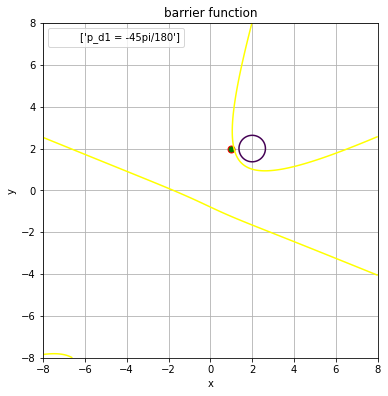

In [51]:
# draw the lyapunov function 
f = plt.figure()
plt.plot(x_0, y_0, marker="o", markersize=7, markeredgecolor="red", markerfacecolor="green")
plt.grid()


X = np.linspace(-8, 8, 1000)
Y = np.linspace(-8, 8, 1000)
x, y = np.meshgrid(X,Y)
F_0 = (x - 2.0)**2 + (y - 2.0)**2 - 0.4

F_1 = -1 + x**2*(1.84853382719254e-9*x**2 - 5.05561330000339e-10*x*y + 0.179785832053468*x + 2.79984224455267e-9*y**2 + 0.00425392689134826*y - 0.363944253395137) + 0.55753475070707*x**2 + x*y*(-3.60551792113297e-10*x**2 + 3.45726107570363e-9*x*y + 0.0166415516024158*x + 1.85284996214215e-9*y**2 - 0.670812656635258*y - 0.112841493157909) + 1.35097124558541*x*y + x*(-0.359814513450407*x**2 - 0.0273314721424258*x*y + 0.0376417211662109*x + 0.673029218363356*y**2 + 0.480048995152463*y + 0.476885591771541) - 0.907041840255158*x + y**2*(1.44803095510492e-9*x**2 + 2.7151605879977e-9*x*y - 0.231894900728396*x + 2.05841531438897e-9*y**2 + 0.284018302191343*y - 0.110453543960549) + 0.318914392347248*y**2 + y*(-0.0164750630408635*x**2 + 1.13629036312759*x*y + 0.655772336129833*x - 0.569780224874624*y**2 + 0.0958040535141881*y - 0.928303685751165) - 1.77130303888517*y - 1.48132552143094

#p_d2:
#x**2*(4.08886555900745e-13*x**2 + 1.08757328239998e-14*x*y - 8.03524054389063e-6*x - 2.31995088244195e-14*y**2 - 8.23328812086956e-6*y - 0.00899238984060623) - 0.0999236191044965*x**2 + x*y*(-1.08090749351215e-14*x**2 - 3.18795434925672e-14*x*y - 8.96600813036925e-6*x - 1.6099649548841e-15*y**2 + 2.17946867408477e-6*y + 0.0135681174527129) - 0.0301659620662027*x*y + x*(1.33631282808743e-5*x**2 + 1.25771218145123e-5*x*y - 0.0501362319437982*x - 2.57305436609394e-6*y**2 + 0.0118460123791441*y + 0.15340538870675) + 0.482764100506305*x + y**2*(-8.4336276301567e-15*x**2 + 3.42258266381842e-15*x*y + 1.05123198966825e-6*x + 2.73110405769774e-14*y**2 + 7.24334710733881e-7*y + 0.00507532046707673) - 0.143585864475023*y**2 + y*(9.60795026748078e-6*x**2 - 1.10871684781535e-6*x*y + 0.00475937107214531*x - 1.37422174747182e-6*y**2 - 0.0205299054034837*y - 0.0141691031623692) + 0.650336729518674*y - 1.13117892825863e-9

#F_2 = -1.1 + x**2*(4.08886555900745e-13*x**2 + 1.08757328239998e-14*x*y - 8.03524054389063e-6*x - 2.31995088244195e-14*y**2 - 8.23328812086956e-6*y - 0.00899238984060623) - 0.0999236191044965*x**2 + x*y*(-1.08090749351215e-14*x**2 - 3.18795434925672e-14*x*y - 8.96600813036925e-6*x - 1.6099649548841e-15*y**2 + 2.17946867408477e-6*y + 0.0135681174527129) - 0.0301659620662027*x*y + x*(1.33631282808743e-5*x**2 + 1.25771218145123e-5*x*y - 0.0501362319437982*x - 2.57305436609394e-6*y**2 + 0.0118460123791441*y + 0.15340538870675) + 0.482764100506305*x + y**2*(-8.4336276301567e-15*x**2 + 3.42258266381842e-15*x*y + 1.05123198966825e-6*x + 2.73110405769774e-14*y**2 + 7.24334710733881e-7*y + 0.00507532046707673) - 0.143585864475023*y**2 + y*(9.60795026748078e-6*x**2 - 1.10871684781535e-6*x*y + 0.00475937107214531*x - 1.37422174747182e-6*y**2 - 0.0205299054034837*y - 0.0141691031623692) + 0.650336729518674*y - 1.13117892825863e-9
#F_3 = -1 + x**2*(9.36781589647409e-14*x**2 - 3.52449924861411e-16*x*y - 1.40104260875339e-5*x - 1.69523298251119e-13*y**2 - 1.98920236145001e-5*y - 0.0108634899328319) - 0.0976762861896071*x**2 + x*y*(-3.57540093472062e-16*x**2 - 1.61487898105205e-13*x*y - 4.35321084105015e-6*x - 7.63569312670321e-16*y**2 - 1.1906818154019e-6*y - 4.1202976643182e-6) + 0.000116655009401506*x*y + x*(2.71307484505721e-5*x**2 + 3.26641362753143e-5*x*y - 0.0505275719086497*x + 3.96554900263119e-7*y**2 - 0.000109762842564501*y + 0.230695030636768) + 0.405475277619203*x + y**2*(-3.88255362352603e-14*x**2 - 1.10459692319762e-16*x*y - 2.71057348843077e-8*x - 2.58101385096086e-15*y**2 - 5.86351017592017e-8*y + 0.00241101649533867) - 0.156630870942956*y**2 + y*(4.32730971708777e-6*x**2 + 1.2468839123867e-6*x*y + 4.12210542785523e-6*x + 8.96070471459519e-8*y**2 - 0.00482195332739324*y - 1.47611354347279e-7) + 0.63616790379725*y - 1.13117952603491e-9


## old
#F_2 = -1 + x**2*(3.82997159864681e-6*x**2 + 1.68381677559001e-7*x*y - 1.12113557533194e-5*x - 7.49977957013959e-7*y**2 - 1.40161265400912e-5*y + 15.9715688717261) + 15.9715688717261*x**2 + x*y*(1.68381677559001e-7*x**2 - 1.49752630081113e-6*x*y - 1.40171554467136e-5*x + 6.06272879926795e-7*y**2 + 6.66433224047681e-5*y - 15.0576007199589) - 15.0576007199589*x*y + x*(-1.12113557533194e-5*x**2 - 1.40171554467136e-5*x*y + 31.9431370826065*x + 6.66434401433447e-5*y**2 - 15.057600723051*y + 987.752080532361) + 987.752080532361*x + y**2*(-7.49977957013959e-7*x**2 + 6.06272879926795e-7*x*y + 6.66434401433447e-5*x + 4.8125182779465e-6*y**2 - 0.164581517592047*y + 5.16187968666181) + 5.16187968666181*y**2 + y*(-1.40161265400912e-5*x**2 + 6.66433224047681e-5*x*y - 15.057600723051*x - 0.164581517592047*y**2 + 10.3237591604807*y - 520.323160801046) - 520.323160801046*y - 1.45181859037609e-8
#F_3 = x**2*(2.9580493915551e-6*x**2 + 7.59370726308024e-7*x*y - 4.68497003598265e-7*x + 3.53011673678342e-7*y**2 + 5.92344083621917e-7*y + 9.19466712378124) + 9.19466712378124*x**2 + x*y*(7.59370726308024e-7*x**2 + 7.05391543999589e-7*x*y + 5.92319951084293e-7*x + 5.85439054188757e-8*y**2 - 6.65279537432585e-5*y + 0.46505774696933) + 0.46505774696933*x*y + x*(-4.68497003598265e-7*x**2 + 5.92319951084293e-7*x*y + 18.3893338677532*x - 6.65279522961589e-5*y**2 + 0.465057746988303*y + 14.657271210702) + 14.657271210702*x + y**2*(3.53011673678342e-7*x**2 + 5.85439054188757e-8*x*y - 6.65279522961589e-5*x + 1.88042571099524e-7*y**2 + 0.00264590442711471*y - 0.0855176807148866) - 0.0855176807148866*y**2 + y*(5.92344083621917e-7*x**2 - 6.65279537432585e-5*x*y + 0.465057746988303*x + 0.00264590442711471*y**2 - 0.171035357911324*y - 20.9101059964369) - 20.9101059964369*y + 1.17380176553371e-9 - 1
#F_4 = x**2*(-1.77971653274253e-8*x**2 + 5.40625267203155e-9*x*y + 2.47293098570904e-9*x - 3.33775814566025e-10*y**2 + 3.12826099044018e-9*y - 0.00591899843131968) - 0.00591899843131968*x**2 + x*y*(5.40625267203155e-9*x**2 - 6.64400746322418e-10*x*y + 3.09935144598784e-9*x + 1.23810446062208e-9*y**2 - 2.65077787771785e-6*y - 0.0037265441624596) - 0.0037265441624596*x*y + x*(2.47293098570904e-9*x**2 + 3.09935144598784e-9*x*y - 0.0118379964402727*x - 2.65078060915988e-6*y**2 - 0.00372654432886127*y + 0.322539241930605) + 0.322539241930605*x + y**2*(-3.33775814566025e-10*x**2 + 1.23810446062208e-9*x*y - 2.65078060915988e-6*x + 2.60245441173583e-9*y**2 + 1.51193182453602e-6*y - 1.88680136348403e-6) - 1.88680136348403e-6*y**2 + y*(3.12826099044018e-9*x**2 - 2.65077787771785e-6*x*y - 0.00372654432886127*x + 1.51193182453602e-6*y**2 - 3.77359204504968e-6*y + 0.0818001795947616) + 0.0818001795947616*y - 8.77205473660236e-11 - 1
#F_5 = x**2*(2.97182531776636e-9*x**2 + 1.36515685131752e-8*x*y + 8.67786068356501e-9*x - 3.49921637130458e-9*y**2 + 1.55800356646029e-9*y - 0.00428353869471785) - 0.00428353869471785*x**2 + x*y*(1.36515685131752e-8*x**2 - 6.9779891204049e-9*x*y + 1.52334373326876e-9*x + 3.33688469565121e-9*y**2 - 3.79236902267177e-6*y - 0.00303429188154167) - 0.00303429188154167*x*y + x*(8.67786068356501e-9*x**2 + 1.52334373326876e-9*x*y - 0.00856707723878315*x - 3.79237038027352e-6*y**2 - 0.00303429185043945*y + 0.295355474872421) + 0.295355474872421*x + y**2*(-3.49921637130458e-9*x**2 + 3.33688469565121e-9*x*y - 3.79237038027352e-6*x - 1.18654043509412e-9*y**2 - 0.000448982144446555*y - 0.00152859833262397) - 0.00152859833262397*y**2 + y*(1.55800356646029e-9*x**2 - 3.79236902267177e-6*x*y - 0.00303429185043945*x - 0.000448982144446555*y**2 - 0.00305719662265144*y + 0.219996112247361) + 0.219996112247361*y - 3.67875875890465e-11 - 1

plt.contour(x,y,F_0,[0])



CS1 = plt.contour(x,y,F_1,[0],colors = ['yellow'])
label1 = ['p_d1 = -45pi/180']
CS1.collections[0].set_label(label1)

# p_d2
#CS2 = plt.contour(x,y,F_2,[0],colors = ['blue'])
#label2 = ['p_d2 = -20pi/180']
#CS2.collections[0].set_label(label2)
# p_d3
#CS3 = plt.contour(x,y,F_3,[0],colors = ['black'])
#label3 = ['p_d3 = 0']
#CS3.collections[0].set_label(label3)
# p_d4
#CS4 = plt.contour(x,y,F_4,[0],colors = ['red'])
#label4 = ['p_d4 = 20pi/180']
#CS4.collections[0].set_label(label4)
# p_d5
#CS5 = plt.contour(x,y,F_5,[0],colors = ['green'])
#label5 = ['p_d5 = 45pi/180']
#CS5.collections[0].set_label(label5)
plt.xlabel('x')
plt.ylabel('y')
#plt.axis('equal')
plt.legend(loc='upper left')
plt.title("barrier function")
plt.gca().set_aspect('equal', adjustable='box')
f.set_figheight(15)
plt.show()

In [138]:
# modified version for adding circle constraint
x,y,p = sympy.symbols('x y p')
K = 50
V = 1.0
p_d1 = -45*np.pi/180
p_d2 = -20*np.pi/180
p_d3 = 0
p_d4 = 20*np.pi/180
p_d5 = 45*np.pi/180

x_0 = 0
y_0 = 0
angle = 0

# taylor approximation around 0 (should be changed later)
#f = sympy.Matrix([[-V*p +(V*p**3)/6],[V - (V*p**2)/2],[-K*(p - p_d4)]])
f = sympy.Matrix([[-(V*math.cos(angle)*p - (V*math.cos(angle))/6*p**3)],[V*math.cos(angle) - (V*math.cos(angle)/2)*p**2],[-K*(p - p_d5)]])
#print(f_1)
#print(f_2)
# polynomial basis
b1 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b1 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b1 = sympy.Matrix([[1,x,y,p]]).transpose()


Q = sympy.MatrixSymbol('Q',10,10)
#Q = sympy.MatrixSymbol('Q',4,4)
#Q = sympy.MatrixSymbol('Q',9,9)


# partial derivative
db1_dx = sympy.diff(b1,x)
#print(db1_dx)
db1_dy = sympy.diff(b1,y)
db1_dp = sympy.diff(b1,p)


########## parameterization step
# V
V = (b1.T @ Q @ b1).as_explicit()
SOS_V_para_poly = sympy.Poly(V[0],x,y,p)
B = sympy.Matrix([
            [db1_dx, db1_dy,db1_dp]])
print(B.shape)
ne_Vdot_compute = (- 2 * b1.T @ Q @ B @ f).as_explicit()
ne_Vdot_compute_poly = sympy.Poly(ne_Vdot_compute[0],x, y, p)

print('check coeff of ne_Vdot_compute_poly:')
print(ne_Vdot_compute_poly)
    

# -V_dot
#b2 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
b2 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b2 = sympy.Matrix([[1,x,y,p]]).transpose()
#G = sympy.MatrixSymbol('G', 4, 4)
G = sympy.MatrixSymbol('G', 10, 10)
#G = G = sympy.MatrixSymbol('G', 9, 9)
SOS_of_ne_V_dot = (b2.T @ G @ b2).as_explicit()
SOS_of_ne_V_dot_poly = sympy.Poly(SOS_of_ne_V_dot[0], x, y, p)

print('\ncheck coeff of SOS_of_ne_V_dot_poly:')
print(SOS_of_ne_V_dot_poly)

b2_sqr = [b*b for b in b2]
for b_sqr in b2_sqr:
    coeff = SOS_of_ne_V_dot_poly.coeff_monomial(b_sqr)
    if coeff is sympy.S.Zero:
        print('WARNING: digonal coeff is zero for',b_sqr, ' not PSD for sure!')


# largrange multiplier
b3 = sympy.Matrix([[1,x,y,p]]).transpose()
#b3 = sympy.Matrix([[x,y,p]]).transpose()
J = sympy.MatrixSymbol('J',4,4)
#J = sympy.MatrixSymbol('J',3,3)
SOS_mutiplier_para = (b3.T @ J @ b3).as_explicit()
SOS_mutiplier_para_poly = sympy.Poly(SOS_mutiplier_para[0],x,y,p)


### dealing with obstacle constraint SOS

# obstacle constraint SOS paratrization
b4 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b4 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b4 = sympy.Matrix([[1,x,y,p]]).transpose()
#M = sympy.MatrixSymbol('M',10,10)
M = sympy.MatrixSymbol('M',10,10)
#M = sympy.MatrixSymbol('M',4,4)
SOS_constraint_para = (b4.T @ M @ b4).as_explicit()
SOS_constraint_para_poly = sympy.Poly(SOS_constraint_para[0],x,y,p)


#print('\ncheck coeff of SOS_constraint_para_poly:{}'.format(SOS_constraint_para_poly))


# obstacle constraint SOS computed from V and multiplier
epsilon_1 = 1e-6
SOS_constraint_compute_poly = (SOS_V_para_poly - (1 + epsilon_1)) - (SOS_mutiplier_para_poly * (0.4 - (x - 2)**2-(y - 2)**2))
constraint_list_V_Vdot = []
constraint_list_obstacle = []


## ------------------------------
# multiplier for radius constraint
b5 = sympy.Matrix([[1,x,y,p]]).transpose()
L = sympy.MatrixSymbol('L',4,4)
SOS_mutiplier_radius_para = (b5.T @ L @ b5).as_explicit()
SOS_mutiplier_radius_poly = sympy.Poly(SOS_mutiplier_radius_para[0],x,y,p)


# adding radius constraint for separating V(x) < 1 for all x,y in B(x_0)
b6 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
N = sympy.MatrixSymbol('N',10,10)
SOS_radius_para = (b6.T @ N @ b6).as_explicit()
SOS_radius_para_poly = sympy.Poly(SOS_radius_para[0],x,y,p)

epsilon_2 = 1e-6
SOS_radius_compute_poly = ((1 + epsilon_2) - SOS_V_para_poly) - (SOS_mutiplier_radius_poly * (0.2 - (x - x_0)**2 - (y - y_0)**2))
constraint_list_radius = []




#print('\ncheck coeff of SOS_constraint_compute_poly:{}'.format(SOS_constraint_compute_poly))

max_order = 10
# deal with V and -V_dot adding coeff matching constraint
for x_order in range(0,max_order+1):
    for y_order in range(0,max_order + 1):
        for p_order in range(0,max_order + 1):
            monomial = (x**x_order)*(y**y_order)*(p**p_order)
            # check if b2.T @ G b2 has coeff
            coeff_V_dot_para = SOS_of_ne_V_dot_poly.coeff_monomial(monomial)
            #print('coeff for {} in SOS_of_ne_V_dot_poly is {}'.format(monomial,coeff_V_dot_para))
            # check if - 2 * b1.T @ Q @ B @ f has coeff
            coeff_V_dot_compu = ne_Vdot_compute_poly.coeff_monomial(monomial)
            #print('coeff for {} in ne_Vdot_compute_poly is {}'.format(monomial,coeff_V_dot_compu))
            
            # continue if both do not contain
            if coeff_V_dot_para is sympy.S.Zero and coeff_V_dot_compu is sympy.S.Zero:
                continue
            
            ## should be modified
            if coeff_V_dot_para is sympy.S.Zero and not coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_V_dot_compu)
                constraint_list_V_Vdot.append(constrain)
            ## should be modified
            if not coeff_V_dot_para is sympy.S.Zero and coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_V_dot_para)
                constraint_list_V_Vdot.append(constrain)
                
            if not coeff_V_dot_para is sympy.S.Zero and not coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}=={}'.format(coeff_V_dot_compu,coeff_V_dot_para)
                constraint_list_V_Vdot.append(constrain)

            
print('\nConstraints V_Vdot (copy):', ','.join(constraint_list_V_Vdot))                

# delta with obstacle SOS coeff matching
for x_order in range(0,max_order+1):
    for y_order in range(0,max_order + 1):
        for p_order in range(0,max_order + 1):
            monomial = (x**x_order)*(y**y_order)*(p**p_order)
            
            coeff_constraint_para = SOS_constraint_para_poly.coeff_monomial(monomial)
            coeff_constraint_compute = SOS_constraint_compute_poly.coeff_monomial(monomial)
            
            if coeff_constraint_para is sympy.S.Zero and coeff_constraint_compute is sympy.S.Zero:
                #print(monomial)
                continue
            
            ## should be modified
            if coeff_constraint_para is sympy.S.Zero and not coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_constraint_compute)
                constraint_list_obstacle.append(constrain)
            ## should be modified
            if not coeff_constraint_para is sympy.S.Zero and coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_constraint_para)
                constraint_list_obstacle.append(constrain)
                
            if not coeff_constraint_para is sympy.S.Zero and not coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}=={}'.format(coeff_constraint_compute,coeff_constraint_para)
                constraint_list_obstacle.append(constrain)

print('\nConstraints obstacle SOS (copy):', ','.join(constraint_list_obstacle))

# deal with radius SOS coeff matching
for x_order in range(0,max_order+1):
    for y_order in range(0,max_order + 1):
        for p_order in range(0,max_order + 1):
            monomial = (x**x_order)*(y**y_order)*(p**p_order)
            
            coeff_radius_para = SOS_radius_para_poly.coeff_monomial(monomial)
            coeff_radius_compute = SOS_radius_compute_poly.coeff_monomial(monomial)
            
            if coeff_radius_para is sympy.S.Zero and coeff_radius_compute is sympy.S.Zero:
                #print(monomial)
                continue
            
            ## should be modified
            if coeff_radius_para is sympy.S.Zero and not coeff_radius_compute is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_radius_compute)
                constraint_list_radius.append(constrain)
            ## should be modified
            if not coeff_radius_para is sympy.S.Zero and coeff_radius_compute is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_radius_para)
                constraint_list_radius.append(constrain)
                
            if not coeff_radius_para is sympy.S.Zero and not coeff_radius_compute is sympy.S.Zero:
                constrain = '{}=={}'.format(coeff_radius_compute,coeff_radius_para)
                constraint_list_radius.append(constrain)

print('\nConstraints radius SOS (copy):', ','.join(constraint_list_radius))

(10, 3)
check coeff of ne_Vdot_compute_poly:
Poly(-0.666666666666667*Q[4, 4]*x**3*p**3 + 1.0*Q[4, 5]*x**3*p**2 + (4.0*Q[4, 4] + 100*Q[4, 7])*x**3*p + (-2.0*Q[4, 5] - 78.5398163397448*Q[4, 7])*x**3 + (-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4])*x**2*y*p**3 + (2.0*Q[4, 6] + 1.0*Q[5, 5])*x**2*y*p**2 + (2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7])*x**2*y*p + (-4.0*Q[4, 6] - 78.5398163397448*Q[4, 8] - 2.0*Q[5, 5] - 78.5398163397448*Q[5, 7])*x**2*y + (-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4])*x**2*p**4 + (-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5])*x**2*p**3 + (1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7])*x**2*p**2 + (4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] - 157.07963267949*Q[4, 9] - 2.0*Q[7, 5] - 78.5398163397448*Q[7, 7])*x**2*p + (-2.0*Q[1, 5] - 78.5398163397448*Q[1, 7] - 2.0*Q[4, 2] - 78.5398163397448*Q[4, 3])*x**2 + (-0.333333333333333*Q[5, 5] - 0


Constraints obstacle SOS (copy): 7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]

In [144]:
# solve SOS as SDP based on constraint obtained earilier
Q = cp.Variable((10,10), symmetric=True)
G = cp.Variable((10,10), symmetric=True)
M = cp.Variable((10,10), symmetric = True)
J = cp.Variable((4,4), symmetric = True)
L = cp.Variable((4,4), symmetric = True)
N = cp.Variable((10,10),symmetric = True)

# make sure positive definite , sufficient condition
#epsilon = 1e-8
#constraints = [Q >> 0]
constraints = [G >> 0]
constraints += [M >> 0]
constraints += [J >> 0]
constraints += [L >> 0]
constraints += [N >> 0]

# equaility constraint for initial condition
x_0 = 0.0
y_0 = 0.0
p_0 = 0.0

b_0 = np.array([[1,x_0,y_0,p_0,x_0**2,x_0*y_0,y_0**2,x_0*p_0,y_0*p_0,p_0**2]]).transpose()
#print(b_0.T @ Q @ b_0)
#b1 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#constraints += 

constraints += [b_0.T @ Q @ b_0 == 0]


# matching constraint

# p_d1 (infeasible)

# p_d2 
#constraints += [-2.0*Q[0, 2] + 34.9065850398866*Q[0, 3]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] + 69.8131700797732*Q[0, 9] - 2.0*Q[3, 2] + 34.9065850398866*Q[3, 3]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] + 69.8131700797732*Q[3, 9] - 2.0*Q[9, 2] + 34.9065850398866*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8] + 69.8131700797732*Q[9, 9]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] + 34.9065850398866*Q[0, 8] - 2.0*Q[2, 2] + 34.9065850398866*Q[2, 3]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] + 69.8131700797732*Q[2, 9] - 4.0*Q[3, 6] + 34.9065850398866*Q[3, 8] - 2.0*Q[8, 2] + 34.9065850398866*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] + 69.8131700797732*Q[8, 9] - 4.0*Q[9, 6] + 34.9065850398866*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333*Q[0, 5] - 0.333333333333333*Q[2, 1] + 1.0*Q[2, 8] + 2.0*Q[3, 6] + 1.0*Q[8, 2] + 2.0*Q[8, 7] + 200*Q[8, 9] + 2.0*Q[9, 5] + 100*Q[9, 8]==G[8, 9] + G[9, 8],-0.333333333333333*Q[2, 7] - 0.333333333333333*Q[3, 5] - 0.333333333333333*Q[8, 1] + 1.0*Q[8, 8] + 2.0*Q[9, 6]==0.,-0.333333333333333*Q[8, 7] - 0.333333333333333*Q[9, 5]==0.,-4.0*Q[2, 6] + 34.9065850398866*Q[2, 8] - 2.0*Q[6, 2] + 34.9065850398866*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],2.0*Q[2, 5] + 100*Q[2, 8] + 2.0*Q[6, 1] + 100*Q[6, 3] - 2.0*Q[6, 8] + 69.8131700797732*Q[6, 9] - 4.0*Q[8, 6] + 34.9065850398866*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],2.0*Q[2, 6] + 1.0*Q[6, 2] + 2.0*Q[6, 7] + 200*Q[6, 9] + 2.0*Q[8, 5] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],-0.333333333333333*Q[2, 5] - 0.333333333333333*Q[6, 1] + 1.0*Q[6, 8] + 2.0*Q[8, 6]==0.,-0.333333333333333*Q[6, 7] - 0.333333333333333*Q[8, 5]==0.,-4.0*Q[6, 6] + 34.9065850398866*Q[6, 8]==G[2, 6] + G[6, 2],2.0*Q[6, 5] + 100*Q[6, 8]==G[6, 8] + G[8, 6],2.0*Q[6, 6]==0.,-0.333333333333333*Q[6, 5]==0.,G[6, 6]==0.,-2.0*Q[0, 5] + 34.9065850398866*Q[0, 7] - 2.0*Q[1, 2] + 34.9065850398866*Q[1, 3]==G[0, 1] + G[1, 0],4.0*Q[0, 4] + 100*Q[0, 7] + 2.0*Q[1, 1] + 100*Q[1, 3] - 2.0*Q[1, 8] + 69.8131700797732*Q[1, 9] - 2.0*Q[3, 5] + 34.9065850398866*Q[3, 7] - 2.0*Q[7, 2] + 34.9065850398866*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],1.0*Q[0, 5] + 1.0*Q[1, 2] + 2.0*Q[1, 7] + 200*Q[1, 9] + 4.0*Q[3, 4] + 100*Q[3, 7] + 2.0*Q[7, 1] + 100*Q[7, 3] - 2.0*Q[7, 8] + 69.8131700797732*Q[7, 9] - 2.0*Q[9, 5] + 34.9065850398866*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],-0.666666666666667*Q[0, 4] - 0.333333333333333*Q[1, 1] + 1.0*Q[1, 8] + 1.0*Q[3, 5] + 1.0*Q[7, 2] + 2.0*Q[7, 7] + 200*Q[7, 9] + 4.0*Q[9, 4] + 100*Q[9, 7]==G[7, 9] + G[9, 7],-0.333333333333333*Q[1, 7] - 0.666666666666667*Q[3, 4] - 0.333333333333333*Q[7, 1] + 1.0*Q[7, 8] + 1.0*Q[9, 5]==0.,-0.333333333333333*Q[7, 7] - 0.666666666666667*Q[9, 4]==0.,-4.0*Q[1, 6] + 34.9065850398866*Q[1, 8] - 2.0*Q[2, 5] + 34.9065850398866*Q[2, 7] - 2.0*Q[5, 2] + 34.9065850398866*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],2.0*Q[1, 5] + 100*Q[1, 8] + 4.0*Q[2, 4] + 100*Q[2, 7] + 2.0*Q[5, 1] + 100*Q[5, 3] - 2.0*Q[5, 8] + 69.8131700797732*Q[5, 9] - 4.0*Q[7, 6] + 34.9065850398866*Q[7, 8] - 2.0*Q[8, 5] + 34.9065850398866*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],2.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 2.0*Q[5, 7] + 200*Q[5, 9] + 2.0*Q[7, 5] + 100*Q[7, 8] + 4.0*Q[8, 4] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],-0.333333333333333*Q[1, 5] - 0.666666666666667*Q[2, 4] - 0.333333333333333*Q[5, 1] + 1.0*Q[5, 8] + 2.0*Q[7, 6] + 1.0*Q[8, 5]==0.,-0.333333333333333*Q[5, 7] - 0.333333333333333*Q[7, 5] - 0.666666666666667*Q[8, 4]==0.,-4.0*Q[5, 6] + 34.9065850398866*Q[5, 8] - 2.0*Q[6, 5] + 34.9065850398866*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],2.0*Q[5, 5] + 100*Q[5, 8] + 4.0*Q[6, 4] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],2.0*Q[5, 6] + 1.0*Q[6, 5]==0.,-0.333333333333333*Q[5, 5] - 0.666666666666667*Q[6, 4]==0.,G[5, 6] + G[6, 5]==0.,-2.0*Q[1, 5] + 34.9065850398866*Q[1, 7] - 2.0*Q[4, 2] + 34.9065850398866*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] + 69.8131700797732*Q[4, 9] - 2.0*Q[7, 5] + 34.9065850398866*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5]==0.,-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4]==0.,-4.0*Q[4, 6] + 34.9065850398866*Q[4, 8] - 2.0*Q[5, 5] + 34.9065850398866*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],2.0*Q[4, 6] + 1.0*Q[5, 5]==0.,-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-2.0*Q[4, 5] + 34.9065850398866*Q[4, 7]==G[1, 4] + G[4, 1],4.0*Q[4, 4] + 100*Q[4, 7]==G[4, 7] + G[7, 4],1.0*Q[4, 5]==0.,-0.666666666666667*Q[4, 4]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],1.0*J[0, 2] + 1.0*J[2, 0] - 4.0*J[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[6, 8] + 1.0*Q[8, 6]==M[6, 8] + M[8, 6],1.0*J[2, 2] + 1.0*Q[6, 6]==M[6, 6],-4.0*J[0, 0] + 7.6*J[0, 1] + 7.6*J[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-4.0*J[0, 3] + 7.6*J[1, 3] - 4.0*J[3, 0] + 7.6*J[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-4.0*J[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-4.0*J[0, 1] - 4.0*J[0, 2] - 4.0*J[1, 0] + 7.6*J[1, 2] - 4.0*J[2, 0] + 7.6*J[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-4.0*J[1, 3] - 4.0*J[2, 3] - 4.0*J[3, 1] - 4.0*J[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 2] - 4.0*J[2, 1] - 4.0*J[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[5, 8] + 1.0*Q[6, 7] + 1.0*Q[7, 6] + 1.0*Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[5, 6] + 1.0*Q[6, 5]==M[5, 6] + M[6, 5],1.0*J[0, 0] - 4.0*J[0, 1] - 4.0*J[1, 0] + 7.6*J[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],1.0*J[0, 3] - 4.0*J[1, 3] + 1.0*J[3, 0] - 4.0*J[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],1.0*J[3, 3] + 1.0*Q[4, 9] + 1.0*Q[7, 7] + 1.0*Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],1.0*J[0, 2] - 4.0*J[1, 1] - 4.0*J[1, 2] + 1.0*J[2, 0] - 4.0*J[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[4, 8] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 1.0*Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],1.0*J[1, 1] + 1.0*J[2, 2] + 1.0*Q[4, 6] + 1.0*Q[5, 5] + 1.0*Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[4, 7] + 1.0*Q[7, 4]==M[4, 7] + M[7, 4],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[4, 5] + 1.0*Q[5, 4]==M[4, 5] + M[5, 4],1.0*J[1, 1] + 1.0*Q[4, 4]==M[4, 4]]
#constraints += [-0.2*L[0, 0] - 1.0*Q[0, 0] + 1.000001==N[0, 0],-0.2*L[0, 3] - 0.2*L[3, 0] - 1.0*Q[0, 3] - 1.0*Q[3, 0]==N[0, 3] + N[3, 0],-0.2*L[3, 3] - 1.0*Q[0, 9] - 1.0*Q[3, 3] - 1.0*Q[9, 0]==N[0, 9] + N[3, 3] + N[9, 0],-Q[3, 9] - Q[9, 3]==N[3, 9] + N[9, 3],-Q[9, 9]==N[9, 9],-0.2*L[0, 2] - 0.2*L[2, 0] - 1.0*Q[0, 2] - 1.0*Q[2, 0]==N[0, 2] + N[2, 0],-0.2*L[2, 3] - 0.2*L[3, 2] - 1.0*Q[0, 8] - 1.0*Q[2, 3] - 1.0*Q[3, 2] - 1.0*Q[8, 0]==N[0, 8] + N[2, 3] + N[3, 2] + N[8, 0],-Q[2, 9] - Q[3, 8] - Q[8, 3] - Q[9, 2]==N[2, 9] + N[3, 8] + N[8, 3] + N[9, 2],-Q[8, 9] - Q[9, 8]==N[8, 9] + N[9, 8],1.0*L[0, 0] - 0.2*L[2, 2] - 1.0*Q[0, 6] - 1.0*Q[2, 2] - 1.0*Q[6, 0]==N[0, 6] + N[2, 2] + N[6, 0],1.0*L[0, 3] + 1.0*L[3, 0] - 1.0*Q[2, 8] - 1.0*Q[3, 6] - 1.0*Q[6, 3] - 1.0*Q[8, 2]==N[2, 8] + N[3, 6] + N[6, 3] + N[8, 2],1.0*L[3, 3] - 1.0*Q[6, 9] - 1.0*Q[8, 8] - 1.0*Q[9, 6]==N[6, 9] + N[8, 8] + N[9, 6],1.0*L[0, 2] + 1.0*L[2, 0] - 1.0*Q[2, 6] - 1.0*Q[6, 2]==N[2, 6] + N[6, 2],1.0*L[2, 3] + 1.0*L[3, 2] - 1.0*Q[6, 8] - 1.0*Q[8, 6]==N[6, 8] + N[8, 6],1.0*L[2, 2] - 1.0*Q[6, 6]==N[6, 6],-0.2*L[0, 1] - 0.2*L[1, 0] - 1.0*Q[0, 1] - 1.0*Q[1, 0]==N[0, 1] + N[1, 0],-0.2*L[1, 3] - 0.2*L[3, 1] - 1.0*Q[0, 7] - 1.0*Q[1, 3] - 1.0*Q[3, 1] - 1.0*Q[7, 0]==N[0, 7] + N[1, 3] + N[3, 1] + N[7, 0],-Q[1, 9] - Q[3, 7] - Q[7, 3] - Q[9, 1]==N[1, 9] + N[3, 7] + N[7, 3] + N[9, 1],-Q[7, 9] - Q[9, 7]==N[7, 9] + N[9, 7],-0.2*L[1, 2] - 0.2*L[2, 1] - 1.0*Q[0, 5] - 1.0*Q[1, 2] - 1.0*Q[2, 1] - 1.0*Q[5, 0]==N[0, 5] + N[1, 2] + N[2, 1] + N[5, 0],-Q[1, 8] - Q[2, 7] - Q[3, 5] - Q[5, 3] - Q[7, 2] - Q[8, 1]==N[1, 8] + N[2, 7] + N[3, 5] + N[5, 3] + N[7, 2] + N[8, 1],-Q[5, 9] - Q[7, 8] - Q[8, 7] - Q[9, 5]==N[5, 9] + N[7, 8] + N[8, 7] + N[9, 5],1.0*L[0, 1] + 1.0*L[1, 0] - 1.0*Q[1, 6] - 1.0*Q[2, 5] - 1.0*Q[5, 2] - 1.0*Q[6, 1]==N[1, 6] + N[2, 5] + N[5, 2] + N[6, 1],1.0*L[1, 3] + 1.0*L[3, 1] - 1.0*Q[5, 8] - 1.0*Q[6, 7] - 1.0*Q[7, 6] - 1.0*Q[8, 5]==N[5, 8] + N[6, 7] + N[7, 6] + N[8, 5],1.0*L[1, 2] + 1.0*L[2, 1] - 1.0*Q[5, 6] - 1.0*Q[6, 5]==N[5, 6] + N[6, 5],1.0*L[0, 0] - 0.2*L[1, 1] - 1.0*Q[0, 4] - 1.0*Q[1, 1] - 1.0*Q[4, 0]==N[0, 4] + N[1, 1] + N[4, 0],1.0*L[0, 3] + 1.0*L[3, 0] - 1.0*Q[1, 7] - 1.0*Q[3, 4] - 1.0*Q[4, 3] - 1.0*Q[7, 1]==N[1, 7] + N[3, 4] + N[4, 3] + N[7, 1],1.0*L[3, 3] - 1.0*Q[4, 9] - 1.0*Q[7, 7] - 1.0*Q[9, 4]==N[4, 9] + N[7, 7] + N[9, 4],1.0*L[0, 2] + 1.0*L[2, 0] - 1.0*Q[1, 5] - 1.0*Q[2, 4] - 1.0*Q[4, 2] - 1.0*Q[5, 1]==N[1, 5] + N[2, 4] + N[4, 2] + N[5, 1],1.0*L[2, 3] + 1.0*L[3, 2] - 1.0*Q[4, 8] - 1.0*Q[5, 7] - 1.0*Q[7, 5] - 1.0*Q[8, 4]==N[4, 8] + N[5, 7] + N[7, 5] + N[8, 4],1.0*L[1, 1] + 1.0*L[2, 2] - 1.0*Q[4, 6] - 1.0*Q[5, 5] - 1.0*Q[6, 4]==N[4, 6] + N[5, 5] + N[6, 4],1.0*L[0, 1] + 1.0*L[1, 0] - 1.0*Q[1, 4] - 1.0*Q[4, 1]==N[1, 4] + N[4, 1],1.0*L[1, 3] + 1.0*L[3, 1] - 1.0*Q[4, 7] - 1.0*Q[7, 4]==N[4, 7] + N[7, 4],1.0*L[1, 2] + 1.0*L[2, 1] - 1.0*Q[4, 5] - 1.0*Q[5, 4]==N[4, 5] + N[5, 4],1.0*L[1, 1] - 1.0*Q[4, 4]==N[4, 4]]

# p_d3
#constraints += [-2.0*Q[0, 2]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] - 2.0*Q[3, 2]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] - 2.0*Q[9, 2]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] - 2.0*Q[2, 2]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] - 4.0*Q[3, 6] - 2.0*Q[8, 2]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] - 4.0*Q[9, 6]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333*Q[0, 5] - 0.333333333333333*Q[2, 1] + 1.0*Q[2, 8] + 2.0*Q[3, 6] + 1.0*Q[8, 2] + 2.0*Q[8, 7] + 200*Q[8, 9] + 2.0*Q[9, 5] + 100*Q[9, 8]==G[8, 9] + G[9, 8],-0.333333333333333*Q[2, 7] - 0.333333333333333*Q[3, 5] - 0.333333333333333*Q[8, 1] + 1.0*Q[8, 8] + 2.0*Q[9, 6]==0.,-0.333333333333333*Q[8, 7] - 0.333333333333333*Q[9, 5]==0.,-4.0*Q[2, 6] - 2.0*Q[6, 2]==G[0, 6] + G[2, 2] + G[6, 0],2.0*Q[2, 5] + 100*Q[2, 8] + 2.0*Q[6, 1] + 100*Q[6, 3] - 2.0*Q[6, 8] - 4.0*Q[8, 6]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],2.0*Q[2, 6] + 1.0*Q[6, 2] + 2.0*Q[6, 7] + 200*Q[6, 9] + 2.0*Q[8, 5] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],-0.333333333333333*Q[2, 5] - 0.333333333333333*Q[6, 1] + 1.0*Q[6, 8] + 2.0*Q[8, 6]==0.,-0.333333333333333*Q[6, 7] - 0.333333333333333*Q[8, 5]==0.,-4.0*Q[6, 6]==G[2, 6] + G[6, 2],2.0*Q[6, 5] + 100*Q[6, 8]==G[6, 8] + G[8, 6],2.0*Q[6, 6]==0.,-0.333333333333333*Q[6, 5]==0.,G[6, 6]==0.,-2.0*Q[0, 5] - 2.0*Q[1, 2]==G[0, 1] + G[1, 0],4.0*Q[0, 4] + 100*Q[0, 7] + 2.0*Q[1, 1] + 100*Q[1, 3] - 2.0*Q[1, 8] - 2.0*Q[3, 5] - 2.0*Q[7, 2]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],1.0*Q[0, 5] + 1.0*Q[1, 2] + 2.0*Q[1, 7] + 200*Q[1, 9] + 4.0*Q[3, 4] + 100*Q[3, 7] + 2.0*Q[7, 1] + 100*Q[7, 3] - 2.0*Q[7, 8] - 2.0*Q[9, 5]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],-0.666666666666667*Q[0, 4] - 0.333333333333333*Q[1, 1] + 1.0*Q[1, 8] + 1.0*Q[3, 5] + 1.0*Q[7, 2] + 2.0*Q[7, 7] + 200*Q[7, 9] + 4.0*Q[9, 4] + 100*Q[9, 7]==G[7, 9] + G[9, 7],-0.333333333333333*Q[1, 7] - 0.666666666666667*Q[3, 4] - 0.333333333333333*Q[7, 1] + 1.0*Q[7, 8] + 1.0*Q[9, 5]==0.,-0.333333333333333*Q[7, 7] - 0.666666666666667*Q[9, 4]==0.,-4.0*Q[1, 6] - 2.0*Q[2, 5] - 2.0*Q[5, 2]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],2.0*Q[1, 5] + 100*Q[1, 8] + 4.0*Q[2, 4] + 100*Q[2, 7] + 2.0*Q[5, 1] + 100*Q[5, 3] - 2.0*Q[5, 8] - 4.0*Q[7, 6] - 2.0*Q[8, 5]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],2.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 2.0*Q[5, 7] + 200*Q[5, 9] + 2.0*Q[7, 5] + 100*Q[7, 8] + 4.0*Q[8, 4] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],-0.333333333333333*Q[1, 5] - 0.666666666666667*Q[2, 4] - 0.333333333333333*Q[5, 1] + 1.0*Q[5, 8] + 2.0*Q[7, 6] + 1.0*Q[8, 5]==0.,-0.333333333333333*Q[5, 7] - 0.333333333333333*Q[7, 5] - 0.666666666666667*Q[8, 4]==0.,-4.0*Q[5, 6] - 2.0*Q[6, 5]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],2.0*Q[5, 5] + 100*Q[5, 8] + 4.0*Q[6, 4] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],2.0*Q[5, 6] + 1.0*Q[6, 5]==0.,-0.333333333333333*Q[5, 5] - 0.666666666666667*Q[6, 4]==0.,G[5, 6] + G[6, 5]==0.,-2.0*Q[1, 5] - 2.0*Q[4, 2]==G[0, 4] + G[1, 1] + G[4, 0],4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] - 2.0*Q[7, 5]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5]==0.,-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4]==0.,-4.0*Q[4, 6] - 2.0*Q[5, 5]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],2.0*Q[4, 6] + 1.0*Q[5, 5]==0.,-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-2.0*Q[4, 5]==G[1, 4] + G[4, 1],4.0*Q[4, 4] + 100*Q[4, 7]==G[4, 7] + G[7, 4],1.0*Q[4, 5]==0.,-0.666666666666667*Q[4, 4]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],1.0*J[0, 2] + 1.0*J[2, 0] - 4.0*J[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[6, 8] + 1.0*Q[8, 6]==M[6, 8] + M[8, 6],1.0*J[2, 2] + 1.0*Q[6, 6]==M[6, 6],-4.0*J[0, 0] + 7.6*J[0, 1] + 7.6*J[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-4.0*J[0, 3] + 7.6*J[1, 3] - 4.0*J[3, 0] + 7.6*J[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-4.0*J[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-4.0*J[0, 1] - 4.0*J[0, 2] - 4.0*J[1, 0] + 7.6*J[1, 2] - 4.0*J[2, 0] + 7.6*J[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-4.0*J[1, 3] - 4.0*J[2, 3] - 4.0*J[3, 1] - 4.0*J[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 2] - 4.0*J[2, 1] - 4.0*J[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[5, 8] + 1.0*Q[6, 7] + 1.0*Q[7, 6] + 1.0*Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[5, 6] + 1.0*Q[6, 5]==M[5, 6] + M[6, 5],1.0*J[0, 0] - 4.0*J[0, 1] - 4.0*J[1, 0] + 7.6*J[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],1.0*J[0, 3] - 4.0*J[1, 3] + 1.0*J[3, 0] - 4.0*J[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],1.0*J[3, 3] + 1.0*Q[4, 9] + 1.0*Q[7, 7] + 1.0*Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],1.0*J[0, 2] - 4.0*J[1, 1] - 4.0*J[1, 2] + 1.0*J[2, 0] - 4.0*J[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[4, 8] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 1.0*Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],1.0*J[1, 1] + 1.0*J[2, 2] + 1.0*Q[4, 6] + 1.0*Q[5, 5] + 1.0*Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[4, 7] + 1.0*Q[7, 4]==M[4, 7] + M[7, 4],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[4, 5] + 1.0*Q[5, 4]==M[4, 5] + M[5, 4],1.0*J[1, 1] + 1.0*Q[4, 4]==M[4, 4]]
#constraints += [-0.2*L[0, 0] - 1.0*Q[0, 0] + 1.000001==N[0, 0],-0.2*L[0, 3] - 0.2*L[3, 0] - 1.0*Q[0, 3] - 1.0*Q[3, 0]==N[0, 3] + N[3, 0],-0.2*L[3, 3] - 1.0*Q[0, 9] - 1.0*Q[3, 3] - 1.0*Q[9, 0]==N[0, 9] + N[3, 3] + N[9, 0],-Q[3, 9] - Q[9, 3]==N[3, 9] + N[9, 3],-Q[9, 9]==N[9, 9],-0.2*L[0, 2] - 0.2*L[2, 0] - 1.0*Q[0, 2] - 1.0*Q[2, 0]==N[0, 2] + N[2, 0],-0.2*L[2, 3] - 0.2*L[3, 2] - 1.0*Q[0, 8] - 1.0*Q[2, 3] - 1.0*Q[3, 2] - 1.0*Q[8, 0]==N[0, 8] + N[2, 3] + N[3, 2] + N[8, 0],-Q[2, 9] - Q[3, 8] - Q[8, 3] - Q[9, 2]==N[2, 9] + N[3, 8] + N[8, 3] + N[9, 2],-Q[8, 9] - Q[9, 8]==N[8, 9] + N[9, 8],1.0*L[0, 0] - 0.2*L[2, 2] - 1.0*Q[0, 6] - 1.0*Q[2, 2] - 1.0*Q[6, 0]==N[0, 6] + N[2, 2] + N[6, 0],1.0*L[0, 3] + 1.0*L[3, 0] - 1.0*Q[2, 8] - 1.0*Q[3, 6] - 1.0*Q[6, 3] - 1.0*Q[8, 2]==N[2, 8] + N[3, 6] + N[6, 3] + N[8, 2],1.0*L[3, 3] - 1.0*Q[6, 9] - 1.0*Q[8, 8] - 1.0*Q[9, 6]==N[6, 9] + N[8, 8] + N[9, 6],1.0*L[0, 2] + 1.0*L[2, 0] - 1.0*Q[2, 6] - 1.0*Q[6, 2]==N[2, 6] + N[6, 2],1.0*L[2, 3] + 1.0*L[3, 2] - 1.0*Q[6, 8] - 1.0*Q[8, 6]==N[6, 8] + N[8, 6],1.0*L[2, 2] - 1.0*Q[6, 6]==N[6, 6],-0.2*L[0, 1] - 0.2*L[1, 0] - 1.0*Q[0, 1] - 1.0*Q[1, 0]==N[0, 1] + N[1, 0],-0.2*L[1, 3] - 0.2*L[3, 1] - 1.0*Q[0, 7] - 1.0*Q[1, 3] - 1.0*Q[3, 1] - 1.0*Q[7, 0]==N[0, 7] + N[1, 3] + N[3, 1] + N[7, 0],-Q[1, 9] - Q[3, 7] - Q[7, 3] - Q[9, 1]==N[1, 9] + N[3, 7] + N[7, 3] + N[9, 1],-Q[7, 9] - Q[9, 7]==N[7, 9] + N[9, 7],-0.2*L[1, 2] - 0.2*L[2, 1] - 1.0*Q[0, 5] - 1.0*Q[1, 2] - 1.0*Q[2, 1] - 1.0*Q[5, 0]==N[0, 5] + N[1, 2] + N[2, 1] + N[5, 0],-Q[1, 8] - Q[2, 7] - Q[3, 5] - Q[5, 3] - Q[7, 2] - Q[8, 1]==N[1, 8] + N[2, 7] + N[3, 5] + N[5, 3] + N[7, 2] + N[8, 1],-Q[5, 9] - Q[7, 8] - Q[8, 7] - Q[9, 5]==N[5, 9] + N[7, 8] + N[8, 7] + N[9, 5],1.0*L[0, 1] + 1.0*L[1, 0] - 1.0*Q[1, 6] - 1.0*Q[2, 5] - 1.0*Q[5, 2] - 1.0*Q[6, 1]==N[1, 6] + N[2, 5] + N[5, 2] + N[6, 1],1.0*L[1, 3] + 1.0*L[3, 1] - 1.0*Q[5, 8] - 1.0*Q[6, 7] - 1.0*Q[7, 6] - 1.0*Q[8, 5]==N[5, 8] + N[6, 7] + N[7, 6] + N[8, 5],1.0*L[1, 2] + 1.0*L[2, 1] - 1.0*Q[5, 6] - 1.0*Q[6, 5]==N[5, 6] + N[6, 5],1.0*L[0, 0] - 0.2*L[1, 1] - 1.0*Q[0, 4] - 1.0*Q[1, 1] - 1.0*Q[4, 0]==N[0, 4] + N[1, 1] + N[4, 0],1.0*L[0, 3] + 1.0*L[3, 0] - 1.0*Q[1, 7] - 1.0*Q[3, 4] - 1.0*Q[4, 3] - 1.0*Q[7, 1]==N[1, 7] + N[3, 4] + N[4, 3] + N[7, 1],1.0*L[3, 3] - 1.0*Q[4, 9] - 1.0*Q[7, 7] - 1.0*Q[9, 4]==N[4, 9] + N[7, 7] + N[9, 4],1.0*L[0, 2] + 1.0*L[2, 0] - 1.0*Q[1, 5] - 1.0*Q[2, 4] - 1.0*Q[4, 2] - 1.0*Q[5, 1]==N[1, 5] + N[2, 4] + N[4, 2] + N[5, 1],1.0*L[2, 3] + 1.0*L[3, 2] - 1.0*Q[4, 8] - 1.0*Q[5, 7] - 1.0*Q[7, 5] - 1.0*Q[8, 4]==N[4, 8] + N[5, 7] + N[7, 5] + N[8, 4],1.0*L[1, 1] + 1.0*L[2, 2] - 1.0*Q[4, 6] - 1.0*Q[5, 5] - 1.0*Q[6, 4]==N[4, 6] + N[5, 5] + N[6, 4],1.0*L[0, 1] + 1.0*L[1, 0] - 1.0*Q[1, 4] - 1.0*Q[4, 1]==N[1, 4] + N[4, 1],1.0*L[1, 3] + 1.0*L[3, 1] - 1.0*Q[4, 7] - 1.0*Q[7, 4]==N[4, 7] + N[7, 4],1.0*L[1, 2] + 1.0*L[2, 1] - 1.0*Q[4, 5] - 1.0*Q[5, 4]==N[4, 5] + N[5, 4],1.0*L[1, 1] - 1.0*Q[4, 4]==N[4, 4]]


# p_d4
constraints += [-2.0*Q[0, 2] - 34.9065850398866*Q[0, 3]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] - 69.8131700797732*Q[0, 9] - 2.0*Q[3, 2] - 34.9065850398866*Q[3, 3]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] - 69.8131700797732*Q[3, 9] - 2.0*Q[9, 2] - 34.9065850398866*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8] - 69.8131700797732*Q[9, 9]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] - 34.9065850398866*Q[0, 8] - 2.0*Q[2, 2] - 34.9065850398866*Q[2, 3]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] - 69.8131700797732*Q[2, 9] - 4.0*Q[3, 6] - 34.9065850398866*Q[3, 8] - 2.0*Q[8, 2] - 34.9065850398866*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] - 69.8131700797732*Q[8, 9] - 4.0*Q[9, 6] - 34.9065850398866*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333*Q[0, 5] - 0.333333333333333*Q[2, 1] + 1.0*Q[2, 8] + 2.0*Q[3, 6] + 1.0*Q[8, 2] + 2.0*Q[8, 7] + 200*Q[8, 9] + 2.0*Q[9, 5] + 100*Q[9, 8]==G[8, 9] + G[9, 8],-0.333333333333333*Q[2, 7] - 0.333333333333333*Q[3, 5] - 0.333333333333333*Q[8, 1] + 1.0*Q[8, 8] + 2.0*Q[9, 6]==0.,-0.333333333333333*Q[8, 7] - 0.333333333333333*Q[9, 5]==0.,-4.0*Q[2, 6] - 34.9065850398866*Q[2, 8] - 2.0*Q[6, 2] - 34.9065850398866*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],2.0*Q[2, 5] + 100*Q[2, 8] + 2.0*Q[6, 1] + 100*Q[6, 3] - 2.0*Q[6, 8] - 69.8131700797732*Q[6, 9] - 4.0*Q[8, 6] - 34.9065850398866*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],2.0*Q[2, 6] + 1.0*Q[6, 2] + 2.0*Q[6, 7] + 200*Q[6, 9] + 2.0*Q[8, 5] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],-0.333333333333333*Q[2, 5] - 0.333333333333333*Q[6, 1] + 1.0*Q[6, 8] + 2.0*Q[8, 6]==0.,-0.333333333333333*Q[6, 7] - 0.333333333333333*Q[8, 5]==0.,-4.0*Q[6, 6] - 34.9065850398866*Q[6, 8]==G[2, 6] + G[6, 2],2.0*Q[6, 5] + 100*Q[6, 8]==G[6, 8] + G[8, 6],2.0*Q[6, 6]==0.,-0.333333333333333*Q[6, 5]==0.,G[6, 6]==0.,-2.0*Q[0, 5] - 34.9065850398866*Q[0, 7] - 2.0*Q[1, 2] - 34.9065850398866*Q[1, 3]==G[0, 1] + G[1, 0],4.0*Q[0, 4] + 100*Q[0, 7] + 2.0*Q[1, 1] + 100*Q[1, 3] - 2.0*Q[1, 8] - 69.8131700797732*Q[1, 9] - 2.0*Q[3, 5] - 34.9065850398866*Q[3, 7] - 2.0*Q[7, 2] - 34.9065850398866*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],1.0*Q[0, 5] + 1.0*Q[1, 2] + 2.0*Q[1, 7] + 200*Q[1, 9] + 4.0*Q[3, 4] + 100*Q[3, 7] + 2.0*Q[7, 1] + 100*Q[7, 3] - 2.0*Q[7, 8] - 69.8131700797732*Q[7, 9] - 2.0*Q[9, 5] - 34.9065850398866*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],-0.666666666666667*Q[0, 4] - 0.333333333333333*Q[1, 1] + 1.0*Q[1, 8] + 1.0*Q[3, 5] + 1.0*Q[7, 2] + 2.0*Q[7, 7] + 200*Q[7, 9] + 4.0*Q[9, 4] + 100*Q[9, 7]==G[7, 9] + G[9, 7],-0.333333333333333*Q[1, 7] - 0.666666666666667*Q[3, 4] - 0.333333333333333*Q[7, 1] + 1.0*Q[7, 8] + 1.0*Q[9, 5]==0.,-0.333333333333333*Q[7, 7] - 0.666666666666667*Q[9, 4]==0.,-4.0*Q[1, 6] - 34.9065850398866*Q[1, 8] - 2.0*Q[2, 5] - 34.9065850398866*Q[2, 7] - 2.0*Q[5, 2] - 34.9065850398866*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],2.0*Q[1, 5] + 100*Q[1, 8] + 4.0*Q[2, 4] + 100*Q[2, 7] + 2.0*Q[5, 1] + 100*Q[5, 3] - 2.0*Q[5, 8] - 69.8131700797732*Q[5, 9] - 4.0*Q[7, 6] - 34.9065850398866*Q[7, 8] - 2.0*Q[8, 5] - 34.9065850398866*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],2.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 2.0*Q[5, 7] + 200*Q[5, 9] + 2.0*Q[7, 5] + 100*Q[7, 8] + 4.0*Q[8, 4] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],-0.333333333333333*Q[1, 5] - 0.666666666666667*Q[2, 4] - 0.333333333333333*Q[5, 1] + 1.0*Q[5, 8] + 2.0*Q[7, 6] + 1.0*Q[8, 5]==0.,-0.333333333333333*Q[5, 7] - 0.333333333333333*Q[7, 5] - 0.666666666666667*Q[8, 4]==0.,-4.0*Q[5, 6] - 34.9065850398866*Q[5, 8] - 2.0*Q[6, 5] - 34.9065850398866*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],2.0*Q[5, 5] + 100*Q[5, 8] + 4.0*Q[6, 4] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],2.0*Q[5, 6] + 1.0*Q[6, 5]==0.,-0.333333333333333*Q[5, 5] - 0.666666666666667*Q[6, 4]==0.,G[5, 6] + G[6, 5]==0.,-2.0*Q[1, 5] - 34.9065850398866*Q[1, 7] - 2.0*Q[4, 2] - 34.9065850398866*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] - 69.8131700797732*Q[4, 9] - 2.0*Q[7, 5] - 34.9065850398866*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5]==0.,-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4]==0.,-4.0*Q[4, 6] - 34.9065850398866*Q[4, 8] - 2.0*Q[5, 5] - 34.9065850398866*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],2.0*Q[4, 6] + 1.0*Q[5, 5]==0.,-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-2.0*Q[4, 5] - 34.9065850398866*Q[4, 7]==G[1, 4] + G[4, 1],4.0*Q[4, 4] + 100*Q[4, 7]==G[4, 7] + G[7, 4],1.0*Q[4, 5]==0.,-0.666666666666667*Q[4, 4]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
constraints += [7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],1.0*J[0, 2] + 1.0*J[2, 0] - 4.0*J[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[6, 8] + 1.0*Q[8, 6]==M[6, 8] + M[8, 6],1.0*J[2, 2] + 1.0*Q[6, 6]==M[6, 6],-4.0*J[0, 0] + 7.6*J[0, 1] + 7.6*J[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-4.0*J[0, 3] + 7.6*J[1, 3] - 4.0*J[3, 0] + 7.6*J[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-4.0*J[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-4.0*J[0, 1] - 4.0*J[0, 2] - 4.0*J[1, 0] + 7.6*J[1, 2] - 4.0*J[2, 0] + 7.6*J[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-4.0*J[1, 3] - 4.0*J[2, 3] - 4.0*J[3, 1] - 4.0*J[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 2] - 4.0*J[2, 1] - 4.0*J[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[5, 8] + 1.0*Q[6, 7] + 1.0*Q[7, 6] + 1.0*Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[5, 6] + 1.0*Q[6, 5]==M[5, 6] + M[6, 5],1.0*J[0, 0] - 4.0*J[0, 1] - 4.0*J[1, 0] + 7.6*J[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],1.0*J[0, 3] - 4.0*J[1, 3] + 1.0*J[3, 0] - 4.0*J[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],1.0*J[3, 3] + 1.0*Q[4, 9] + 1.0*Q[7, 7] + 1.0*Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],1.0*J[0, 2] - 4.0*J[1, 1] - 4.0*J[1, 2] + 1.0*J[2, 0] - 4.0*J[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[4, 8] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 1.0*Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],1.0*J[1, 1] + 1.0*J[2, 2] + 1.0*Q[4, 6] + 1.0*Q[5, 5] + 1.0*Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[4, 7] + 1.0*Q[7, 4]==M[4, 7] + M[7, 4],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[4, 5] + 1.0*Q[5, 4]==M[4, 5] + M[5, 4],1.0*J[1, 1] + 1.0*Q[4, 4]==M[4, 4]]
constraints += [-0.2*L[0, 0] - 1.0*Q[0, 0] + 1.000001==N[0, 0],-0.2*L[0, 3] - 0.2*L[3, 0] - 1.0*Q[0, 3] - 1.0*Q[3, 0]==N[0, 3] + N[3, 0],-0.2*L[3, 3] - 1.0*Q[0, 9] - 1.0*Q[3, 3] - 1.0*Q[9, 0]==N[0, 9] + N[3, 3] + N[9, 0],-Q[3, 9] - Q[9, 3]==N[3, 9] + N[9, 3],-Q[9, 9]==N[9, 9],-0.2*L[0, 2] - 0.2*L[2, 0] - 1.0*Q[0, 2] - 1.0*Q[2, 0]==N[0, 2] + N[2, 0],-0.2*L[2, 3] - 0.2*L[3, 2] - 1.0*Q[0, 8] - 1.0*Q[2, 3] - 1.0*Q[3, 2] - 1.0*Q[8, 0]==N[0, 8] + N[2, 3] + N[3, 2] + N[8, 0],-Q[2, 9] - Q[3, 8] - Q[8, 3] - Q[9, 2]==N[2, 9] + N[3, 8] + N[8, 3] + N[9, 2],-Q[8, 9] - Q[9, 8]==N[8, 9] + N[9, 8],1.0*L[0, 0] - 0.2*L[2, 2] - 1.0*Q[0, 6] - 1.0*Q[2, 2] - 1.0*Q[6, 0]==N[0, 6] + N[2, 2] + N[6, 0],1.0*L[0, 3] + 1.0*L[3, 0] - 1.0*Q[2, 8] - 1.0*Q[3, 6] - 1.0*Q[6, 3] - 1.0*Q[8, 2]==N[2, 8] + N[3, 6] + N[6, 3] + N[8, 2],1.0*L[3, 3] - 1.0*Q[6, 9] - 1.0*Q[8, 8] - 1.0*Q[9, 6]==N[6, 9] + N[8, 8] + N[9, 6],1.0*L[0, 2] + 1.0*L[2, 0] - 1.0*Q[2, 6] - 1.0*Q[6, 2]==N[2, 6] + N[6, 2],1.0*L[2, 3] + 1.0*L[3, 2] - 1.0*Q[6, 8] - 1.0*Q[8, 6]==N[6, 8] + N[8, 6],1.0*L[2, 2] - 1.0*Q[6, 6]==N[6, 6],-0.2*L[0, 1] - 0.2*L[1, 0] - 1.0*Q[0, 1] - 1.0*Q[1, 0]==N[0, 1] + N[1, 0],-0.2*L[1, 3] - 0.2*L[3, 1] - 1.0*Q[0, 7] - 1.0*Q[1, 3] - 1.0*Q[3, 1] - 1.0*Q[7, 0]==N[0, 7] + N[1, 3] + N[3, 1] + N[7, 0],-Q[1, 9] - Q[3, 7] - Q[7, 3] - Q[9, 1]==N[1, 9] + N[3, 7] + N[7, 3] + N[9, 1],-Q[7, 9] - Q[9, 7]==N[7, 9] + N[9, 7],-0.2*L[1, 2] - 0.2*L[2, 1] - 1.0*Q[0, 5] - 1.0*Q[1, 2] - 1.0*Q[2, 1] - 1.0*Q[5, 0]==N[0, 5] + N[1, 2] + N[2, 1] + N[5, 0],-Q[1, 8] - Q[2, 7] - Q[3, 5] - Q[5, 3] - Q[7, 2] - Q[8, 1]==N[1, 8] + N[2, 7] + N[3, 5] + N[5, 3] + N[7, 2] + N[8, 1],-Q[5, 9] - Q[7, 8] - Q[8, 7] - Q[9, 5]==N[5, 9] + N[7, 8] + N[8, 7] + N[9, 5],1.0*L[0, 1] + 1.0*L[1, 0] - 1.0*Q[1, 6] - 1.0*Q[2, 5] - 1.0*Q[5, 2] - 1.0*Q[6, 1]==N[1, 6] + N[2, 5] + N[5, 2] + N[6, 1],1.0*L[1, 3] + 1.0*L[3, 1] - 1.0*Q[5, 8] - 1.0*Q[6, 7] - 1.0*Q[7, 6] - 1.0*Q[8, 5]==N[5, 8] + N[6, 7] + N[7, 6] + N[8, 5],1.0*L[1, 2] + 1.0*L[2, 1] - 1.0*Q[5, 6] - 1.0*Q[6, 5]==N[5, 6] + N[6, 5],1.0*L[0, 0] - 0.2*L[1, 1] - 1.0*Q[0, 4] - 1.0*Q[1, 1] - 1.0*Q[4, 0]==N[0, 4] + N[1, 1] + N[4, 0],1.0*L[0, 3] + 1.0*L[3, 0] - 1.0*Q[1, 7] - 1.0*Q[3, 4] - 1.0*Q[4, 3] - 1.0*Q[7, 1]==N[1, 7] + N[3, 4] + N[4, 3] + N[7, 1],1.0*L[3, 3] - 1.0*Q[4, 9] - 1.0*Q[7, 7] - 1.0*Q[9, 4]==N[4, 9] + N[7, 7] + N[9, 4],1.0*L[0, 2] + 1.0*L[2, 0] - 1.0*Q[1, 5] - 1.0*Q[2, 4] - 1.0*Q[4, 2] - 1.0*Q[5, 1]==N[1, 5] + N[2, 4] + N[4, 2] + N[5, 1],1.0*L[2, 3] + 1.0*L[3, 2] - 1.0*Q[4, 8] - 1.0*Q[5, 7] - 1.0*Q[7, 5] - 1.0*Q[8, 4]==N[4, 8] + N[5, 7] + N[7, 5] + N[8, 4],1.0*L[1, 1] + 1.0*L[2, 2] - 1.0*Q[4, 6] - 1.0*Q[5, 5] - 1.0*Q[6, 4]==N[4, 6] + N[5, 5] + N[6, 4],1.0*L[0, 1] + 1.0*L[1, 0] - 1.0*Q[1, 4] - 1.0*Q[4, 1]==N[1, 4] + N[4, 1],1.0*L[1, 3] + 1.0*L[3, 1] - 1.0*Q[4, 7] - 1.0*Q[7, 4]==N[4, 7] + N[7, 4],1.0*L[1, 2] + 1.0*L[2, 1] - 1.0*Q[4, 5] - 1.0*Q[5, 4]==N[4, 5] + N[5, 4],1.0*L[1, 1] - 1.0*Q[4, 4]==N[4, 4]]


# p_d5
#constraints += [-2.0*Q[0, 2] - 78.5398163397448*Q[0, 3]==G[0, 0],2.0*Q[0, 1] + 100*Q[0, 3] - 2.0*Q[0, 8] - 157.07963267949*Q[0, 9] - 2.0*Q[3, 2] - 78.5398163397448*Q[3, 3]==G[0, 3] + G[3, 0],1.0*Q[0, 2] + 2.0*Q[0, 7] + 200*Q[0, 9] + 2.0*Q[3, 1] + 100*Q[3, 3] - 2.0*Q[3, 8] - 157.07963267949*Q[3, 9] - 2.0*Q[9, 2] - 78.5398163397448*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],-0.333333333333333*Q[0, 1] + 1.0*Q[0, 8] + 1.0*Q[3, 2] + 2.0*Q[3, 7] + 200*Q[3, 9] + 2.0*Q[9, 1] + 100*Q[9, 3] - 2.0*Q[9, 8] - 157.07963267949*Q[9, 9]==G[3, 9] + G[9, 3],-0.333333333333333*Q[0, 7] - 0.333333333333333*Q[3, 1] + 1.0*Q[3, 8] + 1.0*Q[9, 2] + 2.0*Q[9, 7] + 200*Q[9, 9]==G[9, 9],-0.333333333333333*Q[3, 7] - 0.333333333333333*Q[9, 1] + 1.0*Q[9, 8]==0.,-0.333333333333333*Q[9, 7]==0.,-4.0*Q[0, 6] - 78.5398163397448*Q[0, 8] - 2.0*Q[2, 2] - 78.5398163397448*Q[2, 3]==G[0, 2] + G[2, 0],2.0*Q[0, 5] + 100*Q[0, 8] + 2.0*Q[2, 1] + 100*Q[2, 3] - 2.0*Q[2, 8] - 157.07963267949*Q[2, 9] - 4.0*Q[3, 6] - 78.5398163397448*Q[3, 8] - 2.0*Q[8, 2] - 78.5398163397448*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],2.0*Q[0, 6] + 1.0*Q[2, 2] + 2.0*Q[2, 7] + 200*Q[2, 9] + 2.0*Q[3, 5] + 100*Q[3, 8] + 2.0*Q[8, 1] + 100*Q[8, 3] - 2.0*Q[8, 8] - 157.07963267949*Q[8, 9] - 4.0*Q[9, 6] - 78.5398163397448*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],-0.333333333333333*Q[0, 5] - 0.333333333333333*Q[2, 1] + 1.0*Q[2, 8] + 2.0*Q[3, 6] + 1.0*Q[8, 2] + 2.0*Q[8, 7] + 200*Q[8, 9] + 2.0*Q[9, 5] + 100*Q[9, 8]==G[8, 9] + G[9, 8],-0.333333333333333*Q[2, 7] - 0.333333333333333*Q[3, 5] - 0.333333333333333*Q[8, 1] + 1.0*Q[8, 8] + 2.0*Q[9, 6]==0.,-0.333333333333333*Q[8, 7] - 0.333333333333333*Q[9, 5]==0.,-4.0*Q[2, 6] - 78.5398163397448*Q[2, 8] - 2.0*Q[6, 2] - 78.5398163397448*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],2.0*Q[2, 5] + 100*Q[2, 8] + 2.0*Q[6, 1] + 100*Q[6, 3] - 2.0*Q[6, 8] - 157.07963267949*Q[6, 9] - 4.0*Q[8, 6] - 78.5398163397448*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],2.0*Q[2, 6] + 1.0*Q[6, 2] + 2.0*Q[6, 7] + 200*Q[6, 9] + 2.0*Q[8, 5] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],-0.333333333333333*Q[2, 5] - 0.333333333333333*Q[6, 1] + 1.0*Q[6, 8] + 2.0*Q[8, 6]==0.,-0.333333333333333*Q[6, 7] - 0.333333333333333*Q[8, 5]==0.,-4.0*Q[6, 6] - 78.5398163397448*Q[6, 8]==G[2, 6] + G[6, 2],2.0*Q[6, 5] + 100*Q[6, 8]==G[6, 8] + G[8, 6],2.0*Q[6, 6]==0.,-0.333333333333333*Q[6, 5]==0.,G[6, 6]==0.,-2.0*Q[0, 5] - 78.5398163397448*Q[0, 7] - 2.0*Q[1, 2] - 78.5398163397448*Q[1, 3]==G[0, 1] + G[1, 0],4.0*Q[0, 4] + 100*Q[0, 7] + 2.0*Q[1, 1] + 100*Q[1, 3] - 2.0*Q[1, 8] - 157.07963267949*Q[1, 9] - 2.0*Q[3, 5] - 78.5398163397448*Q[3, 7] - 2.0*Q[7, 2] - 78.5398163397448*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],1.0*Q[0, 5] + 1.0*Q[1, 2] + 2.0*Q[1, 7] + 200*Q[1, 9] + 4.0*Q[3, 4] + 100*Q[3, 7] + 2.0*Q[7, 1] + 100*Q[7, 3] - 2.0*Q[7, 8] - 157.07963267949*Q[7, 9] - 2.0*Q[9, 5] - 78.5398163397448*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],-0.666666666666667*Q[0, 4] - 0.333333333333333*Q[1, 1] + 1.0*Q[1, 8] + 1.0*Q[3, 5] + 1.0*Q[7, 2] + 2.0*Q[7, 7] + 200*Q[7, 9] + 4.0*Q[9, 4] + 100*Q[9, 7]==G[7, 9] + G[9, 7],-0.333333333333333*Q[1, 7] - 0.666666666666667*Q[3, 4] - 0.333333333333333*Q[7, 1] + 1.0*Q[7, 8] + 1.0*Q[9, 5]==0.,-0.333333333333333*Q[7, 7] - 0.666666666666667*Q[9, 4]==0.,-4.0*Q[1, 6] - 78.5398163397448*Q[1, 8] - 2.0*Q[2, 5] - 78.5398163397448*Q[2, 7] - 2.0*Q[5, 2] - 78.5398163397448*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],2.0*Q[1, 5] + 100*Q[1, 8] + 4.0*Q[2, 4] + 100*Q[2, 7] + 2.0*Q[5, 1] + 100*Q[5, 3] - 2.0*Q[5, 8] - 157.07963267949*Q[5, 9] - 4.0*Q[7, 6] - 78.5398163397448*Q[7, 8] - 2.0*Q[8, 5] - 78.5398163397448*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],2.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 2.0*Q[5, 7] + 200*Q[5, 9] + 2.0*Q[7, 5] + 100*Q[7, 8] + 4.0*Q[8, 4] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],-0.333333333333333*Q[1, 5] - 0.666666666666667*Q[2, 4] - 0.333333333333333*Q[5, 1] + 1.0*Q[5, 8] + 2.0*Q[7, 6] + 1.0*Q[8, 5]==0.,-0.333333333333333*Q[5, 7] - 0.333333333333333*Q[7, 5] - 0.666666666666667*Q[8, 4]==0.,-4.0*Q[5, 6] - 78.5398163397448*Q[5, 8] - 2.0*Q[6, 5] - 78.5398163397448*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],2.0*Q[5, 5] + 100*Q[5, 8] + 4.0*Q[6, 4] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],2.0*Q[5, 6] + 1.0*Q[6, 5]==0.,-0.333333333333333*Q[5, 5] - 0.666666666666667*Q[6, 4]==0.,G[5, 6] + G[6, 5]==0.,-2.0*Q[1, 5] - 78.5398163397448*Q[1, 7] - 2.0*Q[4, 2] - 78.5398163397448*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],4.0*Q[1, 4] + 100*Q[1, 7] + 2.0*Q[4, 1] + 100*Q[4, 3] - 2.0*Q[4, 8] - 157.07963267949*Q[4, 9] - 2.0*Q[7, 5] - 78.5398163397448*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],1.0*Q[1, 5] + 1.0*Q[4, 2] + 2.0*Q[4, 7] + 200*Q[4, 9] + 4.0*Q[7, 4] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],-0.666666666666667*Q[1, 4] - 0.333333333333333*Q[4, 1] + 1.0*Q[4, 8] + 1.0*Q[7, 5]==0.,-0.333333333333333*Q[4, 7] - 0.666666666666667*Q[7, 4]==0.,-4.0*Q[4, 6] - 78.5398163397448*Q[4, 8] - 2.0*Q[5, 5] - 78.5398163397448*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],2.0*Q[4, 5] + 100*Q[4, 8] + 4.0*Q[5, 4] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],2.0*Q[4, 6] + 1.0*Q[5, 5]==0.,-0.333333333333333*Q[4, 5] - 0.666666666666667*Q[5, 4]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-2.0*Q[4, 5] - 78.5398163397448*Q[4, 7]==G[1, 4] + G[4, 1],4.0*Q[4, 4] + 100*Q[4, 7]==G[4, 7] + G[7, 4],1.0*Q[4, 5]==0.,-0.666666666666667*Q[4, 4]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [7.6*J[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],7.6*J[0, 3] + 7.6*J[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],7.6*J[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-4.0*J[0, 0] + 7.6*J[0, 2] + 7.6*J[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-4.0*J[0, 3] + 7.6*J[2, 3] - 4.0*J[3, 0] + 7.6*J[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-4.0*J[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],1.0*J[0, 0] - 4.0*J[0, 2] - 4.0*J[2, 0] + 7.6*J[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],1.0*J[0, 3] - 4.0*J[2, 3] + 1.0*J[3, 0] - 4.0*J[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],1.0*J[3, 3] + 1.0*Q[6, 9] + 1.0*Q[8, 8] + 1.0*Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],1.0*J[0, 2] + 1.0*J[2, 0] - 4.0*J[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[6, 8] + 1.0*Q[8, 6]==M[6, 8] + M[8, 6],1.0*J[2, 2] + 1.0*Q[6, 6]==M[6, 6],-4.0*J[0, 0] + 7.6*J[0, 1] + 7.6*J[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-4.0*J[0, 3] + 7.6*J[1, 3] - 4.0*J[3, 0] + 7.6*J[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-4.0*J[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-4.0*J[0, 1] - 4.0*J[0, 2] - 4.0*J[1, 0] + 7.6*J[1, 2] - 4.0*J[2, 0] + 7.6*J[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-4.0*J[1, 3] - 4.0*J[2, 3] - 4.0*J[3, 1] - 4.0*J[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 2] - 4.0*J[2, 1] - 4.0*J[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[5, 8] + 1.0*Q[6, 7] + 1.0*Q[7, 6] + 1.0*Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[5, 6] + 1.0*Q[6, 5]==M[5, 6] + M[6, 5],1.0*J[0, 0] - 4.0*J[0, 1] - 4.0*J[1, 0] + 7.6*J[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],1.0*J[0, 3] - 4.0*J[1, 3] + 1.0*J[3, 0] - 4.0*J[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],1.0*J[3, 3] + 1.0*Q[4, 9] + 1.0*Q[7, 7] + 1.0*Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],1.0*J[0, 2] - 4.0*J[1, 1] - 4.0*J[1, 2] + 1.0*J[2, 0] - 4.0*J[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],1.0*J[2, 3] + 1.0*J[3, 2] + 1.0*Q[4, 8] + 1.0*Q[5, 7] + 1.0*Q[7, 5] + 1.0*Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],1.0*J[1, 1] + 1.0*J[2, 2] + 1.0*Q[4, 6] + 1.0*Q[5, 5] + 1.0*Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],1.0*J[0, 1] + 1.0*J[1, 0] - 4.0*J[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],1.0*J[1, 3] + 1.0*J[3, 1] + 1.0*Q[4, 7] + 1.0*Q[7, 4]==M[4, 7] + M[7, 4],1.0*J[1, 2] + 1.0*J[2, 1] + 1.0*Q[4, 5] + 1.0*Q[5, 4]==M[4, 5] + M[5, 4],1.0*J[1, 1] + 1.0*Q[4, 4]==M[4, 4]]
#constraints += [-0.2*L[0, 0] - 1.0*Q[0, 0] + 1.000001==N[0, 0],-0.2*L[0, 3] - 0.2*L[3, 0] - 1.0*Q[0, 3] - 1.0*Q[3, 0]==N[0, 3] + N[3, 0],-0.2*L[3, 3] - 1.0*Q[0, 9] - 1.0*Q[3, 3] - 1.0*Q[9, 0]==N[0, 9] + N[3, 3] + N[9, 0],-Q[3, 9] - Q[9, 3]==N[3, 9] + N[9, 3],-Q[9, 9]==N[9, 9],-0.2*L[0, 2] - 0.2*L[2, 0] - 1.0*Q[0, 2] - 1.0*Q[2, 0]==N[0, 2] + N[2, 0],-0.2*L[2, 3] - 0.2*L[3, 2] - 1.0*Q[0, 8] - 1.0*Q[2, 3] - 1.0*Q[3, 2] - 1.0*Q[8, 0]==N[0, 8] + N[2, 3] + N[3, 2] + N[8, 0],-Q[2, 9] - Q[3, 8] - Q[8, 3] - Q[9, 2]==N[2, 9] + N[3, 8] + N[8, 3] + N[9, 2],-Q[8, 9] - Q[9, 8]==N[8, 9] + N[9, 8],1.0*L[0, 0] - 0.2*L[2, 2] - 1.0*Q[0, 6] - 1.0*Q[2, 2] - 1.0*Q[6, 0]==N[0, 6] + N[2, 2] + N[6, 0],1.0*L[0, 3] + 1.0*L[3, 0] - 1.0*Q[2, 8] - 1.0*Q[3, 6] - 1.0*Q[6, 3] - 1.0*Q[8, 2]==N[2, 8] + N[3, 6] + N[6, 3] + N[8, 2],1.0*L[3, 3] - 1.0*Q[6, 9] - 1.0*Q[8, 8] - 1.0*Q[9, 6]==N[6, 9] + N[8, 8] + N[9, 6],1.0*L[0, 2] + 1.0*L[2, 0] - 1.0*Q[2, 6] - 1.0*Q[6, 2]==N[2, 6] + N[6, 2],1.0*L[2, 3] + 1.0*L[3, 2] - 1.0*Q[6, 8] - 1.0*Q[8, 6]==N[6, 8] + N[8, 6],1.0*L[2, 2] - 1.0*Q[6, 6]==N[6, 6],-0.2*L[0, 1] - 0.2*L[1, 0] - 1.0*Q[0, 1] - 1.0*Q[1, 0]==N[0, 1] + N[1, 0],-0.2*L[1, 3] - 0.2*L[3, 1] - 1.0*Q[0, 7] - 1.0*Q[1, 3] - 1.0*Q[3, 1] - 1.0*Q[7, 0]==N[0, 7] + N[1, 3] + N[3, 1] + N[7, 0],-Q[1, 9] - Q[3, 7] - Q[7, 3] - Q[9, 1]==N[1, 9] + N[3, 7] + N[7, 3] + N[9, 1],-Q[7, 9] - Q[9, 7]==N[7, 9] + N[9, 7],-0.2*L[1, 2] - 0.2*L[2, 1] - 1.0*Q[0, 5] - 1.0*Q[1, 2] - 1.0*Q[2, 1] - 1.0*Q[5, 0]==N[0, 5] + N[1, 2] + N[2, 1] + N[5, 0],-Q[1, 8] - Q[2, 7] - Q[3, 5] - Q[5, 3] - Q[7, 2] - Q[8, 1]==N[1, 8] + N[2, 7] + N[3, 5] + N[5, 3] + N[7, 2] + N[8, 1],-Q[5, 9] - Q[7, 8] - Q[8, 7] - Q[9, 5]==N[5, 9] + N[7, 8] + N[8, 7] + N[9, 5],1.0*L[0, 1] + 1.0*L[1, 0] - 1.0*Q[1, 6] - 1.0*Q[2, 5] - 1.0*Q[5, 2] - 1.0*Q[6, 1]==N[1, 6] + N[2, 5] + N[5, 2] + N[6, 1],1.0*L[1, 3] + 1.0*L[3, 1] - 1.0*Q[5, 8] - 1.0*Q[6, 7] - 1.0*Q[7, 6] - 1.0*Q[8, 5]==N[5, 8] + N[6, 7] + N[7, 6] + N[8, 5],1.0*L[1, 2] + 1.0*L[2, 1] - 1.0*Q[5, 6] - 1.0*Q[6, 5]==N[5, 6] + N[6, 5],1.0*L[0, 0] - 0.2*L[1, 1] - 1.0*Q[0, 4] - 1.0*Q[1, 1] - 1.0*Q[4, 0]==N[0, 4] + N[1, 1] + N[4, 0],1.0*L[0, 3] + 1.0*L[3, 0] - 1.0*Q[1, 7] - 1.0*Q[3, 4] - 1.0*Q[4, 3] - 1.0*Q[7, 1]==N[1, 7] + N[3, 4] + N[4, 3] + N[7, 1],1.0*L[3, 3] - 1.0*Q[4, 9] - 1.0*Q[7, 7] - 1.0*Q[9, 4]==N[4, 9] + N[7, 7] + N[9, 4],1.0*L[0, 2] + 1.0*L[2, 0] - 1.0*Q[1, 5] - 1.0*Q[2, 4] - 1.0*Q[4, 2] - 1.0*Q[5, 1]==N[1, 5] + N[2, 4] + N[4, 2] + N[5, 1],1.0*L[2, 3] + 1.0*L[3, 2] - 1.0*Q[4, 8] - 1.0*Q[5, 7] - 1.0*Q[7, 5] - 1.0*Q[8, 4]==N[4, 8] + N[5, 7] + N[7, 5] + N[8, 4],1.0*L[1, 1] + 1.0*L[2, 2] - 1.0*Q[4, 6] - 1.0*Q[5, 5] - 1.0*Q[6, 4]==N[4, 6] + N[5, 5] + N[6, 4],1.0*L[0, 1] + 1.0*L[1, 0] - 1.0*Q[1, 4] - 1.0*Q[4, 1]==N[1, 4] + N[4, 1],1.0*L[1, 3] + 1.0*L[3, 1] - 1.0*Q[4, 7] - 1.0*Q[7, 4]==N[4, 7] + N[7, 4],1.0*L[1, 2] + 1.0*L[2, 1] - 1.0*Q[4, 5] - 1.0*Q[5, 4]==N[4, 5] + N[5, 4],1.0*L[1, 1] - 1.0*Q[4, 4]==N[4, 4]]




prob = cp.Problem(cp.Minimize(1),constraints)
prob.solve(verbose=False)

# Print result
print("status:", prob.status)
print("The optimal value is", prob.value)
print("A solution Q is")
print(Q.value)
print(J.value)

V_sol = b1.T @ Q.value @ b1

print(V_sol)

status: optimal_inaccurate
The optimal value is 1.0
A solution Q is
[[ 3.70762954e-10  2.64298094e-01  8.74417202e-02 -9.04421973e-03
  -4.33220422e-04 -2.12586264e-03  2.49414550e-04 -2.94481954e-04
   1.31364776e-04  1.63155953e-03]
 [ 2.64298094e-01 -8.66441051e-04 -2.12586269e-03 -2.94481972e-04
  -1.91323281e-07 -3.27874783e-07  1.64934141e-05 -4.59625368e-08
   6.35990557e-05  3.71935348e-05]
 [ 8.74417202e-02 -2.12586269e-03  4.98828857e-04  1.31364796e-04
  -3.42700997e-07  1.64934457e-05 -4.32931558e-04  6.36001374e-05
  -7.29645035e-06 -2.31876592e-04]
 [-9.04421973e-03 -2.94481972e-04  1.31364796e-04  3.26311890e-03
  -4.60549615e-08  6.35996117e-05 -7.29643257e-06  3.71936357e-05
  -2.31876581e-04  1.35530188e-05]
 [-4.33220422e-04 -1.91323281e-07 -3.42700997e-07 -4.60549615e-08
  -2.06633479e-07 -1.22166303e-07 -1.01814717e-07 -1.03044574e-07
  -1.36515211e-07 -9.77789826e-08]
 [-2.12586264e-03 -3.27874783e-07  1.64934457e-05  6.35996117e-05
  -1.22166303e-07 -1.32033735e-

/Users/gaoyifei/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [145]:
print(prob.solver_stats.solve_time)
#print(prob.solver_stats.num_iters)

4039.931791


In [36]:
p = 0
x,y= sympy.symbols('x y')
#value1 No solution
value2 = p**2*(0.00452648410217926*p**2 - 2.85944710582207e-8*p*x - 0.000289063749712429*p*y + 0.00631626996395176*p - 1.10659709107563e-7*x**2 + 2.00598621304391e-7*x*y - 0.000434102845709715*x + 1.05659393467177e-5*y**2 - 7.88774285043704e-5*y + 0.00317234734915838) + 0.00317234734915838*p**2 + p*x*(-2.85944710582207e-8*p**2 - 2.06266038334276e-7*p*x + 2.00507709451064e-7*p*y - 0.000434101640868556*p + 2.19136468796813e-7*x**2 + 1.68536180974758e-7*x*y + 2.05517885483982e-7*x - 3.29208018712198e-7*y**2 + 4.26982373122784e-5*y - 0.0129438176618289) - 0.0129438176618289*p*x + p*y*(-0.000289063749712429*p**2 + 2.00507709451064e-7*p*x + 2.11445298608361e-5*p*y - 7.88747920624619e-5*p + 1.84062033649426e-7*x**2 - 3.29182256199369e-7*x*y + 4.26986029310389e-5*x - 3.62799601020011e-6*y**2 + 9.57896591701496e-6*y + 0.00454876876826181) + 0.00454876876826181*p*y + p*(0.00631626996395176*p**2 - 0.000434101640868556*p*x - 7.88747920624619e-5*p*y + 0.00634468917204892*p + 2.05545543362687e-7*x**2 + 4.26981560270462e-5*x*y - 0.0129438172483741*x + 9.57886540284382e-6*y**2 + 0.00454876833365439*y - 0.0130263013665891) - 0.0130263013665891*p + x**2*(-1.10659709107563e-7*p**2 + 2.19136468796813e-7*p*x + 1.84062033649426e-7*p*y + 2.05545543362687e-7*p + 1.71535252189452e-7*x**2 - 2.10317447326986e-7*x*y - 1.66819417557095e-7*x - 7.34270286147546e-7*y**2 - 1.44774664874618e-6*y + 0.293614401533105) + 0.293614401533105*x**2 + x*y*(2.00598621304391e-7*p**2 + 1.68536180974758e-7*p*x - 3.29182256199369e-7*p*y + 4.26981560270462e-5*p - 2.10317447326986e-7*x**2 - 1.53082160448573e-6*x*y - 1.48486125567295e-6*x - 1.95714042187513e-7*y**2 - 1.70252238050646e-5*y - 0.214478069737856) - 0.214478069737856*x*y + x*(-0.000434102845709715*p**2 + 2.05517885483982e-7*p*x + 4.26986029310389e-5*p*y - 0.0129438172483741*p - 1.66819417557095e-7*x**2 - 1.48486125567295e-6*x*y + 0.587228751728979*x - 1.70249096116486e-5*y**2 - 0.214478068450721*y + 0.723853751067908) + 0.723853751067908*x + y**2*(1.05659393467177e-5*p**2 - 3.29208018712198e-7*p*x - 3.62799601020011e-6*p*y + 9.57886540284382e-6*p - 7.34270286147546e-7*x**2 - 1.95714042187513e-7*x*y - 1.70249096116486e-5*x - 1.54944084845741e-7*y**2 - 8.05164893604692e-5*y + 0.0390218139392264) + 0.0390218139392264*y**2 + y*(-7.88774285043704e-5*p**2 + 4.26982373122784e-5*p*x + 9.57896591701496e-6*p*y + 0.00454876833365439*p - 1.44774664874618e-6*x**2 - 1.70252238050646e-5*x*y - 0.214478068450721*x - 8.05164893604692e-5*y**2 + 0.078043529816072*y - 0.264135751326981) - 0.264135751326981*y + 4.67670772334984e-7
value3 = p**2*(0.00523462894938874*p**2 + 1.40199719775562e-7*p*x - 0.000122637280688574*p*y + 0.00253628968797692*p + 4.12674590635335e-7*x**2 + 1.56673997128285e-7*x*y - 0.000184105334658672*x + 5.46892780350033e-5*y**2 - 0.00025966993796698*y + 0.00156594567948363) + 0.00156594567948363*p**2 + p*x*(1.40199719775562e-7*p**2 + 8.24346271125834e-7*p*x + 1.56668291461894e-7*p*y - 0.000184105325764793*p + 2.23392653003847e-6*x**2 + 4.65914712618494e-7*x*y + 2.19325797997736e-7*x - 1.23167080057479e-7*y**2 + 0.000219119069347492*y - 0.0139395661072619) - 0.0139395661072619*p*x + p*y*(-0.000122637280688574*p**2 + 1.56668291461894e-7*p*x + 0.000109379124966091*p*y - 0.000259669948409355*p + 4.66965557304474e-7*x**2 - 1.23139789343668e-7*x*y + 0.000219119099792644*x + 7.17631441915495e-7*y**2 - 3.90943943450231e-5*y - 0.00113817919030383) - 0.00113817919030383*p*y + p*(0.00253628968797692*p**2 - 0.000184105325764793*p*x - 0.000259669948409355*p*y + 0.00313189127009047*p + 2.19541862534308e-7*x**2 + 0.000219119061496175*x*y - 0.0139395660445304*x - 3.90943967856147e-5*y**2 - 0.00113817920227689*y - 0.0133130486759328) - 0.0133130486759328*p + x**2*(4.12674590635335e-7*p**2 + 2.23392653003847e-6*p*x + 4.66965557304474e-7*p*y + 2.19541862534308e-7*p + 5.08872071728835e-6*x**2 + 1.74150957248299e-6*x*y + 9.76444865027008e-7*x + 3.09879185210741e-7*y**2 + 4.7900356338181e-7*y + 0.347705061604314) + 0.347705061604314*x**2 + x*y*(1.56673997128285e-7*p**2 + 4.65914712618494e-7*p*x - 1.23139789343668e-7*p*y + 0.000219119061496175*p + 1.74150957248299e-6*x**2 + 6.12905275214672e-7*x*y + 4.81867875480967e-7*x + 1.68610140854005e-7*y**2 + 4.12408006244593e-6*y - 0.00416186848835395) - 0.00416186848835395*x*y + x*(-0.000184105334658672*p**2 + 2.19325797997736e-7*p*x + 0.000219119099792644*p*y - 0.0139395660445304*p + 9.76444865027008e-7*x**2 + 4.81867875480967e-7*x*y + 0.695410107139001*x + 4.12388635839784e-6*y**2 - 0.00416186744609004*y + 0.60931337164936) + 0.60931337164936*x + y**2*(5.46892780350033e-5*p**2 - 1.23167080057479e-7*p*x + 7.17631441915495e-7*p*y - 3.90943967856147e-5*p + 3.09879185210741e-7*x**2 + 1.68610140854005e-7*x*y + 4.12388635839784e-6*x - 2.00624236915147e-7*y**2 - 0.00523990019380557*y - 0.00338365235163008) - 0.00338365235163008*y**2 + y*(-0.00025966993796698*p**2 + 0.000219119069347492*p*x - 3.90943943450231e-5*p*y - 0.00113817920227689*p + 4.7900356338181e-7*x**2 + 4.12408006244593e-6*x*y - 0.00416186744609004*x - 0.00523990019380557*y**2 - 0.00676730733996405*y - 0.00768704063719601) - 0.00768704063719601*y + 1.67462799370298e-7
value4 = p**2*(2.22970174885241e-5*p**2 + 7.56532609256291e-10*p*x + 2.4793678942739e-5*p*y + 1.35530187666838e-5*p - 9.77789825926361e-8*x**2 - 2.82809235470049e-8*x*y + 3.7193534810675e-5*x + 1.58680101901261e-5*y**2 - 0.000231876592032502*y + 0.00163155953314004) + 0.00163155953314004*p**2 + p*x*(7.56532609256291e-10*p**2 - 8.99822309672324e-8*p*x - 2.48495807147828e-8*p*y + 3.71936356568536e-5*p - 1.03044574476607e-7*x**2 - 3.06712405493013e-8*x*y - 4.59625367783587e-8*x - 1.08738645942777e-7*y**2 + 6.36001373600787e-5*y - 0.000294481953752053) - 0.000294481953752053*p*x + p*y*(2.4793678942739e-5*p**2 - 2.48495807147828e-8*p*x + 3.1762832683594e-5*p*y - 0.00023187658141515*p - 1.36515211389209e-7*x**2 - 1.08738356447503e-7*x*y + 6.35990556827136e-5*x + 3.67535233634764e-6*y**2 - 7.29645035115417e-6*y + 0.000131364775740517) + 0.000131364775740517*p*y + p*(1.35530187666838e-5*p**2 + 3.71936356568536e-5*p*x - 0.00023187658141515*p*y + 0.00326311889847148*p - 4.60549615144991e-8*x**2 + 6.35996116908897e-5*x*y - 0.000294481972322821*x - 7.29643256587145e-6*y**2 + 0.000131364796241123*y - 0.00904421972561426) - 0.00904421972561426*p + x**2*(-9.77789825926361e-8*p**2 - 1.03044574476607e-7*p*x - 1.36515211389209e-7*p*y - 4.60549615144991e-8*p - 2.0663347948071e-7*x**2 - 1.2216630298624e-7*x*y - 1.91323280525975e-7*x - 1.0181471681587e-7*y**2 - 3.42700997168462e-7*y - 0.000433220422368696) - 0.000433220422368696*x**2 + x*y*(-2.82809235470049e-8*p**2 - 3.06712405493013e-8*p*x - 1.08738356447503e-7*p*y + 6.35996116908897e-5*p - 1.2216630298624e-7*x**2 - 1.32033734630217e-7*x*y - 3.27874782993486e-7*x + 1.82646024414898e-8*y**2 + 1.64934456769555e-5*y - 0.00212586263986344) - 0.00212586263986344*x*y + x*(3.7193534810675e-5*p**2 - 4.59625367783587e-8*p*x + 6.35990556827136e-5*p*y - 0.000294481972322821*p - 1.91323280525975e-7*x**2 - 3.27874782993486e-7*x*y - 0.000866441051284849*x + 1.64934141288549e-5*y**2 - 0.00212586268912907*y + 0.264298094497812) + 0.264298094497812*x + y**2*(1.58680101901261e-5*p**2 - 1.08738645942777e-7*p*x + 3.67535233634764e-6*p*y - 7.29643256587145e-6*p - 1.0181471681587e-7*x**2 + 1.82646024414898e-8*x*y + 1.64934141288549e-5*x + 1.65493557896766e-7*y**2 - 0.000432931558310336*y + 0.000249414550365589) + 0.000249414550365589*y**2 + y*(-0.000231876592032502*p**2 + 6.36001373600787e-5*p*x - 7.29645035115417e-6*p*y + 0.000131364796241123*p - 3.42700997168462e-7*x**2 + 1.64934456769555e-5*x*y - 0.00212586268912907*x - 0.000432931558310336*y**2 + 0.000498828856531975*y + 0.08744172017236) + 0.08744172017236*y + 3.70762954065786e-10
value5 = p**2*(4.0724730700528e-6*p**2 - 1.18186934269281e-7*p*x - 3.54800165538882e-7*p*y + 0.000891532790395557*p - 4.77652905960971e-8*x**2 + 8.61560382550635e-9*x*y - 4.20216916070802e-7*x + 5.48373299716332e-8*y**2 - 7.61866530589265e-5*y - 0.000835858607865786) - 0.000835858607865786*p**2 + p*x*(-1.18186934269281e-7*p**2 - 9.56262568107177e-8*p*x + 8.30085996581724e-9*p*y - 4.20182140803434e-7*p - 1.25108755606439e-7*x**2 + 2.20280185226545e-8*x*y + 8.79961334535134e-8*x + 2.1010490677395e-9*y**2 + 8.43269847449536e-7*y + 5.26601372743671e-5) + 5.26601372743671e-5*p*x + p*y*(-3.54800165538882e-7*p**2 + 8.30085996581724e-9*p*x + 1.0775896338958e-7*p*y - 7.61866276850115e-5*p + 2.19357859422861e-8*x**2 + 2.09153728047855e-9*x*y + 8.43353830241428e-7*x - 1.70333088885987e-6*y**2 - 6.46096731921768e-6*y - 0.000221654581223523) - 0.000221654581223523*p*y + p*(0.000891532790395557*p**2 - 4.20182140803434e-7*p*x - 7.61866276850115e-5*p*y - 0.00167171872514716*p + 8.80708014629808e-8*x**2 + 8.43302200196253e-7*x*y + 5.26601558755709e-5*x - 6.46068890955257e-6*y**2 - 0.000221654517561321*y - 0.0170777686924426) - 0.0170777686924426*p + x**2*(-4.77652905960971e-8*p**2 - 1.25108755606439e-7*p*x + 2.19357859422861e-8*p*y + 8.80708014629808e-8*p - 1.0022855026957e-7*x**2 - 7.34231536154735e-8*x*y + 5.13019732756393e-8*x - 2.22998458332673e-8*y**2 + 2.79462736737721e-8*y - 0.000467903859924241) - 0.000467903859924241*x**2 + x*y*(8.61560382550635e-9*p**2 + 2.20280185226545e-8*p*x + 2.09153728047855e-9*p*y + 8.43302200196253e-7*p - 7.34231536154735e-8*x**2 - 4.67308671747888e-8*x*y + 2.74749392612451e-8*x - 3.42497948620814e-10*y**2 - 7.76470606495713e-6*y - 5.27367634399739e-6) - 5.27367634399739e-6*x*y + x*(-4.20216916070802e-7*p**2 + 8.79961334535134e-8*p*x + 8.43353830241428e-7*p*y + 5.26601558755709e-5*p + 5.13019732756393e-8*x**2 + 2.74749392612451e-8*x*y - 0.000935806960991181*x - 7.76544174869706e-6*y**2 - 5.27358357799813e-6*y + 0.7898367234524) + 0.7898367234524*x + y**2*(5.48373299716332e-8*p**2 + 2.1010490677395e-9*p*x - 1.70333088885987e-6*p*y - 6.46068890955257e-6*p - 2.22998458332673e-8*x**2 - 3.42497948620814e-10*x*y - 7.76544174869706e-6*x - 1.96211735692656e-7*y**2 + 0.000373748510278182*y + 0.00728707192663998) + 0.00728707192663998*y**2 + y*(-7.61866530589265e-5*p**2 + 8.43269847449536e-7*p*x - 6.46096731921768e-6*p*y - 0.000221654517561321*p + 2.79462736737721e-8*x**2 - 7.76470606495713e-6*x*y - 5.27358357799813e-6*x + 0.000373748510278182*y**2 + 0.0145741442931003*y + 0.603387105924365) + 0.603387105924365*y + 1.65469541853483e-8
print("p_d2:{}".format(value2))
print("\np_d3:{}".format(value3))
print("\np_d4:{}".format(value4))
print("\np_d5:{}".format(value5))


p_d2:x**2*(1.71535252189452e-7*x**2 - 2.10317447326986e-7*x*y - 1.66819417557095e-7*x - 7.34270286147546e-7*y**2 - 1.44774664874618e-6*y + 0.293614401533105) + 0.293614401533105*x**2 + x*y*(-2.10317447326986e-7*x**2 - 1.53082160448573e-6*x*y - 1.48486125567295e-6*x - 1.95714042187513e-7*y**2 - 1.70252238050646e-5*y - 0.214478069737856) - 0.214478069737856*x*y + x*(-1.66819417557095e-7*x**2 - 1.48486125567295e-6*x*y + 0.587228751728979*x - 1.70249096116486e-5*y**2 - 0.214478068450721*y + 0.723853751067908) + 0.723853751067908*x + y**2*(-7.34270286147546e-7*x**2 - 1.95714042187513e-7*x*y - 1.70249096116486e-5*x - 1.54944084845741e-7*y**2 - 8.05164893604692e-5*y + 0.0390218139392264) + 0.0390218139392264*y**2 + y*(-1.44774664874618e-6*x**2 - 1.70252238050646e-5*x*y - 0.214478068450721*x - 8.05164893604692e-5*y**2 + 0.078043529816072*y - 0.264135751326981) - 0.264135751326981*y + 4.67670772334984e-7

p_d3:x**2*(5.08872071728835e-6*x**2 + 1.74150957248299e-6*x*y + 9.76444865027008e-7*x + 3.

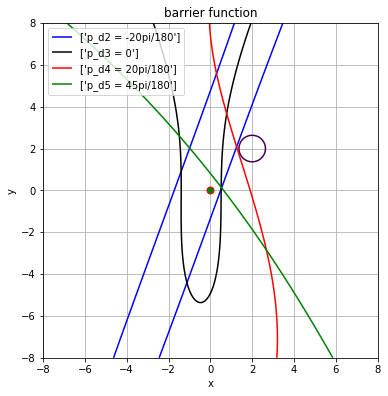

In [37]:
# draw the lyapunov function 
f = plt.figure()
plt.plot(0.0, 0.0, marker="o", markersize=7, markeredgecolor="red", markerfacecolor="green")
plt.grid()


X = np.linspace(-8.0, 8.0, 1000)
Y = np.linspace(-8.0, 8.0, 1000)
x, y = np.meshgrid(X,Y)
F_0 = (x - 2.0)**2 + (y - 2.0)**2 - 0.4
#F_1 = 
F_2 = -1 + x**2*(1.71535252189452e-7*x**2 - 2.10317447326986e-7*x*y - 1.66819417557095e-7*x - 7.34270286147546e-7*y**2 - 1.44774664874618e-6*y + 0.293614401533105) + 0.293614401533105*x**2 + x*y*(-2.10317447326986e-7*x**2 - 1.53082160448573e-6*x*y - 1.48486125567295e-6*x - 1.95714042187513e-7*y**2 - 1.70252238050646e-5*y - 0.214478069737856) - 0.214478069737856*x*y + x*(-1.66819417557095e-7*x**2 - 1.48486125567295e-6*x*y + 0.587228751728979*x - 1.70249096116486e-5*y**2 - 0.214478068450721*y + 0.723853751067908) + 0.723853751067908*x + y**2*(-7.34270286147546e-7*x**2 - 1.95714042187513e-7*x*y - 1.70249096116486e-5*x - 1.54944084845741e-7*y**2 - 8.05164893604692e-5*y + 0.0390218139392264) + 0.0390218139392264*y**2 + y*(-1.44774664874618e-6*x**2 - 1.70252238050646e-5*x*y - 0.214478068450721*x - 8.05164893604692e-5*y**2 + 0.078043529816072*y - 0.264135751326981) - 0.264135751326981*y + 4.67670772334984e-7
F_3 = -1 + x**2*(5.08872071728835e-6*x**2 + 1.74150957248299e-6*x*y + 9.76444865027008e-7*x + 3.09879185210741e-7*y**2 + 4.7900356338181e-7*y + 0.347705061604314) + 0.347705061604314*x**2 + x*y*(1.74150957248299e-6*x**2 + 6.12905275214672e-7*x*y + 4.81867875480967e-7*x + 1.68610140854005e-7*y**2 + 4.12408006244593e-6*y - 0.00416186848835395) - 0.00416186848835395*x*y + x*(9.76444865027008e-7*x**2 + 4.81867875480967e-7*x*y + 0.695410107139001*x + 4.12388635839784e-6*y**2 - 0.00416186744609004*y + 0.60931337164936) + 0.60931337164936*x + y**2*(3.09879185210741e-7*x**2 + 1.68610140854005e-7*x*y + 4.12388635839784e-6*x - 2.00624236915147e-7*y**2 - 0.00523990019380557*y - 0.00338365235163008) - 0.00338365235163008*y**2 + y*(4.7900356338181e-7*x**2 + 4.12408006244593e-6*x*y - 0.00416186744609004*x - 0.00523990019380557*y**2 - 0.00676730733996405*y - 0.00768704063719601) - 0.00768704063719601*y + 1.67462799370298e-7
F_4 = -1 + x**2*(-2.0663347948071e-7*x**2 - 1.2216630298624e-7*x*y - 1.91323280525975e-7*x - 1.0181471681587e-7*y**2 - 3.42700997168462e-7*y - 0.000433220422368696) - 0.000433220422368696*x**2 + x*y*(-1.2216630298624e-7*x**2 - 1.32033734630217e-7*x*y - 3.27874782993486e-7*x + 1.82646024414898e-8*y**2 + 1.64934456769555e-5*y - 0.00212586263986344) - 0.00212586263986344*x*y + x*(-1.91323280525975e-7*x**2 - 3.27874782993486e-7*x*y - 0.000866441051284849*x + 1.64934141288549e-5*y**2 - 0.00212586268912907*y + 0.264298094497812) + 0.264298094497812*x + y**2*(-1.0181471681587e-7*x**2 + 1.82646024414898e-8*x*y + 1.64934141288549e-5*x + 1.65493557896766e-7*y**2 - 0.000432931558310336*y + 0.000249414550365589) + 0.000249414550365589*y**2 + y*(-3.42700997168462e-7*x**2 + 1.64934456769555e-5*x*y - 0.00212586268912907*x - 0.000432931558310336*y**2 + 0.000498828856531975*y + 0.08744172017236) + 0.08744172017236*y + 3.70762954065786e-10
F_5 = -1 + x**2*(-1.0022855026957e-7*x**2 - 7.34231536154735e-8*x*y + 5.13019732756393e-8*x - 2.22998458332673e-8*y**2 + 2.79462736737721e-8*y - 0.000467903859924241) - 0.000467903859924241*x**2 + x*y*(-7.34231536154735e-8*x**2 - 4.67308671747888e-8*x*y + 2.74749392612451e-8*x - 3.42497948620814e-10*y**2 - 7.76470606495713e-6*y - 5.27367634399739e-6) - 5.27367634399739e-6*x*y + x*(5.13019732756393e-8*x**2 + 2.74749392612451e-8*x*y - 0.000935806960991181*x - 7.76544174869706e-6*y**2 - 5.27358357799813e-6*y + 0.7898367234524) + 0.7898367234524*x + y**2*(-2.22998458332673e-8*x**2 - 3.42497948620814e-10*x*y - 7.76544174869706e-6*x - 1.96211735692656e-7*y**2 + 0.000373748510278182*y + 0.00728707192663998) + 0.00728707192663998*y**2 + y*(2.79462736737721e-8*x**2 - 7.76470606495713e-6*x*y - 5.27358357799813e-6*x + 0.000373748510278182*y**2 + 0.0145741442931003*y + 0.603387105924365) + 0.603387105924365*y + 1.65469541853483e-8



plt.contour(x,y,F_0,[0])

# p_d2
CS2 = plt.contour(x,y,F_2,[0],colors = ['blue'])
label2 = ['p_d2 = -20pi/180']
CS2.collections[0].set_label(label2)

# p_d3
CS3 = plt.contour(x,y,F_3,[0],colors = ['black'])
label3 = ['p_d3 = 0']
CS3.collections[0].set_label(label3)

# p_d4
CS4 = plt.contour(x,y,F_4,[0],colors = ['red'])
label4 = ['p_d4 = 20pi/180']
CS4.collections[0].set_label(label4)

# p_d5
CS5 = plt.contour(x,y,F_5,[0],colors = ['green'])
label5 = ['p_d5 = 45pi/180']
CS5.collections[0].set_label(label5)

plt.xlabel('x')
plt.ylabel('y')
#plt.axis('equal')
plt.legend(loc='upper left')
plt.title("barrier function")
plt.gca().set_aspect('equal', adjustable='box')
f.set_figheight(15)
plt.show()

In [40]:
# ax + by = c
def lineFromPoints(P, Q):
    a = Q[1] - P[1]
    b = P[0] - Q[0]
    c = a*(P[0]) + b*(P[1])
    
    return a,b,c

[[ 3.1886  -3.81288]
 [ 4.21067 -4.26765]
 [ 3.7997  -3.9225 ]
 [ 3.40957 -3.743  ]]
before
[[-0.45477 -1.02207]
 [ 0.34515  0.41097]
 [ 0.1795   0.39013]
 [ 0.06988 -0.22097]]
[[-2.44695064]
 [ 0.30056337]
 [ 0.84823878]
 [-1.06535146]]
[-4.4408921e-16]
final A and b for half space constraint
[[ 0.45477  1.02207]
 [-0.34515 -0.41097]
 [-0.1795  -0.39013]
 [ 0.06988 -0.22097]]
[[ 2.44695064]
 [-0.30056337]
 [-0.84823878]
 [-1.06535146]]


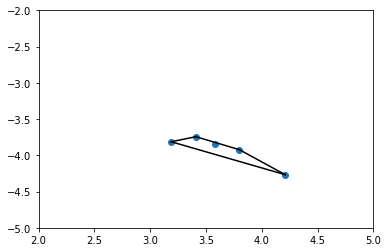

In [114]:
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.xlim(2.0,5.0)
plt.ylim(-5,-2)


# get point from convexhull for polytopic inequ
vertice_points = hull.vertices
#print(vertice_points)

# store points in counter-clockwise
convex_points = []
for i in range(len(vertice_points)):
    convex_points = np.append(convex_points,points[vertice_points[i]])

convex_points = np.reshape(convex_points,(4,2))
print(convex_points)


# get every line equation for generating half space inequaility
a,b,c = lineFromPoints(convex_points[0],convex_points[1])

a_arr = []
b_arr = []
c_arr = []


for i in range(len(convex_points)-1):
    a,b,c = lineFromPoints(convex_points[i],convex_points[i+1])
    a_arr = np.append(a_arr,a)
    b_arr = np.append(b_arr,b)
    c_arr = np.append(c_arr,c)

# store last one
a,b,c = lineFromPoints(convex_points[0],convex_points[len(convex_points)-1])
a_arr = np.append(a_arr,a)
b_arr = np.append(b_arr,b)
c_arr = np.append(c_arr,c)
#print(a_arr)

A = np.zeros((len(convex_points),2))
b = np.zeros((len(convex_points),1))

for i in range(len(a_arr)):
    A[i][0] = a_arr[i]
    A[i][1] = b_arr[i]
    b[i][0] = c_arr[i]

print("before")
print(A)
# make to ax + by + c = 0 
c = - b
print(c)
vector_x = np.array([convex_points[1]]).transpose()
print(A[0] @ vector_x + c[0])
# loop through any other point not on line
# basicially check if ax + by + c >= 0 for all points
for i in range(len(a_arr)):
    for j in range(len(a_arr)):
        if not A[i][0] * convex_points[j][0] + A[i][1] * convex_points[j][1] + c[i] >= -1e-5:
            # if there is one point does not satisfies the inequaility, change sign
            A[i][0] = -A[i][0]
            A[i][1] = -A[i][1]
            c[i] = - c[i]
            break

            
print("final A and b for half space constraint")
print(A)
print(c)
        



In [135]:

vector_x = np.array([convex_points[3]]).transpose()
print(vector_x)

#print(A[3])
print(A @ vector_x + c)

[[ 3.40957]
 [-3.743  ]]
[[ 1.71912778e-01]
 [ 6.08842545e-02]
 [-1.11022302e-16]
 [-2.22044605e-16]]


In [267]:
# same version but using polytope constraints
x,y,p = sympy.symbols('x y p')
K = 50
V = 1.0
p_d1 = -45*np.pi/180
p_d2 = -20*np.pi/180
p_d3 = 0
p_d4 = 20*np.pi/180
p_d5 = 45*np.pi/180

# use current angle
angle = -1.19

# taylor approximation around 0 (should be changed later)
# change dynamics to match with global 
f = sympy.Matrix([[V*math.cos(angle) - (V*math.cos(angle)/2)*p**2],[V*math.cos(angle)*p - (V*math.cos(angle))/6*p**3],[-K*(p - p_d5)]])
#print(f_1)
#print(f_2)
# polynomial basis
b1 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b1 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b1 = sympy.Matrix([[1,x,y,p]]).transpose()


Q = sympy.MatrixSymbol('Q',10,10)
#Q = sympy.MatrixSymbol('Q',4,4)
#Q = sympy.MatrixSymbol('Q',9,9)


# partial derivative
db1_dx = sympy.diff(b1,x)
#print(db1_dx)
db1_dy = sympy.diff(b1,y)
db1_dp = sympy.diff(b1,p)


########## parameterization step
# V
V = (b1.T @ Q @ b1).as_explicit()
SOS_V_para_poly = sympy.Poly(V[0],x,y,p)
B = sympy.Matrix([
            [db1_dx, db1_dy,db1_dp]])
#print(B.shape)
ne_Vdot_compute = (- 2 * b1.T @ Q @ B @ f).as_explicit()
ne_Vdot_compute_poly = sympy.Poly(ne_Vdot_compute[0],x, y, p)

#print('check coeff of ne_Vdot_compute_poly:')
#print(ne_Vdot_compute_poly)
    

# -V_dot
#b2 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
b2 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b2 = sympy.Matrix([[1,x,y,p]]).transpose()
#G = sympy.MatrixSymbol('G', 4, 4)
G = sympy.MatrixSymbol('G', 10, 10)
#G = G = sympy.MatrixSymbol('G', 9, 9)
SOS_of_ne_V_dot = (b2.T @ G @ b2).as_explicit()
SOS_of_ne_V_dot_poly = sympy.Poly(SOS_of_ne_V_dot[0], x, y, p)

#print('\ncheck coeff of SOS_of_ne_V_dot_poly:')
#print(SOS_of_ne_V_dot_poly)

b2_sqr = [b*b for b in b2]
for b_sqr in b2_sqr:
    coeff = SOS_of_ne_V_dot_poly.coeff_monomial(b_sqr)
    if coeff is sympy.S.Zero:
        print('WARNING: digonal coeff is zero for',b_sqr, ' not PSD for sure!')


# define a vector of largrange multiplier
multi_vector = []
J = []
b3 = sympy.Matrix([[1,x,y,p]]).transpose()
SOS_mutiplier_para_v = []
for i in range(len(a_arr)):
    J = sympy.MatrixSymbol('J{}'.format(i),4,4)
    SOS_mutiplier_para = (b3.T @ J @ b3).as_explicit()
    SOS_mutiplier_para_v = np.append(SOS_mutiplier_para_v,SOS_mutiplier_para)
    
SOS_mutiplier_para_v = np.reshape(SOS_mutiplier_para_v,(1,4))
#print(SOS_mutiplier_para_v[0][3])

### dealing with obstacle constraint SOS

# obstacle constraint SOS paratrization
b4 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b4 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b4 = sympy.Matrix([[1,x,y,p]]).transpose()
#M = sympy.MatrixSymbol('M',10,10)
M = sympy.MatrixSymbol('M',10,10)
#M = sympy.MatrixSymbol('M',4,4)
SOS_constraint_para = (b4.T @ M @ b4).as_explicit()
SOS_constraint_para_poly = sympy.Poly(SOS_constraint_para[0],x,y,p)


print('\ncheck coeff of SOS_constraint_para_poly:{}'.format(SOS_constraint_para_poly))


vector_x = sympy.Matrix([[x,y]]).transpose()
# obstacle constraint SOS computed from V and multiplier
epsilon_1 = 1e-6
SOS_mutiplier_para_poly_v = sympy.Poly((SOS_mutiplier_para_v @ (A @ vector_x + c))[0],x,y,p)

SOS_constraint_compute_poly = SOS_V_para_poly - (1 + epsilon_1) - SOS_mutiplier_para_poly_v
#print(SOS_constraint_compute_poly)
constraint_list_V_Vdot = []
constraint_list_obstacle = []


print('\ncheck coeff of SOS_constraint_compute_poly:{}'.format(SOS_constraint_compute_poly))

max_order = 10
# deal with V and -V_dot adding coeff matching constraint
for x_order in range(0,max_order+1):
    for y_order in range(0,max_order + 1):
        for p_order in range(0,max_order + 1):
            monomial = (x**x_order)*(y**y_order)*(p**p_order)
            # check if b2.T @ G b2 has coeff
            coeff_V_dot_para = SOS_of_ne_V_dot_poly.coeff_monomial(monomial)
            #print('coeff for {} in SOS_of_ne_V_dot_poly is {}'.format(monomial,coeff_V_dot_para))
            # check if - 2 * b1.T @ Q @ B @ f has coeff
            coeff_V_dot_compu = ne_Vdot_compute_poly.coeff_monomial(monomial)
            #print('coeff for {} in ne_Vdot_compute_poly is {}'.format(monomial,coeff_V_dot_compu))
            
            # continue if both do not contain
            if coeff_V_dot_para is sympy.S.Zero and coeff_V_dot_compu is sympy.S.Zero:
                continue
            
            ## should be modified
            if coeff_V_dot_para is sympy.S.Zero and not coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_V_dot_compu)
                constraint_list_V_Vdot.append(constrain)
            ## should be modified
            if not coeff_V_dot_para is sympy.S.Zero and coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_V_dot_para)
                constraint_list_V_Vdot.append(constrain)
                
            if not coeff_V_dot_para is sympy.S.Zero and not coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}=={}'.format(coeff_V_dot_compu,coeff_V_dot_para)
                constraint_list_V_Vdot.append(constrain)

            
print('\nConstraints V_Vdot (copy):', ','.join(constraint_list_V_Vdot))                

# delta with obstacle SOS coeff matching
for x_order in range(0,max_order+1):
    for y_order in range(0,max_order + 1):
        for p_order in range(0,max_order + 1):
            monomial = (x**x_order)*(y**y_order)*(p**p_order)
            
            coeff_constraint_para = SOS_constraint_para_poly.coeff_monomial(monomial)
            coeff_constraint_compute = SOS_constraint_compute_poly.coeff_monomial(monomial)
            
            if coeff_constraint_para is sympy.S.Zero and coeff_constraint_compute is sympy.S.Zero:
                #print(monomial)
                continue
            
            ## should be modified
            if coeff_constraint_para is sympy.S.Zero and not coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_constraint_compute)
                constraint_list_obstacle.append(constrain)
            ## should be modified
            if not coeff_constraint_para is sympy.S.Zero and coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_constraint_para)
                constraint_list_obstacle.append(constrain)
                
            if not coeff_constraint_para is sympy.S.Zero and not coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}=={}'.format(coeff_constraint_compute,coeff_constraint_para)
                constraint_list_obstacle.append(constrain)

print('\nConstraints obstacle SOS (copy):', ','.join(constraint_list_obstacle))



check coeff of SOS_constraint_para_poly:Poly(M[4, 4]*x**4 + (M[4, 5] + M[5, 4])*x**3*y + (M[4, 7] + M[7, 4])*x**3*p + (M[1, 4] + M[4, 1])*x**3 + (M[4, 6] + M[5, 5] + M[6, 4])*x**2*y**2 + (M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4])*x**2*y*p + (M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1])*x**2*y + (M[4, 9] + M[7, 7] + M[9, 4])*x**2*p**2 + (M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1])*x**2*p + (M[0, 4] + M[1, 1] + M[4, 0])*x**2 + (M[5, 6] + M[6, 5])*x*y**3 + (M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5])*x*y**2*p + (M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1])*x*y**2 + (M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5])*x*y*p**2 + (M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1])*x*y*p + (M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0])*x*y + (M[7, 9] + M[9, 7])*x*p**3 + (M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1])*x*p**2 + (M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0])*x*p + (M[0, 1] + M[1, 0])*x + M[6, 6]*y**4 + (M[6, 8] + M[8, 6])*y**3*p + (M[2, 6] + M[6, 2])*y**3 + (M[6, 9] + M[8, 8] + M[9, 6])*y**2*p**2 + (M[2, 8] + M[3, 6] + M[6, 3] 


Constraints obstacle SOS (copy): -2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3]

In [146]:
# solve SOS as SDP based on constraint obtained earilier
Q = cp.Variable((10,10), symmetric=True)
G = cp.Variable((10,10), symmetric=True)
M = cp.Variable((10,10), symmetric = True)



# create multipliers (should be changed later based on number of convex points)
J0 = cp.Variable((4,4), symmetric = True)
J1 = cp.Variable((4,4), symmetric = True)
J2 = cp.Variable((4,4), symmetric = True)
J3 = cp.Variable((4,4), symmetric = True)


# make sure positive definite , sufficient condition
#epsilon = 1e-8
#constraints = [Q >> 0]
constraints = [G >> 0]
constraints += [M >> 0]

constraints += [J0 >> 0]
constraints += [J1 >> 0]
constraints += [J2 >> 0]
constraints += [J3 >> 0]



# equaility constraint for initial condition
x_0 = 3.572468
y_0 = -2.9473
p_0 = -1.19

b_0 = np.array([[1,x_0,y_0,p_0,x_0**2,x_0*y_0,y_0**2,x_0*p_0,y_0*p_0,p_0**2]]).transpose()
#print(b_0.T @ Q @ b_0)
#b1 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#constraints += 

constraints += [b_0.T @ Q @ b_0 == 0]


# V Vdot coeff matching constraint

# p_d1
#constraints += [-0.743319744521066*Q[0, 1] + 78.5398163397448*Q[0, 3]==G[0, 0],-0.743319744521066*Q[0, 2] + 100*Q[0, 3] - 0.743319744521066*Q[0, 7] + 157.07963267949*Q[0, 9] - 0.743319744521066*Q[3, 1] + 78.5398163397448*Q[3, 3]==G[0, 3] + G[3, 0],0.371659872260533*Q[0, 1] - 0.743319744521066*Q[0, 8] + 200*Q[0, 9] - 0.743319744521066*Q[3, 2] + 100*Q[3, 3] - 0.743319744521066*Q[3, 7] + 157.07963267949*Q[3, 9] - 0.743319744521066*Q[9, 1] + 78.5398163397448*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],0.123886624086844*Q[0, 2] + 0.371659872260533*Q[0, 7] + 0.371659872260533*Q[3, 1] - 0.743319744521066*Q[3, 8] + 200*Q[3, 9] - 0.743319744521066*Q[9, 2] + 100*Q[9, 3] - 0.743319744521066*Q[9, 7] + 157.07963267949*Q[9, 9]==G[3, 9] + G[9, 3],0.123886624086844*Q[0, 8] + 0.123886624086844*Q[3, 2] + 0.371659872260533*Q[3, 7] + 0.371659872260533*Q[9, 1] - 0.743319744521066*Q[9, 8] + 200*Q[9, 9]==G[9, 9],0.123886624086844*Q[3, 8] + 0.123886624086844*Q[9, 2] + 0.371659872260533*Q[9, 7]==0.,0.123886624086844*Q[9, 8]==0.,-0.743319744521066*Q[0, 5] + 78.5398163397448*Q[0, 8] - 0.743319744521066*Q[2, 1] + 78.5398163397448*Q[2, 3]==G[0, 2] + G[2, 0],-1.48663948904213*Q[0, 6] + 100*Q[0, 8] - 0.743319744521066*Q[2, 2] + 100*Q[2, 3] - 0.743319744521066*Q[2, 7] + 157.07963267949*Q[2, 9] - 0.743319744521066*Q[3, 5] + 78.5398163397448*Q[3, 8] - 0.743319744521066*Q[8, 1] + 78.5398163397448*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],0.371659872260533*Q[0, 5] + 0.371659872260533*Q[2, 1] - 0.743319744521066*Q[2, 8] + 200*Q[2, 9] - 1.48663948904213*Q[3, 6] + 100*Q[3, 8] - 0.743319744521066*Q[8, 2] + 100*Q[8, 3] - 0.743319744521066*Q[8, 7] + 157.07963267949*Q[8, 9] - 0.743319744521066*Q[9, 5] + 78.5398163397448*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],0.247773248173689*Q[0, 6] + 0.123886624086844*Q[2, 2] + 0.371659872260533*Q[2, 7] + 0.371659872260533*Q[3, 5] + 0.371659872260533*Q[8, 1] - 0.743319744521066*Q[8, 8] + 200*Q[8, 9] - 1.48663948904213*Q[9, 6] + 100*Q[9, 8]==G[8, 9] + G[9, 8],0.123886624086844*Q[2, 8] + 0.247773248173689*Q[3, 6] + 0.123886624086844*Q[8, 2] + 0.371659872260533*Q[8, 7] + 0.371659872260533*Q[9, 5]==0.,0.123886624086844*Q[8, 8] + 0.247773248173689*Q[9, 6]==0.,-0.743319744521066*Q[2, 5] + 78.5398163397448*Q[2, 8] - 0.743319744521066*Q[6, 1] + 78.5398163397448*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],-1.48663948904213*Q[2, 6] + 100*Q[2, 8] - 0.743319744521066*Q[6, 2] + 100*Q[6, 3] - 0.743319744521066*Q[6, 7] + 157.07963267949*Q[6, 9] - 0.743319744521066*Q[8, 5] + 78.5398163397448*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],0.371659872260533*Q[2, 5] + 0.371659872260533*Q[6, 1] - 0.743319744521066*Q[6, 8] + 200*Q[6, 9] - 1.48663948904213*Q[8, 6] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],0.247773248173689*Q[2, 6] + 0.123886624086844*Q[6, 2] + 0.371659872260533*Q[6, 7] + 0.371659872260533*Q[8, 5]==0.,0.123886624086844*Q[6, 8] + 0.247773248173689*Q[8, 6]==0.,-0.743319744521066*Q[6, 5] + 78.5398163397448*Q[6, 8]==G[2, 6] + G[6, 2],-1.48663948904213*Q[6, 6] + 100*Q[6, 8]==G[6, 8] + G[8, 6],0.371659872260533*Q[6, 5]==0.,0.247773248173689*Q[6, 6]==0.,G[6, 6]==0.,-1.48663948904213*Q[0, 4] + 78.5398163397448*Q[0, 7] - 0.743319744521066*Q[1, 1] + 78.5398163397448*Q[1, 3]==G[0, 1] + G[1, 0],-0.743319744521066*Q[0, 5] + 100*Q[0, 7] - 0.743319744521066*Q[1, 2] + 100*Q[1, 3] - 0.743319744521066*Q[1, 7] + 157.07963267949*Q[1, 9] - 1.48663948904213*Q[3, 4] + 78.5398163397448*Q[3, 7] - 0.743319744521066*Q[7, 1] + 78.5398163397448*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],0.743319744521066*Q[0, 4] + 0.371659872260533*Q[1, 1] - 0.743319744521066*Q[1, 8] + 200*Q[1, 9] - 0.743319744521066*Q[3, 5] + 100*Q[3, 7] - 0.743319744521066*Q[7, 2] + 100*Q[7, 3] - 0.743319744521066*Q[7, 7] + 157.07963267949*Q[7, 9] - 1.48663948904213*Q[9, 4] + 78.5398163397448*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],0.123886624086844*Q[0, 5] + 0.123886624086844*Q[1, 2] + 0.371659872260533*Q[1, 7] + 0.743319744521066*Q[3, 4] + 0.371659872260533*Q[7, 1] - 0.743319744521066*Q[7, 8] + 200*Q[7, 9] - 0.743319744521066*Q[9, 5] + 100*Q[9, 7]==G[7, 9] + G[9, 7],0.123886624086844*Q[1, 8] + 0.123886624086844*Q[3, 5] + 0.123886624086844*Q[7, 2] + 0.371659872260533*Q[7, 7] + 0.743319744521066*Q[9, 4]==0.,0.123886624086844*Q[7, 8] + 0.123886624086844*Q[9, 5]==0.,-0.743319744521066*Q[1, 5] + 78.5398163397448*Q[1, 8] - 1.48663948904213*Q[2, 4] + 78.5398163397448*Q[2, 7] - 0.743319744521066*Q[5, 1] + 78.5398163397448*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],-1.48663948904213*Q[1, 6] + 100*Q[1, 8] - 0.743319744521066*Q[2, 5] + 100*Q[2, 7] - 0.743319744521066*Q[5, 2] + 100*Q[5, 3] - 0.743319744521066*Q[5, 7] + 157.07963267949*Q[5, 9] - 0.743319744521066*Q[7, 5] + 78.5398163397448*Q[7, 8] - 1.48663948904213*Q[8, 4] + 78.5398163397448*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],0.371659872260533*Q[1, 5] + 0.743319744521066*Q[2, 4] + 0.371659872260533*Q[5, 1] - 0.743319744521066*Q[5, 8] + 200*Q[5, 9] - 1.48663948904213*Q[7, 6] + 100*Q[7, 8] - 0.743319744521066*Q[8, 5] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],0.247773248173689*Q[1, 6] + 0.123886624086844*Q[2, 5] + 0.123886624086844*Q[5, 2] + 0.371659872260533*Q[5, 7] + 0.371659872260533*Q[7, 5] + 0.743319744521066*Q[8, 4]==0.,0.123886624086844*Q[5, 8] + 0.247773248173689*Q[7, 6] + 0.123886624086844*Q[8, 5]==0.,-0.743319744521066*Q[5, 5] + 78.5398163397448*Q[5, 8] - 1.48663948904213*Q[6, 4] + 78.5398163397448*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],-1.48663948904213*Q[5, 6] + 100*Q[5, 8] - 0.743319744521066*Q[6, 5] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],0.371659872260533*Q[5, 5] + 0.743319744521066*Q[6, 4]==0.,0.247773248173689*Q[5, 6] + 0.123886624086844*Q[6, 5]==0.,G[5, 6] + G[6, 5]==0.,-1.48663948904213*Q[1, 4] + 78.5398163397448*Q[1, 7] - 0.743319744521066*Q[4, 1] + 78.5398163397448*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],-0.743319744521066*Q[1, 5] + 100*Q[1, 7] - 0.743319744521066*Q[4, 2] + 100*Q[4, 3] - 0.743319744521066*Q[4, 7] + 157.07963267949*Q[4, 9] - 1.48663948904213*Q[7, 4] + 78.5398163397448*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],0.743319744521066*Q[1, 4] + 0.371659872260533*Q[4, 1] - 0.743319744521066*Q[4, 8] + 200*Q[4, 9] - 0.743319744521066*Q[7, 5] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],0.123886624086844*Q[1, 5] + 0.123886624086844*Q[4, 2] + 0.371659872260533*Q[4, 7] + 0.743319744521066*Q[7, 4]==0.,0.123886624086844*Q[4, 8] + 0.123886624086844*Q[7, 5]==0.,-0.743319744521066*Q[4, 5] + 78.5398163397448*Q[4, 8] - 1.48663948904213*Q[5, 4] + 78.5398163397448*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],-1.48663948904213*Q[4, 6] + 100*Q[4, 8] - 0.743319744521066*Q[5, 5] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],0.371659872260533*Q[4, 5] + 0.743319744521066*Q[5, 4]==0.,0.247773248173689*Q[4, 6] + 0.123886624086844*Q[5, 5]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-1.48663948904213*Q[4, 4] + 78.5398163397448*Q[4, 7]==G[1, 4] + G[4, 1],-0.743319744521066*Q[4, 5] + 100*Q[4, 7]==G[4, 7] + G[7, 4],0.743319744521066*Q[4, 4]==0.,0.123886624086844*Q[4, 5]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [-2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3] - 1.02207*J0[3, 0] - 2.4469506396*J0[3, 2] + 0.41097*J1[0, 3] + 0.300563370000002*J1[2, 3] + 0.41097*J1[3, 0] + 0.300563370000002*J1[3, 2] + 0.39013*J2[0, 3] + 0.848238775*J2[2, 3] + 0.39013*J2[3, 0] + 0.848238775*J2[3, 2] + 0.22097*J3[0, 3] + 1.0653514616*J3[2, 3] + 0.22097*J3[3, 0] + 1.0653514616*J3[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-1.02207*J0[3, 3] + 0.41097*J1[3, 3] + 0.39013*J2[3, 3] + 0.22097*J3[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],-1.02207*J0[0, 2] - 1.02207*J0[2, 0] - 2.4469506396*J0[2, 2] + 0.41097*J1[0, 2] + 0.41097*J1[2, 0] + 0.300563370000002*J1[2, 2] + 0.39013*J2[0, 2] + 0.39013*J2[2, 0] + 0.848238775*J2[2, 2] + 0.22097*J3[0, 2] + 0.22097*J3[2, 0] + 1.0653514616*J3[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],-1.02207*J0[2, 3] - 1.02207*J0[3, 2] + 0.41097*J1[2, 3] + 0.41097*J1[3, 2] + 0.39013*J2[2, 3] + 0.39013*J2[3, 2] + 0.22097*J3[2, 3] + 0.22097*J3[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],Q[6, 9] + Q[8, 8] + Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],-1.02207*J0[2, 2] + 0.41097*J1[2, 2] + 0.39013*J2[2, 2] + 0.22097*J3[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],Q[6, 8] + Q[8, 6]==M[6, 8] + M[8, 6],Q[6, 6]==M[6, 6],-0.45477*J0[0, 0] - 2.4469506396*J0[0, 1] - 2.4469506396*J0[1, 0] + 0.34515*J1[0, 0] + 0.300563370000002*J1[0, 1] + 0.300563370000002*J1[1, 0] + 0.1795*J2[0, 0] + 0.848238775*J2[0, 1] + 0.848238775*J2[1, 0] - 0.0698799999999999*J3[0, 0] + 1.0653514616*J3[0, 1] + 1.0653514616*J3[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-0.45477*J0[0, 3] - 2.4469506396*J0[1, 3] - 0.45477*J0[3, 0] - 2.4469506396*J0[3, 1] + 0.34515*J1[0, 3] + 0.300563370000002*J1[1, 3] + 0.34515*J1[3, 0] + 0.300563370000002*J1[3, 1] + 0.1795*J2[0, 3] + 0.848238775*J2[1, 3] + 0.1795*J2[3, 0] + 0.848238775*J2[3, 1] - 0.0698799999999999*J3[0, 3] + 1.0653514616*J3[1, 3] - 0.0698799999999999*J3[3, 0] + 1.0653514616*J3[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-0.45477*J0[3, 3] + 0.34515*J1[3, 3] + 0.1795*J2[3, 3] - 0.0698799999999999*J3[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-1.02207*J0[0, 1] - 0.45477*J0[0, 2] - 1.02207*J0[1, 0] - 2.4469506396*J0[1, 2] - 0.45477*J0[2, 0] - 2.4469506396*J0[2, 1] + 0.41097*J1[0, 1] + 0.34515*J1[0, 2] + 0.41097*J1[1, 0] + 0.300563370000002*J1[1, 2] + 0.34515*J1[2, 0] + 0.300563370000002*J1[2, 1] + 0.39013*J2[0, 1] + 0.1795*J2[0, 2] + 0.39013*J2[1, 0] + 0.848238775*J2[1, 2] + 0.1795*J2[2, 0] + 0.848238775*J2[2, 1] + 0.22097*J3[0, 1] - 0.0698799999999999*J3[0, 2] + 0.22097*J3[1, 0] + 1.0653514616*J3[1, 2] - 0.0698799999999999*J3[2, 0] + 1.0653514616*J3[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-1.02207*J0[1, 3] - 0.45477*J0[2, 3] - 1.02207*J0[3, 1] - 0.45477*J0[3, 2] + 0.41097*J1[1, 3] + 0.34515*J1[2, 3] + 0.41097*J1[3, 1] + 0.34515*J1[3, 2] + 0.39013*J2[1, 3] + 0.1795*J2[2, 3] + 0.39013*J2[3, 1] + 0.1795*J2[3, 2] + 0.22097*J3[1, 3] - 0.0698799999999999*J3[2, 3] + 0.22097*J3[3, 1] - 0.0698799999999999*J3[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],-1.02207*J0[1, 2] - 1.02207*J0[2, 1] - 0.45477*J0[2, 2] + 0.41097*J1[1, 2] + 0.41097*J1[2, 1] + 0.34515*J1[2, 2] + 0.39013*J2[1, 2] + 0.39013*J2[2, 1] + 0.1795*J2[2, 2] + 0.22097*J3[1, 2] + 0.22097*J3[2, 1] - 0.0698799999999999*J3[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],Q[5, 8] + Q[6, 7] + Q[7, 6] + Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],Q[5, 6] + Q[6, 5]==M[5, 6] + M[6, 5],-0.45477*J0[0, 1] - 0.45477*J0[1, 0] - 2.4469506396*J0[1, 1] + 0.34515*J1[0, 1] + 0.34515*J1[1, 0] + 0.300563370000002*J1[1, 1] + 0.1795*J2[0, 1] + 0.1795*J2[1, 0] + 0.848238775*J2[1, 1] - 0.0698799999999999*J3[0, 1] - 0.0698799999999999*J3[1, 0] + 1.0653514616*J3[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],-0.45477*J0[1, 3] - 0.45477*J0[3, 1] + 0.34515*J1[1, 3] + 0.34515*J1[3, 1] + 0.1795*J2[1, 3] + 0.1795*J2[3, 1] - 0.0698799999999999*J3[1, 3] - 0.0698799999999999*J3[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],Q[4, 9] + Q[7, 7] + Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],-1.02207*J0[1, 1] - 0.45477*J0[1, 2] - 0.45477*J0[2, 1] + 0.41097*J1[1, 1] + 0.34515*J1[1, 2] + 0.34515*J1[2, 1] + 0.39013*J2[1, 1] + 0.1795*J2[1, 2] + 0.1795*J2[2, 1] + 0.22097*J3[1, 1] - 0.0698799999999999*J3[1, 2] - 0.0698799999999999*J3[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],Q[4, 8] + Q[5, 7] + Q[7, 5] + Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],Q[4, 6] + Q[5, 5] + Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],-0.45477*J0[1, 1] + 0.34515*J1[1, 1] + 0.1795*J2[1, 1] - 0.0698799999999999*J3[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],Q[4, 7] + Q[7, 4]==M[4, 7] + M[7, 4],Q[4, 5] + Q[5, 4]==M[4, 5] + M[5, 4],Q[4, 4]==M[4, 4]]

# p_d2
#constraints += [-0.743319744521066*Q[0, 1] + 34.9065850398866*Q[0, 3]==G[0, 0],-0.743319744521066*Q[0, 2] + 100*Q[0, 3] - 0.743319744521066*Q[0, 7] + 69.8131700797732*Q[0, 9] - 0.743319744521066*Q[3, 1] + 34.9065850398866*Q[3, 3]==G[0, 3] + G[3, 0],0.371659872260533*Q[0, 1] - 0.743319744521066*Q[0, 8] + 200*Q[0, 9] - 0.743319744521066*Q[3, 2] + 100*Q[3, 3] - 0.743319744521066*Q[3, 7] + 69.8131700797732*Q[3, 9] - 0.743319744521066*Q[9, 1] + 34.9065850398866*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],0.123886624086844*Q[0, 2] + 0.371659872260533*Q[0, 7] + 0.371659872260533*Q[3, 1] - 0.743319744521066*Q[3, 8] + 200*Q[3, 9] - 0.743319744521066*Q[9, 2] + 100*Q[9, 3] - 0.743319744521066*Q[9, 7] + 69.8131700797732*Q[9, 9]==G[3, 9] + G[9, 3],0.123886624086844*Q[0, 8] + 0.123886624086844*Q[3, 2] + 0.371659872260533*Q[3, 7] + 0.371659872260533*Q[9, 1] - 0.743319744521066*Q[9, 8] + 200*Q[9, 9]==G[9, 9],0.123886624086844*Q[3, 8] + 0.123886624086844*Q[9, 2] + 0.371659872260533*Q[9, 7]==0.,0.123886624086844*Q[9, 8]==0.,-0.743319744521066*Q[0, 5] + 34.9065850398866*Q[0, 8] - 0.743319744521066*Q[2, 1] + 34.9065850398866*Q[2, 3]==G[0, 2] + G[2, 0],-1.48663948904213*Q[0, 6] + 100*Q[0, 8] - 0.743319744521066*Q[2, 2] + 100*Q[2, 3] - 0.743319744521066*Q[2, 7] + 69.8131700797732*Q[2, 9] - 0.743319744521066*Q[3, 5] + 34.9065850398866*Q[3, 8] - 0.743319744521066*Q[8, 1] + 34.9065850398866*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],0.371659872260533*Q[0, 5] + 0.371659872260533*Q[2, 1] - 0.743319744521066*Q[2, 8] + 200*Q[2, 9] - 1.48663948904213*Q[3, 6] + 100*Q[3, 8] - 0.743319744521066*Q[8, 2] + 100*Q[8, 3] - 0.743319744521066*Q[8, 7] + 69.8131700797732*Q[8, 9] - 0.743319744521066*Q[9, 5] + 34.9065850398866*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],0.247773248173689*Q[0, 6] + 0.123886624086844*Q[2, 2] + 0.371659872260533*Q[2, 7] + 0.371659872260533*Q[3, 5] + 0.371659872260533*Q[8, 1] - 0.743319744521066*Q[8, 8] + 200*Q[8, 9] - 1.48663948904213*Q[9, 6] + 100*Q[9, 8]==G[8, 9] + G[9, 8],0.123886624086844*Q[2, 8] + 0.247773248173689*Q[3, 6] + 0.123886624086844*Q[8, 2] + 0.371659872260533*Q[8, 7] + 0.371659872260533*Q[9, 5]==0.,0.123886624086844*Q[8, 8] + 0.247773248173689*Q[9, 6]==0.,-0.743319744521066*Q[2, 5] + 34.9065850398866*Q[2, 8] - 0.743319744521066*Q[6, 1] + 34.9065850398866*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],-1.48663948904213*Q[2, 6] + 100*Q[2, 8] - 0.743319744521066*Q[6, 2] + 100*Q[6, 3] - 0.743319744521066*Q[6, 7] + 69.8131700797732*Q[6, 9] - 0.743319744521066*Q[8, 5] + 34.9065850398866*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],0.371659872260533*Q[2, 5] + 0.371659872260533*Q[6, 1] - 0.743319744521066*Q[6, 8] + 200*Q[6, 9] - 1.48663948904213*Q[8, 6] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],0.247773248173689*Q[2, 6] + 0.123886624086844*Q[6, 2] + 0.371659872260533*Q[6, 7] + 0.371659872260533*Q[8, 5]==0.,0.123886624086844*Q[6, 8] + 0.247773248173689*Q[8, 6]==0.,-0.743319744521066*Q[6, 5] + 34.9065850398866*Q[6, 8]==G[2, 6] + G[6, 2],-1.48663948904213*Q[6, 6] + 100*Q[6, 8]==G[6, 8] + G[8, 6],0.371659872260533*Q[6, 5]==0.,0.247773248173689*Q[6, 6]==0.,G[6, 6]==0.,-1.48663948904213*Q[0, 4] + 34.9065850398866*Q[0, 7] - 0.743319744521066*Q[1, 1] + 34.9065850398866*Q[1, 3]==G[0, 1] + G[1, 0],-0.743319744521066*Q[0, 5] + 100*Q[0, 7] - 0.743319744521066*Q[1, 2] + 100*Q[1, 3] - 0.743319744521066*Q[1, 7] + 69.8131700797732*Q[1, 9] - 1.48663948904213*Q[3, 4] + 34.9065850398866*Q[3, 7] - 0.743319744521066*Q[7, 1] + 34.9065850398866*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],0.743319744521066*Q[0, 4] + 0.371659872260533*Q[1, 1] - 0.743319744521066*Q[1, 8] + 200*Q[1, 9] - 0.743319744521066*Q[3, 5] + 100*Q[3, 7] - 0.743319744521066*Q[7, 2] + 100*Q[7, 3] - 0.743319744521066*Q[7, 7] + 69.8131700797732*Q[7, 9] - 1.48663948904213*Q[9, 4] + 34.9065850398866*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],0.123886624086844*Q[0, 5] + 0.123886624086844*Q[1, 2] + 0.371659872260533*Q[1, 7] + 0.743319744521066*Q[3, 4] + 0.371659872260533*Q[7, 1] - 0.743319744521066*Q[7, 8] + 200*Q[7, 9] - 0.743319744521066*Q[9, 5] + 100*Q[9, 7]==G[7, 9] + G[9, 7],0.123886624086844*Q[1, 8] + 0.123886624086844*Q[3, 5] + 0.123886624086844*Q[7, 2] + 0.371659872260533*Q[7, 7] + 0.743319744521066*Q[9, 4]==0.,0.123886624086844*Q[7, 8] + 0.123886624086844*Q[9, 5]==0.,-0.743319744521066*Q[1, 5] + 34.9065850398866*Q[1, 8] - 1.48663948904213*Q[2, 4] + 34.9065850398866*Q[2, 7] - 0.743319744521066*Q[5, 1] + 34.9065850398866*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],-1.48663948904213*Q[1, 6] + 100*Q[1, 8] - 0.743319744521066*Q[2, 5] + 100*Q[2, 7] - 0.743319744521066*Q[5, 2] + 100*Q[5, 3] - 0.743319744521066*Q[5, 7] + 69.8131700797732*Q[5, 9] - 0.743319744521066*Q[7, 5] + 34.9065850398866*Q[7, 8] - 1.48663948904213*Q[8, 4] + 34.9065850398866*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],0.371659872260533*Q[1, 5] + 0.743319744521066*Q[2, 4] + 0.371659872260533*Q[5, 1] - 0.743319744521066*Q[5, 8] + 200*Q[5, 9] - 1.48663948904213*Q[7, 6] + 100*Q[7, 8] - 0.743319744521066*Q[8, 5] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],0.247773248173689*Q[1, 6] + 0.123886624086844*Q[2, 5] + 0.123886624086844*Q[5, 2] + 0.371659872260533*Q[5, 7] + 0.371659872260533*Q[7, 5] + 0.743319744521066*Q[8, 4]==0.,0.123886624086844*Q[5, 8] + 0.247773248173689*Q[7, 6] + 0.123886624086844*Q[8, 5]==0.,-0.743319744521066*Q[5, 5] + 34.9065850398866*Q[5, 8] - 1.48663948904213*Q[6, 4] + 34.9065850398866*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],-1.48663948904213*Q[5, 6] + 100*Q[5, 8] - 0.743319744521066*Q[6, 5] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],0.371659872260533*Q[5, 5] + 0.743319744521066*Q[6, 4]==0.,0.247773248173689*Q[5, 6] + 0.123886624086844*Q[6, 5]==0.,G[5, 6] + G[6, 5]==0.,-1.48663948904213*Q[1, 4] + 34.9065850398866*Q[1, 7] - 0.743319744521066*Q[4, 1] + 34.9065850398866*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],-0.743319744521066*Q[1, 5] + 100*Q[1, 7] - 0.743319744521066*Q[4, 2] + 100*Q[4, 3] - 0.743319744521066*Q[4, 7] + 69.8131700797732*Q[4, 9] - 1.48663948904213*Q[7, 4] + 34.9065850398866*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],0.743319744521066*Q[1, 4] + 0.371659872260533*Q[4, 1] - 0.743319744521066*Q[4, 8] + 200*Q[4, 9] - 0.743319744521066*Q[7, 5] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],0.123886624086844*Q[1, 5] + 0.123886624086844*Q[4, 2] + 0.371659872260533*Q[4, 7] + 0.743319744521066*Q[7, 4]==0.,0.123886624086844*Q[4, 8] + 0.123886624086844*Q[7, 5]==0.,-0.743319744521066*Q[4, 5] + 34.9065850398866*Q[4, 8] - 1.48663948904213*Q[5, 4] + 34.9065850398866*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],-1.48663948904213*Q[4, 6] + 100*Q[4, 8] - 0.743319744521066*Q[5, 5] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],0.371659872260533*Q[4, 5] + 0.743319744521066*Q[5, 4]==0.,0.247773248173689*Q[4, 6] + 0.123886624086844*Q[5, 5]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-1.48663948904213*Q[4, 4] + 34.9065850398866*Q[4, 7]==G[1, 4] + G[4, 1],-0.743319744521066*Q[4, 5] + 100*Q[4, 7]==G[4, 7] + G[7, 4],0.743319744521066*Q[4, 4]==0.,0.123886624086844*Q[4, 5]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [-2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3] - 1.02207*J0[3, 0] - 2.4469506396*J0[3, 2] + 0.41097*J1[0, 3] + 0.300563370000002*J1[2, 3] + 0.41097*J1[3, 0] + 0.300563370000002*J1[3, 2] + 0.39013*J2[0, 3] + 0.848238775*J2[2, 3] + 0.39013*J2[3, 0] + 0.848238775*J2[3, 2] + 0.22097*J3[0, 3] + 1.0653514616*J3[2, 3] + 0.22097*J3[3, 0] + 1.0653514616*J3[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-1.02207*J0[3, 3] + 0.41097*J1[3, 3] + 0.39013*J2[3, 3] + 0.22097*J3[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],-1.02207*J0[0, 2] - 1.02207*J0[2, 0] - 2.4469506396*J0[2, 2] + 0.41097*J1[0, 2] + 0.41097*J1[2, 0] + 0.300563370000002*J1[2, 2] + 0.39013*J2[0, 2] + 0.39013*J2[2, 0] + 0.848238775*J2[2, 2] + 0.22097*J3[0, 2] + 0.22097*J3[2, 0] + 1.0653514616*J3[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],-1.02207*J0[2, 3] - 1.02207*J0[3, 2] + 0.41097*J1[2, 3] + 0.41097*J1[3, 2] + 0.39013*J2[2, 3] + 0.39013*J2[3, 2] + 0.22097*J3[2, 3] + 0.22097*J3[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],Q[6, 9] + Q[8, 8] + Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],-1.02207*J0[2, 2] + 0.41097*J1[2, 2] + 0.39013*J2[2, 2] + 0.22097*J3[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],Q[6, 8] + Q[8, 6]==M[6, 8] + M[8, 6],Q[6, 6]==M[6, 6],-0.45477*J0[0, 0] - 2.4469506396*J0[0, 1] - 2.4469506396*J0[1, 0] + 0.34515*J1[0, 0] + 0.300563370000002*J1[0, 1] + 0.300563370000002*J1[1, 0] + 0.1795*J2[0, 0] + 0.848238775*J2[0, 1] + 0.848238775*J2[1, 0] - 0.0698799999999999*J3[0, 0] + 1.0653514616*J3[0, 1] + 1.0653514616*J3[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-0.45477*J0[0, 3] - 2.4469506396*J0[1, 3] - 0.45477*J0[3, 0] - 2.4469506396*J0[3, 1] + 0.34515*J1[0, 3] + 0.300563370000002*J1[1, 3] + 0.34515*J1[3, 0] + 0.300563370000002*J1[3, 1] + 0.1795*J2[0, 3] + 0.848238775*J2[1, 3] + 0.1795*J2[3, 0] + 0.848238775*J2[3, 1] - 0.0698799999999999*J3[0, 3] + 1.0653514616*J3[1, 3] - 0.0698799999999999*J3[3, 0] + 1.0653514616*J3[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-0.45477*J0[3, 3] + 0.34515*J1[3, 3] + 0.1795*J2[3, 3] - 0.0698799999999999*J3[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-1.02207*J0[0, 1] - 0.45477*J0[0, 2] - 1.02207*J0[1, 0] - 2.4469506396*J0[1, 2] - 0.45477*J0[2, 0] - 2.4469506396*J0[2, 1] + 0.41097*J1[0, 1] + 0.34515*J1[0, 2] + 0.41097*J1[1, 0] + 0.300563370000002*J1[1, 2] + 0.34515*J1[2, 0] + 0.300563370000002*J1[2, 1] + 0.39013*J2[0, 1] + 0.1795*J2[0, 2] + 0.39013*J2[1, 0] + 0.848238775*J2[1, 2] + 0.1795*J2[2, 0] + 0.848238775*J2[2, 1] + 0.22097*J3[0, 1] - 0.0698799999999999*J3[0, 2] + 0.22097*J3[1, 0] + 1.0653514616*J3[1, 2] - 0.0698799999999999*J3[2, 0] + 1.0653514616*J3[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-1.02207*J0[1, 3] - 0.45477*J0[2, 3] - 1.02207*J0[3, 1] - 0.45477*J0[3, 2] + 0.41097*J1[1, 3] + 0.34515*J1[2, 3] + 0.41097*J1[3, 1] + 0.34515*J1[3, 2] + 0.39013*J2[1, 3] + 0.1795*J2[2, 3] + 0.39013*J2[3, 1] + 0.1795*J2[3, 2] + 0.22097*J3[1, 3] - 0.0698799999999999*J3[2, 3] + 0.22097*J3[3, 1] - 0.0698799999999999*J3[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],-1.02207*J0[1, 2] - 1.02207*J0[2, 1] - 0.45477*J0[2, 2] + 0.41097*J1[1, 2] + 0.41097*J1[2, 1] + 0.34515*J1[2, 2] + 0.39013*J2[1, 2] + 0.39013*J2[2, 1] + 0.1795*J2[2, 2] + 0.22097*J3[1, 2] + 0.22097*J3[2, 1] - 0.0698799999999999*J3[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],Q[5, 8] + Q[6, 7] + Q[7, 6] + Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],Q[5, 6] + Q[6, 5]==M[5, 6] + M[6, 5],-0.45477*J0[0, 1] - 0.45477*J0[1, 0] - 2.4469506396*J0[1, 1] + 0.34515*J1[0, 1] + 0.34515*J1[1, 0] + 0.300563370000002*J1[1, 1] + 0.1795*J2[0, 1] + 0.1795*J2[1, 0] + 0.848238775*J2[1, 1] - 0.0698799999999999*J3[0, 1] - 0.0698799999999999*J3[1, 0] + 1.0653514616*J3[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],-0.45477*J0[1, 3] - 0.45477*J0[3, 1] + 0.34515*J1[1, 3] + 0.34515*J1[3, 1] + 0.1795*J2[1, 3] + 0.1795*J2[3, 1] - 0.0698799999999999*J3[1, 3] - 0.0698799999999999*J3[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],Q[4, 9] + Q[7, 7] + Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],-1.02207*J0[1, 1] - 0.45477*J0[1, 2] - 0.45477*J0[2, 1] + 0.41097*J1[1, 1] + 0.34515*J1[1, 2] + 0.34515*J1[2, 1] + 0.39013*J2[1, 1] + 0.1795*J2[1, 2] + 0.1795*J2[2, 1] + 0.22097*J3[1, 1] - 0.0698799999999999*J3[1, 2] - 0.0698799999999999*J3[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],Q[4, 8] + Q[5, 7] + Q[7, 5] + Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],Q[4, 6] + Q[5, 5] + Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],-0.45477*J0[1, 1] + 0.34515*J1[1, 1] + 0.1795*J2[1, 1] - 0.0698799999999999*J3[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],Q[4, 7] + Q[7, 4]==M[4, 7] + M[7, 4],Q[4, 5] + Q[5, 4]==M[4, 5] + M[5, 4],Q[4, 4]==M[4, 4]]

# p_d3
constraints += [-0.743319744521066*Q[0, 1]==G[0, 0],-0.743319744521066*Q[0, 2] + 100*Q[0, 3] - 0.743319744521066*Q[0, 7] - 0.743319744521066*Q[3, 1]==G[0, 3] + G[3, 0],0.371659872260533*Q[0, 1] - 0.743319744521066*Q[0, 8] + 200*Q[0, 9] - 0.743319744521066*Q[3, 2] + 100*Q[3, 3] - 0.743319744521066*Q[3, 7] - 0.743319744521066*Q[9, 1]==G[0, 9] + G[3, 3] + G[9, 0],0.123886624086844*Q[0, 2] + 0.371659872260533*Q[0, 7] + 0.371659872260533*Q[3, 1] - 0.743319744521066*Q[3, 8] + 200*Q[3, 9] - 0.743319744521066*Q[9, 2] + 100*Q[9, 3] - 0.743319744521066*Q[9, 7]==G[3, 9] + G[9, 3],0.123886624086844*Q[0, 8] + 0.123886624086844*Q[3, 2] + 0.371659872260533*Q[3, 7] + 0.371659872260533*Q[9, 1] - 0.743319744521066*Q[9, 8] + 200*Q[9, 9]==G[9, 9],0.123886624086844*Q[3, 8] + 0.123886624086844*Q[9, 2] + 0.371659872260533*Q[9, 7]==0.,0.123886624086844*Q[9, 8]==0.,-0.743319744521066*Q[0, 5] - 0.743319744521066*Q[2, 1]==G[0, 2] + G[2, 0],-1.48663948904213*Q[0, 6] + 100*Q[0, 8] - 0.743319744521066*Q[2, 2] + 100*Q[2, 3] - 0.743319744521066*Q[2, 7] - 0.743319744521066*Q[3, 5] - 0.743319744521066*Q[8, 1]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],0.371659872260533*Q[0, 5] + 0.371659872260533*Q[2, 1] - 0.743319744521066*Q[2, 8] + 200*Q[2, 9] - 1.48663948904213*Q[3, 6] + 100*Q[3, 8] - 0.743319744521066*Q[8, 2] + 100*Q[8, 3] - 0.743319744521066*Q[8, 7] - 0.743319744521066*Q[9, 5]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],0.247773248173689*Q[0, 6] + 0.123886624086844*Q[2, 2] + 0.371659872260533*Q[2, 7] + 0.371659872260533*Q[3, 5] + 0.371659872260533*Q[8, 1] - 0.743319744521066*Q[8, 8] + 200*Q[8, 9] - 1.48663948904213*Q[9, 6] + 100*Q[9, 8]==G[8, 9] + G[9, 8],0.123886624086844*Q[2, 8] + 0.247773248173689*Q[3, 6] + 0.123886624086844*Q[8, 2] + 0.371659872260533*Q[8, 7] + 0.371659872260533*Q[9, 5]==0.,0.123886624086844*Q[8, 8] + 0.247773248173689*Q[9, 6]==0.,-0.743319744521066*Q[2, 5] - 0.743319744521066*Q[6, 1]==G[0, 6] + G[2, 2] + G[6, 0],-1.48663948904213*Q[2, 6] + 100*Q[2, 8] - 0.743319744521066*Q[6, 2] + 100*Q[6, 3] - 0.743319744521066*Q[6, 7] - 0.743319744521066*Q[8, 5]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],0.371659872260533*Q[2, 5] + 0.371659872260533*Q[6, 1] - 0.743319744521066*Q[6, 8] + 200*Q[6, 9] - 1.48663948904213*Q[8, 6] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],0.247773248173689*Q[2, 6] + 0.123886624086844*Q[6, 2] + 0.371659872260533*Q[6, 7] + 0.371659872260533*Q[8, 5]==0.,0.123886624086844*Q[6, 8] + 0.247773248173689*Q[8, 6]==0.,-0.743319744521066*Q[6, 5]==G[2, 6] + G[6, 2],-1.48663948904213*Q[6, 6] + 100*Q[6, 8]==G[6, 8] + G[8, 6],0.371659872260533*Q[6, 5]==0.,0.247773248173689*Q[6, 6]==0.,G[6, 6]==0.,-1.48663948904213*Q[0, 4] - 0.743319744521066*Q[1, 1]==G[0, 1] + G[1, 0],-0.743319744521066*Q[0, 5] + 100*Q[0, 7] - 0.743319744521066*Q[1, 2] + 100*Q[1, 3] - 0.743319744521066*Q[1, 7] - 1.48663948904213*Q[3, 4] - 0.743319744521066*Q[7, 1]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],0.743319744521066*Q[0, 4] + 0.371659872260533*Q[1, 1] - 0.743319744521066*Q[1, 8] + 200*Q[1, 9] - 0.743319744521066*Q[3, 5] + 100*Q[3, 7] - 0.743319744521066*Q[7, 2] + 100*Q[7, 3] - 0.743319744521066*Q[7, 7] - 1.48663948904213*Q[9, 4]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],0.123886624086844*Q[0, 5] + 0.123886624086844*Q[1, 2] + 0.371659872260533*Q[1, 7] + 0.743319744521066*Q[3, 4] + 0.371659872260533*Q[7, 1] - 0.743319744521066*Q[7, 8] + 200*Q[7, 9] - 0.743319744521066*Q[9, 5] + 100*Q[9, 7]==G[7, 9] + G[9, 7],0.123886624086844*Q[1, 8] + 0.123886624086844*Q[3, 5] + 0.123886624086844*Q[7, 2] + 0.371659872260533*Q[7, 7] + 0.743319744521066*Q[9, 4]==0.,0.123886624086844*Q[7, 8] + 0.123886624086844*Q[9, 5]==0.,-0.743319744521066*Q[1, 5] - 1.48663948904213*Q[2, 4] - 0.743319744521066*Q[5, 1]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],-1.48663948904213*Q[1, 6] + 100*Q[1, 8] - 0.743319744521066*Q[2, 5] + 100*Q[2, 7] - 0.743319744521066*Q[5, 2] + 100*Q[5, 3] - 0.743319744521066*Q[5, 7] - 0.743319744521066*Q[7, 5] - 1.48663948904213*Q[8, 4]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],0.371659872260533*Q[1, 5] + 0.743319744521066*Q[2, 4] + 0.371659872260533*Q[5, 1] - 0.743319744521066*Q[5, 8] + 200*Q[5, 9] - 1.48663948904213*Q[7, 6] + 100*Q[7, 8] - 0.743319744521066*Q[8, 5] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],0.247773248173689*Q[1, 6] + 0.123886624086844*Q[2, 5] + 0.123886624086844*Q[5, 2] + 0.371659872260533*Q[5, 7] + 0.371659872260533*Q[7, 5] + 0.743319744521066*Q[8, 4]==0.,0.123886624086844*Q[5, 8] + 0.247773248173689*Q[7, 6] + 0.123886624086844*Q[8, 5]==0.,-0.743319744521066*Q[5, 5] - 1.48663948904213*Q[6, 4]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],-1.48663948904213*Q[5, 6] + 100*Q[5, 8] - 0.743319744521066*Q[6, 5] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],0.371659872260533*Q[5, 5] + 0.743319744521066*Q[6, 4]==0.,0.247773248173689*Q[5, 6] + 0.123886624086844*Q[6, 5]==0.,G[5, 6] + G[6, 5]==0.,-1.48663948904213*Q[1, 4] - 0.743319744521066*Q[4, 1]==G[0, 4] + G[1, 1] + G[4, 0],-0.743319744521066*Q[1, 5] + 100*Q[1, 7] - 0.743319744521066*Q[4, 2] + 100*Q[4, 3] - 0.743319744521066*Q[4, 7] - 1.48663948904213*Q[7, 4]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],0.743319744521066*Q[1, 4] + 0.371659872260533*Q[4, 1] - 0.743319744521066*Q[4, 8] + 200*Q[4, 9] - 0.743319744521066*Q[7, 5] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],0.123886624086844*Q[1, 5] + 0.123886624086844*Q[4, 2] + 0.371659872260533*Q[4, 7] + 0.743319744521066*Q[7, 4]==0.,0.123886624086844*Q[4, 8] + 0.123886624086844*Q[7, 5]==0.,-0.743319744521066*Q[4, 5] - 1.48663948904213*Q[5, 4]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],-1.48663948904213*Q[4, 6] + 100*Q[4, 8] - 0.743319744521066*Q[5, 5] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],0.371659872260533*Q[4, 5] + 0.743319744521066*Q[5, 4]==0.,0.247773248173689*Q[4, 6] + 0.123886624086844*Q[5, 5]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-1.48663948904213*Q[4, 4]==G[1, 4] + G[4, 1],-0.743319744521066*Q[4, 5] + 100*Q[4, 7]==G[4, 7] + G[7, 4],0.743319744521066*Q[4, 4]==0.,0.123886624086844*Q[4, 5]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
constraints += [-2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3] - 1.02207*J0[3, 0] - 2.4469506396*J0[3, 2] + 0.41097*J1[0, 3] + 0.300563370000002*J1[2, 3] + 0.41097*J1[3, 0] + 0.300563370000002*J1[3, 2] + 0.39013*J2[0, 3] + 0.848238775*J2[2, 3] + 0.39013*J2[3, 0] + 0.848238775*J2[3, 2] + 0.22097*J3[0, 3] + 1.0653514616*J3[2, 3] + 0.22097*J3[3, 0] + 1.0653514616*J3[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-1.02207*J0[3, 3] + 0.41097*J1[3, 3] + 0.39013*J2[3, 3] + 0.22097*J3[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],-1.02207*J0[0, 2] - 1.02207*J0[2, 0] - 2.4469506396*J0[2, 2] + 0.41097*J1[0, 2] + 0.41097*J1[2, 0] + 0.300563370000002*J1[2, 2] + 0.39013*J2[0, 2] + 0.39013*J2[2, 0] + 0.848238775*J2[2, 2] + 0.22097*J3[0, 2] + 0.22097*J3[2, 0] + 1.0653514616*J3[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],-1.02207*J0[2, 3] - 1.02207*J0[3, 2] + 0.41097*J1[2, 3] + 0.41097*J1[3, 2] + 0.39013*J2[2, 3] + 0.39013*J2[3, 2] + 0.22097*J3[2, 3] + 0.22097*J3[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],Q[6, 9] + Q[8, 8] + Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],-1.02207*J0[2, 2] + 0.41097*J1[2, 2] + 0.39013*J2[2, 2] + 0.22097*J3[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],Q[6, 8] + Q[8, 6]==M[6, 8] + M[8, 6],Q[6, 6]==M[6, 6],-0.45477*J0[0, 0] - 2.4469506396*J0[0, 1] - 2.4469506396*J0[1, 0] + 0.34515*J1[0, 0] + 0.300563370000002*J1[0, 1] + 0.300563370000002*J1[1, 0] + 0.1795*J2[0, 0] + 0.848238775*J2[0, 1] + 0.848238775*J2[1, 0] - 0.0698799999999999*J3[0, 0] + 1.0653514616*J3[0, 1] + 1.0653514616*J3[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-0.45477*J0[0, 3] - 2.4469506396*J0[1, 3] - 0.45477*J0[3, 0] - 2.4469506396*J0[3, 1] + 0.34515*J1[0, 3] + 0.300563370000002*J1[1, 3] + 0.34515*J1[3, 0] + 0.300563370000002*J1[3, 1] + 0.1795*J2[0, 3] + 0.848238775*J2[1, 3] + 0.1795*J2[3, 0] + 0.848238775*J2[3, 1] - 0.0698799999999999*J3[0, 3] + 1.0653514616*J3[1, 3] - 0.0698799999999999*J3[3, 0] + 1.0653514616*J3[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-0.45477*J0[3, 3] + 0.34515*J1[3, 3] + 0.1795*J2[3, 3] - 0.0698799999999999*J3[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-1.02207*J0[0, 1] - 0.45477*J0[0, 2] - 1.02207*J0[1, 0] - 2.4469506396*J0[1, 2] - 0.45477*J0[2, 0] - 2.4469506396*J0[2, 1] + 0.41097*J1[0, 1] + 0.34515*J1[0, 2] + 0.41097*J1[1, 0] + 0.300563370000002*J1[1, 2] + 0.34515*J1[2, 0] + 0.300563370000002*J1[2, 1] + 0.39013*J2[0, 1] + 0.1795*J2[0, 2] + 0.39013*J2[1, 0] + 0.848238775*J2[1, 2] + 0.1795*J2[2, 0] + 0.848238775*J2[2, 1] + 0.22097*J3[0, 1] - 0.0698799999999999*J3[0, 2] + 0.22097*J3[1, 0] + 1.0653514616*J3[1, 2] - 0.0698799999999999*J3[2, 0] + 1.0653514616*J3[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-1.02207*J0[1, 3] - 0.45477*J0[2, 3] - 1.02207*J0[3, 1] - 0.45477*J0[3, 2] + 0.41097*J1[1, 3] + 0.34515*J1[2, 3] + 0.41097*J1[3, 1] + 0.34515*J1[3, 2] + 0.39013*J2[1, 3] + 0.1795*J2[2, 3] + 0.39013*J2[3, 1] + 0.1795*J2[3, 2] + 0.22097*J3[1, 3] - 0.0698799999999999*J3[2, 3] + 0.22097*J3[3, 1] - 0.0698799999999999*J3[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],-1.02207*J0[1, 2] - 1.02207*J0[2, 1] - 0.45477*J0[2, 2] + 0.41097*J1[1, 2] + 0.41097*J1[2, 1] + 0.34515*J1[2, 2] + 0.39013*J2[1, 2] + 0.39013*J2[2, 1] + 0.1795*J2[2, 2] + 0.22097*J3[1, 2] + 0.22097*J3[2, 1] - 0.0698799999999999*J3[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],Q[5, 8] + Q[6, 7] + Q[7, 6] + Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],Q[5, 6] + Q[6, 5]==M[5, 6] + M[6, 5],-0.45477*J0[0, 1] - 0.45477*J0[1, 0] - 2.4469506396*J0[1, 1] + 0.34515*J1[0, 1] + 0.34515*J1[1, 0] + 0.300563370000002*J1[1, 1] + 0.1795*J2[0, 1] + 0.1795*J2[1, 0] + 0.848238775*J2[1, 1] - 0.0698799999999999*J3[0, 1] - 0.0698799999999999*J3[1, 0] + 1.0653514616*J3[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],-0.45477*J0[1, 3] - 0.45477*J0[3, 1] + 0.34515*J1[1, 3] + 0.34515*J1[3, 1] + 0.1795*J2[1, 3] + 0.1795*J2[3, 1] - 0.0698799999999999*J3[1, 3] - 0.0698799999999999*J3[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],Q[4, 9] + Q[7, 7] + Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],-1.02207*J0[1, 1] - 0.45477*J0[1, 2] - 0.45477*J0[2, 1] + 0.41097*J1[1, 1] + 0.34515*J1[1, 2] + 0.34515*J1[2, 1] + 0.39013*J2[1, 1] + 0.1795*J2[1, 2] + 0.1795*J2[2, 1] + 0.22097*J3[1, 1] - 0.0698799999999999*J3[1, 2] - 0.0698799999999999*J3[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],Q[4, 8] + Q[5, 7] + Q[7, 5] + Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],Q[4, 6] + Q[5, 5] + Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],-0.45477*J0[1, 1] + 0.34515*J1[1, 1] + 0.1795*J2[1, 1] - 0.0698799999999999*J3[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],Q[4, 7] + Q[7, 4]==M[4, 7] + M[7, 4],Q[4, 5] + Q[5, 4]==M[4, 5] + M[5, 4],Q[4, 4]==M[4, 4]]

# p_d4
#constraints += [-0.743319744521066*Q[0, 1] - 34.9065850398866*Q[0, 3]==G[0, 0],-0.743319744521066*Q[0, 2] + 100*Q[0, 3] - 0.743319744521066*Q[0, 7] - 69.8131700797732*Q[0, 9] - 0.743319744521066*Q[3, 1] - 34.9065850398866*Q[3, 3]==G[0, 3] + G[3, 0],0.371659872260533*Q[0, 1] - 0.743319744521066*Q[0, 8] + 200*Q[0, 9] - 0.743319744521066*Q[3, 2] + 100*Q[3, 3] - 0.743319744521066*Q[3, 7] - 69.8131700797732*Q[3, 9] - 0.743319744521066*Q[9, 1] - 34.9065850398866*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],0.123886624086844*Q[0, 2] + 0.371659872260533*Q[0, 7] + 0.371659872260533*Q[3, 1] - 0.743319744521066*Q[3, 8] + 200*Q[3, 9] - 0.743319744521066*Q[9, 2] + 100*Q[9, 3] - 0.743319744521066*Q[9, 7] - 69.8131700797732*Q[9, 9]==G[3, 9] + G[9, 3],0.123886624086844*Q[0, 8] + 0.123886624086844*Q[3, 2] + 0.371659872260533*Q[3, 7] + 0.371659872260533*Q[9, 1] - 0.743319744521066*Q[9, 8] + 200*Q[9, 9]==G[9, 9],0.123886624086844*Q[3, 8] + 0.123886624086844*Q[9, 2] + 0.371659872260533*Q[9, 7]==0.,0.123886624086844*Q[9, 8]==0.,-0.743319744521066*Q[0, 5] - 34.9065850398866*Q[0, 8] - 0.743319744521066*Q[2, 1] - 34.9065850398866*Q[2, 3]==G[0, 2] + G[2, 0],-1.48663948904213*Q[0, 6] + 100*Q[0, 8] - 0.743319744521066*Q[2, 2] + 100*Q[2, 3] - 0.743319744521066*Q[2, 7] - 69.8131700797732*Q[2, 9] - 0.743319744521066*Q[3, 5] - 34.9065850398866*Q[3, 8] - 0.743319744521066*Q[8, 1] - 34.9065850398866*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],0.371659872260533*Q[0, 5] + 0.371659872260533*Q[2, 1] - 0.743319744521066*Q[2, 8] + 200*Q[2, 9] - 1.48663948904213*Q[3, 6] + 100*Q[3, 8] - 0.743319744521066*Q[8, 2] + 100*Q[8, 3] - 0.743319744521066*Q[8, 7] - 69.8131700797732*Q[8, 9] - 0.743319744521066*Q[9, 5] - 34.9065850398866*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],0.247773248173689*Q[0, 6] + 0.123886624086844*Q[2, 2] + 0.371659872260533*Q[2, 7] + 0.371659872260533*Q[3, 5] + 0.371659872260533*Q[8, 1] - 0.743319744521066*Q[8, 8] + 200*Q[8, 9] - 1.48663948904213*Q[9, 6] + 100*Q[9, 8]==G[8, 9] + G[9, 8],0.123886624086844*Q[2, 8] + 0.247773248173689*Q[3, 6] + 0.123886624086844*Q[8, 2] + 0.371659872260533*Q[8, 7] + 0.371659872260533*Q[9, 5]==0.,0.123886624086844*Q[8, 8] + 0.247773248173689*Q[9, 6]==0.,-0.743319744521066*Q[2, 5] - 34.9065850398866*Q[2, 8] - 0.743319744521066*Q[6, 1] - 34.9065850398866*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],-1.48663948904213*Q[2, 6] + 100*Q[2, 8] - 0.743319744521066*Q[6, 2] + 100*Q[6, 3] - 0.743319744521066*Q[6, 7] - 69.8131700797732*Q[6, 9] - 0.743319744521066*Q[8, 5] - 34.9065850398866*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],0.371659872260533*Q[2, 5] + 0.371659872260533*Q[6, 1] - 0.743319744521066*Q[6, 8] + 200*Q[6, 9] - 1.48663948904213*Q[8, 6] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],0.247773248173689*Q[2, 6] + 0.123886624086844*Q[6, 2] + 0.371659872260533*Q[6, 7] + 0.371659872260533*Q[8, 5]==0.,0.123886624086844*Q[6, 8] + 0.247773248173689*Q[8, 6]==0.,-0.743319744521066*Q[6, 5] - 34.9065850398866*Q[6, 8]==G[2, 6] + G[6, 2],-1.48663948904213*Q[6, 6] + 100*Q[6, 8]==G[6, 8] + G[8, 6],0.371659872260533*Q[6, 5]==0.,0.247773248173689*Q[6, 6]==0.,G[6, 6]==0.,-1.48663948904213*Q[0, 4] - 34.9065850398866*Q[0, 7] - 0.743319744521066*Q[1, 1] - 34.9065850398866*Q[1, 3]==G[0, 1] + G[1, 0],-0.743319744521066*Q[0, 5] + 100*Q[0, 7] - 0.743319744521066*Q[1, 2] + 100*Q[1, 3] - 0.743319744521066*Q[1, 7] - 69.8131700797732*Q[1, 9] - 1.48663948904213*Q[3, 4] - 34.9065850398866*Q[3, 7] - 0.743319744521066*Q[7, 1] - 34.9065850398866*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],0.743319744521066*Q[0, 4] + 0.371659872260533*Q[1, 1] - 0.743319744521066*Q[1, 8] + 200*Q[1, 9] - 0.743319744521066*Q[3, 5] + 100*Q[3, 7] - 0.743319744521066*Q[7, 2] + 100*Q[7, 3] - 0.743319744521066*Q[7, 7] - 69.8131700797732*Q[7, 9] - 1.48663948904213*Q[9, 4] - 34.9065850398866*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],0.123886624086844*Q[0, 5] + 0.123886624086844*Q[1, 2] + 0.371659872260533*Q[1, 7] + 0.743319744521066*Q[3, 4] + 0.371659872260533*Q[7, 1] - 0.743319744521066*Q[7, 8] + 200*Q[7, 9] - 0.743319744521066*Q[9, 5] + 100*Q[9, 7]==G[7, 9] + G[9, 7],0.123886624086844*Q[1, 8] + 0.123886624086844*Q[3, 5] + 0.123886624086844*Q[7, 2] + 0.371659872260533*Q[7, 7] + 0.743319744521066*Q[9, 4]==0.,0.123886624086844*Q[7, 8] + 0.123886624086844*Q[9, 5]==0.,-0.743319744521066*Q[1, 5] - 34.9065850398866*Q[1, 8] - 1.48663948904213*Q[2, 4] - 34.9065850398866*Q[2, 7] - 0.743319744521066*Q[5, 1] - 34.9065850398866*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],-1.48663948904213*Q[1, 6] + 100*Q[1, 8] - 0.743319744521066*Q[2, 5] + 100*Q[2, 7] - 0.743319744521066*Q[5, 2] + 100*Q[5, 3] - 0.743319744521066*Q[5, 7] - 69.8131700797732*Q[5, 9] - 0.743319744521066*Q[7, 5] - 34.9065850398866*Q[7, 8] - 1.48663948904213*Q[8, 4] - 34.9065850398866*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],0.371659872260533*Q[1, 5] + 0.743319744521066*Q[2, 4] + 0.371659872260533*Q[5, 1] - 0.743319744521066*Q[5, 8] + 200*Q[5, 9] - 1.48663948904213*Q[7, 6] + 100*Q[7, 8] - 0.743319744521066*Q[8, 5] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],0.247773248173689*Q[1, 6] + 0.123886624086844*Q[2, 5] + 0.123886624086844*Q[5, 2] + 0.371659872260533*Q[5, 7] + 0.371659872260533*Q[7, 5] + 0.743319744521066*Q[8, 4]==0.,0.123886624086844*Q[5, 8] + 0.247773248173689*Q[7, 6] + 0.123886624086844*Q[8, 5]==0.,-0.743319744521066*Q[5, 5] - 34.9065850398866*Q[5, 8] - 1.48663948904213*Q[6, 4] - 34.9065850398866*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],-1.48663948904213*Q[5, 6] + 100*Q[5, 8] - 0.743319744521066*Q[6, 5] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],0.371659872260533*Q[5, 5] + 0.743319744521066*Q[6, 4]==0.,0.247773248173689*Q[5, 6] + 0.123886624086844*Q[6, 5]==0.,G[5, 6] + G[6, 5]==0.,-1.48663948904213*Q[1, 4] - 34.9065850398866*Q[1, 7] - 0.743319744521066*Q[4, 1] - 34.9065850398866*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],-0.743319744521066*Q[1, 5] + 100*Q[1, 7] - 0.743319744521066*Q[4, 2] + 100*Q[4, 3] - 0.743319744521066*Q[4, 7] - 69.8131700797732*Q[4, 9] - 1.48663948904213*Q[7, 4] - 34.9065850398866*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],0.743319744521066*Q[1, 4] + 0.371659872260533*Q[4, 1] - 0.743319744521066*Q[4, 8] + 200*Q[4, 9] - 0.743319744521066*Q[7, 5] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],0.123886624086844*Q[1, 5] + 0.123886624086844*Q[4, 2] + 0.371659872260533*Q[4, 7] + 0.743319744521066*Q[7, 4]==0.,0.123886624086844*Q[4, 8] + 0.123886624086844*Q[7, 5]==0.,-0.743319744521066*Q[4, 5] - 34.9065850398866*Q[4, 8] - 1.48663948904213*Q[5, 4] - 34.9065850398866*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],-1.48663948904213*Q[4, 6] + 100*Q[4, 8] - 0.743319744521066*Q[5, 5] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],0.371659872260533*Q[4, 5] + 0.743319744521066*Q[5, 4]==0.,0.247773248173689*Q[4, 6] + 0.123886624086844*Q[5, 5]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-1.48663948904213*Q[4, 4] - 34.9065850398866*Q[4, 7]==G[1, 4] + G[4, 1],-0.743319744521066*Q[4, 5] + 100*Q[4, 7]==G[4, 7] + G[7, 4],0.743319744521066*Q[4, 4]==0.,0.123886624086844*Q[4, 5]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [-2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3] - 1.02207*J0[3, 0] - 2.4469506396*J0[3, 2] + 0.41097*J1[0, 3] + 0.300563370000002*J1[2, 3] + 0.41097*J1[3, 0] + 0.300563370000002*J1[3, 2] + 0.39013*J2[0, 3] + 0.848238775*J2[2, 3] + 0.39013*J2[3, 0] + 0.848238775*J2[3, 2] + 0.22097*J3[0, 3] + 1.0653514616*J3[2, 3] + 0.22097*J3[3, 0] + 1.0653514616*J3[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-1.02207*J0[3, 3] + 0.41097*J1[3, 3] + 0.39013*J2[3, 3] + 0.22097*J3[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],-1.02207*J0[0, 2] - 1.02207*J0[2, 0] - 2.4469506396*J0[2, 2] + 0.41097*J1[0, 2] + 0.41097*J1[2, 0] + 0.300563370000002*J1[2, 2] + 0.39013*J2[0, 2] + 0.39013*J2[2, 0] + 0.848238775*J2[2, 2] + 0.22097*J3[0, 2] + 0.22097*J3[2, 0] + 1.0653514616*J3[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],-1.02207*J0[2, 3] - 1.02207*J0[3, 2] + 0.41097*J1[2, 3] + 0.41097*J1[3, 2] + 0.39013*J2[2, 3] + 0.39013*J2[3, 2] + 0.22097*J3[2, 3] + 0.22097*J3[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],Q[6, 9] + Q[8, 8] + Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],-1.02207*J0[2, 2] + 0.41097*J1[2, 2] + 0.39013*J2[2, 2] + 0.22097*J3[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],Q[6, 8] + Q[8, 6]==M[6, 8] + M[8, 6],Q[6, 6]==M[6, 6],-0.45477*J0[0, 0] - 2.4469506396*J0[0, 1] - 2.4469506396*J0[1, 0] + 0.34515*J1[0, 0] + 0.300563370000002*J1[0, 1] + 0.300563370000002*J1[1, 0] + 0.1795*J2[0, 0] + 0.848238775*J2[0, 1] + 0.848238775*J2[1, 0] - 0.0698799999999999*J3[0, 0] + 1.0653514616*J3[0, 1] + 1.0653514616*J3[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-0.45477*J0[0, 3] - 2.4469506396*J0[1, 3] - 0.45477*J0[3, 0] - 2.4469506396*J0[3, 1] + 0.34515*J1[0, 3] + 0.300563370000002*J1[1, 3] + 0.34515*J1[3, 0] + 0.300563370000002*J1[3, 1] + 0.1795*J2[0, 3] + 0.848238775*J2[1, 3] + 0.1795*J2[3, 0] + 0.848238775*J2[3, 1] - 0.0698799999999999*J3[0, 3] + 1.0653514616*J3[1, 3] - 0.0698799999999999*J3[3, 0] + 1.0653514616*J3[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-0.45477*J0[3, 3] + 0.34515*J1[3, 3] + 0.1795*J2[3, 3] - 0.0698799999999999*J3[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-1.02207*J0[0, 1] - 0.45477*J0[0, 2] - 1.02207*J0[1, 0] - 2.4469506396*J0[1, 2] - 0.45477*J0[2, 0] - 2.4469506396*J0[2, 1] + 0.41097*J1[0, 1] + 0.34515*J1[0, 2] + 0.41097*J1[1, 0] + 0.300563370000002*J1[1, 2] + 0.34515*J1[2, 0] + 0.300563370000002*J1[2, 1] + 0.39013*J2[0, 1] + 0.1795*J2[0, 2] + 0.39013*J2[1, 0] + 0.848238775*J2[1, 2] + 0.1795*J2[2, 0] + 0.848238775*J2[2, 1] + 0.22097*J3[0, 1] - 0.0698799999999999*J3[0, 2] + 0.22097*J3[1, 0] + 1.0653514616*J3[1, 2] - 0.0698799999999999*J3[2, 0] + 1.0653514616*J3[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-1.02207*J0[1, 3] - 0.45477*J0[2, 3] - 1.02207*J0[3, 1] - 0.45477*J0[3, 2] + 0.41097*J1[1, 3] + 0.34515*J1[2, 3] + 0.41097*J1[3, 1] + 0.34515*J1[3, 2] + 0.39013*J2[1, 3] + 0.1795*J2[2, 3] + 0.39013*J2[3, 1] + 0.1795*J2[3, 2] + 0.22097*J3[1, 3] - 0.0698799999999999*J3[2, 3] + 0.22097*J3[3, 1] - 0.0698799999999999*J3[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],-1.02207*J0[1, 2] - 1.02207*J0[2, 1] - 0.45477*J0[2, 2] + 0.41097*J1[1, 2] + 0.41097*J1[2, 1] + 0.34515*J1[2, 2] + 0.39013*J2[1, 2] + 0.39013*J2[2, 1] + 0.1795*J2[2, 2] + 0.22097*J3[1, 2] + 0.22097*J3[2, 1] - 0.0698799999999999*J3[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],Q[5, 8] + Q[6, 7] + Q[7, 6] + Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],Q[5, 6] + Q[6, 5]==M[5, 6] + M[6, 5],-0.45477*J0[0, 1] - 0.45477*J0[1, 0] - 2.4469506396*J0[1, 1] + 0.34515*J1[0, 1] + 0.34515*J1[1, 0] + 0.300563370000002*J1[1, 1] + 0.1795*J2[0, 1] + 0.1795*J2[1, 0] + 0.848238775*J2[1, 1] - 0.0698799999999999*J3[0, 1] - 0.0698799999999999*J3[1, 0] + 1.0653514616*J3[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],-0.45477*J0[1, 3] - 0.45477*J0[3, 1] + 0.34515*J1[1, 3] + 0.34515*J1[3, 1] + 0.1795*J2[1, 3] + 0.1795*J2[3, 1] - 0.0698799999999999*J3[1, 3] - 0.0698799999999999*J3[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],Q[4, 9] + Q[7, 7] + Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],-1.02207*J0[1, 1] - 0.45477*J0[1, 2] - 0.45477*J0[2, 1] + 0.41097*J1[1, 1] + 0.34515*J1[1, 2] + 0.34515*J1[2, 1] + 0.39013*J2[1, 1] + 0.1795*J2[1, 2] + 0.1795*J2[2, 1] + 0.22097*J3[1, 1] - 0.0698799999999999*J3[1, 2] - 0.0698799999999999*J3[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],Q[4, 8] + Q[5, 7] + Q[7, 5] + Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],Q[4, 6] + Q[5, 5] + Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],-0.45477*J0[1, 1] + 0.34515*J1[1, 1] + 0.1795*J2[1, 1] - 0.0698799999999999*J3[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],Q[4, 7] + Q[7, 4]==M[4, 7] + M[7, 4],Q[4, 5] + Q[5, 4]==M[4, 5] + M[5, 4],Q[4, 4]==M[4, 4]]

# p_d5
#constraints += [-0.743319744521066*Q[0, 1] - 78.5398163397448*Q[0, 3]==G[0, 0],-0.743319744521066*Q[0, 2] + 100*Q[0, 3] - 0.743319744521066*Q[0, 7] - 157.07963267949*Q[0, 9] - 0.743319744521066*Q[3, 1] - 78.5398163397448*Q[3, 3]==G[0, 3] + G[3, 0],0.371659872260533*Q[0, 1] - 0.743319744521066*Q[0, 8] + 200*Q[0, 9] - 0.743319744521066*Q[3, 2] + 100*Q[3, 3] - 0.743319744521066*Q[3, 7] - 157.07963267949*Q[3, 9] - 0.743319744521066*Q[9, 1] - 78.5398163397448*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],0.123886624086844*Q[0, 2] + 0.371659872260533*Q[0, 7] + 0.371659872260533*Q[3, 1] - 0.743319744521066*Q[3, 8] + 200*Q[3, 9] - 0.743319744521066*Q[9, 2] + 100*Q[9, 3] - 0.743319744521066*Q[9, 7] - 157.07963267949*Q[9, 9]==G[3, 9] + G[9, 3],0.123886624086844*Q[0, 8] + 0.123886624086844*Q[3, 2] + 0.371659872260533*Q[3, 7] + 0.371659872260533*Q[9, 1] - 0.743319744521066*Q[9, 8] + 200*Q[9, 9]==G[9, 9],0.123886624086844*Q[3, 8] + 0.123886624086844*Q[9, 2] + 0.371659872260533*Q[9, 7]==0.,0.123886624086844*Q[9, 8]==0.,-0.743319744521066*Q[0, 5] - 78.5398163397448*Q[0, 8] - 0.743319744521066*Q[2, 1] - 78.5398163397448*Q[2, 3]==G[0, 2] + G[2, 0],-1.48663948904213*Q[0, 6] + 100*Q[0, 8] - 0.743319744521066*Q[2, 2] + 100*Q[2, 3] - 0.743319744521066*Q[2, 7] - 157.07963267949*Q[2, 9] - 0.743319744521066*Q[3, 5] - 78.5398163397448*Q[3, 8] - 0.743319744521066*Q[8, 1] - 78.5398163397448*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],0.371659872260533*Q[0, 5] + 0.371659872260533*Q[2, 1] - 0.743319744521066*Q[2, 8] + 200*Q[2, 9] - 1.48663948904213*Q[3, 6] + 100*Q[3, 8] - 0.743319744521066*Q[8, 2] + 100*Q[8, 3] - 0.743319744521066*Q[8, 7] - 157.07963267949*Q[8, 9] - 0.743319744521066*Q[9, 5] - 78.5398163397448*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],0.247773248173689*Q[0, 6] + 0.123886624086844*Q[2, 2] + 0.371659872260533*Q[2, 7] + 0.371659872260533*Q[3, 5] + 0.371659872260533*Q[8, 1] - 0.743319744521066*Q[8, 8] + 200*Q[8, 9] - 1.48663948904213*Q[9, 6] + 100*Q[9, 8]==G[8, 9] + G[9, 8],0.123886624086844*Q[2, 8] + 0.247773248173689*Q[3, 6] + 0.123886624086844*Q[8, 2] + 0.371659872260533*Q[8, 7] + 0.371659872260533*Q[9, 5]==0.,0.123886624086844*Q[8, 8] + 0.247773248173689*Q[9, 6]==0.,-0.743319744521066*Q[2, 5] - 78.5398163397448*Q[2, 8] - 0.743319744521066*Q[6, 1] - 78.5398163397448*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],-1.48663948904213*Q[2, 6] + 100*Q[2, 8] - 0.743319744521066*Q[6, 2] + 100*Q[6, 3] - 0.743319744521066*Q[6, 7] - 157.07963267949*Q[6, 9] - 0.743319744521066*Q[8, 5] - 78.5398163397448*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],0.371659872260533*Q[2, 5] + 0.371659872260533*Q[6, 1] - 0.743319744521066*Q[6, 8] + 200*Q[6, 9] - 1.48663948904213*Q[8, 6] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],0.247773248173689*Q[2, 6] + 0.123886624086844*Q[6, 2] + 0.371659872260533*Q[6, 7] + 0.371659872260533*Q[8, 5]==0.,0.123886624086844*Q[6, 8] + 0.247773248173689*Q[8, 6]==0.,-0.743319744521066*Q[6, 5] - 78.5398163397448*Q[6, 8]==G[2, 6] + G[6, 2],-1.48663948904213*Q[6, 6] + 100*Q[6, 8]==G[6, 8] + G[8, 6],0.371659872260533*Q[6, 5]==0.,0.247773248173689*Q[6, 6]==0.,G[6, 6]==0.,-1.48663948904213*Q[0, 4] - 78.5398163397448*Q[0, 7] - 0.743319744521066*Q[1, 1] - 78.5398163397448*Q[1, 3]==G[0, 1] + G[1, 0],-0.743319744521066*Q[0, 5] + 100*Q[0, 7] - 0.743319744521066*Q[1, 2] + 100*Q[1, 3] - 0.743319744521066*Q[1, 7] - 157.07963267949*Q[1, 9] - 1.48663948904213*Q[3, 4] - 78.5398163397448*Q[3, 7] - 0.743319744521066*Q[7, 1] - 78.5398163397448*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],0.743319744521066*Q[0, 4] + 0.371659872260533*Q[1, 1] - 0.743319744521066*Q[1, 8] + 200*Q[1, 9] - 0.743319744521066*Q[3, 5] + 100*Q[3, 7] - 0.743319744521066*Q[7, 2] + 100*Q[7, 3] - 0.743319744521066*Q[7, 7] - 157.07963267949*Q[7, 9] - 1.48663948904213*Q[9, 4] - 78.5398163397448*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],0.123886624086844*Q[0, 5] + 0.123886624086844*Q[1, 2] + 0.371659872260533*Q[1, 7] + 0.743319744521066*Q[3, 4] + 0.371659872260533*Q[7, 1] - 0.743319744521066*Q[7, 8] + 200*Q[7, 9] - 0.743319744521066*Q[9, 5] + 100*Q[9, 7]==G[7, 9] + G[9, 7],0.123886624086844*Q[1, 8] + 0.123886624086844*Q[3, 5] + 0.123886624086844*Q[7, 2] + 0.371659872260533*Q[7, 7] + 0.743319744521066*Q[9, 4]==0.,0.123886624086844*Q[7, 8] + 0.123886624086844*Q[9, 5]==0.,-0.743319744521066*Q[1, 5] - 78.5398163397448*Q[1, 8] - 1.48663948904213*Q[2, 4] - 78.5398163397448*Q[2, 7] - 0.743319744521066*Q[5, 1] - 78.5398163397448*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],-1.48663948904213*Q[1, 6] + 100*Q[1, 8] - 0.743319744521066*Q[2, 5] + 100*Q[2, 7] - 0.743319744521066*Q[5, 2] + 100*Q[5, 3] - 0.743319744521066*Q[5, 7] - 157.07963267949*Q[5, 9] - 0.743319744521066*Q[7, 5] - 78.5398163397448*Q[7, 8] - 1.48663948904213*Q[8, 4] - 78.5398163397448*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],0.371659872260533*Q[1, 5] + 0.743319744521066*Q[2, 4] + 0.371659872260533*Q[5, 1] - 0.743319744521066*Q[5, 8] + 200*Q[5, 9] - 1.48663948904213*Q[7, 6] + 100*Q[7, 8] - 0.743319744521066*Q[8, 5] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],0.247773248173689*Q[1, 6] + 0.123886624086844*Q[2, 5] + 0.123886624086844*Q[5, 2] + 0.371659872260533*Q[5, 7] + 0.371659872260533*Q[7, 5] + 0.743319744521066*Q[8, 4]==0.,0.123886624086844*Q[5, 8] + 0.247773248173689*Q[7, 6] + 0.123886624086844*Q[8, 5]==0.,-0.743319744521066*Q[5, 5] - 78.5398163397448*Q[5, 8] - 1.48663948904213*Q[6, 4] - 78.5398163397448*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],-1.48663948904213*Q[5, 6] + 100*Q[5, 8] - 0.743319744521066*Q[6, 5] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],0.371659872260533*Q[5, 5] + 0.743319744521066*Q[6, 4]==0.,0.247773248173689*Q[5, 6] + 0.123886624086844*Q[6, 5]==0.,G[5, 6] + G[6, 5]==0.,-1.48663948904213*Q[1, 4] - 78.5398163397448*Q[1, 7] - 0.743319744521066*Q[4, 1] - 78.5398163397448*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],-0.743319744521066*Q[1, 5] + 100*Q[1, 7] - 0.743319744521066*Q[4, 2] + 100*Q[4, 3] - 0.743319744521066*Q[4, 7] - 157.07963267949*Q[4, 9] - 1.48663948904213*Q[7, 4] - 78.5398163397448*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],0.743319744521066*Q[1, 4] + 0.371659872260533*Q[4, 1] - 0.743319744521066*Q[4, 8] + 200*Q[4, 9] - 0.743319744521066*Q[7, 5] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],0.123886624086844*Q[1, 5] + 0.123886624086844*Q[4, 2] + 0.371659872260533*Q[4, 7] + 0.743319744521066*Q[7, 4]==0.,0.123886624086844*Q[4, 8] + 0.123886624086844*Q[7, 5]==0.,-0.743319744521066*Q[4, 5] - 78.5398163397448*Q[4, 8] - 1.48663948904213*Q[5, 4] - 78.5398163397448*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],-1.48663948904213*Q[4, 6] + 100*Q[4, 8] - 0.743319744521066*Q[5, 5] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],0.371659872260533*Q[4, 5] + 0.743319744521066*Q[5, 4]==0.,0.247773248173689*Q[4, 6] + 0.123886624086844*Q[5, 5]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-1.48663948904213*Q[4, 4] - 78.5398163397448*Q[4, 7]==G[1, 4] + G[4, 1],-0.743319744521066*Q[4, 5] + 100*Q[4, 7]==G[4, 7] + G[7, 4],0.743319744521066*Q[4, 4]==0.,0.123886624086844*Q[4, 5]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [-2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3] - 1.02207*J0[3, 0] - 2.4469506396*J0[3, 2] + 0.41097*J1[0, 3] + 0.300563370000002*J1[2, 3] + 0.41097*J1[3, 0] + 0.300563370000002*J1[3, 2] + 0.39013*J2[0, 3] + 0.848238775*J2[2, 3] + 0.39013*J2[3, 0] + 0.848238775*J2[3, 2] + 0.22097*J3[0, 3] + 1.0653514616*J3[2, 3] + 0.22097*J3[3, 0] + 1.0653514616*J3[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-1.02207*J0[3, 3] + 0.41097*J1[3, 3] + 0.39013*J2[3, 3] + 0.22097*J3[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],-1.02207*J0[0, 2] - 1.02207*J0[2, 0] - 2.4469506396*J0[2, 2] + 0.41097*J1[0, 2] + 0.41097*J1[2, 0] + 0.300563370000002*J1[2, 2] + 0.39013*J2[0, 2] + 0.39013*J2[2, 0] + 0.848238775*J2[2, 2] + 0.22097*J3[0, 2] + 0.22097*J3[2, 0] + 1.0653514616*J3[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],-1.02207*J0[2, 3] - 1.02207*J0[3, 2] + 0.41097*J1[2, 3] + 0.41097*J1[3, 2] + 0.39013*J2[2, 3] + 0.39013*J2[3, 2] + 0.22097*J3[2, 3] + 0.22097*J3[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],Q[6, 9] + Q[8, 8] + Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],-1.02207*J0[2, 2] + 0.41097*J1[2, 2] + 0.39013*J2[2, 2] + 0.22097*J3[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],Q[6, 8] + Q[8, 6]==M[6, 8] + M[8, 6],Q[6, 6]==M[6, 6],-0.45477*J0[0, 0] - 2.4469506396*J0[0, 1] - 2.4469506396*J0[1, 0] + 0.34515*J1[0, 0] + 0.300563370000002*J1[0, 1] + 0.300563370000002*J1[1, 0] + 0.1795*J2[0, 0] + 0.848238775*J2[0, 1] + 0.848238775*J2[1, 0] - 0.0698799999999999*J3[0, 0] + 1.0653514616*J3[0, 1] + 1.0653514616*J3[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-0.45477*J0[0, 3] - 2.4469506396*J0[1, 3] - 0.45477*J0[3, 0] - 2.4469506396*J0[3, 1] + 0.34515*J1[0, 3] + 0.300563370000002*J1[1, 3] + 0.34515*J1[3, 0] + 0.300563370000002*J1[3, 1] + 0.1795*J2[0, 3] + 0.848238775*J2[1, 3] + 0.1795*J2[3, 0] + 0.848238775*J2[3, 1] - 0.0698799999999999*J3[0, 3] + 1.0653514616*J3[1, 3] - 0.0698799999999999*J3[3, 0] + 1.0653514616*J3[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-0.45477*J0[3, 3] + 0.34515*J1[3, 3] + 0.1795*J2[3, 3] - 0.0698799999999999*J3[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-1.02207*J0[0, 1] - 0.45477*J0[0, 2] - 1.02207*J0[1, 0] - 2.4469506396*J0[1, 2] - 0.45477*J0[2, 0] - 2.4469506396*J0[2, 1] + 0.41097*J1[0, 1] + 0.34515*J1[0, 2] + 0.41097*J1[1, 0] + 0.300563370000002*J1[1, 2] + 0.34515*J1[2, 0] + 0.300563370000002*J1[2, 1] + 0.39013*J2[0, 1] + 0.1795*J2[0, 2] + 0.39013*J2[1, 0] + 0.848238775*J2[1, 2] + 0.1795*J2[2, 0] + 0.848238775*J2[2, 1] + 0.22097*J3[0, 1] - 0.0698799999999999*J3[0, 2] + 0.22097*J3[1, 0] + 1.0653514616*J3[1, 2] - 0.0698799999999999*J3[2, 0] + 1.0653514616*J3[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-1.02207*J0[1, 3] - 0.45477*J0[2, 3] - 1.02207*J0[3, 1] - 0.45477*J0[3, 2] + 0.41097*J1[1, 3] + 0.34515*J1[2, 3] + 0.41097*J1[3, 1] + 0.34515*J1[3, 2] + 0.39013*J2[1, 3] + 0.1795*J2[2, 3] + 0.39013*J2[3, 1] + 0.1795*J2[3, 2] + 0.22097*J3[1, 3] - 0.0698799999999999*J3[2, 3] + 0.22097*J3[3, 1] - 0.0698799999999999*J3[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],-1.02207*J0[1, 2] - 1.02207*J0[2, 1] - 0.45477*J0[2, 2] + 0.41097*J1[1, 2] + 0.41097*J1[2, 1] + 0.34515*J1[2, 2] + 0.39013*J2[1, 2] + 0.39013*J2[2, 1] + 0.1795*J2[2, 2] + 0.22097*J3[1, 2] + 0.22097*J3[2, 1] - 0.0698799999999999*J3[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],Q[5, 8] + Q[6, 7] + Q[7, 6] + Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],Q[5, 6] + Q[6, 5]==M[5, 6] + M[6, 5],-0.45477*J0[0, 1] - 0.45477*J0[1, 0] - 2.4469506396*J0[1, 1] + 0.34515*J1[0, 1] + 0.34515*J1[1, 0] + 0.300563370000002*J1[1, 1] + 0.1795*J2[0, 1] + 0.1795*J2[1, 0] + 0.848238775*J2[1, 1] - 0.0698799999999999*J3[0, 1] - 0.0698799999999999*J3[1, 0] + 1.0653514616*J3[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],-0.45477*J0[1, 3] - 0.45477*J0[3, 1] + 0.34515*J1[1, 3] + 0.34515*J1[3, 1] + 0.1795*J2[1, 3] + 0.1795*J2[3, 1] - 0.0698799999999999*J3[1, 3] - 0.0698799999999999*J3[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],Q[4, 9] + Q[7, 7] + Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],-1.02207*J0[1, 1] - 0.45477*J0[1, 2] - 0.45477*J0[2, 1] + 0.41097*J1[1, 1] + 0.34515*J1[1, 2] + 0.34515*J1[2, 1] + 0.39013*J2[1, 1] + 0.1795*J2[1, 2] + 0.1795*J2[2, 1] + 0.22097*J3[1, 1] - 0.0698799999999999*J3[1, 2] - 0.0698799999999999*J3[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],Q[4, 8] + Q[5, 7] + Q[7, 5] + Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],Q[4, 6] + Q[5, 5] + Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],-0.45477*J0[1, 1] + 0.34515*J1[1, 1] + 0.1795*J2[1, 1] - 0.0698799999999999*J3[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],Q[4, 7] + Q[7, 4]==M[4, 7] + M[7, 4],Q[4, 5] + Q[5, 4]==M[4, 5] + M[5, 4],Q[4, 4]==M[4, 4]]



prob = cp.Problem(cp.Minimize(1),constraints)
prob.solve(verbose=False)

# Print result
print("status:", prob.status)
print("The optimal value is", prob.value)
print("A solution Q is")
print(Q.value)
#print(J.value)

V_sol = b1.T @ Q.value @ b1

print(V_sol)

status: optimal
The optimal value is 1.0
A solution Q is
[[-1.80811700e+01 -7.43433930e+01 -9.14317963e+01 -4.40368042e-01
   4.54168031e-01 -1.89475166e+00 -2.82874638e+00 -1.78203656e-02
  -6.24671339e-02  8.06275173e-01]
 [-7.43433930e+01  9.08336043e-01 -1.89475166e+00 -1.78203656e-02
  -3.71496279e-02 -2.03625910e-05 -2.13391095e-06  2.00677255e-05
  -9.19769722e-04 -4.69230307e-02]
 [-9.14317963e+01 -1.89475166e+00 -5.65749265e+00 -6.24671339e-02
  -2.03625906e-05 -2.13388788e-06  4.65188449e-08 -9.19769710e-04
  -5.27028136e-07 -1.72939462e-03]
 [-4.40368042e-01 -1.78203656e-02 -6.24671339e-02  1.61255031e+00
   2.00677256e-05 -9.19769720e-04 -5.27012597e-07 -4.69230307e-02
  -1.72939462e-03 -8.09481213e-02]
 [ 4.54168031e-01 -3.71496279e-02 -2.03625906e-05  2.00677256e-05
  -6.81866871e-08  2.18379284e-08 -2.42637470e-08  4.47794483e-06
   7.72105141e-07  2.29829646e-04]
 [-1.89475166e+00 -2.03625910e-05 -2.13388788e-06 -9.19769720e-04
   2.18379284e-08 -4.68386178e-08  3.40603

In [149]:
print(prob.solver_stats.solve_time)

89.4325


In [271]:
p = p_0
barrier_function1 = p**2*(1.3412174364976*p**2 + 0.0104653503087486*p*x + 2.76075455480069e-7*p*y - 0.0674430792638142*p + 0.000339012682271345*x**2 - 1.39106895050336e-7*x*y + 0.0551912494296855*x + 2.7133405105674e-7*y**2 - 0.0156982360663603*y + 0.35558916078306) + 0.35558916078306*p**2 + p*x*(0.0104653503087486*p**2 + 0.000678025899635705*p*x - 1.39308131722101e-7*p*y + 0.0551912495312355*p - 7.10458958937154e-6*x**2 - 7.9655933462543e-8*x*y - 0.000211339170612648*x + 3.36214568608898e-8*y**2 - 0.00135605439894957*y - 0.104226136325363) - 0.104226136325363*p*x + p*y*(2.76075455480069e-7*p**2 - 1.39308131722101e-7*p*x + 5.44563523490028e-7*p*y - 0.0156982362747521*p - 7.95733987341858e-8*x**2 + 3.40411606154167e-8*x*y - 0.00135605438234822*x - 5.33217192156368e-7*y**2 + 6.39751832018868e-7*y - 0.10732621143052) - 0.10732621143052*p*y + p*(-0.0674430792638142*p**2 + 0.0551912495312355*p*x - 0.0156982362747521*p*y + 0.711178307021213*p - 0.000211339119333358*x**2 - 0.00135605438343495*x*y - 0.104226136388732*x + 6.39625766306008e-7*y**2 - 0.107326211420013*y - 1.05461424911187) - 1.05461424911187*p + x**2*(0.000339012682271345*p**2 - 7.10458958937154e-6*p*x - 7.95733987341858e-8*p*y - 0.000211339119333358*p + 5.95217062462275e-9*x**2 - 2.7891961145098e-9*x*y - 0.102608283947441*x + 9.46642644906214e-10*y**2 + 3.30564701936289e-5*y - 4.54180977565434) - 4.54180977565434*x**2 + x*y*(-1.39106895050336e-7*p**2 - 7.9655933462543e-8*p*x + 3.40411606154167e-8*p*y - 0.00135605438343495*p - 2.7891961145098e-9*x**2 + 6.84421326015847e-9*x*y + 3.30564829664605e-5*x - 7.94117146105101e-9*y**2 + 1.82196735298559e-7*y - 10.1289899314728) - 10.1289899314728*x*y + x*(0.0551912494296855*p**2 - 0.000211339170612648*p*x - 0.00135605438234822*p*y - 0.104226136388732*p - 0.102608283947441*x**2 + 3.30564829664605e-5*x*y - 9.08361936369291*x + 1.82204888602998e-7*y**2 - 10.1289899316002*y - 321.509556606731) - 321.509556606731*x + y**2*(2.7133405105674e-7*p**2 + 3.36214568608898e-8*p*x - 5.33217192156368e-7*p*y + 6.39625766306008e-7*p + 9.46642644906214e-10*x**2 - 7.94117146105101e-9*x*y + 1.82204888602998e-7*x + 1.3938572948368e-7*y**2 - 9.50514628938048e-8*y - 7.76978685278989) - 7.76978685278989*y**2 + y*(-0.0156982360663603*p**2 - 0.00135605439894957*p*x + 6.39751832018868e-7*p*y - 0.107326211420013*p + 3.30564701936289e-5*x**2 + 1.82196735298559e-7*x*y - 10.1289899316002*x - 9.50514628938048e-8*y**2 - 15.5395733850921*y - 209.974542926321) - 209.974542926321*y + 1135.14729301963
barrier_function2 = p**2*(0.917848989158393*p**2 + 0.00621612238006378*p*x + 3.85694597751016e-10*p*y + 0.00301873881604959*p + 3.0026096393686e-5*x**2 - 7.01591747916834e-9*x*y + 0.00628598856328139*x - 2.07481401527976e-8*y**2 - 0.0093241831510652*y + 0.356905763041274) + 0.356905763041274*p**2 + p*x*(0.00621612238006378*p**2 + 6.00521050799863e-5*p*x - 6.99914640669502e-9*p*y + 0.00628598856278624*p - 6.13973518916252e-6*x**2 + 3.30220066308206e-7*x*y + 0.000335600249269519*x + 4.64515677724106e-7*y**2 - 0.000120166669053034*y - 0.0567614896592737) - 0.0567614896592737*p*x + p*y*(3.85694597751016e-10*p**2 - 6.99914640669502e-9*p*x - 4.09764951450974e-8*p*y - 0.00932418315221063*p + 3.30268443295757e-7*x**2 + 4.63510279457343e-7*x*y - 0.000120166660485172*x + 9.05837298892501e-7*y**2 + 4.54597779988416e-9*y - 0.129589312323038) - 0.129589312323038*p*y + p*(0.00301873881604959*p**2 + 0.00628598856278624*p*x - 0.00932418315221063*p*y + 0.71381151134086*p + 0.000335600246818254*x**2 - 0.000120166669066735*x*y - 0.0567614896561458*x + 4.48846779299375e-9*y**2 - 0.129589312318573*y - 0.559509180274328) - 0.559509180274328*p + x**2*(3.0026096393686e-5*p**2 - 6.13973518916252e-6*p*x + 3.30268443295757e-7*p*y + 0.000335600246818254*p + 2.18634404098349e-9*x**2 - 1.26162878094674e-9*x*y - 0.0370046683969166*x - 1.33121765655488e-9*y**2 + 2.76048299194053e-5*y - 1.25816361621812) - 1.25816361621812*x**2 + x*y*(-7.01591747916834e-9*p**2 + 3.30220066308206e-7*p*x + 4.63510279457343e-7*p*y - 0.000120166669066735*p - 1.26162878094674e-9*x**2 + 2.05246593260028e-10*x*y + 2.76048295534581e-5*x - 9.376474067382e-9*y**2 - 9.82795286976401e-7*y - 4.12476833931236) - 4.12476833931236*x*y + x*(0.00628598856328139*p**2 + 0.000335600249269519*p*x - 0.000120166660485172*p*y - 0.0567614896561458*p - 0.0370046683969166*x**2 + 2.76048295534581e-5*x*y - 2.51632718045536*x - 9.82809983231624e-7*y**2 - 4.12476833929947*y - 80.3102504341543) - 80.3102504341543*x + y**2*(-2.07481401527976e-8*p**2 + 4.64515677724106e-7*p*x + 9.05837298892501e-7*p*y + 4.48846779299375e-9*p - 1.33121765655488e-9*x**2 - 9.376474067382e-9*x*y - 9.82809983231624e-7*x - 3.67397919210121e-8*y**2 - 9.3540398435907e-7*y - 7.75988857283422) - 7.75988857283422*y**2 + y*(-0.0093241831510652*p**2 - 0.000120166669053034*p*x + 4.54597779988416e-9*p*y - 0.129589312318573*p + 2.76048299194053e-5*x**2 - 9.82795286976401e-7*x*y - 4.12476833929947*x - 9.3540398435907e-7*y**2 - 15.5197768249962*y - 120.299915501081) - 120.299915501081*y + 23.6938187033459
barrier_function3 = p**2*(2.32760469097901*p**2 + 0.00115291892121125*p*x - 1.58284770141677e-9*p*y - 0.0809481213025957*p + 0.000229829646040988*x**2 + 1.61202780496687e-7*x*y - 0.0469230306715427*x + 8.01697223690308e-8*y**2 - 0.00172939461937528*y + 0.806275173310486) + 0.806275173310486*p**2 + p*x*(0.00115291892121125*p**2 + 0.000459659341359033*p*x + 1.61198684997443e-7*p*y - 0.046923030671531*p + 4.47794482975981e-6*x**2 + 7.72111835266835e-7*x*y + 2.00677255050418e-5*x - 7.3647096669053e-8*y**2 - 0.000919769709698969*y - 0.017820365574921) - 0.017820365574921*p*x + p*y*(-1.58284770141677e-9*p**2 + 1.61198684997443e-7*p*x + 1.61042743764084e-7*p*y - 0.00172939461911019*p + 7.72105141460641e-7*x**2 - 7.35086151176462e-8*x*y - 0.000919769722155358*x + 1.61059917243461e-6*y**2 - 5.27028135982707e-7*y - 0.0624671338871256) - 0.0624671338871256*p*y + p*(-0.0809481213025957*p**2 - 0.046923030671531*p*x - 0.00172939461911019*p*y + 1.61255031330958*p + 2.00677256146648e-5*x**2 - 0.00091976971987047*x*y - 0.017820365574921*x - 5.27012597145714e-7*y**2 - 0.0624671338871256*y - 0.44036804179561) - 0.44036804179561*p + x**2*(0.000229829646040988*p**2 + 4.47794482975981e-6*p*x + 7.72105141460641e-7*p*y + 2.00677256146648e-5*p - 6.81866871166217e-8*x**2 + 2.18379284437199e-8*x*y - 0.0371496278552568*x - 2.42637470364481e-8*y**2 - 2.03625906465494e-5*y + 0.454168030673425) + 0.454168030673425*x**2 + x*y*(1.61202780496687e-7*p**2 + 7.72111835266835e-7*p*x - 7.35086151176462e-8*p*y - 0.00091976971987047*p + 2.18379284437199e-8*x**2 - 4.68386178223784e-8*x*y - 2.03625910121935e-5*x + 3.40603716551867e-8*y**2 - 2.13388787958041e-6*y - 1.89475166429547) - 1.89475166429547*x*y + x*(-0.0469230306715427*p**2 + 2.00677255050418e-5*p*x - 0.000919769722155358*p*y - 0.017820365574921*p - 0.0371496278552568*x**2 - 2.03625910121935e-5*x*y + 0.908336042567371*x - 2.13391095070064e-6*y**2 - 1.89475166429044*y - 74.3433929530525) - 74.3433929530525*x + y**2*(8.01697223690308e-8*p**2 - 7.3647096669053e-8*p*x + 1.61059917243461e-6*p*y - 5.27012597145714e-7*p - 2.42637470364481e-8*x**2 + 3.40603716551867e-8*x*y - 2.13391095070064e-6*x - 2.56276520494252e-7*y**2 + 4.6518844889327e-8*y - 2.82874638415837) - 2.82874638415837*y**2 + y*(-0.00172939461937528*p**2 - 0.000919769709698969*p*x - 5.27028135982707e-7*p*y - 0.0624671338871256*p - 2.03625906465494e-5*x**2 - 2.13388787958041e-6*x*y - 1.89475166429044*x + 4.6518844889327e-8*y**2 - 5.65749265140259*y - 91.4317962998527) - 91.4317962998527*y - 18.0811700318252
barrier_function4 = p**2*(1.00642639039831*p**2 + 0.00443452109693213*p*x - 1.48774748617597e-8*p*y + 0.133652848648224*p + 9.31885570028257e-5*x**2 - 1.39640977781395e-8*x*y - 0.019105074773734*x + 2.9257072189633e-8*y**2 - 0.00665177134174291*y + 0.470354744143402) + 0.470354744143402*p**2 + p*x*(0.00443452109693213*p**2 + 0.000186377098318367*p*x - 1.39637457699127e-8*p*y - 0.0191050747735879*p - 5.18053277527043e-7*x**2 + 2.80309248977973e-7*x*y + 2.64375274361212e-5*x - 1.52551719240863e-7*y**2 - 0.000372664103438669*y + 0.000129408423987451) + 0.000129408423987451*p*x + p*y*(-1.48774748617597e-8*p**2 - 1.39637457699127e-8*p*x + 5.90422400842222e-8*p*y - 0.00665177134152556*p + 2.80309896474724e-7*x**2 - 1.51606725205427e-7*x*y - 0.000372664103633337*x + 5.0126408817928e-7*y**2 - 3.44120832923167e-8*y - 0.0294550267389083) - 0.0294550267389083*p*y + p*(0.133652848648224*p**2 - 0.0191050747735879*p*x - 0.00665177134152556*p*y + 0.940709468856973*p + 2.64375278705447e-5*x**2 - 0.000372664103550106*x*y + 0.000129408423704281*x - 3.43426960249138e-8*y**2 - 0.0294550267403509*y + 0.0645677793888979) + 0.0645677793888979*p + x**2*(9.31885570028257e-5*p**2 - 5.18053277527043e-7*p*x + 2.80309896474724e-7*p*y + 2.64375278705447e-5*p - 2.8398994557701e-8*x**2 + 8.11305882380327e-9*x*y - 0.00642222974042424*x - 9.60761351123606e-9*y**2 + 2.13275171748852e-6*y - 0.0494090886416798) - 0.0494090886416798*x**2 + x*y*(-1.39640977781395e-8*p**2 + 2.80309248977973e-7*p*x - 1.51606725205427e-7*p*y - 0.000372664103550106*p + 8.11305882380327e-9*x**2 - 1.67452281568578e-8*x*y + 2.13275298092524e-6*x + 1.44898002858807e-8*y**2 - 7.68880550281663e-7*y + 1.39296057754064) + 1.39296057754064*x*y + x*(-0.019105074773734*p**2 + 2.64375274361212e-5*p*x - 0.000372664103633337*p*y + 0.000129408423704281*p - 0.00642222974042424*x**2 + 2.13275298092524e-6*x*y - 0.0988181752376689*x - 7.68897951643728e-7*y**2 + 1.39296057754191*y - 26.6340782906592) - 26.6340782906592*x + y**2*(2.9257072189633e-8*p**2 - 1.52551719240863e-7*p*x + 5.0126408817928e-7*p*y - 3.43426960249138e-8*p - 9.60761351123606e-9*x**2 + 1.44898002858807e-8*x*y - 7.68897951643728e-7*x - 8.95574344248144e-8*y**2 + 2.03634516330202e-7*y - 0.555281084486185) - 0.555281084486185*y**2 + y*(-0.00665177134174291*p**2 - 0.000372664103438669*p*x - 3.44120832923167e-8*p*y - 0.0294550267403509*p + 2.13275171748852e-6*x**2 - 7.68880550281663e-7*x*y + 1.39296057754191*x + 2.03634516330202e-7*y**2 - 1.1105621459802*y - 47.6299889194112) - 47.6299889194112*y - 12.7031427790352
barrier_function5 = p**2*(0.543827149440311*p**2 + 0.00104740157465938*p*x + 8.98296506585242e-9*p*y + 0.275061908306031*p + 3.55599367508937e-5*x**2 + 4.12855305963339e-8*x*y - 0.0287568039588289*x - 7.4909129192053e-8*y**2 - 0.0015710998134112*y + 0.31635754703861) + 0.31635754703861*p**2 + p*x*(0.00104740157465938*p**2 + 7.11198392453057e-5*p*x + 4.12719174376346e-8*p*y - 0.0287568039811791*p - 9.987584103594e-6*x**2 + 3.50757715125018e-7*x*y - 0.000191947366812587*x - 1.39706120381233e-7*y**2 - 0.00014242028695902*y - 0.030517129994181) - 0.030517129994181*p*x + p*y*(8.98296506585242e-9*p**2 + 4.12719174376346e-8*p*x - 1.49582826579035e-7*p*y - 0.00157109980005663*p + 3.50850255995048e-7*x**2 - 1.3892674344578e-7*x*y - 0.000142420287321082*x + 2.12708510958567e-7*y**2 - 1.05831043844898e-7*y - 0.0170252640414543) - 0.0170252640414543*p*y + p*(0.275061908306031*p**2 - 0.0287568039811791*p*x - 0.00157109980005663*p*y + 0.632715081026341*p - 0.000191947329704192*x**2 - 0.000142420274191728*x*y - 0.0305171300001262*x - 1.05673168538949e-7*y**2 - 0.0170252640417154*y - 0.221294049978975) - 0.221294049978975*p + x**2*(3.55599367508937e-5*p**2 - 9.987584103594e-6*p*x + 3.50850255995048e-7*p*y - 0.000191947329704192*p - 1.84536777983869e-9*x**2 - 2.61113387845714e-9*x*y - 0.0427655266015825*x - 2.23703172807076e-9*y**2 + 4.50317938409301e-5*y + 2.29924504551371) + 2.29924504551371*x**2 + x*y*(4.12855305963339e-8*p**2 + 3.50757715125018e-7*p*x - 1.3892674344578e-7*p*y - 0.000142420274191728*p - 2.61113387845714e-9*x**2 - 2.72235102832299e-9*x*y + 4.50317958211314e-5*x - 4.51336754285914e-9*y**2 - 1.06827619121278e-6*y - 0.106382090861383) - 0.106382090861383*x*y + x*(-0.0287568039588289*p**2 - 0.000191947366812587*p*x - 0.000142420287321082*p*y - 0.0305171300001262*p - 0.0427655266015825*x**2 + 4.50317958211314e-5*x*y + 4.59848999595719*x - 1.06831041179082e-6*y**2 - 0.106382090859179*y - 60.3593273421167) - 60.3593273421167*x + y**2*(-7.4909129192053e-8*p**2 - 1.39706120381233e-7*p*x + 2.12708510958567e-7*p*y - 1.05673168538949e-7*p - 2.23703172807076e-9*x**2 - 4.51336754285914e-9*x*y - 1.06831041179082e-6*x + 1.04733367215724e-8*y**2 + 2.70433262659315e-7*y - 0.431857426475597) - 0.431857426475597*y**2 + y*(-0.0015710998134112*p**2 - 0.00014242028695902*p*x - 1.05831043844898e-7*p*y - 0.0170252640417154*p + 4.50317938409301e-5*x**2 - 1.06827619121278e-6*x*y - 0.106382090859179*x + 2.70433262659315e-7*y**2 - 0.86371483508266*y - 57.6461910114737) - 57.6461910114737*y - 13.6814785369525

print('barrier_function1: {}'.format(barrier_function1))
print('\nbarrier_function2: {}'.format(barrier_function2))
print('\nbarrier_function3: {}'.format(barrier_function3))
print('\nbarrier_function4: {}'.format(barrier_function4))
print('\nbarrier_function5: {}'.format(barrier_function5))



barrier_function1: x**2*(5.95217062462275e-9*x**2 - 2.7891961145098e-9*x*y - 0.10259982948583*x + 9.46642644906214e-10*y**2 + 3.31511625381226e-5*y - 4.54107820624297) - 4.54107820624297*x**2 + x*y*(-2.7891961145098e-9*x**2 + 6.84421326015847e-9*x*y + 3.31512735272809e-5*x - 7.94117146105101e-9*y**2 + 1.41687754166213e-7*y - 10.1273764237458) - 10.1273764237458*x*y + x*(-0.102608283947441*x**2 + 3.30564829664605e-5*x*y - 9.08336787007988*x + 1.82204888602998e-7*y**2 - 10.1273762268852*y - 321.307371176111) - 1.19*x*(-7.10458958937154e-6*x**2 - 7.9655933462543e-8*x*y - 0.00101818999117914*x + 3.36214568608898e-8*y**2 - 0.00135588862227282*y - 0.155083740695314) - 321.122821524684*x + y**2*(9.46642644906214e-10*x**2 - 7.94117146105101e-9*x*y + 1.42195354938539e-7*x + 1.3938572948368e-7*y**2 + 5.39476995772273e-7*y - 7.7697872297084) - 7.7697872297084*y**2 - 1.19*y*(-7.95733987341858e-8*x**2 + 3.40411606154167e-8*x*y - 0.00135588860567147*x - 5.33217192156368e-7*y**2 - 8.27876093426529e-9

[[ 3.1886  -3.81288]
 [ 3.40957 -3.743  ]
 [ 3.5845  -3.8394 ]
 [ 3.7997  -3.9225 ]
 [ 4.21067 -4.26765]]
(5, 2)


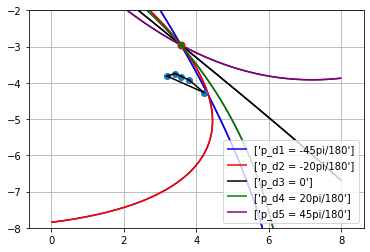

In [42]:
rng = np.random.default_rng()
#points = rng.random((30, 2))
points = np.array([[3.1886,-3.81288],[3.40957,-3.743],[3.5845,-3.8394],[3.7997,-3.9225],[4.21067,-4.26765]]) 
print(points)
print(points.shape)
hull = ConvexHull(points)

plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.xlim(2.0,5.0)
plt.ylim(-5,-2)

x_1 = [3.572468]
y_1 = [-2.9473]

#plt.figure(figsize=(3, 3))

plt.plot(x_1, y_1, marker="o", markersize=7, markeredgecolor="red", markerfacecolor="green")
plt.grid()


# plot barrier function generated 

X = np.linspace(0.0, 8.0, 1000)
Y = np.linspace(-8.0, -2.0, 1000)
x, y = np.meshgrid(X,Y)

F_1 = -1 + x**2*(5.95217062462275e-9*x**2 - 2.7891961145098e-9*x*y - 0.10259982948583*x + 9.46642644906214e-10*y**2 + 3.31511625381226e-5*y - 4.54107820624297) - 4.54107820624297*x**2 + x*y*(-2.7891961145098e-9*x**2 + 6.84421326015847e-9*x*y + 3.31512735272809e-5*x - 7.94117146105101e-9*y**2 + 1.41687754166213e-7*y - 10.1273764237458) - 10.1273764237458*x*y + x*(-0.102608283947441*x**2 + 3.30564829664605e-5*x*y - 9.08336787007988*x + 1.82204888602998e-7*y**2 - 10.1273762268852*y - 321.307371176111) - 1.19*x*(-7.10458958937154e-6*x**2 - 7.9655933462543e-8*x*y - 0.00101818999117914*x + 3.36214568608898e-8*y**2 - 0.00135588862227282*y - 0.155083740695314) - 321.122821524684*x + y**2*(9.46642644906214e-10*x**2 - 7.94117146105101e-9*x*y + 1.42195354938539e-7*x + 1.3938572948368e-7*y**2 + 5.39476995772273e-7*y - 7.7697872297084) - 7.7697872297084*y**2 - 1.19*y*(-7.95733987341858e-8*x**2 + 3.40411606154167e-8*x*y - 0.00135588860567147*x - 5.33217192156368e-7*y**2 - 8.27876093426529e-9*y - 0.0886449193131125) + y*(3.30564701936289e-5*x**2 + 1.82196735298559e-7*x*y - 10.1273762268655*x - 9.50514628938048e-8*y**2 - 15.5395741463968*y - 209.869055006825) - 209.763567552842*y + 1142.58837469282
F_2 = -1 + x**2*(2.18634404098349e-9*x**2 - 1.26162878094674e-9*x*y - 0.0369973621120415*x - 1.33121765655488e-9*y**2 + 2.72118104718833e-5*y - 1.25852046055673) - 1.25852046055673*x**2 + x*y*(-1.26162878094674e-9*x**2 + 2.05246593260028e-10*x*y + 2.72118676745513e-5*x - 9.376474067382e-9*y**2 - 1.53437251953064e-6*y - 4.12462535091141) - 4.12462535091141*x*y + x*(-0.0370046683969166*x**2 + 2.76048295534581e-5*x*y - 2.51672654475199*x - 9.82809983231624e-7*y**2 - 4.12462534097349*y - 80.233802673059) - 1.19*x*(-6.13973518916252e-6*x**2 + 3.30220066308206e-7*x*y + 0.000264138244224335*x + 4.64515677724106e-7*y**2 - 0.00012015834006881*y - 0.055439165146581) - 80.1678300665346*x + y**2*(-1.33121765655488e-9*x**2 - 9.376474067382e-9*x*y - 1.53558363972331e-6*x - 3.67397919210121e-8*y**2 - 2.01335037004115e-6*y - 7.75988860755694) - 7.75988860755694*y**2 - 1.19*y*(3.30268443295757e-7*x**2 + 4.63510279457343e-7*x*y - 0.000120158331500948*x + 9.05837298892501e-7*y**2 + 5.33080070225501e-8*y - 0.118493533825725) + y*(2.76048299194053e-5*x**2 - 9.82795286976401e-7*x*y - 4.1246253409633*x - 9.3540398435907e-7*y**2 - 15.5197768304059*y - 120.158908195182) - 120.01790088993*y + 28.8775319927433
F_3 = -1 + x**2*(-6.81866871166217e-8*x**2 + 2.18379284437199e-8*x*y - 0.0371549566096042*x - 2.42637470364481e-8*y**2 - 2.12813957648876e-5*y + 0.454469611841702) + 0.454469611841702*x**2 + x*y*(2.18379284437199e-8*x**2 - 4.68386178223784e-8*x*y - 2.1281404096161e-5*x + 3.40603716551867e-8*y**2 - 2.04641262759041e-6*y - 1.89365691004957) - 1.89365691004957*x*y + x*(-0.0371496278552568*x**2 - 2.03625910121935e-5*x*y + 0.90831216197402*x - 2.13391095070064e-6*y**2 - 1.89365713832108*y - 74.3886344217523) - 1.19*x*(4.47794482975981e-6*x**2 + 7.72111835266835e-7*x*y - 0.000526926890712207*x - 7.3647096669053e-8*y**2 - 0.000919961536134116*y + 0.0396506894085281) - 74.4358187421485*x + y**2*(-2.42637470364481e-8*x**2 + 3.40603716551867e-8*x*y - 2.04627090566447e-6*x - 2.56276520494252e-7*y**2 - 1.87009417030786e-6*y - 2.82874564348504) - 2.82874564348504*y**2 + y*(-2.03625906465494e-5*x**2 - 2.13388787958041e-6*x*y - 1.8936571383359*x + 4.6518844889327e-8*y**2 - 5.65749202423911*y - 91.3599094062475) - 1.19*y*(7.72105141460641e-7*x**2 - 7.35086151176462e-8*x*y - 0.000919961548590505*x + 1.61059917243461e-6*y**2 - 7.18669001061967e-7*y - 0.0604091565318551) - 91.2880225099746*y - 7.52557118533153
F_4 = -1 + x**2*(-2.8398994557701e-8*x**2 + 8.11305882380327e-9*x*y - 0.00642161325702398*x - 9.60761351123606e-9*y**2 + 1.7991829406836e-6*y - 0.049308584984274) - 0.049308584984274*x**2 + x*y*(8.11305882380327e-9*x**2 - 1.67452281568578e-8*x*y + 1.79918497464145e-6*x + 1.44898002858807e-8*y**2 - 5.88468547287205e-7*y + 1.39340402804931) + 1.39340402804931*x*y + x*(-0.00642222974042424*x**2 + 2.13275298092524e-6*x*y - 0.0988496358953179*x - 7.68897951643728e-7*y**2 + 1.39340404782523*y - 26.6612869830705) - 1.19*x*(-5.18053277527043e-7*x**2 + 2.80309248977973e-7*x*y - 0.000195351219562736*x - 1.52551719240863e-7*y**2 - 0.000372647486581203*y + 0.0291441727299226) - 26.6959685486191*x + y**2*(-9.60761351123606e-9*x**2 + 1.44898002858807e-8*x*y - 5.87361405747101e-7*x - 8.95574344248144e-8*y**2 - 3.92869748603141e-7*y - 0.555281002187437) - 0.555281002187437*y**2 - 1.19*y*(2.80309896474724e-7*x**2 - 1.51606725205427e-7*x*y - 0.000372647486775871*x + 5.0126408817928e-7*y**2 - 1.04672348992541e-7*y - 0.021539439910485) + y*(2.13275171748852e-6*x**2 - 7.68880550281663e-7*x*y + 1.393404047825*x + 2.03634516330202e-7*y**2 - 1.11056210502982*y - 47.6043570109872) - 47.5787250774937*y - 8.62476300767536
F_5 = -1 + x**2*(-1.84536777983869e-9*x**2 - 2.61113387845714e-9*x*y - 0.0427536413764992*x - 2.23703172807076e-9*y**2 + 4.4614282036296e-5*y + 2.29952381926249) + 2.29952381926249*x**2 + x*y*(-2.61113387845714e-9*x**2 - 2.72235102832299e-9*x*y + 4.46143941401326e-5*x - 4.51336754285914e-9*y**2 - 9.02953366512302e-7*y - 0.106212552270655) - 0.106212552270655*x*y + x*(-0.0427655266015825*x**2 + 4.50317958211314e-5*x*y + 4.5987184133237*x - 1.06831041179082e-6*y**2 - 0.106212610717267*y - 60.3637344675026) - 1.19*x*(-9.987584103594e-6*x**2 + 3.50757715125018e-7*x*y - 0.000276579975514501*x - 1.39706120381233e-7*y**2 - 0.000142469400540771*y + 0.00518669211329728) - 60.3699066311175*x + y**2*(-2.23703172807076e-9*x**2 - 4.51336754285914e-9*x*y - 9.02060128537153e-7*x + 1.04733367215724e-8*y**2 + 1.73101346186203e-8*y - 0.431857406803344) - 0.431857406803344*y**2 - 1.19*y*(3.50850255995048e-7*x**2 - 1.3892674344578e-7*x*y - 0.000142469400902833*x + 2.12708510958567e-7*y**2 + 7.21725197841537e-8*y - 0.0151556425586101) + y*(4.50317938409301e-5*x**2 - 1.06827619121278e-6*x*y - 0.106212610717698*x + 2.70433262659315e-7*y**2 - 0.863714709143718*y - 57.6281557817098) - 57.6101205670651*y - 11.1993112214814

#F = np.array([F_1,F_2,F_3,F_4,F_5])
#print(F_1.shape)

plt.contour(x,y,F_1,[0])
CS1 = plt.contour(x,y,F_1,[0],colors = ['blue'])
label1 = ['p_d1 = -45pi/180']
CS1.collections[0].set_label(label1)

plt.contour(x,y,F_2,[0])
CS2 = plt.contour(x,y,F_2,[0],colors = ['red'])
label2 = ['p_d2 = -20pi/180']
CS2.collections[0].set_label(label2)

plt.contour(x,y,F_3,[0])
CS3 = plt.contour(x,y,F_3,[0],colors = ['black'])
label3 = ['p_d3 = 0']
CS3.collections[0].set_label(label3)

plt.contour(x,y,F_4,[0])
CS4 = plt.contour(x,y,F_4,[0],colors = ['green'])
label4 = ['p_d4 = 20pi/180']
CS4.collections[0].set_label(label4)

plt.contour(x,y,F_5,[0])
CS5 = plt.contour(x,y,F_5,[0],colors = ['purple'])
label5 = ['p_d5 = 45pi/180']
CS5.collections[0].set_label(label5)

#CS = plt.contour(x,y,F,[0])
#labels = ['p_d1 = -45pi/180','p_d2 = -20pi/180','p_d3 = 0','p_d4 = 20pi/180','p_d5 = 45pi/180']
#for i in range(len(labels)):
#    CS.collections[i].set_label(labels[i])
    

plt.axis('equal')
plt.legend(loc='lower right')
plt.show()


In [8]:
#x = 3.572468
#y = -2.9473

x = 2
y = -4


value_check = x**2*(5.95217062462275e-9*x**2 - 2.7891961145098e-9*x*y - 0.10259982948583*x + 9.46642644906214e-10*y**2 + 3.31511625381226e-5*y - 4.54107820624297) - 4.54107820624297*x**2 + x*y*(-2.7891961145098e-9*x**2 + 6.84421326015847e-9*x*y + 3.31512735272809e-5*x - 7.94117146105101e-9*y**2 + 1.41687754166213e-7*y - 10.1273764237458) - 10.1273764237458*x*y + x*(-0.102608283947441*x**2 + 3.30564829664605e-5*x*y - 9.08336787007988*x + 1.82204888602998e-7*y**2 - 10.1273762268852*y - 321.307371176111) - 1.19*x*(-7.10458958937154e-6*x**2 - 7.9655933462543e-8*x*y - 0.00101818999117914*x + 3.36214568608898e-8*y**2 - 0.00135588862227282*y - 0.155083740695314) - 321.122821524684*x + y**2*(9.46642644906214e-10*x**2 - 7.94117146105101e-9*x*y + 1.42195354938539e-7*x + 1.3938572948368e-7*y**2 + 5.39476995772273e-7*y - 7.7697872297084) - 7.7697872297084*y**2 - 1.19*y*(-7.95733987341858e-8*x**2 + 3.40411606154167e-8*x*y - 0.00135588860567147*x - 5.33217192156368e-7*y**2 - 8.27876093426529e-9*y - 0.0886449193131125) + y*(3.30564701936289e-5*x**2 + 1.82196735298559e-7*x*y - 10.1273762268655*x - 9.50514628938048e-8*y**2 - 15.5395741463968*y - 209.869055006825) - 209.763567552842*y + 1142.58837469282

print(value_check)

1288.6884959406216


In [137]:
# modified version 

# same version but using polytope constraints
x,y,p = sympy.symbols('x y p')
K = 50
V = 1.0
p_d1 = -45*np.pi/180
p_d2 = -20*np.pi/180
p_d3 = 0
p_d4 = 20*np.pi/180
p_d5 = 45*np.pi/180


x_0 = 3.572468
y_0 = -2.9473
p_0 = -1.19


# use current angle
angle = -1.19

# taylor approximation around 0 (should be changed later)
# change dynamics to match with global 
f = sympy.Matrix([[V*math.cos(angle) - (V*math.cos(angle)/2)*p**2],[V*math.cos(angle)*p - (V*math.cos(angle))/6*p**3],[-K*(p - p_d1)]])
#print(f_1)
#print(f_2)
# polynomial basis
b1 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b1 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b1 = sympy.Matrix([[1,x,y,p]]).transpose()


Q = sympy.MatrixSymbol('Q',10,10)
#Q = sympy.MatrixSymbol('Q',4,4)
#Q = sympy.MatrixSymbol('Q',9,9)


# partial derivative
db1_dx = sympy.diff(b1,x)
#print(db1_dx)
db1_dy = sympy.diff(b1,y)
db1_dp = sympy.diff(b1,p)


########## parameterization step
# V
V = (b1.T @ Q @ b1).as_explicit()
SOS_V_para_poly = sympy.Poly(V[0],x,y,p)
B = sympy.Matrix([
            [db1_dx, db1_dy,db1_dp]])
#print(B.shape)
ne_Vdot_compute = (- 2 * b1.T @ Q @ B @ f).as_explicit()
ne_Vdot_compute_poly = sympy.Poly(ne_Vdot_compute[0],x, y, p)

#print('check coeff of ne_Vdot_compute_poly:')
#print(ne_Vdot_compute_poly)
    

# -V_dot
#b2 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
b2 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b2 = sympy.Matrix([[1,x,y,p]]).transpose()
#G = sympy.MatrixSymbol('G', 4, 4)
G = sympy.MatrixSymbol('G', 10, 10)
#G = G = sympy.MatrixSymbol('G', 9, 9)
SOS_of_ne_V_dot = (b2.T @ G @ b2).as_explicit()
SOS_of_ne_V_dot_poly = sympy.Poly(SOS_of_ne_V_dot[0], x, y, p)

#print('\ncheck coeff of SOS_of_ne_V_dot_poly:')
#print(SOS_of_ne_V_dot_poly)

b2_sqr = [b*b for b in b2]
for b_sqr in b2_sqr:
    coeff = SOS_of_ne_V_dot_poly.coeff_monomial(b_sqr)
    if coeff is sympy.S.Zero:
        print('WARNING: digonal coeff is zero for',b_sqr, ' not PSD for sure!')


# define a vector of largrange multiplier
multi_vector = []
J = []
b3 = sympy.Matrix([[1,x,y,p]]).transpose()
SOS_mutiplier_para_v = []
for i in range(len(a_arr)):
    J = sympy.MatrixSymbol('J{}'.format(i),4,4)
    SOS_mutiplier_para = (b3.T @ J @ b3).as_explicit()
    SOS_mutiplier_para_v = np.append(SOS_mutiplier_para_v,SOS_mutiplier_para)
    
SOS_mutiplier_para_v = np.reshape(SOS_mutiplier_para_v,(1,4))
print('SOS_mutiplier_para_v')
print(SOS_mutiplier_para_v[0][0])

### dealing with obstacle constraint SOS

# obstacle constraint SOS paratrization
b4 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b4 = sympy.Matrix([[x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#b4 = sympy.Matrix([[1,x,y,p]]).transpose()
#M = sympy.MatrixSymbol('M',10,10)
M = sympy.MatrixSymbol('M',10,10)
#M = sympy.MatrixSymbol('M',4,4)
SOS_constraint_para = (b4.T @ M @ b4).as_explicit()
SOS_constraint_para_poly = sympy.Poly(SOS_constraint_para[0],x,y,p)


print('\ncheck coeff of SOS_constraint_para_poly:{}'.format(SOS_constraint_para_poly))


vector_x = sympy.Matrix([[x,y]]).transpose()
# obstacle constraint SOS computed from V and multiplier
epsilon_1 = 1e-6
print(A.shape)
SOS_mutiplier_para_poly_v = sympy.Poly((SOS_mutiplier_para_v @ (A @ vector_x + c))[0],x,y,p)

SOS_constraint_compute_poly = SOS_V_para_poly - (1 + epsilon_1) - SOS_mutiplier_para_poly_v
#print(SOS_constraint_compute_poly)
constraint_list_V_Vdot = []
constraint_list_obstacle = []


print('\ncheck coeff of SOS_constraint_compute_poly:{}'.format(SOS_constraint_compute_poly))



## ------------------------------
# multiplier for radius constraint
b5 = sympy.Matrix([[1,x,y,p]]).transpose()
R = sympy.MatrixSymbol('R',4,4)
SOS_mutiplier_radius_para = (b5.T @ R @ b5).as_explicit()
SOS_mutiplier_radius_poly = sympy.Poly(SOS_mutiplier_radius_para[0],x,y,p)


# adding radius constraint for separating V(x) < 1 for all x,y in B(x_0)
b6 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
K = sympy.MatrixSymbol('K',10,10)
SOS_radius_para = (b6.T @ K @ b6).as_explicit()
SOS_radius_para_poly = sympy.Poly(SOS_radius_para[0],x,y,p)


print(x_0)
print(y_0)
epsilon_2 = 1e-6
SOS_radius_compute_poly = ((1 + epsilon_2) - SOS_V_para_poly) - (SOS_mutiplier_radius_poly * (0.1 - (x - x_0)**2 - (y - y_0)**2))
constraint_list_radius = []


max_order = 10
# deal with V and -V_dot adding coeff matching constraint
for x_order in range(0,max_order+1):
    for y_order in range(0,max_order + 1):
        for p_order in range(0,max_order + 1):
            monomial = (x**x_order)*(y**y_order)*(p**p_order)
            # check if b2.T @ G b2 has coeff
            coeff_V_dot_para = SOS_of_ne_V_dot_poly.coeff_monomial(monomial)
            #print('coeff for {} in SOS_of_ne_V_dot_poly is {}'.format(monomial,coeff_V_dot_para))
            # check if - 2 * b1.T @ Q @ B @ f has coeff
            coeff_V_dot_compu = ne_Vdot_compute_poly.coeff_monomial(monomial)
            #print('coeff for {} in ne_Vdot_compute_poly is {}'.format(monomial,coeff_V_dot_compu))
            
            # continue if both do not contain
            if coeff_V_dot_para is sympy.S.Zero and coeff_V_dot_compu is sympy.S.Zero:
                continue
            
            ## should be modified
            if coeff_V_dot_para is sympy.S.Zero and not coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_V_dot_compu)
                constraint_list_V_Vdot.append(constrain)
            ## should be modified
            if not coeff_V_dot_para is sympy.S.Zero and coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_V_dot_para)
                constraint_list_V_Vdot.append(constrain)
                
            if not coeff_V_dot_para is sympy.S.Zero and not coeff_V_dot_compu is sympy.S.Zero:
                constrain = '{}=={}'.format(coeff_V_dot_compu,coeff_V_dot_para)
                constraint_list_V_Vdot.append(constrain)

            
print('\nConstraints V_Vdot (copy):', ','.join(constraint_list_V_Vdot))                

# delta with obstacle SOS coeff matching
for x_order in range(0,max_order+1):
    for y_order in range(0,max_order + 1):
        for p_order in range(0,max_order + 1):
            monomial = (x**x_order)*(y**y_order)*(p**p_order)
            
            coeff_constraint_para = SOS_constraint_para_poly.coeff_monomial(monomial)
            coeff_constraint_compute = SOS_constraint_compute_poly.coeff_monomial(monomial)
            
            if coeff_constraint_para is sympy.S.Zero and coeff_constraint_compute is sympy.S.Zero:
                #print(monomial)
                continue
            
            ## should be modified
            if coeff_constraint_para is sympy.S.Zero and not coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_constraint_compute)
                constraint_list_obstacle.append(constrain)
            ## should be modified
            if not coeff_constraint_para is sympy.S.Zero and coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_constraint_para)
                constraint_list_obstacle.append(constrain)
                
            if not coeff_constraint_para is sympy.S.Zero and not coeff_constraint_compute is sympy.S.Zero:
                constrain = '{}=={}'.format(coeff_constraint_compute,coeff_constraint_para)
                constraint_list_obstacle.append(constrain)

print('\nConstraints obstacle SOS (copy):', ','.join(constraint_list_obstacle))

# deal with radius SOS coeff matching
for x_order in range(0,max_order+1):
    for y_order in range(0,max_order + 1):
        for p_order in range(0,max_order + 1):
            monomial = (x**x_order)*(y**y_order)*(p**p_order)
            
            coeff_radius_para = SOS_radius_para_poly.coeff_monomial(monomial)
            coeff_radius_compute = SOS_radius_compute_poly.coeff_monomial(monomial)
            
            if coeff_radius_para is sympy.S.Zero and coeff_radius_compute is sympy.S.Zero:
                #print(monomial)
                continue
            
            ## should be modified
            if coeff_radius_para is sympy.S.Zero and not coeff_radius_compute is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_radius_compute)
                constraint_list_radius.append(constrain)
            ## should be modified
            if not coeff_radius_para is sympy.S.Zero and coeff_radius_compute is sympy.S.Zero:
                constrain = '{}==0.'.format(coeff_radius_para)
                constraint_list_radius.append(constrain)
                
            if not coeff_radius_para is sympy.S.Zero and not coeff_radius_compute is sympy.S.Zero:
                constrain = '{}=={}'.format(coeff_radius_compute,coeff_radius_para)
                constraint_list_radius.append(constrain)

print('\nConstraints radius SOS (copy):', ','.join(constraint_list_radius))

SOS_mutiplier_para_v
p*(p*J0[3, 3] + x*J0[1, 3] + y*J0[2, 3] + J0[0, 3]) + p*J0[3, 0] + x*(p*J0[3, 1] + x*J0[1, 1] + y*J0[2, 1] + J0[0, 1]) + x*J0[1, 0] + y*(p*J0[3, 2] + x*J0[1, 2] + y*J0[2, 2] + J0[0, 2]) + y*J0[2, 0] + J0[0, 0]

check coeff of SOS_constraint_para_poly:Poly(M[4, 4]*x**4 + (M[4, 5] + M[5, 4])*x**3*y + (M[4, 7] + M[7, 4])*x**3*p + (M[1, 4] + M[4, 1])*x**3 + (M[4, 6] + M[5, 5] + M[6, 4])*x**2*y**2 + (M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4])*x**2*y*p + (M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1])*x**2*y + (M[4, 9] + M[7, 7] + M[9, 4])*x**2*p**2 + (M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1])*x**2*p + (M[0, 4] + M[1, 1] + M[4, 0])*x**2 + (M[5, 6] + M[6, 5])*x*y**3 + (M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5])*x*y**2*p + (M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1])*x*y**2 + (M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5])*x*y*p**2 + (M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1])*x*y*p + (M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0])*x*y + (M[7, 9] + M[9, 7])*x*p**3 + (M[1, 9] + M[3, 7] + M[7, 3] +


Constraints obstacle SOS (copy): -2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3]

In [104]:
# solve SOS as SDP based on constraint obtained earilier
Q = cp.Variable((10,10), symmetric=True)
G = cp.Variable((10,10), symmetric=True)
M = cp.Variable((10,10), symmetric = True)
R = cp.Variable((4,4),symmetric = True)
K = cp.Variable((10,10),symmetric = True)


# create multipliers (should be changed later based on number of convex points)
J0 = cp.Variable((4,4), symmetric = True)
J1 = cp.Variable((4,4), symmetric = True)
J2 = cp.Variable((4,4), symmetric = True)
J3 = cp.Variable((4,4), symmetric = True)


# make sure positive definite , sufficient condition
#epsilon = 1e-8
#constraints = [Q >> 0]
constraints = [G >> 0]
constraints += [M >> 0]
constraints += [R >> 0]
constraints += [K >> 0]



constraints += [J0 >> 0]
constraints += [J1 >> 0]
constraints += [J2 >> 0]
constraints += [J3 >> 0]



# equaility constraint for initial condition

b_0 = np.array([[1,x_0,y_0,p_0,x_0**2,x_0*y_0,y_0**2,x_0*p_0,y_0*p_0,p_0**2]]).transpose()
#print(b_0.T @ Q @ b_0)
#b1 = sympy.Matrix([[1,x,y,p,x**2,x*y,y**2,x*p,y*p,p**2]]).transpose()
#constraints += 

constraints += [b_0.T @ Q @ b_0 == 0]


# V Vdot coeff matching constraint

# p_d1

constraints += [-0.743319744521066*Q[0, 1] + 78.5398163397448*Q[0, 3]==G[0, 0],-0.743319744521066*Q[0, 2] + 100*Q[0, 3] - 0.743319744521066*Q[0, 7] + 157.07963267949*Q[0, 9] - 0.743319744521066*Q[3, 1] + 78.5398163397448*Q[3, 3]==G[0, 3] + G[3, 0],0.371659872260533*Q[0, 1] - 0.743319744521066*Q[0, 8] + 200*Q[0, 9] - 0.743319744521066*Q[3, 2] + 100*Q[3, 3] - 0.743319744521066*Q[3, 7] + 157.07963267949*Q[3, 9] - 0.743319744521066*Q[9, 1] + 78.5398163397448*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],0.123886624086844*Q[0, 2] + 0.371659872260533*Q[0, 7] + 0.371659872260533*Q[3, 1] - 0.743319744521066*Q[3, 8] + 200*Q[3, 9] - 0.743319744521066*Q[9, 2] + 100*Q[9, 3] - 0.743319744521066*Q[9, 7] + 157.07963267949*Q[9, 9]==G[3, 9] + G[9, 3],0.123886624086844*Q[0, 8] + 0.123886624086844*Q[3, 2] + 0.371659872260533*Q[3, 7] + 0.371659872260533*Q[9, 1] - 0.743319744521066*Q[9, 8] + 200*Q[9, 9]==G[9, 9],0.123886624086844*Q[3, 8] + 0.123886624086844*Q[9, 2] + 0.371659872260533*Q[9, 7]==0.,0.123886624086844*Q[9, 8]==0.,-0.743319744521066*Q[0, 5] + 78.5398163397448*Q[0, 8] - 0.743319744521066*Q[2, 1] + 78.5398163397448*Q[2, 3]==G[0, 2] + G[2, 0],-1.48663948904213*Q[0, 6] + 100*Q[0, 8] - 0.743319744521066*Q[2, 2] + 100*Q[2, 3] - 0.743319744521066*Q[2, 7] + 157.07963267949*Q[2, 9] - 0.743319744521066*Q[3, 5] + 78.5398163397448*Q[3, 8] - 0.743319744521066*Q[8, 1] + 78.5398163397448*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],0.371659872260533*Q[0, 5] + 0.371659872260533*Q[2, 1] - 0.743319744521066*Q[2, 8] + 200*Q[2, 9] - 1.48663948904213*Q[3, 6] + 100*Q[3, 8] - 0.743319744521066*Q[8, 2] + 100*Q[8, 3] - 0.743319744521066*Q[8, 7] + 157.07963267949*Q[8, 9] - 0.743319744521066*Q[9, 5] + 78.5398163397448*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],0.247773248173689*Q[0, 6] + 0.123886624086844*Q[2, 2] + 0.371659872260533*Q[2, 7] + 0.371659872260533*Q[3, 5] + 0.371659872260533*Q[8, 1] - 0.743319744521066*Q[8, 8] + 200*Q[8, 9] - 1.48663948904213*Q[9, 6] + 100*Q[9, 8]==G[8, 9] + G[9, 8],0.123886624086844*Q[2, 8] + 0.247773248173689*Q[3, 6] + 0.123886624086844*Q[8, 2] + 0.371659872260533*Q[8, 7] + 0.371659872260533*Q[9, 5]==0.,0.123886624086844*Q[8, 8] + 0.247773248173689*Q[9, 6]==0.,-0.743319744521066*Q[2, 5] + 78.5398163397448*Q[2, 8] - 0.743319744521066*Q[6, 1] + 78.5398163397448*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],-1.48663948904213*Q[2, 6] + 100*Q[2, 8] - 0.743319744521066*Q[6, 2] + 100*Q[6, 3] - 0.743319744521066*Q[6, 7] + 157.07963267949*Q[6, 9] - 0.743319744521066*Q[8, 5] + 78.5398163397448*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],0.371659872260533*Q[2, 5] + 0.371659872260533*Q[6, 1] - 0.743319744521066*Q[6, 8] + 200*Q[6, 9] - 1.48663948904213*Q[8, 6] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],0.247773248173689*Q[2, 6] + 0.123886624086844*Q[6, 2] + 0.371659872260533*Q[6, 7] + 0.371659872260533*Q[8, 5]==0.,0.123886624086844*Q[6, 8] + 0.247773248173689*Q[8, 6]==0.,-0.743319744521066*Q[6, 5] + 78.5398163397448*Q[6, 8]==G[2, 6] + G[6, 2],-1.48663948904213*Q[6, 6] + 100*Q[6, 8]==G[6, 8] + G[8, 6],0.371659872260533*Q[6, 5]==0.,0.247773248173689*Q[6, 6]==0.,G[6, 6]==0.,-1.48663948904213*Q[0, 4] + 78.5398163397448*Q[0, 7] - 0.743319744521066*Q[1, 1] + 78.5398163397448*Q[1, 3]==G[0, 1] + G[1, 0],-0.743319744521066*Q[0, 5] + 100*Q[0, 7] - 0.743319744521066*Q[1, 2] + 100*Q[1, 3] - 0.743319744521066*Q[1, 7] + 157.07963267949*Q[1, 9] - 1.48663948904213*Q[3, 4] + 78.5398163397448*Q[3, 7] - 0.743319744521066*Q[7, 1] + 78.5398163397448*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],0.743319744521066*Q[0, 4] + 0.371659872260533*Q[1, 1] - 0.743319744521066*Q[1, 8] + 200*Q[1, 9] - 0.743319744521066*Q[3, 5] + 100*Q[3, 7] - 0.743319744521066*Q[7, 2] + 100*Q[7, 3] - 0.743319744521066*Q[7, 7] + 157.07963267949*Q[7, 9] - 1.48663948904213*Q[9, 4] + 78.5398163397448*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],0.123886624086844*Q[0, 5] + 0.123886624086844*Q[1, 2] + 0.371659872260533*Q[1, 7] + 0.743319744521066*Q[3, 4] + 0.371659872260533*Q[7, 1] - 0.743319744521066*Q[7, 8] + 200*Q[7, 9] - 0.743319744521066*Q[9, 5] + 100*Q[9, 7]==G[7, 9] + G[9, 7],0.123886624086844*Q[1, 8] + 0.123886624086844*Q[3, 5] + 0.123886624086844*Q[7, 2] + 0.371659872260533*Q[7, 7] + 0.743319744521066*Q[9, 4]==0.,0.123886624086844*Q[7, 8] + 0.123886624086844*Q[9, 5]==0.,-0.743319744521066*Q[1, 5] + 78.5398163397448*Q[1, 8] - 1.48663948904213*Q[2, 4] + 78.5398163397448*Q[2, 7] - 0.743319744521066*Q[5, 1] + 78.5398163397448*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],-1.48663948904213*Q[1, 6] + 100*Q[1, 8] - 0.743319744521066*Q[2, 5] + 100*Q[2, 7] - 0.743319744521066*Q[5, 2] + 100*Q[5, 3] - 0.743319744521066*Q[5, 7] + 157.07963267949*Q[5, 9] - 0.743319744521066*Q[7, 5] + 78.5398163397448*Q[7, 8] - 1.48663948904213*Q[8, 4] + 78.5398163397448*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],0.371659872260533*Q[1, 5] + 0.743319744521066*Q[2, 4] + 0.371659872260533*Q[5, 1] - 0.743319744521066*Q[5, 8] + 200*Q[5, 9] - 1.48663948904213*Q[7, 6] + 100*Q[7, 8] - 0.743319744521066*Q[8, 5] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],0.247773248173689*Q[1, 6] + 0.123886624086844*Q[2, 5] + 0.123886624086844*Q[5, 2] + 0.371659872260533*Q[5, 7] + 0.371659872260533*Q[7, 5] + 0.743319744521066*Q[8, 4]==0.,0.123886624086844*Q[5, 8] + 0.247773248173689*Q[7, 6] + 0.123886624086844*Q[8, 5]==0.,-0.743319744521066*Q[5, 5] + 78.5398163397448*Q[5, 8] - 1.48663948904213*Q[6, 4] + 78.5398163397448*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],-1.48663948904213*Q[5, 6] + 100*Q[5, 8] - 0.743319744521066*Q[6, 5] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],0.371659872260533*Q[5, 5] + 0.743319744521066*Q[6, 4]==0.,0.247773248173689*Q[5, 6] + 0.123886624086844*Q[6, 5]==0.,G[5, 6] + G[6, 5]==0.,-1.48663948904213*Q[1, 4] + 78.5398163397448*Q[1, 7] - 0.743319744521066*Q[4, 1] + 78.5398163397448*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],-0.743319744521066*Q[1, 5] + 100*Q[1, 7] - 0.743319744521066*Q[4, 2] + 100*Q[4, 3] - 0.743319744521066*Q[4, 7] + 157.07963267949*Q[4, 9] - 1.48663948904213*Q[7, 4] + 78.5398163397448*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],0.743319744521066*Q[1, 4] + 0.371659872260533*Q[4, 1] - 0.743319744521066*Q[4, 8] + 200*Q[4, 9] - 0.743319744521066*Q[7, 5] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],0.123886624086844*Q[1, 5] + 0.123886624086844*Q[4, 2] + 0.371659872260533*Q[4, 7] + 0.743319744521066*Q[7, 4]==0.,0.123886624086844*Q[4, 8] + 0.123886624086844*Q[7, 5]==0.,-0.743319744521066*Q[4, 5] + 78.5398163397448*Q[4, 8] - 1.48663948904213*Q[5, 4] + 78.5398163397448*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],-1.48663948904213*Q[4, 6] + 100*Q[4, 8] - 0.743319744521066*Q[5, 5] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],0.371659872260533*Q[4, 5] + 0.743319744521066*Q[5, 4]==0.,0.247773248173689*Q[4, 6] + 0.123886624086844*Q[5, 5]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-1.48663948904213*Q[4, 4] + 78.5398163397448*Q[4, 7]==G[1, 4] + G[4, 1],-0.743319744521066*Q[4, 5] + 100*Q[4, 7]==G[4, 7] + G[7, 4],0.743319744521066*Q[4, 4]==0.,0.123886624086844*Q[4, 5]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
constraints += [-2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3] - 1.02207*J0[3, 0] - 2.4469506396*J0[3, 2] + 0.41097*J1[0, 3] + 0.300563370000002*J1[2, 3] + 0.41097*J1[3, 0] + 0.300563370000002*J1[3, 2] + 0.39013*J2[0, 3] + 0.848238775*J2[2, 3] + 0.39013*J2[3, 0] + 0.848238775*J2[3, 2] + 0.22097*J3[0, 3] + 1.0653514616*J3[2, 3] + 0.22097*J3[3, 0] + 1.0653514616*J3[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-1.02207*J0[3, 3] + 0.41097*J1[3, 3] + 0.39013*J2[3, 3] + 0.22097*J3[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],-1.02207*J0[0, 2] - 1.02207*J0[2, 0] - 2.4469506396*J0[2, 2] + 0.41097*J1[0, 2] + 0.41097*J1[2, 0] + 0.300563370000002*J1[2, 2] + 0.39013*J2[0, 2] + 0.39013*J2[2, 0] + 0.848238775*J2[2, 2] + 0.22097*J3[0, 2] + 0.22097*J3[2, 0] + 1.0653514616*J3[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],-1.02207*J0[2, 3] - 1.02207*J0[3, 2] + 0.41097*J1[2, 3] + 0.41097*J1[3, 2] + 0.39013*J2[2, 3] + 0.39013*J2[3, 2] + 0.22097*J3[2, 3] + 0.22097*J3[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],Q[6, 9] + Q[8, 8] + Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],-1.02207*J0[2, 2] + 0.41097*J1[2, 2] + 0.39013*J2[2, 2] + 0.22097*J3[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],Q[6, 8] + Q[8, 6]==M[6, 8] + M[8, 6],Q[6, 6]==M[6, 6],-0.45477*J0[0, 0] - 2.4469506396*J0[0, 1] - 2.4469506396*J0[1, 0] + 0.34515*J1[0, 0] + 0.300563370000002*J1[0, 1] + 0.300563370000002*J1[1, 0] + 0.1795*J2[0, 0] + 0.848238775*J2[0, 1] + 0.848238775*J2[1, 0] - 0.0698799999999999*J3[0, 0] + 1.0653514616*J3[0, 1] + 1.0653514616*J3[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-0.45477*J0[0, 3] - 2.4469506396*J0[1, 3] - 0.45477*J0[3, 0] - 2.4469506396*J0[3, 1] + 0.34515*J1[0, 3] + 0.300563370000002*J1[1, 3] + 0.34515*J1[3, 0] + 0.300563370000002*J1[3, 1] + 0.1795*J2[0, 3] + 0.848238775*J2[1, 3] + 0.1795*J2[3, 0] + 0.848238775*J2[3, 1] - 0.0698799999999999*J3[0, 3] + 1.0653514616*J3[1, 3] - 0.0698799999999999*J3[3, 0] + 1.0653514616*J3[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-0.45477*J0[3, 3] + 0.34515*J1[3, 3] + 0.1795*J2[3, 3] - 0.0698799999999999*J3[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-1.02207*J0[0, 1] - 0.45477*J0[0, 2] - 1.02207*J0[1, 0] - 2.4469506396*J0[1, 2] - 0.45477*J0[2, 0] - 2.4469506396*J0[2, 1] + 0.41097*J1[0, 1] + 0.34515*J1[0, 2] + 0.41097*J1[1, 0] + 0.300563370000002*J1[1, 2] + 0.34515*J1[2, 0] + 0.300563370000002*J1[2, 1] + 0.39013*J2[0, 1] + 0.1795*J2[0, 2] + 0.39013*J2[1, 0] + 0.848238775*J2[1, 2] + 0.1795*J2[2, 0] + 0.848238775*J2[2, 1] + 0.22097*J3[0, 1] - 0.0698799999999999*J3[0, 2] + 0.22097*J3[1, 0] + 1.0653514616*J3[1, 2] - 0.0698799999999999*J3[2, 0] + 1.0653514616*J3[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-1.02207*J0[1, 3] - 0.45477*J0[2, 3] - 1.02207*J0[3, 1] - 0.45477*J0[3, 2] + 0.41097*J1[1, 3] + 0.34515*J1[2, 3] + 0.41097*J1[3, 1] + 0.34515*J1[3, 2] + 0.39013*J2[1, 3] + 0.1795*J2[2, 3] + 0.39013*J2[3, 1] + 0.1795*J2[3, 2] + 0.22097*J3[1, 3] - 0.0698799999999999*J3[2, 3] + 0.22097*J3[3, 1] - 0.0698799999999999*J3[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],-1.02207*J0[1, 2] - 1.02207*J0[2, 1] - 0.45477*J0[2, 2] + 0.41097*J1[1, 2] + 0.41097*J1[2, 1] + 0.34515*J1[2, 2] + 0.39013*J2[1, 2] + 0.39013*J2[2, 1] + 0.1795*J2[2, 2] + 0.22097*J3[1, 2] + 0.22097*J3[2, 1] - 0.0698799999999999*J3[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],Q[5, 8] + Q[6, 7] + Q[7, 6] + Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],Q[5, 6] + Q[6, 5]==M[5, 6] + M[6, 5],-0.45477*J0[0, 1] - 0.45477*J0[1, 0] - 2.4469506396*J0[1, 1] + 0.34515*J1[0, 1] + 0.34515*J1[1, 0] + 0.300563370000002*J1[1, 1] + 0.1795*J2[0, 1] + 0.1795*J2[1, 0] + 0.848238775*J2[1, 1] - 0.0698799999999999*J3[0, 1] - 0.0698799999999999*J3[1, 0] + 1.0653514616*J3[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],-0.45477*J0[1, 3] - 0.45477*J0[3, 1] + 0.34515*J1[1, 3] + 0.34515*J1[3, 1] + 0.1795*J2[1, 3] + 0.1795*J2[3, 1] - 0.0698799999999999*J3[1, 3] - 0.0698799999999999*J3[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],Q[4, 9] + Q[7, 7] + Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],-1.02207*J0[1, 1] - 0.45477*J0[1, 2] - 0.45477*J0[2, 1] + 0.41097*J1[1, 1] + 0.34515*J1[1, 2] + 0.34515*J1[2, 1] + 0.39013*J2[1, 1] + 0.1795*J2[1, 2] + 0.1795*J2[2, 1] + 0.22097*J3[1, 1] - 0.0698799999999999*J3[1, 2] - 0.0698799999999999*J3[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],Q[4, 8] + Q[5, 7] + Q[7, 5] + Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],Q[4, 6] + Q[5, 5] + Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],-0.45477*J0[1, 1] + 0.34515*J1[1, 1] + 0.1795*J2[1, 1] - 0.0698799999999999*J3[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],Q[4, 7] + Q[7, 4]==M[4, 7] + M[7, 4],Q[4, 5] + Q[5, 4]==M[4, 5] + M[5, 4],Q[4, 4]==M[4, 4]]

constraints += [-1.0*Q[0, 0] + 21.049104901024*R[0, 0] + 1.000001==K[0, 0],-1.0*Q[0, 3] - 1.0*Q[3, 0] + 21.049104901024*R[0, 3] + 21.049104901024*R[3, 0]==K[0, 3] + K[3, 0],-1.0*Q[0, 9] - 1.0*Q[3, 3] - 1.0*Q[9, 0] + 21.049104901024*R[3, 3]==K[0, 9] + K[3, 3] + K[9, 0],-Q[3, 9] - Q[9, 3]==K[3, 9] + K[9, 3],-Q[9, 9]==K[9, 9],-1.0*Q[0, 2] - 1.0*Q[2, 0] + 5.8946*R[0, 0] + 21.049104901024*R[0, 2] + 21.049104901024*R[2, 0]==K[0, 2] + K[2, 0],-1.0*Q[0, 8] - 1.0*Q[2, 3] - 1.0*Q[3, 2] - 1.0*Q[8, 0] + 5.8946*R[0, 3] + 21.049104901024*R[2, 3] + 5.8946*R[3, 0] + 21.049104901024*R[3, 2]==K[0, 8] + K[2, 3] + K[3, 2] + K[8, 0],-1.0*Q[2, 9] - 1.0*Q[3, 8] - 1.0*Q[8, 3] - 1.0*Q[9, 2] + 5.8946*R[3, 3]==K[2, 9] + K[3, 8] + K[8, 3] + K[9, 2],-Q[8, 9] - Q[9, 8]==K[8, 9] + K[9, 8],-1.0*Q[0, 6] - 1.0*Q[2, 2] - 1.0*Q[6, 0] + 1.0*R[0, 0] + 5.8946*R[0, 2] + 5.8946*R[2, 0] + 21.049104901024*R[2, 2]==K[0, 6] + K[2, 2] + K[6, 0],-1.0*Q[2, 8] - 1.0*Q[3, 6] - 1.0*Q[6, 3] - 1.0*Q[8, 2] + 1.0*R[0, 3] + 5.8946*R[2, 3] + 1.0*R[3, 0] + 5.8946*R[3, 2]==K[2, 8] + K[3, 6] + K[6, 3] + K[8, 2],-1.0*Q[6, 9] - 1.0*Q[8, 8] - 1.0*Q[9, 6] + 1.0*R[3, 3]==K[6, 9] + K[8, 8] + K[9, 6],-1.0*Q[2, 6] - 1.0*Q[6, 2] + 1.0*R[0, 2] + 1.0*R[2, 0] + 5.8946*R[2, 2]==K[2, 6] + K[6, 2],-1.0*Q[6, 8] - 1.0*Q[8, 6] + 1.0*R[2, 3] + 1.0*R[3, 2]==K[6, 8] + K[8, 6],-1.0*Q[6, 6] + 1.0*R[2, 2]==K[6, 6],-1.0*Q[0, 1] - 1.0*Q[1, 0] - 7.144936*R[0, 0] + 21.049104901024*R[0, 1] + 21.049104901024*R[1, 0]==K[0, 1] + K[1, 0],-1.0*Q[0, 7] - 1.0*Q[1, 3] - 1.0*Q[3, 1] - 1.0*Q[7, 0] - 7.144936*R[0, 3] + 21.049104901024*R[1, 3] - 7.144936*R[3, 0] + 21.049104901024*R[3, 1]==K[0, 7] + K[1, 3] + K[3, 1] + K[7, 0],-1.0*Q[1, 9] - 1.0*Q[3, 7] - 1.0*Q[7, 3] - 1.0*Q[9, 1] - 7.144936*R[3, 3]==K[1, 9] + K[3, 7] + K[7, 3] + K[9, 1],-Q[7, 9] - Q[9, 7]==K[7, 9] + K[9, 7],-1.0*Q[0, 5] - 1.0*Q[1, 2] - 1.0*Q[2, 1] - 1.0*Q[5, 0] + 5.8946*R[0, 1] - 7.144936*R[0, 2] + 5.8946*R[1, 0] + 21.049104901024*R[1, 2] - 7.144936*R[2, 0] + 21.049104901024*R[2, 1]==K[0, 5] + K[1, 2] + K[2, 1] + K[5, 0],-1.0*Q[1, 8] - 1.0*Q[2, 7] - 1.0*Q[3, 5] - 1.0*Q[5, 3] - 1.0*Q[7, 2] - 1.0*Q[8, 1] + 5.8946*R[1, 3] - 7.144936*R[2, 3] + 5.8946*R[3, 1] - 7.144936*R[3, 2]==K[1, 8] + K[2, 7] + K[3, 5] + K[5, 3] + K[7, 2] + K[8, 1],-Q[5, 9] - Q[7, 8] - Q[8, 7] - Q[9, 5]==K[5, 9] + K[7, 8] + K[8, 7] + K[9, 5],-1.0*Q[1, 6] - 1.0*Q[2, 5] - 1.0*Q[5, 2] - 1.0*Q[6, 1] + 1.0*R[0, 1] + 1.0*R[1, 0] + 5.8946*R[1, 2] + 5.8946*R[2, 1] - 7.144936*R[2, 2]==K[1, 6] + K[2, 5] + K[5, 2] + K[6, 1],-1.0*Q[5, 8] - 1.0*Q[6, 7] - 1.0*Q[7, 6] - 1.0*Q[8, 5] + 1.0*R[1, 3] + 1.0*R[3, 1]==K[5, 8] + K[6, 7] + K[7, 6] + K[8, 5],-1.0*Q[5, 6] - 1.0*Q[6, 5] + 1.0*R[1, 2] + 1.0*R[2, 1]==K[5, 6] + K[6, 5],-1.0*Q[0, 4] - 1.0*Q[1, 1] - 1.0*Q[4, 0] + 1.0*R[0, 0] - 7.144936*R[0, 1] - 7.144936*R[1, 0] + 21.049104901024*R[1, 1]==K[0, 4] + K[1, 1] + K[4, 0],-1.0*Q[1, 7] - 1.0*Q[3, 4] - 1.0*Q[4, 3] - 1.0*Q[7, 1] + 1.0*R[0, 3] - 7.144936*R[1, 3] + 1.0*R[3, 0] - 7.144936*R[3, 1]==K[1, 7] + K[3, 4] + K[4, 3] + K[7, 1],-1.0*Q[4, 9] - 1.0*Q[7, 7] - 1.0*Q[9, 4] + 1.0*R[3, 3]==K[4, 9] + K[7, 7] + K[9, 4],-1.0*Q[1, 5] - 1.0*Q[2, 4] - 1.0*Q[4, 2] - 1.0*Q[5, 1] + 1.0*R[0, 2] + 5.8946*R[1, 1] - 7.144936*R[1, 2] + 1.0*R[2, 0] - 7.144936*R[2, 1]==K[1, 5] + K[2, 4] + K[4, 2] + K[5, 1],-1.0*Q[4, 8] - 1.0*Q[5, 7] - 1.0*Q[7, 5] - 1.0*Q[8, 4] + 1.0*R[2, 3] + 1.0*R[3, 2]==K[4, 8] + K[5, 7] + K[7, 5] + K[8, 4],-1.0*Q[4, 6] - 1.0*Q[5, 5] - 1.0*Q[6, 4] + 1.0*R[1, 1] + 1.0*R[2, 2]==K[4, 6] + K[5, 5] + K[6, 4],-1.0*Q[1, 4] - 1.0*Q[4, 1] + 1.0*R[0, 1] + 1.0*R[1, 0] - 7.144936*R[1, 1]==K[1, 4] + K[4, 1],-1.0*Q[4, 7] - 1.0*Q[7, 4] + 1.0*R[1, 3] + 1.0*R[3, 1]==K[4, 7] + K[7, 4],-1.0*Q[4, 5] - 1.0*Q[5, 4] + 1.0*R[1, 2] + 1.0*R[2, 1]==K[4, 5] + K[5, 4],-1.0*Q[4, 4] + 1.0*R[1, 1]==K[4, 4]]


#constraints += [21.249104901024*L[0, 0] - 1.0*Q[0, 0] + 1.000001==N[0, 0],21.249104901024*L[0, 3] + 21.249104901024*L[3, 0] - 1.0*Q[0, 3] - 1.0*Q[3, 0]==N[0, 3] + N[3, 0],21.249104901024*L[3, 3] - 1.0*Q[0, 9] - 1.0*Q[3, 3] - 1.0*Q[9, 0]==N[0, 9] + N[3, 3] + N[9, 0],-Q[3, 9] - Q[9, 3]==N[3, 9] + N[9, 3],-Q[9, 9]==N[9, 9],5.8946*L[0, 0] + 21.249104901024*L[0, 2] + 21.249104901024*L[2, 0] - 1.0*Q[0, 2] - 1.0*Q[2, 0]==N[0, 2] + N[2, 0],5.8946*L[0, 3] + 21.249104901024*L[2, 3] + 5.8946*L[3, 0] + 21.249104901024*L[3, 2] - 1.0*Q[0, 8] - 1.0*Q[2, 3] - 1.0*Q[3, 2] - 1.0*Q[8, 0]==N[0, 8] + N[2, 3] + N[3, 2] + N[8, 0],5.8946*L[3, 3] - 1.0*Q[2, 9] - 1.0*Q[3, 8] - 1.0*Q[8, 3] - 1.0*Q[9, 2]==N[2, 9] + N[3, 8] + N[8, 3] + N[9, 2],-Q[8, 9] - Q[9, 8]==N[8, 9] + N[9, 8],1.0*L[0, 0] + 5.8946*L[0, 2] + 5.8946*L[2, 0] + 21.249104901024*L[2, 2] - 1.0*Q[0, 6] - 1.0*Q[2, 2] - 1.0*Q[6, 0]==N[0, 6] + N[2, 2] + N[6, 0],1.0*L[0, 3] + 5.8946*L[2, 3] + 1.0*L[3, 0] + 5.8946*L[3, 2] - 1.0*Q[2, 8] - 1.0*Q[3, 6] - 1.0*Q[6, 3] - 1.0*Q[8, 2]==N[2, 8] + N[3, 6] + N[6, 3] + N[8, 2],1.0*L[3, 3] - 1.0*Q[6, 9] - 1.0*Q[8, 8] - 1.0*Q[9, 6]==N[6, 9] + N[8, 8] + N[9, 6],1.0*L[0, 2] + 1.0*L[2, 0] + 5.8946*L[2, 2] - 1.0*Q[2, 6] - 1.0*Q[6, 2]==N[2, 6] + N[6, 2],1.0*L[2, 3] + 1.0*L[3, 2] - 1.0*Q[6, 8] - 1.0*Q[8, 6]==N[6, 8] + N[8, 6],1.0*L[2, 2] - 1.0*Q[6, 6]==N[6, 6],-7.144936*L[0, 0] + 21.249104901024*L[0, 1] + 21.249104901024*L[1, 0] - 1.0*Q[0, 1] - 1.0*Q[1, 0]==N[0, 1] + N[1, 0],-7.144936*L[0, 3] + 21.249104901024*L[1, 3] - 7.144936*L[3, 0] + 21.249104901024*L[3, 1] - 1.0*Q[0, 7] - 1.0*Q[1, 3] - 1.0*Q[3, 1] - 1.0*Q[7, 0]==N[0, 7] + N[1, 3] + N[3, 1] + N[7, 0],-7.144936*L[3, 3] - 1.0*Q[1, 9] - 1.0*Q[3, 7] - 1.0*Q[7, 3] - 1.0*Q[9, 1]==N[1, 9] + N[3, 7] + N[7, 3] + N[9, 1],-Q[7, 9] - Q[9, 7]==N[7, 9] + N[9, 7],5.8946*L[0, 1] - 7.144936*L[0, 2] + 5.8946*L[1, 0] + 21.249104901024*L[1, 2] - 7.144936*L[2, 0] + 21.249104901024*L[2, 1] - 1.0*Q[0, 5] - 1.0*Q[1, 2] - 1.0*Q[2, 1] - 1.0*Q[5, 0]==N[0, 5] + N[1, 2] + N[2, 1] + N[5, 0],5.8946*L[1, 3] - 7.144936*L[2, 3] + 5.8946*L[3, 1] - 7.144936*L[3, 2] - 1.0*Q[1, 8] - 1.0*Q[2, 7] - 1.0*Q[3, 5] - 1.0*Q[5, 3] - 1.0*Q[7, 2] - 1.0*Q[8, 1]==N[1, 8] + N[2, 7] + N[3, 5] + N[5, 3] + N[7, 2] + N[8, 1],-Q[5, 9] - Q[7, 8] - Q[8, 7] - Q[9, 5]==N[5, 9] + N[7, 8] + N[8, 7] + N[9, 5],1.0*L[0, 1] + 1.0*L[1, 0] + 5.8946*L[1, 2] + 5.8946*L[2, 1] - 7.144936*L[2, 2] - 1.0*Q[1, 6] - 1.0*Q[2, 5] - 1.0*Q[5, 2] - 1.0*Q[6, 1]==N[1, 6] + N[2, 5] + N[5, 2] + N[6, 1],1.0*L[1, 3] + 1.0*L[3, 1] - 1.0*Q[5, 8] - 1.0*Q[6, 7] - 1.0*Q[7, 6] - 1.0*Q[8, 5]==N[5, 8] + N[6, 7] + N[7, 6] + N[8, 5],1.0*L[1, 2] + 1.0*L[2, 1] - 1.0*Q[5, 6] - 1.0*Q[6, 5]==N[5, 6] + N[6, 5],1.0*L[0, 0] - 7.144936*L[0, 1] - 7.144936*L[1, 0] + 21.249104901024*L[1, 1] - 1.0*Q[0, 4] - 1.0*Q[1, 1] - 1.0*Q[4, 0]==N[0, 4] + N[1, 1] + N[4, 0],1.0*L[0, 3] - 7.144936*L[1, 3] + 1.0*L[3, 0] - 7.144936*L[3, 1] - 1.0*Q[1, 7] - 1.0*Q[3, 4] - 1.0*Q[4, 3] - 1.0*Q[7, 1]==N[1, 7] + N[3, 4] + N[4, 3] + N[7, 1],1.0*L[3, 3] - 1.0*Q[4, 9] - 1.0*Q[7, 7] - 1.0*Q[9, 4]==N[4, 9] + N[7, 7] + N[9, 4],1.0*L[0, 2] + 5.8946*L[1, 1] - 7.144936*L[1, 2] + 1.0*L[2, 0] - 7.144936*L[2, 1] - 1.0*Q[1, 5] - 1.0*Q[2, 4] - 1.0*Q[4, 2] - 1.0*Q[5, 1]==N[1, 5] + N[2, 4] + N[4, 2] + N[5, 1],1.0*L[2, 3] + 1.0*L[3, 2] - 1.0*Q[4, 8] - 1.0*Q[5, 7] - 1.0*Q[7, 5] - 1.0*Q[8, 4]==N[4, 8] + N[5, 7] + N[7, 5] + N[8, 4],1.0*L[1, 1] + 1.0*L[2, 2] - 1.0*Q[4, 6] - 1.0*Q[5, 5] - 1.0*Q[6, 4]==N[4, 6] + N[5, 5] + N[6, 4],1.0*L[0, 1] + 1.0*L[1, 0] - 7.144936*L[1, 1] - 1.0*Q[1, 4] - 1.0*Q[4, 1]==N[1, 4] + N[4, 1],1.0*L[1, 3] + 1.0*L[3, 1] - 1.0*Q[4, 7] - 1.0*Q[7, 4]==N[4, 7] + N[7, 4],1.0*L[1, 2] + 1.0*L[2, 1] - 1.0*Q[4, 5] - 1.0*Q[5, 4]==N[4, 5] + N[5, 4],1.0*L[1, 1] - 1.0*Q[4, 4]==N[4, 4]]


# p_d2
#constraints += [-0.743319744521066*Q[0, 1] + 34.9065850398866*Q[0, 3]==G[0, 0],-0.743319744521066*Q[0, 2] + 100*Q[0, 3] - 0.743319744521066*Q[0, 7] + 69.8131700797732*Q[0, 9] - 0.743319744521066*Q[3, 1] + 34.9065850398866*Q[3, 3]==G[0, 3] + G[3, 0],0.371659872260533*Q[0, 1] - 0.743319744521066*Q[0, 8] + 200*Q[0, 9] - 0.743319744521066*Q[3, 2] + 100*Q[3, 3] - 0.743319744521066*Q[3, 7] + 69.8131700797732*Q[3, 9] - 0.743319744521066*Q[9, 1] + 34.9065850398866*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],0.123886624086844*Q[0, 2] + 0.371659872260533*Q[0, 7] + 0.371659872260533*Q[3, 1] - 0.743319744521066*Q[3, 8] + 200*Q[3, 9] - 0.743319744521066*Q[9, 2] + 100*Q[9, 3] - 0.743319744521066*Q[9, 7] + 69.8131700797732*Q[9, 9]==G[3, 9] + G[9, 3],0.123886624086844*Q[0, 8] + 0.123886624086844*Q[3, 2] + 0.371659872260533*Q[3, 7] + 0.371659872260533*Q[9, 1] - 0.743319744521066*Q[9, 8] + 200*Q[9, 9]==G[9, 9],0.123886624086844*Q[3, 8] + 0.123886624086844*Q[9, 2] + 0.371659872260533*Q[9, 7]==0.,0.123886624086844*Q[9, 8]==0.,-0.743319744521066*Q[0, 5] + 34.9065850398866*Q[0, 8] - 0.743319744521066*Q[2, 1] + 34.9065850398866*Q[2, 3]==G[0, 2] + G[2, 0],-1.48663948904213*Q[0, 6] + 100*Q[0, 8] - 0.743319744521066*Q[2, 2] + 100*Q[2, 3] - 0.743319744521066*Q[2, 7] + 69.8131700797732*Q[2, 9] - 0.743319744521066*Q[3, 5] + 34.9065850398866*Q[3, 8] - 0.743319744521066*Q[8, 1] + 34.9065850398866*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],0.371659872260533*Q[0, 5] + 0.371659872260533*Q[2, 1] - 0.743319744521066*Q[2, 8] + 200*Q[2, 9] - 1.48663948904213*Q[3, 6] + 100*Q[3, 8] - 0.743319744521066*Q[8, 2] + 100*Q[8, 3] - 0.743319744521066*Q[8, 7] + 69.8131700797732*Q[8, 9] - 0.743319744521066*Q[9, 5] + 34.9065850398866*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],0.247773248173689*Q[0, 6] + 0.123886624086844*Q[2, 2] + 0.371659872260533*Q[2, 7] + 0.371659872260533*Q[3, 5] + 0.371659872260533*Q[8, 1] - 0.743319744521066*Q[8, 8] + 200*Q[8, 9] - 1.48663948904213*Q[9, 6] + 100*Q[9, 8]==G[8, 9] + G[9, 8],0.123886624086844*Q[2, 8] + 0.247773248173689*Q[3, 6] + 0.123886624086844*Q[8, 2] + 0.371659872260533*Q[8, 7] + 0.371659872260533*Q[9, 5]==0.,0.123886624086844*Q[8, 8] + 0.247773248173689*Q[9, 6]==0.,-0.743319744521066*Q[2, 5] + 34.9065850398866*Q[2, 8] - 0.743319744521066*Q[6, 1] + 34.9065850398866*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],-1.48663948904213*Q[2, 6] + 100*Q[2, 8] - 0.743319744521066*Q[6, 2] + 100*Q[6, 3] - 0.743319744521066*Q[6, 7] + 69.8131700797732*Q[6, 9] - 0.743319744521066*Q[8, 5] + 34.9065850398866*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],0.371659872260533*Q[2, 5] + 0.371659872260533*Q[6, 1] - 0.743319744521066*Q[6, 8] + 200*Q[6, 9] - 1.48663948904213*Q[8, 6] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],0.247773248173689*Q[2, 6] + 0.123886624086844*Q[6, 2] + 0.371659872260533*Q[6, 7] + 0.371659872260533*Q[8, 5]==0.,0.123886624086844*Q[6, 8] + 0.247773248173689*Q[8, 6]==0.,-0.743319744521066*Q[6, 5] + 34.9065850398866*Q[6, 8]==G[2, 6] + G[6, 2],-1.48663948904213*Q[6, 6] + 100*Q[6, 8]==G[6, 8] + G[8, 6],0.371659872260533*Q[6, 5]==0.,0.247773248173689*Q[6, 6]==0.,G[6, 6]==0.,-1.48663948904213*Q[0, 4] + 34.9065850398866*Q[0, 7] - 0.743319744521066*Q[1, 1] + 34.9065850398866*Q[1, 3]==G[0, 1] + G[1, 0],-0.743319744521066*Q[0, 5] + 100*Q[0, 7] - 0.743319744521066*Q[1, 2] + 100*Q[1, 3] - 0.743319744521066*Q[1, 7] + 69.8131700797732*Q[1, 9] - 1.48663948904213*Q[3, 4] + 34.9065850398866*Q[3, 7] - 0.743319744521066*Q[7, 1] + 34.9065850398866*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],0.743319744521066*Q[0, 4] + 0.371659872260533*Q[1, 1] - 0.743319744521066*Q[1, 8] + 200*Q[1, 9] - 0.743319744521066*Q[3, 5] + 100*Q[3, 7] - 0.743319744521066*Q[7, 2] + 100*Q[7, 3] - 0.743319744521066*Q[7, 7] + 69.8131700797732*Q[7, 9] - 1.48663948904213*Q[9, 4] + 34.9065850398866*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],0.123886624086844*Q[0, 5] + 0.123886624086844*Q[1, 2] + 0.371659872260533*Q[1, 7] + 0.743319744521066*Q[3, 4] + 0.371659872260533*Q[7, 1] - 0.743319744521066*Q[7, 8] + 200*Q[7, 9] - 0.743319744521066*Q[9, 5] + 100*Q[9, 7]==G[7, 9] + G[9, 7],0.123886624086844*Q[1, 8] + 0.123886624086844*Q[3, 5] + 0.123886624086844*Q[7, 2] + 0.371659872260533*Q[7, 7] + 0.743319744521066*Q[9, 4]==0.,0.123886624086844*Q[7, 8] + 0.123886624086844*Q[9, 5]==0.,-0.743319744521066*Q[1, 5] + 34.9065850398866*Q[1, 8] - 1.48663948904213*Q[2, 4] + 34.9065850398866*Q[2, 7] - 0.743319744521066*Q[5, 1] + 34.9065850398866*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],-1.48663948904213*Q[1, 6] + 100*Q[1, 8] - 0.743319744521066*Q[2, 5] + 100*Q[2, 7] - 0.743319744521066*Q[5, 2] + 100*Q[5, 3] - 0.743319744521066*Q[5, 7] + 69.8131700797732*Q[5, 9] - 0.743319744521066*Q[7, 5] + 34.9065850398866*Q[7, 8] - 1.48663948904213*Q[8, 4] + 34.9065850398866*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],0.371659872260533*Q[1, 5] + 0.743319744521066*Q[2, 4] + 0.371659872260533*Q[5, 1] - 0.743319744521066*Q[5, 8] + 200*Q[5, 9] - 1.48663948904213*Q[7, 6] + 100*Q[7, 8] - 0.743319744521066*Q[8, 5] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],0.247773248173689*Q[1, 6] + 0.123886624086844*Q[2, 5] + 0.123886624086844*Q[5, 2] + 0.371659872260533*Q[5, 7] + 0.371659872260533*Q[7, 5] + 0.743319744521066*Q[8, 4]==0.,0.123886624086844*Q[5, 8] + 0.247773248173689*Q[7, 6] + 0.123886624086844*Q[8, 5]==0.,-0.743319744521066*Q[5, 5] + 34.9065850398866*Q[5, 8] - 1.48663948904213*Q[6, 4] + 34.9065850398866*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],-1.48663948904213*Q[5, 6] + 100*Q[5, 8] - 0.743319744521066*Q[6, 5] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],0.371659872260533*Q[5, 5] + 0.743319744521066*Q[6, 4]==0.,0.247773248173689*Q[5, 6] + 0.123886624086844*Q[6, 5]==0.,G[5, 6] + G[6, 5]==0.,-1.48663948904213*Q[1, 4] + 34.9065850398866*Q[1, 7] - 0.743319744521066*Q[4, 1] + 34.9065850398866*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],-0.743319744521066*Q[1, 5] + 100*Q[1, 7] - 0.743319744521066*Q[4, 2] + 100*Q[4, 3] - 0.743319744521066*Q[4, 7] + 69.8131700797732*Q[4, 9] - 1.48663948904213*Q[7, 4] + 34.9065850398866*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],0.743319744521066*Q[1, 4] + 0.371659872260533*Q[4, 1] - 0.743319744521066*Q[4, 8] + 200*Q[4, 9] - 0.743319744521066*Q[7, 5] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],0.123886624086844*Q[1, 5] + 0.123886624086844*Q[4, 2] + 0.371659872260533*Q[4, 7] + 0.743319744521066*Q[7, 4]==0.,0.123886624086844*Q[4, 8] + 0.123886624086844*Q[7, 5]==0.,-0.743319744521066*Q[4, 5] + 34.9065850398866*Q[4, 8] - 1.48663948904213*Q[5, 4] + 34.9065850398866*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],-1.48663948904213*Q[4, 6] + 100*Q[4, 8] - 0.743319744521066*Q[5, 5] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],0.371659872260533*Q[4, 5] + 0.743319744521066*Q[5, 4]==0.,0.247773248173689*Q[4, 6] + 0.123886624086844*Q[5, 5]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-1.48663948904213*Q[4, 4] + 34.9065850398866*Q[4, 7]==G[1, 4] + G[4, 1],-0.743319744521066*Q[4, 5] + 100*Q[4, 7]==G[4, 7] + G[7, 4],0.743319744521066*Q[4, 4]==0.,0.123886624086844*Q[4, 5]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [-2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3] - 1.02207*J0[3, 0] - 2.4469506396*J0[3, 2] + 0.41097*J1[0, 3] + 0.300563370000002*J1[2, 3] + 0.41097*J1[3, 0] + 0.300563370000002*J1[3, 2] + 0.39013*J2[0, 3] + 0.848238775*J2[2, 3] + 0.39013*J2[3, 0] + 0.848238775*J2[3, 2] + 0.22097*J3[0, 3] + 1.0653514616*J3[2, 3] + 0.22097*J3[3, 0] + 1.0653514616*J3[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-1.02207*J0[3, 3] + 0.41097*J1[3, 3] + 0.39013*J2[3, 3] + 0.22097*J3[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],-1.02207*J0[0, 2] - 1.02207*J0[2, 0] - 2.4469506396*J0[2, 2] + 0.41097*J1[0, 2] + 0.41097*J1[2, 0] + 0.300563370000002*J1[2, 2] + 0.39013*J2[0, 2] + 0.39013*J2[2, 0] + 0.848238775*J2[2, 2] + 0.22097*J3[0, 2] + 0.22097*J3[2, 0] + 1.0653514616*J3[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],-1.02207*J0[2, 3] - 1.02207*J0[3, 2] + 0.41097*J1[2, 3] + 0.41097*J1[3, 2] + 0.39013*J2[2, 3] + 0.39013*J2[3, 2] + 0.22097*J3[2, 3] + 0.22097*J3[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],Q[6, 9] + Q[8, 8] + Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],-1.02207*J0[2, 2] + 0.41097*J1[2, 2] + 0.39013*J2[2, 2] + 0.22097*J3[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],Q[6, 8] + Q[8, 6]==M[6, 8] + M[8, 6],Q[6, 6]==M[6, 6],-0.45477*J0[0, 0] - 2.4469506396*J0[0, 1] - 2.4469506396*J0[1, 0] + 0.34515*J1[0, 0] + 0.300563370000002*J1[0, 1] + 0.300563370000002*J1[1, 0] + 0.1795*J2[0, 0] + 0.848238775*J2[0, 1] + 0.848238775*J2[1, 0] - 0.0698799999999999*J3[0, 0] + 1.0653514616*J3[0, 1] + 1.0653514616*J3[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-0.45477*J0[0, 3] - 2.4469506396*J0[1, 3] - 0.45477*J0[3, 0] - 2.4469506396*J0[3, 1] + 0.34515*J1[0, 3] + 0.300563370000002*J1[1, 3] + 0.34515*J1[3, 0] + 0.300563370000002*J1[3, 1] + 0.1795*J2[0, 3] + 0.848238775*J2[1, 3] + 0.1795*J2[3, 0] + 0.848238775*J2[3, 1] - 0.0698799999999999*J3[0, 3] + 1.0653514616*J3[1, 3] - 0.0698799999999999*J3[3, 0] + 1.0653514616*J3[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-0.45477*J0[3, 3] + 0.34515*J1[3, 3] + 0.1795*J2[3, 3] - 0.0698799999999999*J3[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-1.02207*J0[0, 1] - 0.45477*J0[0, 2] - 1.02207*J0[1, 0] - 2.4469506396*J0[1, 2] - 0.45477*J0[2, 0] - 2.4469506396*J0[2, 1] + 0.41097*J1[0, 1] + 0.34515*J1[0, 2] + 0.41097*J1[1, 0] + 0.300563370000002*J1[1, 2] + 0.34515*J1[2, 0] + 0.300563370000002*J1[2, 1] + 0.39013*J2[0, 1] + 0.1795*J2[0, 2] + 0.39013*J2[1, 0] + 0.848238775*J2[1, 2] + 0.1795*J2[2, 0] + 0.848238775*J2[2, 1] + 0.22097*J3[0, 1] - 0.0698799999999999*J3[0, 2] + 0.22097*J3[1, 0] + 1.0653514616*J3[1, 2] - 0.0698799999999999*J3[2, 0] + 1.0653514616*J3[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-1.02207*J0[1, 3] - 0.45477*J0[2, 3] - 1.02207*J0[3, 1] - 0.45477*J0[3, 2] + 0.41097*J1[1, 3] + 0.34515*J1[2, 3] + 0.41097*J1[3, 1] + 0.34515*J1[3, 2] + 0.39013*J2[1, 3] + 0.1795*J2[2, 3] + 0.39013*J2[3, 1] + 0.1795*J2[3, 2] + 0.22097*J3[1, 3] - 0.0698799999999999*J3[2, 3] + 0.22097*J3[3, 1] - 0.0698799999999999*J3[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],-1.02207*J0[1, 2] - 1.02207*J0[2, 1] - 0.45477*J0[2, 2] + 0.41097*J1[1, 2] + 0.41097*J1[2, 1] + 0.34515*J1[2, 2] + 0.39013*J2[1, 2] + 0.39013*J2[2, 1] + 0.1795*J2[2, 2] + 0.22097*J3[1, 2] + 0.22097*J3[2, 1] - 0.0698799999999999*J3[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],Q[5, 8] + Q[6, 7] + Q[7, 6] + Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],Q[5, 6] + Q[6, 5]==M[5, 6] + M[6, 5],-0.45477*J0[0, 1] - 0.45477*J0[1, 0] - 2.4469506396*J0[1, 1] + 0.34515*J1[0, 1] + 0.34515*J1[1, 0] + 0.300563370000002*J1[1, 1] + 0.1795*J2[0, 1] + 0.1795*J2[1, 0] + 0.848238775*J2[1, 1] - 0.0698799999999999*J3[0, 1] - 0.0698799999999999*J3[1, 0] + 1.0653514616*J3[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],-0.45477*J0[1, 3] - 0.45477*J0[3, 1] + 0.34515*J1[1, 3] + 0.34515*J1[3, 1] + 0.1795*J2[1, 3] + 0.1795*J2[3, 1] - 0.0698799999999999*J3[1, 3] - 0.0698799999999999*J3[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],Q[4, 9] + Q[7, 7] + Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],-1.02207*J0[1, 1] - 0.45477*J0[1, 2] - 0.45477*J0[2, 1] + 0.41097*J1[1, 1] + 0.34515*J1[1, 2] + 0.34515*J1[2, 1] + 0.39013*J2[1, 1] + 0.1795*J2[1, 2] + 0.1795*J2[2, 1] + 0.22097*J3[1, 1] - 0.0698799999999999*J3[1, 2] - 0.0698799999999999*J3[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],Q[4, 8] + Q[5, 7] + Q[7, 5] + Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],Q[4, 6] + Q[5, 5] + Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],-0.45477*J0[1, 1] + 0.34515*J1[1, 1] + 0.1795*J2[1, 1] - 0.0698799999999999*J3[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],Q[4, 7] + Q[7, 4]==M[4, 7] + M[7, 4],Q[4, 5] + Q[5, 4]==M[4, 5] + M[5, 4],Q[4, 4]==M[4, 4]]

# p_d3
#constraints += [-0.743319744521066*Q[0, 1]==G[0, 0],-0.743319744521066*Q[0, 2] + 100*Q[0, 3] - 0.743319744521066*Q[0, 7] - 0.743319744521066*Q[3, 1]==G[0, 3] + G[3, 0],0.371659872260533*Q[0, 1] - 0.743319744521066*Q[0, 8] + 200*Q[0, 9] - 0.743319744521066*Q[3, 2] + 100*Q[3, 3] - 0.743319744521066*Q[3, 7] - 0.743319744521066*Q[9, 1]==G[0, 9] + G[3, 3] + G[9, 0],0.123886624086844*Q[0, 2] + 0.371659872260533*Q[0, 7] + 0.371659872260533*Q[3, 1] - 0.743319744521066*Q[3, 8] + 200*Q[3, 9] - 0.743319744521066*Q[9, 2] + 100*Q[9, 3] - 0.743319744521066*Q[9, 7]==G[3, 9] + G[9, 3],0.123886624086844*Q[0, 8] + 0.123886624086844*Q[3, 2] + 0.371659872260533*Q[3, 7] + 0.371659872260533*Q[9, 1] - 0.743319744521066*Q[9, 8] + 200*Q[9, 9]==G[9, 9],0.123886624086844*Q[3, 8] + 0.123886624086844*Q[9, 2] + 0.371659872260533*Q[9, 7]==0.,0.123886624086844*Q[9, 8]==0.,-0.743319744521066*Q[0, 5] - 0.743319744521066*Q[2, 1]==G[0, 2] + G[2, 0],-1.48663948904213*Q[0, 6] + 100*Q[0, 8] - 0.743319744521066*Q[2, 2] + 100*Q[2, 3] - 0.743319744521066*Q[2, 7] - 0.743319744521066*Q[3, 5] - 0.743319744521066*Q[8, 1]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],0.371659872260533*Q[0, 5] + 0.371659872260533*Q[2, 1] - 0.743319744521066*Q[2, 8] + 200*Q[2, 9] - 1.48663948904213*Q[3, 6] + 100*Q[3, 8] - 0.743319744521066*Q[8, 2] + 100*Q[8, 3] - 0.743319744521066*Q[8, 7] - 0.743319744521066*Q[9, 5]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],0.247773248173689*Q[0, 6] + 0.123886624086844*Q[2, 2] + 0.371659872260533*Q[2, 7] + 0.371659872260533*Q[3, 5] + 0.371659872260533*Q[8, 1] - 0.743319744521066*Q[8, 8] + 200*Q[8, 9] - 1.48663948904213*Q[9, 6] + 100*Q[9, 8]==G[8, 9] + G[9, 8],0.123886624086844*Q[2, 8] + 0.247773248173689*Q[3, 6] + 0.123886624086844*Q[8, 2] + 0.371659872260533*Q[8, 7] + 0.371659872260533*Q[9, 5]==0.,0.123886624086844*Q[8, 8] + 0.247773248173689*Q[9, 6]==0.,-0.743319744521066*Q[2, 5] - 0.743319744521066*Q[6, 1]==G[0, 6] + G[2, 2] + G[6, 0],-1.48663948904213*Q[2, 6] + 100*Q[2, 8] - 0.743319744521066*Q[6, 2] + 100*Q[6, 3] - 0.743319744521066*Q[6, 7] - 0.743319744521066*Q[8, 5]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],0.371659872260533*Q[2, 5] + 0.371659872260533*Q[6, 1] - 0.743319744521066*Q[6, 8] + 200*Q[6, 9] - 1.48663948904213*Q[8, 6] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],0.247773248173689*Q[2, 6] + 0.123886624086844*Q[6, 2] + 0.371659872260533*Q[6, 7] + 0.371659872260533*Q[8, 5]==0.,0.123886624086844*Q[6, 8] + 0.247773248173689*Q[8, 6]==0.,-0.743319744521066*Q[6, 5]==G[2, 6] + G[6, 2],-1.48663948904213*Q[6, 6] + 100*Q[6, 8]==G[6, 8] + G[8, 6],0.371659872260533*Q[6, 5]==0.,0.247773248173689*Q[6, 6]==0.,G[6, 6]==0.,-1.48663948904213*Q[0, 4] - 0.743319744521066*Q[1, 1]==G[0, 1] + G[1, 0],-0.743319744521066*Q[0, 5] + 100*Q[0, 7] - 0.743319744521066*Q[1, 2] + 100*Q[1, 3] - 0.743319744521066*Q[1, 7] - 1.48663948904213*Q[3, 4] - 0.743319744521066*Q[7, 1]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],0.743319744521066*Q[0, 4] + 0.371659872260533*Q[1, 1] - 0.743319744521066*Q[1, 8] + 200*Q[1, 9] - 0.743319744521066*Q[3, 5] + 100*Q[3, 7] - 0.743319744521066*Q[7, 2] + 100*Q[7, 3] - 0.743319744521066*Q[7, 7] - 1.48663948904213*Q[9, 4]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],0.123886624086844*Q[0, 5] + 0.123886624086844*Q[1, 2] + 0.371659872260533*Q[1, 7] + 0.743319744521066*Q[3, 4] + 0.371659872260533*Q[7, 1] - 0.743319744521066*Q[7, 8] + 200*Q[7, 9] - 0.743319744521066*Q[9, 5] + 100*Q[9, 7]==G[7, 9] + G[9, 7],0.123886624086844*Q[1, 8] + 0.123886624086844*Q[3, 5] + 0.123886624086844*Q[7, 2] + 0.371659872260533*Q[7, 7] + 0.743319744521066*Q[9, 4]==0.,0.123886624086844*Q[7, 8] + 0.123886624086844*Q[9, 5]==0.,-0.743319744521066*Q[1, 5] - 1.48663948904213*Q[2, 4] - 0.743319744521066*Q[5, 1]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],-1.48663948904213*Q[1, 6] + 100*Q[1, 8] - 0.743319744521066*Q[2, 5] + 100*Q[2, 7] - 0.743319744521066*Q[5, 2] + 100*Q[5, 3] - 0.743319744521066*Q[5, 7] - 0.743319744521066*Q[7, 5] - 1.48663948904213*Q[8, 4]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],0.371659872260533*Q[1, 5] + 0.743319744521066*Q[2, 4] + 0.371659872260533*Q[5, 1] - 0.743319744521066*Q[5, 8] + 200*Q[5, 9] - 1.48663948904213*Q[7, 6] + 100*Q[7, 8] - 0.743319744521066*Q[8, 5] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],0.247773248173689*Q[1, 6] + 0.123886624086844*Q[2, 5] + 0.123886624086844*Q[5, 2] + 0.371659872260533*Q[5, 7] + 0.371659872260533*Q[7, 5] + 0.743319744521066*Q[8, 4]==0.,0.123886624086844*Q[5, 8] + 0.247773248173689*Q[7, 6] + 0.123886624086844*Q[8, 5]==0.,-0.743319744521066*Q[5, 5] - 1.48663948904213*Q[6, 4]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],-1.48663948904213*Q[5, 6] + 100*Q[5, 8] - 0.743319744521066*Q[6, 5] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],0.371659872260533*Q[5, 5] + 0.743319744521066*Q[6, 4]==0.,0.247773248173689*Q[5, 6] + 0.123886624086844*Q[6, 5]==0.,G[5, 6] + G[6, 5]==0.,-1.48663948904213*Q[1, 4] - 0.743319744521066*Q[4, 1]==G[0, 4] + G[1, 1] + G[4, 0],-0.743319744521066*Q[1, 5] + 100*Q[1, 7] - 0.743319744521066*Q[4, 2] + 100*Q[4, 3] - 0.743319744521066*Q[4, 7] - 1.48663948904213*Q[7, 4]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],0.743319744521066*Q[1, 4] + 0.371659872260533*Q[4, 1] - 0.743319744521066*Q[4, 8] + 200*Q[4, 9] - 0.743319744521066*Q[7, 5] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],0.123886624086844*Q[1, 5] + 0.123886624086844*Q[4, 2] + 0.371659872260533*Q[4, 7] + 0.743319744521066*Q[7, 4]==0.,0.123886624086844*Q[4, 8] + 0.123886624086844*Q[7, 5]==0.,-0.743319744521066*Q[4, 5] - 1.48663948904213*Q[5, 4]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],-1.48663948904213*Q[4, 6] + 100*Q[4, 8] - 0.743319744521066*Q[5, 5] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],0.371659872260533*Q[4, 5] + 0.743319744521066*Q[5, 4]==0.,0.247773248173689*Q[4, 6] + 0.123886624086844*Q[5, 5]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-1.48663948904213*Q[4, 4]==G[1, 4] + G[4, 1],-0.743319744521066*Q[4, 5] + 100*Q[4, 7]==G[4, 7] + G[7, 4],0.743319744521066*Q[4, 4]==0.,0.123886624086844*Q[4, 5]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [-2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3] - 1.02207*J0[3, 0] - 2.4469506396*J0[3, 2] + 0.41097*J1[0, 3] + 0.300563370000002*J1[2, 3] + 0.41097*J1[3, 0] + 0.300563370000002*J1[3, 2] + 0.39013*J2[0, 3] + 0.848238775*J2[2, 3] + 0.39013*J2[3, 0] + 0.848238775*J2[3, 2] + 0.22097*J3[0, 3] + 1.0653514616*J3[2, 3] + 0.22097*J3[3, 0] + 1.0653514616*J3[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-1.02207*J0[3, 3] + 0.41097*J1[3, 3] + 0.39013*J2[3, 3] + 0.22097*J3[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],-1.02207*J0[0, 2] - 1.02207*J0[2, 0] - 2.4469506396*J0[2, 2] + 0.41097*J1[0, 2] + 0.41097*J1[2, 0] + 0.300563370000002*J1[2, 2] + 0.39013*J2[0, 2] + 0.39013*J2[2, 0] + 0.848238775*J2[2, 2] + 0.22097*J3[0, 2] + 0.22097*J3[2, 0] + 1.0653514616*J3[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],-1.02207*J0[2, 3] - 1.02207*J0[3, 2] + 0.41097*J1[2, 3] + 0.41097*J1[3, 2] + 0.39013*J2[2, 3] + 0.39013*J2[3, 2] + 0.22097*J3[2, 3] + 0.22097*J3[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],Q[6, 9] + Q[8, 8] + Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],-1.02207*J0[2, 2] + 0.41097*J1[2, 2] + 0.39013*J2[2, 2] + 0.22097*J3[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],Q[6, 8] + Q[8, 6]==M[6, 8] + M[8, 6],Q[6, 6]==M[6, 6],-0.45477*J0[0, 0] - 2.4469506396*J0[0, 1] - 2.4469506396*J0[1, 0] + 0.34515*J1[0, 0] + 0.300563370000002*J1[0, 1] + 0.300563370000002*J1[1, 0] + 0.1795*J2[0, 0] + 0.848238775*J2[0, 1] + 0.848238775*J2[1, 0] - 0.0698799999999999*J3[0, 0] + 1.0653514616*J3[0, 1] + 1.0653514616*J3[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-0.45477*J0[0, 3] - 2.4469506396*J0[1, 3] - 0.45477*J0[3, 0] - 2.4469506396*J0[3, 1] + 0.34515*J1[0, 3] + 0.300563370000002*J1[1, 3] + 0.34515*J1[3, 0] + 0.300563370000002*J1[3, 1] + 0.1795*J2[0, 3] + 0.848238775*J2[1, 3] + 0.1795*J2[3, 0] + 0.848238775*J2[3, 1] - 0.0698799999999999*J3[0, 3] + 1.0653514616*J3[1, 3] - 0.0698799999999999*J3[3, 0] + 1.0653514616*J3[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-0.45477*J0[3, 3] + 0.34515*J1[3, 3] + 0.1795*J2[3, 3] - 0.0698799999999999*J3[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-1.02207*J0[0, 1] - 0.45477*J0[0, 2] - 1.02207*J0[1, 0] - 2.4469506396*J0[1, 2] - 0.45477*J0[2, 0] - 2.4469506396*J0[2, 1] + 0.41097*J1[0, 1] + 0.34515*J1[0, 2] + 0.41097*J1[1, 0] + 0.300563370000002*J1[1, 2] + 0.34515*J1[2, 0] + 0.300563370000002*J1[2, 1] + 0.39013*J2[0, 1] + 0.1795*J2[0, 2] + 0.39013*J2[1, 0] + 0.848238775*J2[1, 2] + 0.1795*J2[2, 0] + 0.848238775*J2[2, 1] + 0.22097*J3[0, 1] - 0.0698799999999999*J3[0, 2] + 0.22097*J3[1, 0] + 1.0653514616*J3[1, 2] - 0.0698799999999999*J3[2, 0] + 1.0653514616*J3[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-1.02207*J0[1, 3] - 0.45477*J0[2, 3] - 1.02207*J0[3, 1] - 0.45477*J0[3, 2] + 0.41097*J1[1, 3] + 0.34515*J1[2, 3] + 0.41097*J1[3, 1] + 0.34515*J1[3, 2] + 0.39013*J2[1, 3] + 0.1795*J2[2, 3] + 0.39013*J2[3, 1] + 0.1795*J2[3, 2] + 0.22097*J3[1, 3] - 0.0698799999999999*J3[2, 3] + 0.22097*J3[3, 1] - 0.0698799999999999*J3[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],-1.02207*J0[1, 2] - 1.02207*J0[2, 1] - 0.45477*J0[2, 2] + 0.41097*J1[1, 2] + 0.41097*J1[2, 1] + 0.34515*J1[2, 2] + 0.39013*J2[1, 2] + 0.39013*J2[2, 1] + 0.1795*J2[2, 2] + 0.22097*J3[1, 2] + 0.22097*J3[2, 1] - 0.0698799999999999*J3[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],Q[5, 8] + Q[6, 7] + Q[7, 6] + Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],Q[5, 6] + Q[6, 5]==M[5, 6] + M[6, 5],-0.45477*J0[0, 1] - 0.45477*J0[1, 0] - 2.4469506396*J0[1, 1] + 0.34515*J1[0, 1] + 0.34515*J1[1, 0] + 0.300563370000002*J1[1, 1] + 0.1795*J2[0, 1] + 0.1795*J2[1, 0] + 0.848238775*J2[1, 1] - 0.0698799999999999*J3[0, 1] - 0.0698799999999999*J3[1, 0] + 1.0653514616*J3[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],-0.45477*J0[1, 3] - 0.45477*J0[3, 1] + 0.34515*J1[1, 3] + 0.34515*J1[3, 1] + 0.1795*J2[1, 3] + 0.1795*J2[3, 1] - 0.0698799999999999*J3[1, 3] - 0.0698799999999999*J3[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],Q[4, 9] + Q[7, 7] + Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],-1.02207*J0[1, 1] - 0.45477*J0[1, 2] - 0.45477*J0[2, 1] + 0.41097*J1[1, 1] + 0.34515*J1[1, 2] + 0.34515*J1[2, 1] + 0.39013*J2[1, 1] + 0.1795*J2[1, 2] + 0.1795*J2[2, 1] + 0.22097*J3[1, 1] - 0.0698799999999999*J3[1, 2] - 0.0698799999999999*J3[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],Q[4, 8] + Q[5, 7] + Q[7, 5] + Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],Q[4, 6] + Q[5, 5] + Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],-0.45477*J0[1, 1] + 0.34515*J1[1, 1] + 0.1795*J2[1, 1] - 0.0698799999999999*J3[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],Q[4, 7] + Q[7, 4]==M[4, 7] + M[7, 4],Q[4, 5] + Q[5, 4]==M[4, 5] + M[5, 4],Q[4, 4]==M[4, 4]]

# p_d4
#constraints += [-0.743319744521066*Q[0, 1] - 34.9065850398866*Q[0, 3]==G[0, 0],-0.743319744521066*Q[0, 2] + 100*Q[0, 3] - 0.743319744521066*Q[0, 7] - 69.8131700797732*Q[0, 9] - 0.743319744521066*Q[3, 1] - 34.9065850398866*Q[3, 3]==G[0, 3] + G[3, 0],0.371659872260533*Q[0, 1] - 0.743319744521066*Q[0, 8] + 200*Q[0, 9] - 0.743319744521066*Q[3, 2] + 100*Q[3, 3] - 0.743319744521066*Q[3, 7] - 69.8131700797732*Q[3, 9] - 0.743319744521066*Q[9, 1] - 34.9065850398866*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],0.123886624086844*Q[0, 2] + 0.371659872260533*Q[0, 7] + 0.371659872260533*Q[3, 1] - 0.743319744521066*Q[3, 8] + 200*Q[3, 9] - 0.743319744521066*Q[9, 2] + 100*Q[9, 3] - 0.743319744521066*Q[9, 7] - 69.8131700797732*Q[9, 9]==G[3, 9] + G[9, 3],0.123886624086844*Q[0, 8] + 0.123886624086844*Q[3, 2] + 0.371659872260533*Q[3, 7] + 0.371659872260533*Q[9, 1] - 0.743319744521066*Q[9, 8] + 200*Q[9, 9]==G[9, 9],0.123886624086844*Q[3, 8] + 0.123886624086844*Q[9, 2] + 0.371659872260533*Q[9, 7]==0.,0.123886624086844*Q[9, 8]==0.,-0.743319744521066*Q[0, 5] - 34.9065850398866*Q[0, 8] - 0.743319744521066*Q[2, 1] - 34.9065850398866*Q[2, 3]==G[0, 2] + G[2, 0],-1.48663948904213*Q[0, 6] + 100*Q[0, 8] - 0.743319744521066*Q[2, 2] + 100*Q[2, 3] - 0.743319744521066*Q[2, 7] - 69.8131700797732*Q[2, 9] - 0.743319744521066*Q[3, 5] - 34.9065850398866*Q[3, 8] - 0.743319744521066*Q[8, 1] - 34.9065850398866*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],0.371659872260533*Q[0, 5] + 0.371659872260533*Q[2, 1] - 0.743319744521066*Q[2, 8] + 200*Q[2, 9] - 1.48663948904213*Q[3, 6] + 100*Q[3, 8] - 0.743319744521066*Q[8, 2] + 100*Q[8, 3] - 0.743319744521066*Q[8, 7] - 69.8131700797732*Q[8, 9] - 0.743319744521066*Q[9, 5] - 34.9065850398866*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],0.247773248173689*Q[0, 6] + 0.123886624086844*Q[2, 2] + 0.371659872260533*Q[2, 7] + 0.371659872260533*Q[3, 5] + 0.371659872260533*Q[8, 1] - 0.743319744521066*Q[8, 8] + 200*Q[8, 9] - 1.48663948904213*Q[9, 6] + 100*Q[9, 8]==G[8, 9] + G[9, 8],0.123886624086844*Q[2, 8] + 0.247773248173689*Q[3, 6] + 0.123886624086844*Q[8, 2] + 0.371659872260533*Q[8, 7] + 0.371659872260533*Q[9, 5]==0.,0.123886624086844*Q[8, 8] + 0.247773248173689*Q[9, 6]==0.,-0.743319744521066*Q[2, 5] - 34.9065850398866*Q[2, 8] - 0.743319744521066*Q[6, 1] - 34.9065850398866*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],-1.48663948904213*Q[2, 6] + 100*Q[2, 8] - 0.743319744521066*Q[6, 2] + 100*Q[6, 3] - 0.743319744521066*Q[6, 7] - 69.8131700797732*Q[6, 9] - 0.743319744521066*Q[8, 5] - 34.9065850398866*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],0.371659872260533*Q[2, 5] + 0.371659872260533*Q[6, 1] - 0.743319744521066*Q[6, 8] + 200*Q[6, 9] - 1.48663948904213*Q[8, 6] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],0.247773248173689*Q[2, 6] + 0.123886624086844*Q[6, 2] + 0.371659872260533*Q[6, 7] + 0.371659872260533*Q[8, 5]==0.,0.123886624086844*Q[6, 8] + 0.247773248173689*Q[8, 6]==0.,-0.743319744521066*Q[6, 5] - 34.9065850398866*Q[6, 8]==G[2, 6] + G[6, 2],-1.48663948904213*Q[6, 6] + 100*Q[6, 8]==G[6, 8] + G[8, 6],0.371659872260533*Q[6, 5]==0.,0.247773248173689*Q[6, 6]==0.,G[6, 6]==0.,-1.48663948904213*Q[0, 4] - 34.9065850398866*Q[0, 7] - 0.743319744521066*Q[1, 1] - 34.9065850398866*Q[1, 3]==G[0, 1] + G[1, 0],-0.743319744521066*Q[0, 5] + 100*Q[0, 7] - 0.743319744521066*Q[1, 2] + 100*Q[1, 3] - 0.743319744521066*Q[1, 7] - 69.8131700797732*Q[1, 9] - 1.48663948904213*Q[3, 4] - 34.9065850398866*Q[3, 7] - 0.743319744521066*Q[7, 1] - 34.9065850398866*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],0.743319744521066*Q[0, 4] + 0.371659872260533*Q[1, 1] - 0.743319744521066*Q[1, 8] + 200*Q[1, 9] - 0.743319744521066*Q[3, 5] + 100*Q[3, 7] - 0.743319744521066*Q[7, 2] + 100*Q[7, 3] - 0.743319744521066*Q[7, 7] - 69.8131700797732*Q[7, 9] - 1.48663948904213*Q[9, 4] - 34.9065850398866*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],0.123886624086844*Q[0, 5] + 0.123886624086844*Q[1, 2] + 0.371659872260533*Q[1, 7] + 0.743319744521066*Q[3, 4] + 0.371659872260533*Q[7, 1] - 0.743319744521066*Q[7, 8] + 200*Q[7, 9] - 0.743319744521066*Q[9, 5] + 100*Q[9, 7]==G[7, 9] + G[9, 7],0.123886624086844*Q[1, 8] + 0.123886624086844*Q[3, 5] + 0.123886624086844*Q[7, 2] + 0.371659872260533*Q[7, 7] + 0.743319744521066*Q[9, 4]==0.,0.123886624086844*Q[7, 8] + 0.123886624086844*Q[9, 5]==0.,-0.743319744521066*Q[1, 5] - 34.9065850398866*Q[1, 8] - 1.48663948904213*Q[2, 4] - 34.9065850398866*Q[2, 7] - 0.743319744521066*Q[5, 1] - 34.9065850398866*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],-1.48663948904213*Q[1, 6] + 100*Q[1, 8] - 0.743319744521066*Q[2, 5] + 100*Q[2, 7] - 0.743319744521066*Q[5, 2] + 100*Q[5, 3] - 0.743319744521066*Q[5, 7] - 69.8131700797732*Q[5, 9] - 0.743319744521066*Q[7, 5] - 34.9065850398866*Q[7, 8] - 1.48663948904213*Q[8, 4] - 34.9065850398866*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],0.371659872260533*Q[1, 5] + 0.743319744521066*Q[2, 4] + 0.371659872260533*Q[5, 1] - 0.743319744521066*Q[5, 8] + 200*Q[5, 9] - 1.48663948904213*Q[7, 6] + 100*Q[7, 8] - 0.743319744521066*Q[8, 5] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],0.247773248173689*Q[1, 6] + 0.123886624086844*Q[2, 5] + 0.123886624086844*Q[5, 2] + 0.371659872260533*Q[5, 7] + 0.371659872260533*Q[7, 5] + 0.743319744521066*Q[8, 4]==0.,0.123886624086844*Q[5, 8] + 0.247773248173689*Q[7, 6] + 0.123886624086844*Q[8, 5]==0.,-0.743319744521066*Q[5, 5] - 34.9065850398866*Q[5, 8] - 1.48663948904213*Q[6, 4] - 34.9065850398866*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],-1.48663948904213*Q[5, 6] + 100*Q[5, 8] - 0.743319744521066*Q[6, 5] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],0.371659872260533*Q[5, 5] + 0.743319744521066*Q[6, 4]==0.,0.247773248173689*Q[5, 6] + 0.123886624086844*Q[6, 5]==0.,G[5, 6] + G[6, 5]==0.,-1.48663948904213*Q[1, 4] - 34.9065850398866*Q[1, 7] - 0.743319744521066*Q[4, 1] - 34.9065850398866*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],-0.743319744521066*Q[1, 5] + 100*Q[1, 7] - 0.743319744521066*Q[4, 2] + 100*Q[4, 3] - 0.743319744521066*Q[4, 7] - 69.8131700797732*Q[4, 9] - 1.48663948904213*Q[7, 4] - 34.9065850398866*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],0.743319744521066*Q[1, 4] + 0.371659872260533*Q[4, 1] - 0.743319744521066*Q[4, 8] + 200*Q[4, 9] - 0.743319744521066*Q[7, 5] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],0.123886624086844*Q[1, 5] + 0.123886624086844*Q[4, 2] + 0.371659872260533*Q[4, 7] + 0.743319744521066*Q[7, 4]==0.,0.123886624086844*Q[4, 8] + 0.123886624086844*Q[7, 5]==0.,-0.743319744521066*Q[4, 5] - 34.9065850398866*Q[4, 8] - 1.48663948904213*Q[5, 4] - 34.9065850398866*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],-1.48663948904213*Q[4, 6] + 100*Q[4, 8] - 0.743319744521066*Q[5, 5] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],0.371659872260533*Q[4, 5] + 0.743319744521066*Q[5, 4]==0.,0.247773248173689*Q[4, 6] + 0.123886624086844*Q[5, 5]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-1.48663948904213*Q[4, 4] - 34.9065850398866*Q[4, 7]==G[1, 4] + G[4, 1],-0.743319744521066*Q[4, 5] + 100*Q[4, 7]==G[4, 7] + G[7, 4],0.743319744521066*Q[4, 4]==0.,0.123886624086844*Q[4, 5]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [-2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3] - 1.02207*J0[3, 0] - 2.4469506396*J0[3, 2] + 0.41097*J1[0, 3] + 0.300563370000002*J1[2, 3] + 0.41097*J1[3, 0] + 0.300563370000002*J1[3, 2] + 0.39013*J2[0, 3] + 0.848238775*J2[2, 3] + 0.39013*J2[3, 0] + 0.848238775*J2[3, 2] + 0.22097*J3[0, 3] + 1.0653514616*J3[2, 3] + 0.22097*J3[3, 0] + 1.0653514616*J3[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-1.02207*J0[3, 3] + 0.41097*J1[3, 3] + 0.39013*J2[3, 3] + 0.22097*J3[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],-1.02207*J0[0, 2] - 1.02207*J0[2, 0] - 2.4469506396*J0[2, 2] + 0.41097*J1[0, 2] + 0.41097*J1[2, 0] + 0.300563370000002*J1[2, 2] + 0.39013*J2[0, 2] + 0.39013*J2[2, 0] + 0.848238775*J2[2, 2] + 0.22097*J3[0, 2] + 0.22097*J3[2, 0] + 1.0653514616*J3[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],-1.02207*J0[2, 3] - 1.02207*J0[3, 2] + 0.41097*J1[2, 3] + 0.41097*J1[3, 2] + 0.39013*J2[2, 3] + 0.39013*J2[3, 2] + 0.22097*J3[2, 3] + 0.22097*J3[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],Q[6, 9] + Q[8, 8] + Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],-1.02207*J0[2, 2] + 0.41097*J1[2, 2] + 0.39013*J2[2, 2] + 0.22097*J3[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],Q[6, 8] + Q[8, 6]==M[6, 8] + M[8, 6],Q[6, 6]==M[6, 6],-0.45477*J0[0, 0] - 2.4469506396*J0[0, 1] - 2.4469506396*J0[1, 0] + 0.34515*J1[0, 0] + 0.300563370000002*J1[0, 1] + 0.300563370000002*J1[1, 0] + 0.1795*J2[0, 0] + 0.848238775*J2[0, 1] + 0.848238775*J2[1, 0] - 0.0698799999999999*J3[0, 0] + 1.0653514616*J3[0, 1] + 1.0653514616*J3[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-0.45477*J0[0, 3] - 2.4469506396*J0[1, 3] - 0.45477*J0[3, 0] - 2.4469506396*J0[3, 1] + 0.34515*J1[0, 3] + 0.300563370000002*J1[1, 3] + 0.34515*J1[3, 0] + 0.300563370000002*J1[3, 1] + 0.1795*J2[0, 3] + 0.848238775*J2[1, 3] + 0.1795*J2[3, 0] + 0.848238775*J2[3, 1] - 0.0698799999999999*J3[0, 3] + 1.0653514616*J3[1, 3] - 0.0698799999999999*J3[3, 0] + 1.0653514616*J3[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-0.45477*J0[3, 3] + 0.34515*J1[3, 3] + 0.1795*J2[3, 3] - 0.0698799999999999*J3[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-1.02207*J0[0, 1] - 0.45477*J0[0, 2] - 1.02207*J0[1, 0] - 2.4469506396*J0[1, 2] - 0.45477*J0[2, 0] - 2.4469506396*J0[2, 1] + 0.41097*J1[0, 1] + 0.34515*J1[0, 2] + 0.41097*J1[1, 0] + 0.300563370000002*J1[1, 2] + 0.34515*J1[2, 0] + 0.300563370000002*J1[2, 1] + 0.39013*J2[0, 1] + 0.1795*J2[0, 2] + 0.39013*J2[1, 0] + 0.848238775*J2[1, 2] + 0.1795*J2[2, 0] + 0.848238775*J2[2, 1] + 0.22097*J3[0, 1] - 0.0698799999999999*J3[0, 2] + 0.22097*J3[1, 0] + 1.0653514616*J3[1, 2] - 0.0698799999999999*J3[2, 0] + 1.0653514616*J3[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-1.02207*J0[1, 3] - 0.45477*J0[2, 3] - 1.02207*J0[3, 1] - 0.45477*J0[3, 2] + 0.41097*J1[1, 3] + 0.34515*J1[2, 3] + 0.41097*J1[3, 1] + 0.34515*J1[3, 2] + 0.39013*J2[1, 3] + 0.1795*J2[2, 3] + 0.39013*J2[3, 1] + 0.1795*J2[3, 2] + 0.22097*J3[1, 3] - 0.0698799999999999*J3[2, 3] + 0.22097*J3[3, 1] - 0.0698799999999999*J3[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],-1.02207*J0[1, 2] - 1.02207*J0[2, 1] - 0.45477*J0[2, 2] + 0.41097*J1[1, 2] + 0.41097*J1[2, 1] + 0.34515*J1[2, 2] + 0.39013*J2[1, 2] + 0.39013*J2[2, 1] + 0.1795*J2[2, 2] + 0.22097*J3[1, 2] + 0.22097*J3[2, 1] - 0.0698799999999999*J3[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],Q[5, 8] + Q[6, 7] + Q[7, 6] + Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],Q[5, 6] + Q[6, 5]==M[5, 6] + M[6, 5],-0.45477*J0[0, 1] - 0.45477*J0[1, 0] - 2.4469506396*J0[1, 1] + 0.34515*J1[0, 1] + 0.34515*J1[1, 0] + 0.300563370000002*J1[1, 1] + 0.1795*J2[0, 1] + 0.1795*J2[1, 0] + 0.848238775*J2[1, 1] - 0.0698799999999999*J3[0, 1] - 0.0698799999999999*J3[1, 0] + 1.0653514616*J3[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],-0.45477*J0[1, 3] - 0.45477*J0[3, 1] + 0.34515*J1[1, 3] + 0.34515*J1[3, 1] + 0.1795*J2[1, 3] + 0.1795*J2[3, 1] - 0.0698799999999999*J3[1, 3] - 0.0698799999999999*J3[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],Q[4, 9] + Q[7, 7] + Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],-1.02207*J0[1, 1] - 0.45477*J0[1, 2] - 0.45477*J0[2, 1] + 0.41097*J1[1, 1] + 0.34515*J1[1, 2] + 0.34515*J1[2, 1] + 0.39013*J2[1, 1] + 0.1795*J2[1, 2] + 0.1795*J2[2, 1] + 0.22097*J3[1, 1] - 0.0698799999999999*J3[1, 2] - 0.0698799999999999*J3[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],Q[4, 8] + Q[5, 7] + Q[7, 5] + Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],Q[4, 6] + Q[5, 5] + Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],-0.45477*J0[1, 1] + 0.34515*J1[1, 1] + 0.1795*J2[1, 1] - 0.0698799999999999*J3[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],Q[4, 7] + Q[7, 4]==M[4, 7] + M[7, 4],Q[4, 5] + Q[5, 4]==M[4, 5] + M[5, 4],Q[4, 4]==M[4, 4]]

# p_d5
#constraints += [-0.743319744521066*Q[0, 1] - 78.5398163397448*Q[0, 3]==G[0, 0],-0.743319744521066*Q[0, 2] + 100*Q[0, 3] - 0.743319744521066*Q[0, 7] - 157.07963267949*Q[0, 9] - 0.743319744521066*Q[3, 1] - 78.5398163397448*Q[3, 3]==G[0, 3] + G[3, 0],0.371659872260533*Q[0, 1] - 0.743319744521066*Q[0, 8] + 200*Q[0, 9] - 0.743319744521066*Q[3, 2] + 100*Q[3, 3] - 0.743319744521066*Q[3, 7] - 157.07963267949*Q[3, 9] - 0.743319744521066*Q[9, 1] - 78.5398163397448*Q[9, 3]==G[0, 9] + G[3, 3] + G[9, 0],0.123886624086844*Q[0, 2] + 0.371659872260533*Q[0, 7] + 0.371659872260533*Q[3, 1] - 0.743319744521066*Q[3, 8] + 200*Q[3, 9] - 0.743319744521066*Q[9, 2] + 100*Q[9, 3] - 0.743319744521066*Q[9, 7] - 157.07963267949*Q[9, 9]==G[3, 9] + G[9, 3],0.123886624086844*Q[0, 8] + 0.123886624086844*Q[3, 2] + 0.371659872260533*Q[3, 7] + 0.371659872260533*Q[9, 1] - 0.743319744521066*Q[9, 8] + 200*Q[9, 9]==G[9, 9],0.123886624086844*Q[3, 8] + 0.123886624086844*Q[9, 2] + 0.371659872260533*Q[9, 7]==0.,0.123886624086844*Q[9, 8]==0.,-0.743319744521066*Q[0, 5] - 78.5398163397448*Q[0, 8] - 0.743319744521066*Q[2, 1] - 78.5398163397448*Q[2, 3]==G[0, 2] + G[2, 0],-1.48663948904213*Q[0, 6] + 100*Q[0, 8] - 0.743319744521066*Q[2, 2] + 100*Q[2, 3] - 0.743319744521066*Q[2, 7] - 157.07963267949*Q[2, 9] - 0.743319744521066*Q[3, 5] - 78.5398163397448*Q[3, 8] - 0.743319744521066*Q[8, 1] - 78.5398163397448*Q[8, 3]==G[0, 8] + G[2, 3] + G[3, 2] + G[8, 0],0.371659872260533*Q[0, 5] + 0.371659872260533*Q[2, 1] - 0.743319744521066*Q[2, 8] + 200*Q[2, 9] - 1.48663948904213*Q[3, 6] + 100*Q[3, 8] - 0.743319744521066*Q[8, 2] + 100*Q[8, 3] - 0.743319744521066*Q[8, 7] - 157.07963267949*Q[8, 9] - 0.743319744521066*Q[9, 5] - 78.5398163397448*Q[9, 8]==G[2, 9] + G[3, 8] + G[8, 3] + G[9, 2],0.247773248173689*Q[0, 6] + 0.123886624086844*Q[2, 2] + 0.371659872260533*Q[2, 7] + 0.371659872260533*Q[3, 5] + 0.371659872260533*Q[8, 1] - 0.743319744521066*Q[8, 8] + 200*Q[8, 9] - 1.48663948904213*Q[9, 6] + 100*Q[9, 8]==G[8, 9] + G[9, 8],0.123886624086844*Q[2, 8] + 0.247773248173689*Q[3, 6] + 0.123886624086844*Q[8, 2] + 0.371659872260533*Q[8, 7] + 0.371659872260533*Q[9, 5]==0.,0.123886624086844*Q[8, 8] + 0.247773248173689*Q[9, 6]==0.,-0.743319744521066*Q[2, 5] - 78.5398163397448*Q[2, 8] - 0.743319744521066*Q[6, 1] - 78.5398163397448*Q[6, 3]==G[0, 6] + G[2, 2] + G[6, 0],-1.48663948904213*Q[2, 6] + 100*Q[2, 8] - 0.743319744521066*Q[6, 2] + 100*Q[6, 3] - 0.743319744521066*Q[6, 7] - 157.07963267949*Q[6, 9] - 0.743319744521066*Q[8, 5] - 78.5398163397448*Q[8, 8]==G[2, 8] + G[3, 6] + G[6, 3] + G[8, 2],0.371659872260533*Q[2, 5] + 0.371659872260533*Q[6, 1] - 0.743319744521066*Q[6, 8] + 200*Q[6, 9] - 1.48663948904213*Q[8, 6] + 100*Q[8, 8]==G[6, 9] + G[8, 8] + G[9, 6],0.247773248173689*Q[2, 6] + 0.123886624086844*Q[6, 2] + 0.371659872260533*Q[6, 7] + 0.371659872260533*Q[8, 5]==0.,0.123886624086844*Q[6, 8] + 0.247773248173689*Q[8, 6]==0.,-0.743319744521066*Q[6, 5] - 78.5398163397448*Q[6, 8]==G[2, 6] + G[6, 2],-1.48663948904213*Q[6, 6] + 100*Q[6, 8]==G[6, 8] + G[8, 6],0.371659872260533*Q[6, 5]==0.,0.247773248173689*Q[6, 6]==0.,G[6, 6]==0.,-1.48663948904213*Q[0, 4] - 78.5398163397448*Q[0, 7] - 0.743319744521066*Q[1, 1] - 78.5398163397448*Q[1, 3]==G[0, 1] + G[1, 0],-0.743319744521066*Q[0, 5] + 100*Q[0, 7] - 0.743319744521066*Q[1, 2] + 100*Q[1, 3] - 0.743319744521066*Q[1, 7] - 157.07963267949*Q[1, 9] - 1.48663948904213*Q[3, 4] - 78.5398163397448*Q[3, 7] - 0.743319744521066*Q[7, 1] - 78.5398163397448*Q[7, 3]==G[0, 7] + G[1, 3] + G[3, 1] + G[7, 0],0.743319744521066*Q[0, 4] + 0.371659872260533*Q[1, 1] - 0.743319744521066*Q[1, 8] + 200*Q[1, 9] - 0.743319744521066*Q[3, 5] + 100*Q[3, 7] - 0.743319744521066*Q[7, 2] + 100*Q[7, 3] - 0.743319744521066*Q[7, 7] - 157.07963267949*Q[7, 9] - 1.48663948904213*Q[9, 4] - 78.5398163397448*Q[9, 7]==G[1, 9] + G[3, 7] + G[7, 3] + G[9, 1],0.123886624086844*Q[0, 5] + 0.123886624086844*Q[1, 2] + 0.371659872260533*Q[1, 7] + 0.743319744521066*Q[3, 4] + 0.371659872260533*Q[7, 1] - 0.743319744521066*Q[7, 8] + 200*Q[7, 9] - 0.743319744521066*Q[9, 5] + 100*Q[9, 7]==G[7, 9] + G[9, 7],0.123886624086844*Q[1, 8] + 0.123886624086844*Q[3, 5] + 0.123886624086844*Q[7, 2] + 0.371659872260533*Q[7, 7] + 0.743319744521066*Q[9, 4]==0.,0.123886624086844*Q[7, 8] + 0.123886624086844*Q[9, 5]==0.,-0.743319744521066*Q[1, 5] - 78.5398163397448*Q[1, 8] - 1.48663948904213*Q[2, 4] - 78.5398163397448*Q[2, 7] - 0.743319744521066*Q[5, 1] - 78.5398163397448*Q[5, 3]==G[0, 5] + G[1, 2] + G[2, 1] + G[5, 0],-1.48663948904213*Q[1, 6] + 100*Q[1, 8] - 0.743319744521066*Q[2, 5] + 100*Q[2, 7] - 0.743319744521066*Q[5, 2] + 100*Q[5, 3] - 0.743319744521066*Q[5, 7] - 157.07963267949*Q[5, 9] - 0.743319744521066*Q[7, 5] - 78.5398163397448*Q[7, 8] - 1.48663948904213*Q[8, 4] - 78.5398163397448*Q[8, 7]==G[1, 8] + G[2, 7] + G[3, 5] + G[5, 3] + G[7, 2] + G[8, 1],0.371659872260533*Q[1, 5] + 0.743319744521066*Q[2, 4] + 0.371659872260533*Q[5, 1] - 0.743319744521066*Q[5, 8] + 200*Q[5, 9] - 1.48663948904213*Q[7, 6] + 100*Q[7, 8] - 0.743319744521066*Q[8, 5] + 100*Q[8, 7]==G[5, 9] + G[7, 8] + G[8, 7] + G[9, 5],0.247773248173689*Q[1, 6] + 0.123886624086844*Q[2, 5] + 0.123886624086844*Q[5, 2] + 0.371659872260533*Q[5, 7] + 0.371659872260533*Q[7, 5] + 0.743319744521066*Q[8, 4]==0.,0.123886624086844*Q[5, 8] + 0.247773248173689*Q[7, 6] + 0.123886624086844*Q[8, 5]==0.,-0.743319744521066*Q[5, 5] - 78.5398163397448*Q[5, 8] - 1.48663948904213*Q[6, 4] - 78.5398163397448*Q[6, 7]==G[1, 6] + G[2, 5] + G[5, 2] + G[6, 1],-1.48663948904213*Q[5, 6] + 100*Q[5, 8] - 0.743319744521066*Q[6, 5] + 100*Q[6, 7]==G[5, 8] + G[6, 7] + G[7, 6] + G[8, 5],0.371659872260533*Q[5, 5] + 0.743319744521066*Q[6, 4]==0.,0.247773248173689*Q[5, 6] + 0.123886624086844*Q[6, 5]==0.,G[5, 6] + G[6, 5]==0.,-1.48663948904213*Q[1, 4] - 78.5398163397448*Q[1, 7] - 0.743319744521066*Q[4, 1] - 78.5398163397448*Q[4, 3]==G[0, 4] + G[1, 1] + G[4, 0],-0.743319744521066*Q[1, 5] + 100*Q[1, 7] - 0.743319744521066*Q[4, 2] + 100*Q[4, 3] - 0.743319744521066*Q[4, 7] - 157.07963267949*Q[4, 9] - 1.48663948904213*Q[7, 4] - 78.5398163397448*Q[7, 7]==G[1, 7] + G[3, 4] + G[4, 3] + G[7, 1],0.743319744521066*Q[1, 4] + 0.371659872260533*Q[4, 1] - 0.743319744521066*Q[4, 8] + 200*Q[4, 9] - 0.743319744521066*Q[7, 5] + 100*Q[7, 7]==G[4, 9] + G[7, 7] + G[9, 4],0.123886624086844*Q[1, 5] + 0.123886624086844*Q[4, 2] + 0.371659872260533*Q[4, 7] + 0.743319744521066*Q[7, 4]==0.,0.123886624086844*Q[4, 8] + 0.123886624086844*Q[7, 5]==0.,-0.743319744521066*Q[4, 5] - 78.5398163397448*Q[4, 8] - 1.48663948904213*Q[5, 4] - 78.5398163397448*Q[5, 7]==G[1, 5] + G[2, 4] + G[4, 2] + G[5, 1],-1.48663948904213*Q[4, 6] + 100*Q[4, 8] - 0.743319744521066*Q[5, 5] + 100*Q[5, 7]==G[4, 8] + G[5, 7] + G[7, 5] + G[8, 4],0.371659872260533*Q[4, 5] + 0.743319744521066*Q[5, 4]==0.,0.247773248173689*Q[4, 6] + 0.123886624086844*Q[5, 5]==0.,G[4, 6] + G[5, 5] + G[6, 4]==0.,-1.48663948904213*Q[4, 4] - 78.5398163397448*Q[4, 7]==G[1, 4] + G[4, 1],-0.743319744521066*Q[4, 5] + 100*Q[4, 7]==G[4, 7] + G[7, 4],0.743319744521066*Q[4, 4]==0.,0.123886624086844*Q[4, 5]==0.,G[4, 5] + G[5, 4]==0.,G[4, 4]==0]
#constraints += [-2.4469506396*J0[0, 0] + 0.300563370000002*J1[0, 0] + 0.848238775*J2[0, 0] + 1.0653514616*J3[0, 0] + 1.0*Q[0, 0] - 1.000001==M[0, 0],-2.4469506396*J0[0, 3] - 2.4469506396*J0[3, 0] + 0.300563370000002*J1[0, 3] + 0.300563370000002*J1[3, 0] + 0.848238775*J2[0, 3] + 0.848238775*J2[3, 0] + 1.0653514616*J3[0, 3] + 1.0653514616*J3[3, 0] + 1.0*Q[0, 3] + 1.0*Q[3, 0]==M[0, 3] + M[3, 0],-2.4469506396*J0[3, 3] + 0.300563370000002*J1[3, 3] + 0.848238775*J2[3, 3] + 1.0653514616*J3[3, 3] + 1.0*Q[0, 9] + 1.0*Q[3, 3] + 1.0*Q[9, 0]==M[0, 9] + M[3, 3] + M[9, 0],Q[3, 9] + Q[9, 3]==M[3, 9] + M[9, 3],Q[9, 9]==M[9, 9],-1.02207*J0[0, 0] - 2.4469506396*J0[0, 2] - 2.4469506396*J0[2, 0] + 0.41097*J1[0, 0] + 0.300563370000002*J1[0, 2] + 0.300563370000002*J1[2, 0] + 0.39013*J2[0, 0] + 0.848238775*J2[0, 2] + 0.848238775*J2[2, 0] + 0.22097*J3[0, 0] + 1.0653514616*J3[0, 2] + 1.0653514616*J3[2, 0] + 1.0*Q[0, 2] + 1.0*Q[2, 0]==M[0, 2] + M[2, 0],-1.02207*J0[0, 3] - 2.4469506396*J0[2, 3] - 1.02207*J0[3, 0] - 2.4469506396*J0[3, 2] + 0.41097*J1[0, 3] + 0.300563370000002*J1[2, 3] + 0.41097*J1[3, 0] + 0.300563370000002*J1[3, 2] + 0.39013*J2[0, 3] + 0.848238775*J2[2, 3] + 0.39013*J2[3, 0] + 0.848238775*J2[3, 2] + 0.22097*J3[0, 3] + 1.0653514616*J3[2, 3] + 0.22097*J3[3, 0] + 1.0653514616*J3[3, 2] + 1.0*Q[0, 8] + 1.0*Q[2, 3] + 1.0*Q[3, 2] + 1.0*Q[8, 0]==M[0, 8] + M[2, 3] + M[3, 2] + M[8, 0],-1.02207*J0[3, 3] + 0.41097*J1[3, 3] + 0.39013*J2[3, 3] + 0.22097*J3[3, 3] + 1.0*Q[2, 9] + 1.0*Q[3, 8] + 1.0*Q[8, 3] + 1.0*Q[9, 2]==M[2, 9] + M[3, 8] + M[8, 3] + M[9, 2],Q[8, 9] + Q[9, 8]==M[8, 9] + M[9, 8],-1.02207*J0[0, 2] - 1.02207*J0[2, 0] - 2.4469506396*J0[2, 2] + 0.41097*J1[0, 2] + 0.41097*J1[2, 0] + 0.300563370000002*J1[2, 2] + 0.39013*J2[0, 2] + 0.39013*J2[2, 0] + 0.848238775*J2[2, 2] + 0.22097*J3[0, 2] + 0.22097*J3[2, 0] + 1.0653514616*J3[2, 2] + 1.0*Q[0, 6] + 1.0*Q[2, 2] + 1.0*Q[6, 0]==M[0, 6] + M[2, 2] + M[6, 0],-1.02207*J0[2, 3] - 1.02207*J0[3, 2] + 0.41097*J1[2, 3] + 0.41097*J1[3, 2] + 0.39013*J2[2, 3] + 0.39013*J2[3, 2] + 0.22097*J3[2, 3] + 0.22097*J3[3, 2] + 1.0*Q[2, 8] + 1.0*Q[3, 6] + 1.0*Q[6, 3] + 1.0*Q[8, 2]==M[2, 8] + M[3, 6] + M[6, 3] + M[8, 2],Q[6, 9] + Q[8, 8] + Q[9, 6]==M[6, 9] + M[8, 8] + M[9, 6],-1.02207*J0[2, 2] + 0.41097*J1[2, 2] + 0.39013*J2[2, 2] + 0.22097*J3[2, 2] + 1.0*Q[2, 6] + 1.0*Q[6, 2]==M[2, 6] + M[6, 2],Q[6, 8] + Q[8, 6]==M[6, 8] + M[8, 6],Q[6, 6]==M[6, 6],-0.45477*J0[0, 0] - 2.4469506396*J0[0, 1] - 2.4469506396*J0[1, 0] + 0.34515*J1[0, 0] + 0.300563370000002*J1[0, 1] + 0.300563370000002*J1[1, 0] + 0.1795*J2[0, 0] + 0.848238775*J2[0, 1] + 0.848238775*J2[1, 0] - 0.0698799999999999*J3[0, 0] + 1.0653514616*J3[0, 1] + 1.0653514616*J3[1, 0] + 1.0*Q[0, 1] + 1.0*Q[1, 0]==M[0, 1] + M[1, 0],-0.45477*J0[0, 3] - 2.4469506396*J0[1, 3] - 0.45477*J0[3, 0] - 2.4469506396*J0[3, 1] + 0.34515*J1[0, 3] + 0.300563370000002*J1[1, 3] + 0.34515*J1[3, 0] + 0.300563370000002*J1[3, 1] + 0.1795*J2[0, 3] + 0.848238775*J2[1, 3] + 0.1795*J2[3, 0] + 0.848238775*J2[3, 1] - 0.0698799999999999*J3[0, 3] + 1.0653514616*J3[1, 3] - 0.0698799999999999*J3[3, 0] + 1.0653514616*J3[3, 1] + 1.0*Q[0, 7] + 1.0*Q[1, 3] + 1.0*Q[3, 1] + 1.0*Q[7, 0]==M[0, 7] + M[1, 3] + M[3, 1] + M[7, 0],-0.45477*J0[3, 3] + 0.34515*J1[3, 3] + 0.1795*J2[3, 3] - 0.0698799999999999*J3[3, 3] + 1.0*Q[1, 9] + 1.0*Q[3, 7] + 1.0*Q[7, 3] + 1.0*Q[9, 1]==M[1, 9] + M[3, 7] + M[7, 3] + M[9, 1],Q[7, 9] + Q[9, 7]==M[7, 9] + M[9, 7],-1.02207*J0[0, 1] - 0.45477*J0[0, 2] - 1.02207*J0[1, 0] - 2.4469506396*J0[1, 2] - 0.45477*J0[2, 0] - 2.4469506396*J0[2, 1] + 0.41097*J1[0, 1] + 0.34515*J1[0, 2] + 0.41097*J1[1, 0] + 0.300563370000002*J1[1, 2] + 0.34515*J1[2, 0] + 0.300563370000002*J1[2, 1] + 0.39013*J2[0, 1] + 0.1795*J2[0, 2] + 0.39013*J2[1, 0] + 0.848238775*J2[1, 2] + 0.1795*J2[2, 0] + 0.848238775*J2[2, 1] + 0.22097*J3[0, 1] - 0.0698799999999999*J3[0, 2] + 0.22097*J3[1, 0] + 1.0653514616*J3[1, 2] - 0.0698799999999999*J3[2, 0] + 1.0653514616*J3[2, 1] + 1.0*Q[0, 5] + 1.0*Q[1, 2] + 1.0*Q[2, 1] + 1.0*Q[5, 0]==M[0, 5] + M[1, 2] + M[2, 1] + M[5, 0],-1.02207*J0[1, 3] - 0.45477*J0[2, 3] - 1.02207*J0[3, 1] - 0.45477*J0[3, 2] + 0.41097*J1[1, 3] + 0.34515*J1[2, 3] + 0.41097*J1[3, 1] + 0.34515*J1[3, 2] + 0.39013*J2[1, 3] + 0.1795*J2[2, 3] + 0.39013*J2[3, 1] + 0.1795*J2[3, 2] + 0.22097*J3[1, 3] - 0.0698799999999999*J3[2, 3] + 0.22097*J3[3, 1] - 0.0698799999999999*J3[3, 2] + 1.0*Q[1, 8] + 1.0*Q[2, 7] + 1.0*Q[3, 5] + 1.0*Q[5, 3] + 1.0*Q[7, 2] + 1.0*Q[8, 1]==M[1, 8] + M[2, 7] + M[3, 5] + M[5, 3] + M[7, 2] + M[8, 1],Q[5, 9] + Q[7, 8] + Q[8, 7] + Q[9, 5]==M[5, 9] + M[7, 8] + M[8, 7] + M[9, 5],-1.02207*J0[1, 2] - 1.02207*J0[2, 1] - 0.45477*J0[2, 2] + 0.41097*J1[1, 2] + 0.41097*J1[2, 1] + 0.34515*J1[2, 2] + 0.39013*J2[1, 2] + 0.39013*J2[2, 1] + 0.1795*J2[2, 2] + 0.22097*J3[1, 2] + 0.22097*J3[2, 1] - 0.0698799999999999*J3[2, 2] + 1.0*Q[1, 6] + 1.0*Q[2, 5] + 1.0*Q[5, 2] + 1.0*Q[6, 1]==M[1, 6] + M[2, 5] + M[5, 2] + M[6, 1],Q[5, 8] + Q[6, 7] + Q[7, 6] + Q[8, 5]==M[5, 8] + M[6, 7] + M[7, 6] + M[8, 5],Q[5, 6] + Q[6, 5]==M[5, 6] + M[6, 5],-0.45477*J0[0, 1] - 0.45477*J0[1, 0] - 2.4469506396*J0[1, 1] + 0.34515*J1[0, 1] + 0.34515*J1[1, 0] + 0.300563370000002*J1[1, 1] + 0.1795*J2[0, 1] + 0.1795*J2[1, 0] + 0.848238775*J2[1, 1] - 0.0698799999999999*J3[0, 1] - 0.0698799999999999*J3[1, 0] + 1.0653514616*J3[1, 1] + 1.0*Q[0, 4] + 1.0*Q[1, 1] + 1.0*Q[4, 0]==M[0, 4] + M[1, 1] + M[4, 0],-0.45477*J0[1, 3] - 0.45477*J0[3, 1] + 0.34515*J1[1, 3] + 0.34515*J1[3, 1] + 0.1795*J2[1, 3] + 0.1795*J2[3, 1] - 0.0698799999999999*J3[1, 3] - 0.0698799999999999*J3[3, 1] + 1.0*Q[1, 7] + 1.0*Q[3, 4] + 1.0*Q[4, 3] + 1.0*Q[7, 1]==M[1, 7] + M[3, 4] + M[4, 3] + M[7, 1],Q[4, 9] + Q[7, 7] + Q[9, 4]==M[4, 9] + M[7, 7] + M[9, 4],-1.02207*J0[1, 1] - 0.45477*J0[1, 2] - 0.45477*J0[2, 1] + 0.41097*J1[1, 1] + 0.34515*J1[1, 2] + 0.34515*J1[2, 1] + 0.39013*J2[1, 1] + 0.1795*J2[1, 2] + 0.1795*J2[2, 1] + 0.22097*J3[1, 1] - 0.0698799999999999*J3[1, 2] - 0.0698799999999999*J3[2, 1] + 1.0*Q[1, 5] + 1.0*Q[2, 4] + 1.0*Q[4, 2] + 1.0*Q[5, 1]==M[1, 5] + M[2, 4] + M[4, 2] + M[5, 1],Q[4, 8] + Q[5, 7] + Q[7, 5] + Q[8, 4]==M[4, 8] + M[5, 7] + M[7, 5] + M[8, 4],Q[4, 6] + Q[5, 5] + Q[6, 4]==M[4, 6] + M[5, 5] + M[6, 4],-0.45477*J0[1, 1] + 0.34515*J1[1, 1] + 0.1795*J2[1, 1] - 0.0698799999999999*J3[1, 1] + 1.0*Q[1, 4] + 1.0*Q[4, 1]==M[1, 4] + M[4, 1],Q[4, 7] + Q[7, 4]==M[4, 7] + M[7, 4],Q[4, 5] + Q[5, 4]==M[4, 5] + M[5, 4],Q[4, 4]==M[4, 4]]





prob = cp.Problem(cp.Minimize(1),constraints)
prob.solve(verbose=False)

# Print result
print("status:", prob.status)
print("The optimal value is", prob.value)
print("A solution Q is")
print(Q.value)
#print(J.value)

V_sol = b1.T @ Q.value @ b1

print(V_sol)

status: optimal
The optimal value is 1.0
A solution Q is
[[ 4.52280985e-01 -3.91530852e-01 -3.84389226e-01 -3.68627818e-03
   4.38132615e-04  1.73522693e-04  2.57112886e-04  5.82920720e-06
   1.87931776e-06  2.74625096e-04]
 [-3.91530852e-01  8.76262884e-04  1.73522777e-04  5.82928402e-06
   4.99077803e-04 -3.03483141e-06  9.00874159e-08  3.65456191e-06
   7.59782131e-07 -2.08819316e-06]
 [-3.84389226e-01  1.73522777e-04  5.14228345e-04  1.87930126e-06
  -3.03504827e-06  8.98460714e-08 -5.42577661e-08  7.59782620e-07
   5.10224826e-09  5.99277733e-08]
 [-3.68627818e-03  5.82928402e-06  1.87930126e-06  5.49250844e-04
   3.65454633e-06  7.59782696e-07  3.19542311e-09 -2.08688242e-06
   5.87917365e-08  1.59573822e-04]
 [ 4.38132615e-04  4.99077803e-04 -3.03504827e-06  3.65454633e-06
  -1.10238832e-09  1.80319119e-09 -6.17392462e-09  6.47527451e-07
  -1.60236416e-08 -3.46676623e-07]
 [ 1.73522693e-04 -3.03483141e-06  8.98460714e-08  7.59782696e-07
   1.80319119e-09 -7.25779720e-10  1.00118

In [105]:
print(p_0)
print(x_0)
print(y_0)

-1.19
3.572468
-2.9473


In [106]:
x,y,p = sympy.symbols('x y p')
p = p_0
#barrier_function1 = p**2*(1.34121808012235*p**2 + 0.0104651894592504*p*x + 2.76063258524176e-7*p*y - 0.0674438944741703*p + 0.000339004243755783*x**2 - 1.39272571958784e-7*x*y + 0.0551908791900364*x + 2.71410856313526e-7*y**2 - 0.0156979948940518*y + 0.355589935103131) + 0.355589935103131*p**2 + p*x*(0.0104651894592504*p**2 + 0.000678008791254765*p*x - 1.39411845180185e-7*p*y + 0.0551908792944128*p - 7.1049634355908e-6*x**2 - 7.96028045877877e-8*x*y - 0.000211332411112278*x + 3.35710059437192e-8*y**2 - 0.00135601969038866*y - 0.104226321391557) - 0.104226321391557*p*x + p*y*(2.76063258524176e-7*p**2 - 1.39411845180185e-7*p*x + 5.44703675425854e-7*p*y - 0.015697995092645*p - 7.96030422184477e-8*x**2 + 3.40901522530386e-8*x*y - 0.00135601962986787*x - 5.33185745602558e-7*y**2 + 6.40060373496245e-7*y - 0.10732611350961) - 0.10732611350961*p*y + p*(-0.0674438944741703*p**2 + 0.0551908792944128*p*x - 0.015697995092645*p*y + 0.71117985561531*p - 0.000211332344939386*x**2 - 0.00135601964716823*x*y - 0.104226321360365*x + 6.40081464916248e-7*y**2 - 0.107326113528735*y - 1.05461492963365) - 1.05461492963365*p + x**2*(0.000339004243755783*p**2 - 7.1049634355908e-6*p*x - 7.96030422184477e-8*p*y - 0.000211332344939386*p + 5.99329549936565e-9*x**2 - 2.80150280951387e-9*x*y - 0.102605973748804*x + 1.10877067341611e-9*y**2 + 3.30578245727057e-5*y - 4.54181645596475) - 4.54181645596475*x**2 + x*y*(-1.39272571958784e-7*p**2 - 7.96028045877877e-8*p*x + 3.40901522530386e-8*p*y - 0.00135601964716823*p - 2.80150280951387e-9*x**2 + 6.5620731359025e-9*x*y + 3.30578260307417e-5*x - 7.9591196086814e-9*y**2 + 1.82161287441433e-7*y - 10.1289898894632) - 10.1289898894632*x*y + x*(0.0551908791900364*p**2 - 0.000211332411112278*p*x - 0.00135601962986787*p*y - 0.104226321360365*p - 0.102605973748804*x**2 + 3.30578260307417e-5*x*y - 9.08363272424397*x + 1.82162716820244e-7*y**2 - 10.1289898898608*y - 321.509581844764) - 321.509581844764*x + y**2*(2.71410856313526e-7*p**2 + 3.35710059437192e-8*p*x - 5.33185745602558e-7*p*y + 6.40081464916248e-7*p + 1.10877067341611e-9*x**2 - 7.9591196086814e-9*x*y + 1.82162716820244e-7*x + 1.39465085175012e-7*y**2 - 9.50401118916825e-8*y - 7.76975081002187) - 7.76975081002187*y**2 + y*(-0.0156979948940518*p**2 - 0.00135601969038866*p*x + 6.40060373496245e-7*p*y - 0.107326113528735*p + 3.30578245727057e-5*x**2 + 1.82161287441433e-7*x*y - 10.1289898898608*x - 9.50401118916825e-8*y**2 - 15.5395012990511*y - 209.974344279207) - 209.974344279207*y + 1135.14751761133
barrier_function1 = p**2*(-1.635435152404e-8*p**2 - 8.51766930201428e-9*p*x - 6.16120108300745e-8*p*y + 0.000159573821911276*p - 3.46676622685619e-7*x**2 - 8.8626868109051e-9*x*y - 2.08819316379024e-6*x - 1.04304719794048e-8*y**2 + 5.99277733112762e-8*y + 0.000274625095875428) + 0.000274625095875428*p**2 + p*x*(-8.51766930201428e-9*p**2 - 6.84720650507023e-7*p*x - 1.18099241819553e-8*p*y - 2.08688241696515e-6*p + 6.47527450719793e-7*x**2 - 1.60762998864989e-8*x*y + 3.65456191049013e-6*x + 1.96088514068458e-9*y**2 + 7.59782619505472e-7*y + 5.82920720298641e-6) + 5.82920720298641e-6*p*x + p*y*(-6.16120108300745e-8*p**2 - 1.18099241819553e-8*p*x + 1.73179858057342e-9*p*y + 5.87917365114786e-8*p - 1.60236415677192e-8*x**2 + 1.37076906550616e-8*x*y + 7.5978213130431e-7*x - 3.85103887028468e-9*y**2 + 5.10224826058478e-9*y + 1.87931776484007e-6) + 1.87931776484007e-6*p*y + p*(0.000159573821911276*p**2 - 2.08688241696515e-6*p*x + 5.87917365114786e-8*p*y + 0.000549250844469712*p + 3.65454633409764e-6*x**2 + 7.59782696091434e-7*x*y + 5.82928401663174e-6*x + 3.19542311251183e-9*y**2 + 1.8793012554572e-6*y - 0.00368627818475233) - 0.00368627818475233*p + x**2*(-3.46676622685619e-7*p**2 + 6.47527450719793e-7*p*x - 1.60236415677192e-8*p*y + 3.65454633409764e-6*p - 1.10238832288685e-9*x**2 + 1.80319119232896e-9*x*y + 0.000499077802580815*x - 6.17392461993128e-9*y**2 - 3.03504827418239e-6*y + 0.000438132614656624) + 0.000438132614656624*x**2 + x*y*(-8.8626868109051e-9*p**2 - 1.60762998864989e-8*p*x + 1.37076906550616e-8*p*y + 7.59782696091434e-7*p + 1.80319119232896e-9*x**2 - 7.2577972015878e-10*x*y - 3.03483141222749e-6*x + 1.00118014075502e-8*y**2 + 8.98460714476343e-8*y + 0.000173522692597401) + 0.000173522692597401*x*y + x*(-2.08819316379024e-6*p**2 + 3.65456191049013e-6*p*x + 7.5978213130431e-7*p*y + 5.82928401663174e-6*p + 0.000499077802580815*x**2 - 3.03483141222749e-6*x*y + 0.000876262883623787*x + 9.00874159221993e-8*y**2 + 0.000173522777204115*y - 0.391530851730918) - 0.391530851730918*x + y**2*(-1.04304719794048e-8*p**2 + 1.96088514068458e-9*p*x - 3.85103887028468e-9*p*y + 3.19542311251183e-9*p - 6.17392461993128e-9*x**2 + 1.00118014075502e-8*x*y + 9.00874159221993e-8*x - 7.45820316187133e-8*y**2 - 5.42577660678735e-8*y + 0.000257112886251705) + 0.000257112886251705*y**2 + y*(5.99277733112762e-8*p**2 + 7.59782619505472e-7*p*x + 5.10224826058478e-9*p*y + 1.8793012554572e-6*p - 3.03504827418239e-6*x**2 + 8.98460714476343e-8*x*y + 0.000173522777204115*x - 5.42577660678735e-8*y**2 + 0.000514228344760193*y - 0.384389226482105) - 0.384389226482105*y + 0.452280985106193


#barrier_function2 = p**2*(0.917848989158393*p**2 + 0.00621612238006378*p*x + 3.85694597751016e-10*p*y + 0.00301873881604959*p + 3.0026096393686e-5*x**2 - 7.01591747916834e-9*x*y + 0.00628598856328139*x - 2.07481401527976e-8*y**2 - 0.0093241831510652*y + 0.356905763041274) + 0.356905763041274*p**2 + p*x*(0.00621612238006378*p**2 + 6.00521050799863e-5*p*x - 6.99914640669502e-9*p*y + 0.00628598856278624*p - 6.13973518916252e-6*x**2 + 3.30220066308206e-7*x*y + 0.000335600249269519*x + 4.64515677724106e-7*y**2 - 0.000120166669053034*y - 0.0567614896592737) - 0.0567614896592737*p*x + p*y*(3.85694597751016e-10*p**2 - 6.99914640669502e-9*p*x - 4.09764951450974e-8*p*y - 0.00932418315221063*p + 3.30268443295757e-7*x**2 + 4.63510279457343e-7*x*y - 0.000120166660485172*x + 9.05837298892501e-7*y**2 + 4.54597779988416e-9*y - 0.129589312323038) - 0.129589312323038*p*y + p*(0.00301873881604959*p**2 + 0.00628598856278624*p*x - 0.00932418315221063*p*y + 0.71381151134086*p + 0.000335600246818254*x**2 - 0.000120166669066735*x*y - 0.0567614896561458*x + 4.48846779299375e-9*y**2 - 0.129589312318573*y - 0.559509180274328) - 0.559509180274328*p + x**2*(3.0026096393686e-5*p**2 - 6.13973518916252e-6*p*x + 3.30268443295757e-7*p*y + 0.000335600246818254*p + 2.18634404098349e-9*x**2 - 1.26162878094674e-9*x*y - 0.0370046683969166*x - 1.33121765655488e-9*y**2 + 2.76048299194053e-5*y - 1.25816361621812) - 1.25816361621812*x**2 + x*y*(-7.01591747916834e-9*p**2 + 3.30220066308206e-7*p*x + 4.63510279457343e-7*p*y - 0.000120166669066735*p - 1.26162878094674e-9*x**2 + 2.05246593260028e-10*x*y + 2.76048295534581e-5*x - 9.376474067382e-9*y**2 - 9.82795286976401e-7*y - 4.12476833931236) - 4.12476833931236*x*y + x*(0.00628598856328139*p**2 + 0.000335600249269519*p*x - 0.000120166660485172*p*y - 0.0567614896561458*p - 0.0370046683969166*x**2 + 2.76048295534581e-5*x*y - 2.51632718045536*x - 9.82809983231624e-7*y**2 - 4.12476833929947*y - 80.3102504341543) - 80.3102504341543*x + y**2*(-2.07481401527976e-8*p**2 + 4.64515677724106e-7*p*x + 9.05837298892501e-7*p*y + 4.48846779299375e-9*p - 1.33121765655488e-9*x**2 - 9.376474067382e-9*x*y - 9.82809983231624e-7*x - 3.67397919210121e-8*y**2 - 9.3540398435907e-7*y - 7.75988857283422) - 7.75988857283422*y**2 + y*(-0.0093241831510652*p**2 - 0.000120166669053034*p*x + 4.54597779988416e-9*p*y - 0.129589312318573*p + 2.76048299194053e-5*x**2 - 9.82795286976401e-7*x*y - 4.12476833929947*x - 9.3540398435907e-7*y**2 - 15.5197768249962*y - 120.299915501081) - 120.299915501081*y + 23.6938187033459
#barrier_function3 = p**2*(2.32760469097901*p**2 + 0.00115291892121125*p*x - 1.58284770141677e-9*p*y - 0.0809481213025957*p + 0.000229829646040988*x**2 + 1.61202780496687e-7*x*y - 0.0469230306715427*x + 8.01697223690308e-8*y**2 - 0.00172939461937528*y + 0.806275173310486) + 0.806275173310486*p**2 + p*x*(0.00115291892121125*p**2 + 0.000459659341359033*p*x + 1.61198684997443e-7*p*y - 0.046923030671531*p + 4.47794482975981e-6*x**2 + 7.72111835266835e-7*x*y + 2.00677255050418e-5*x - 7.3647096669053e-8*y**2 - 0.000919769709698969*y - 0.017820365574921) - 0.017820365574921*p*x + p*y*(-1.58284770141677e-9*p**2 + 1.61198684997443e-7*p*x + 1.61042743764084e-7*p*y - 0.00172939461911019*p + 7.72105141460641e-7*x**2 - 7.35086151176462e-8*x*y - 0.000919769722155358*x + 1.61059917243461e-6*y**2 - 5.27028135982707e-7*y - 0.0624671338871256) - 0.0624671338871256*p*y + p*(-0.0809481213025957*p**2 - 0.046923030671531*p*x - 0.00172939461911019*p*y + 1.61255031330958*p + 2.00677256146648e-5*x**2 - 0.00091976971987047*x*y - 0.017820365574921*x - 5.27012597145714e-7*y**2 - 0.0624671338871256*y - 0.44036804179561) - 0.44036804179561*p + x**2*(0.000229829646040988*p**2 + 4.47794482975981e-6*p*x + 7.72105141460641e-7*p*y + 2.00677256146648e-5*p - 6.81866871166217e-8*x**2 + 2.18379284437199e-8*x*y - 0.0371496278552568*x - 2.42637470364481e-8*y**2 - 2.03625906465494e-5*y + 0.454168030673425) + 0.454168030673425*x**2 + x*y*(1.61202780496687e-7*p**2 + 7.72111835266835e-7*p*x - 7.35086151176462e-8*p*y - 0.00091976971987047*p + 2.18379284437199e-8*x**2 - 4.68386178223784e-8*x*y - 2.03625910121935e-5*x + 3.40603716551867e-8*y**2 - 2.13388787958041e-6*y - 1.89475166429547) - 1.89475166429547*x*y + x*(-0.0469230306715427*p**2 + 2.00677255050418e-5*p*x - 0.000919769722155358*p*y - 0.017820365574921*p - 0.0371496278552568*x**2 - 2.03625910121935e-5*x*y + 0.908336042567371*x - 2.13391095070064e-6*y**2 - 1.89475166429044*y - 74.3433929530525) - 74.3433929530525*x + y**2*(8.01697223690308e-8*p**2 - 7.3647096669053e-8*p*x + 1.61059917243461e-6*p*y - 5.27012597145714e-7*p - 2.42637470364481e-8*x**2 + 3.40603716551867e-8*x*y - 2.13391095070064e-6*x - 2.56276520494252e-7*y**2 + 4.6518844889327e-8*y - 2.82874638415837) - 2.82874638415837*y**2 + y*(-0.00172939461937528*p**2 - 0.000919769709698969*p*x - 5.27028135982707e-7*p*y - 0.0624671338871256*p - 2.03625906465494e-5*x**2 - 2.13388787958041e-6*x*y - 1.89475166429044*x + 4.6518844889327e-8*y**2 - 5.65749265140259*y - 91.4317962998527) - 91.4317962998527*y - 18.0811700318252
#barrier_function4 = p**2*(1.00642639039831*p**2 + 0.00443452109693213*p*x - 1.48774748617597e-8*p*y + 0.133652848648224*p + 9.31885570028257e-5*x**2 - 1.39640977781395e-8*x*y - 0.019105074773734*x + 2.9257072189633e-8*y**2 - 0.00665177134174291*y + 0.470354744143402) + 0.470354744143402*p**2 + p*x*(0.00443452109693213*p**2 + 0.000186377098318367*p*x - 1.39637457699127e-8*p*y - 0.0191050747735879*p - 5.18053277527043e-7*x**2 + 2.80309248977973e-7*x*y + 2.64375274361212e-5*x - 1.52551719240863e-7*y**2 - 0.000372664103438669*y + 0.000129408423987451) + 0.000129408423987451*p*x + p*y*(-1.48774748617597e-8*p**2 - 1.39637457699127e-8*p*x + 5.90422400842222e-8*p*y - 0.00665177134152556*p + 2.80309896474724e-7*x**2 - 1.51606725205427e-7*x*y - 0.000372664103633337*x + 5.0126408817928e-7*y**2 - 3.44120832923167e-8*y - 0.0294550267389083) - 0.0294550267389083*p*y + p*(0.133652848648224*p**2 - 0.0191050747735879*p*x - 0.00665177134152556*p*y + 0.940709468856973*p + 2.64375278705447e-5*x**2 - 0.000372664103550106*x*y + 0.000129408423704281*x - 3.43426960249138e-8*y**2 - 0.0294550267403509*y + 0.0645677793888979) + 0.0645677793888979*p + x**2*(9.31885570028257e-5*p**2 - 5.18053277527043e-7*p*x + 2.80309896474724e-7*p*y + 2.64375278705447e-5*p - 2.8398994557701e-8*x**2 + 8.11305882380327e-9*x*y - 0.00642222974042424*x - 9.60761351123606e-9*y**2 + 2.13275171748852e-6*y - 0.0494090886416798) - 0.0494090886416798*x**2 + x*y*(-1.39640977781395e-8*p**2 + 2.80309248977973e-7*p*x - 1.51606725205427e-7*p*y - 0.000372664103550106*p + 8.11305882380327e-9*x**2 - 1.67452281568578e-8*x*y + 2.13275298092524e-6*x + 1.44898002858807e-8*y**2 - 7.68880550281663e-7*y + 1.39296057754064) + 1.39296057754064*x*y + x*(-0.019105074773734*p**2 + 2.64375274361212e-5*p*x - 0.000372664103633337*p*y + 0.000129408423704281*p - 0.00642222974042424*x**2 + 2.13275298092524e-6*x*y - 0.0988181752376689*x - 7.68897951643728e-7*y**2 + 1.39296057754191*y - 26.6340782906592) - 26.6340782906592*x + y**2*(2.9257072189633e-8*p**2 - 1.52551719240863e-7*p*x + 5.0126408817928e-7*p*y - 3.43426960249138e-8*p - 9.60761351123606e-9*x**2 + 1.44898002858807e-8*x*y - 7.68897951643728e-7*x - 8.95574344248144e-8*y**2 + 2.03634516330202e-7*y - 0.555281084486185) - 0.555281084486185*y**2 + y*(-0.00665177134174291*p**2 - 0.000372664103438669*p*x - 3.44120832923167e-8*p*y - 0.0294550267403509*p + 2.13275171748852e-6*x**2 - 7.68880550281663e-7*x*y + 1.39296057754191*x + 2.03634516330202e-7*y**2 - 1.1105621459802*y - 47.6299889194112) - 47.6299889194112*y - 12.7031427790352
#barrier_function5 = p**2*(0.543827149440311*p**2 + 0.00104740157465938*p*x + 8.98296506585242e-9*p*y + 0.275061908306031*p + 3.55599367508937e-5*x**2 + 4.12855305963339e-8*x*y - 0.0287568039588289*x - 7.4909129192053e-8*y**2 - 0.0015710998134112*y + 0.31635754703861) + 0.31635754703861*p**2 + p*x*(0.00104740157465938*p**2 + 7.11198392453057e-5*p*x + 4.12719174376346e-8*p*y - 0.0287568039811791*p - 9.987584103594e-6*x**2 + 3.50757715125018e-7*x*y - 0.000191947366812587*x - 1.39706120381233e-7*y**2 - 0.00014242028695902*y - 0.030517129994181) - 0.030517129994181*p*x + p*y*(8.98296506585242e-9*p**2 + 4.12719174376346e-8*p*x - 1.49582826579035e-7*p*y - 0.00157109980005663*p + 3.50850255995048e-7*x**2 - 1.3892674344578e-7*x*y - 0.000142420287321082*x + 2.12708510958567e-7*y**2 - 1.05831043844898e-7*y - 0.0170252640414543) - 0.0170252640414543*p*y + p*(0.275061908306031*p**2 - 0.0287568039811791*p*x - 0.00157109980005663*p*y + 0.632715081026341*p - 0.000191947329704192*x**2 - 0.000142420274191728*x*y - 0.0305171300001262*x - 1.05673168538949e-7*y**2 - 0.0170252640417154*y - 0.221294049978975) - 0.221294049978975*p + x**2*(3.55599367508937e-5*p**2 - 9.987584103594e-6*p*x + 3.50850255995048e-7*p*y - 0.000191947329704192*p - 1.84536777983869e-9*x**2 - 2.61113387845714e-9*x*y - 0.0427655266015825*x - 2.23703172807076e-9*y**2 + 4.50317938409301e-5*y + 2.29924504551371) + 2.29924504551371*x**2 + x*y*(4.12855305963339e-8*p**2 + 3.50757715125018e-7*p*x - 1.3892674344578e-7*p*y - 0.000142420274191728*p - 2.61113387845714e-9*x**2 - 2.72235102832299e-9*x*y + 4.50317958211314e-5*x - 4.51336754285914e-9*y**2 - 1.06827619121278e-6*y - 0.106382090861383) - 0.106382090861383*x*y + x*(-0.0287568039588289*p**2 - 0.000191947366812587*p*x - 0.000142420287321082*p*y - 0.0305171300001262*p - 0.0427655266015825*x**2 + 4.50317958211314e-5*x*y + 4.59848999595719*x - 1.06831041179082e-6*y**2 - 0.106382090859179*y - 60.3593273421167) - 60.3593273421167*x + y**2*(-7.4909129192053e-8*p**2 - 1.39706120381233e-7*p*x + 2.12708510958567e-7*p*y - 1.05673168538949e-7*p - 2.23703172807076e-9*x**2 - 4.51336754285914e-9*x*y - 1.06831041179082e-6*x + 1.04733367215724e-8*y**2 + 2.70433262659315e-7*y - 0.431857426475597) - 0.431857426475597*y**2 + y*(-0.0015710998134112*p**2 - 0.00014242028695902*p*x - 1.05831043844898e-7*p*y - 0.0170252640417154*p + 4.50317938409301e-5*x**2 - 1.06827619121278e-6*x*y - 0.106382090859179*x + 2.70433262659315e-7*y**2 - 0.86371483508266*y - 57.6461910114737) - 57.6461910114737*y - 13.6814785369525




print('barrier_function1: {}'.format(barrier_function1))
#print('\nbarrier_function2: {}'.format(barrier_function2))
#print('\nbarrier_function3: {}'.format(barrier_function3))
#print('\nbarrier_function4: {}'.format(barrier_function4))
#print('\nbarrier_function5: {}'.format(barrier_function5))

barrier_function1: x**2*(-1.10238832288685e-9*x**2 + 1.80319119232896e-9*x*y + 0.000498307244914458*x - 6.17392461993128e-9*y**2 - 3.0159801407168e-6*y + 0.000433292775753663) + 0.000433292775753663*x**2 + x*y*(1.80319119232896e-9*x**2 - 7.2577972015878e-10*x*y - 3.01570061536256e-6*x + 1.00118014075502e-8*y**2 + 7.3533919568111e-8*y + 0.000172606000738259) + 0.000172606000738259*x*y - 1.19*x*(6.47527450719793e-7*x**2 - 1.60762998864989e-8*x*y + 4.46937948459349e-6*x + 1.96088514068458e-9*y**2 + 7.73836429281999e-7*y + 8.30053540767636e-6) + x*(0.000499077802580815*x**2 - 3.03483141222749e-6*x*y + 0.000871913954950304*x + 9.00874159221993e-8*y**2 + 0.000172618636467863*y - 0.391540745669237) - 0.391550623306372*x + y**2*(-6.17392461993128e-9*x**2 + 1.00118014075502e-8*x*y + 8.77539626047846e-8*x - 7.45820316187133e-8*y**2 - 4.96750298122347e-8*y + 0.000257094313106831) + 0.000257094313106831*y**2 + y*(-3.03504827418239e-6*x**2 + 8.98460714476343e-8*x*y + 0.000172618635886903*x - 5.4257

In [108]:
x = x_0
y = y_0

value = x**2*(-1.10238832288685e-9*x**2 + 1.80319119232896e-9*x*y + 0.000498307244914458*x - 6.17392461993128e-9*y**2 - 3.0159801407168e-6*y + 0.000433292775753663) + 0.000433292775753663*x**2 + x*y*(1.80319119232896e-9*x**2 - 7.2577972015878e-10*x*y - 3.01570061536256e-6*x + 1.00118014075502e-8*y**2 + 7.3533919568111e-8*y + 0.000172606000738259) + 0.000172606000738259*x*y - 1.19*x*(6.47527450719793e-7*x**2 - 1.60762998864989e-8*x*y + 4.46937948459349e-6*x + 1.96088514068458e-9*y**2 + 7.73836429281999e-7*y + 8.30053540767636e-6) + x*(0.000499077802580815*x**2 - 3.03483141222749e-6*x*y + 0.000871913954950304*x + 9.00874159221993e-8*y**2 + 0.000172618636467863*y - 0.391540745669237) - 0.391550623306372*x + y**2*(-6.17392461993128e-9*x**2 + 1.00118014075502e-8*x*y + 8.77539626047846e-8*x - 7.45820316187133e-8*y**2 - 4.96750298122347e-8*y + 0.000257094313106831) + 0.000257094313106831*y**2 + y*(-3.03504827418239e-6*x**2 + 8.98460714476343e-8*x*y + 0.000172618635886903*x - 5.42577660678735e-8*y**2 + 0.000514222273084763*y - 0.384391377986879) - 1.19*y*(-1.60236415677192e-8*x**2 + 1.37076906550616e-8*x*y + 7.73835941080837e-7*x - 3.85103887028468e-9*y**2 + 3.04140794970241e-9*y + 1.72210682985494e-6) - 0.384393427294007*y + 0.462072067182957


print(value)

1.2194690863776003e-05


[[ 3.1886  -3.81288]
 [ 3.40957 -3.743  ]
 [ 3.5845  -3.8394 ]
 [ 3.7997  -3.9225 ]
 [ 4.21067 -4.26765]]
(5, 2)


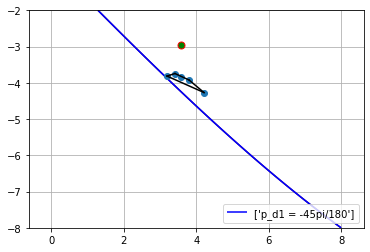

In [107]:
rng = np.random.default_rng()
#points = rng.random((30, 2))
points = np.array([[3.1886,-3.81288],[3.40957,-3.743],[3.5845,-3.8394],[3.7997,-3.9225],[4.21067,-4.26765]]) 
print(points)
print(points.shape)
hull = ConvexHull(points)

plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.xlim(2.0,5.0)
plt.ylim(-5,-2)

x_1 = [3.572468]
y_1 = [-2.9473]

#plt.figure(figsize=(3, 3))

plt.plot(x_1, y_1, marker="o", markersize=7, markeredgecolor="red", markerfacecolor="green")
plt.grid()


# plot barrier function generated 

X = np.linspace(0.0, 8.0, 1000)
Y = np.linspace(-8.0, -2.0, 1000)
x, y = np.meshgrid(X,Y)


F_1 = -1 + x**2*(-1.10238832288685e-9*x**2 + 1.80319119232896e-9*x*y + 0.000498307244914458*x - 6.17392461993128e-9*y**2 - 3.0159801407168e-6*y + 0.000433292775753663) + 0.000433292775753663*x**2 + x*y*(1.80319119232896e-9*x**2 - 7.2577972015878e-10*x*y - 3.01570061536256e-6*x + 1.00118014075502e-8*y**2 + 7.3533919568111e-8*y + 0.000172606000738259) + 0.000172606000738259*x*y - 1.19*x*(6.47527450719793e-7*x**2 - 1.60762998864989e-8*x*y + 4.46937948459349e-6*x + 1.96088514068458e-9*y**2 + 7.73836429281999e-7*y + 8.30053540767636e-6) + x*(0.000499077802580815*x**2 - 3.03483141222749e-6*x*y + 0.000871913954950304*x + 9.00874159221993e-8*y**2 + 0.000172618636467863*y - 0.391540745669237) - 0.391550623306372*x + y**2*(-6.17392461993128e-9*x**2 + 1.00118014075502e-8*x*y + 8.77539626047846e-8*x - 7.45820316187133e-8*y**2 - 4.96750298122347e-8*y + 0.000257094313106831) + 0.000257094313106831*y**2 + y*(-3.03504827418239e-6*x**2 + 8.98460714476343e-8*x*y + 0.000172618635886903*x - 5.42577660678735e-8*y**2 + 0.000514222273084763*y - 0.384391377986879) - 1.19*y*(-1.60236415677192e-8*x**2 + 1.37076906550616e-8*x*y + 7.73835941080837e-7*x - 3.85103887028468e-9*y**2 + 3.04140794970241e-9*y + 1.72210682985494e-6) - 0.384393427294007*y + 0.462072067182957
#F_1 = -1 + x**2*(5.99329549936565e-9*x**2 - 2.80150280951387e-9*x*y - 0.102597518842316*x + 1.10877067341611e-9*y**2 + 3.31525521929457e-5*y - 4.54108490656469) - 4.54108490656469*x**2 + x*y*(-2.80150280951387e-9*x**2 + 6.5620731359025e-9*x*y + 3.31525533682012e-5*x - 7.9591196086814e-9*y**2 + 1.41594006260317e-7*y - 10.127376423307) - 10.127376423307*x*y + x*(-0.102605973748804*x**2 + 3.30578260307417e-5*x*y - 9.08338123867475*x + 1.82162716820244e-7*y**2 - 10.1273762265013*y - 321.307396718324) - 1.19*x*(-7.1049634355908e-6*x**2 - 7.96028045877877e-8*x*y - 0.00101816287270545*x + 3.35710059437192e-8*y**2 - 0.0013558537902929*y - 0.155083712958664) - 321.122847099903*x + y**2*(1.10877067341611e-9*x**2 - 7.9591196086814e-9*x*y + 1.42213219747218e-7*x + 1.39465085175012e-7*y**2 + 5.39450925375361e-7*y - 7.7697511873739) - 7.7697511873739*y**2 - 1.19*y*(-7.96030422184477e-8*x**2 + 3.40901522530386e-8*x*y - 0.00135585372977211*x - 5.33185745602558e-7*y**2 - 8.13700026052122e-9*y - 0.088645108416182) + y*(3.30578245727057e-5*x**2 + 1.82161287441433e-7*x*y - 10.1273762264292*x - 9.50401118916825e-8*y**2 - 15.5395020607229*y - 209.868856134677) - 209.763368455662*y + 1142.58860932836




#F_2 = -1 + x**2*(2.18634404098349e-9*x**2 - 1.26162878094674e-9*x*y - 0.0369973621120415*x - 1.33121765655488e-9*y**2 + 2.72118104718833e-5*y - 1.25852046055673) - 1.25852046055673*x**2 + x*y*(-1.26162878094674e-9*x**2 + 2.05246593260028e-10*x*y + 2.72118676745513e-5*x - 9.376474067382e-9*y**2 - 1.53437251953064e-6*y - 4.12462535091141) - 4.12462535091141*x*y + x*(-0.0370046683969166*x**2 + 2.76048295534581e-5*x*y - 2.51672654475199*x - 9.82809983231624e-7*y**2 - 4.12462534097349*y - 80.233802673059) - 1.19*x*(-6.13973518916252e-6*x**2 + 3.30220066308206e-7*x*y + 0.000264138244224335*x + 4.64515677724106e-7*y**2 - 0.00012015834006881*y - 0.055439165146581) - 80.1678300665346*x + y**2*(-1.33121765655488e-9*x**2 - 9.376474067382e-9*x*y - 1.53558363972331e-6*x - 3.67397919210121e-8*y**2 - 2.01335037004115e-6*y - 7.75988860755694) - 7.75988860755694*y**2 - 1.19*y*(3.30268443295757e-7*x**2 + 4.63510279457343e-7*x*y - 0.000120158331500948*x + 9.05837298892501e-7*y**2 + 5.33080070225501e-8*y - 0.118493533825725) + y*(2.76048299194053e-5*x**2 - 9.82795286976401e-7*x*y - 4.1246253409633*x - 9.3540398435907e-7*y**2 - 15.5197768304059*y - 120.158908195182) - 120.01790088993*y + 28.8775319927433
#F_3 = -1 + x**2*(-6.81866871166217e-8*x**2 + 2.18379284437199e-8*x*y - 0.0371549566096042*x - 2.42637470364481e-8*y**2 - 2.12813957648876e-5*y + 0.454469611841702) + 0.454469611841702*x**2 + x*y*(2.18379284437199e-8*x**2 - 4.68386178223784e-8*x*y - 2.1281404096161e-5*x + 3.40603716551867e-8*y**2 - 2.04641262759041e-6*y - 1.89365691004957) - 1.89365691004957*x*y + x*(-0.0371496278552568*x**2 - 2.03625910121935e-5*x*y + 0.90831216197402*x - 2.13391095070064e-6*y**2 - 1.89365713832108*y - 74.3886344217523) - 1.19*x*(4.47794482975981e-6*x**2 + 7.72111835266835e-7*x*y - 0.000526926890712207*x - 7.3647096669053e-8*y**2 - 0.000919961536134116*y + 0.0396506894085281) - 74.4358187421485*x + y**2*(-2.42637470364481e-8*x**2 + 3.40603716551867e-8*x*y - 2.04627090566447e-6*x - 2.56276520494252e-7*y**2 - 1.87009417030786e-6*y - 2.82874564348504) - 2.82874564348504*y**2 + y*(-2.03625906465494e-5*x**2 - 2.13388787958041e-6*x*y - 1.8936571383359*x + 4.6518844889327e-8*y**2 - 5.65749202423911*y - 91.3599094062475) - 1.19*y*(7.72105141460641e-7*x**2 - 7.35086151176462e-8*x*y - 0.000919961548590505*x + 1.61059917243461e-6*y**2 - 7.18669001061967e-7*y - 0.0604091565318551) - 91.2880225099746*y - 7.52557118533153
#F_4 = -1 + x**2*(-2.8398994557701e-8*x**2 + 8.11305882380327e-9*x*y - 0.00642161325702398*x - 9.60761351123606e-9*y**2 + 1.7991829406836e-6*y - 0.049308584984274) - 0.049308584984274*x**2 + x*y*(8.11305882380327e-9*x**2 - 1.67452281568578e-8*x*y + 1.79918497464145e-6*x + 1.44898002858807e-8*y**2 - 5.88468547287205e-7*y + 1.39340402804931) + 1.39340402804931*x*y + x*(-0.00642222974042424*x**2 + 2.13275298092524e-6*x*y - 0.0988496358953179*x - 7.68897951643728e-7*y**2 + 1.39340404782523*y - 26.6612869830705) - 1.19*x*(-5.18053277527043e-7*x**2 + 2.80309248977973e-7*x*y - 0.000195351219562736*x - 1.52551719240863e-7*y**2 - 0.000372647486581203*y + 0.0291441727299226) - 26.6959685486191*x + y**2*(-9.60761351123606e-9*x**2 + 1.44898002858807e-8*x*y - 5.87361405747101e-7*x - 8.95574344248144e-8*y**2 - 3.92869748603141e-7*y - 0.555281002187437) - 0.555281002187437*y**2 - 1.19*y*(2.80309896474724e-7*x**2 - 1.51606725205427e-7*x*y - 0.000372647486775871*x + 5.0126408817928e-7*y**2 - 1.04672348992541e-7*y - 0.021539439910485) + y*(2.13275171748852e-6*x**2 - 7.68880550281663e-7*x*y + 1.393404047825*x + 2.03634516330202e-7*y**2 - 1.11056210502982*y - 47.6043570109872) - 47.5787250774937*y - 8.62476300767536
#F_5 = -1 + x**2*(-1.84536777983869e-9*x**2 - 2.61113387845714e-9*x*y - 0.0427536413764992*x - 2.23703172807076e-9*y**2 + 4.4614282036296e-5*y + 2.29952381926249) + 2.29952381926249*x**2 + x*y*(-2.61113387845714e-9*x**2 - 2.72235102832299e-9*x*y + 4.46143941401326e-5*x - 4.51336754285914e-9*y**2 - 9.02953366512302e-7*y - 0.106212552270655) - 0.106212552270655*x*y + x*(-0.0427655266015825*x**2 + 4.50317958211314e-5*x*y + 4.5987184133237*x - 1.06831041179082e-6*y**2 - 0.106212610717267*y - 60.3637344675026) - 1.19*x*(-9.987584103594e-6*x**2 + 3.50757715125018e-7*x*y - 0.000276579975514501*x - 1.39706120381233e-7*y**2 - 0.000142469400540771*y + 0.00518669211329728) - 60.3699066311175*x + y**2*(-2.23703172807076e-9*x**2 - 4.51336754285914e-9*x*y - 9.02060128537153e-7*x + 1.04733367215724e-8*y**2 + 1.73101346186203e-8*y - 0.431857406803344) - 0.431857406803344*y**2 - 1.19*y*(3.50850255995048e-7*x**2 - 1.3892674344578e-7*x*y - 0.000142469400902833*x + 2.12708510958567e-7*y**2 + 7.21725197841537e-8*y - 0.0151556425586101) + y*(4.50317938409301e-5*x**2 - 1.06827619121278e-6*x*y - 0.106212610717698*x + 2.70433262659315e-7*y**2 - 0.863714709143718*y - 57.6281557817098) - 57.6101205670651*y - 11.1993112214814

#F = np.array([F_1,F_2,F_3,F_4,F_5])
#print(F_1.shape)

plt.contour(x,y,F_1,[0])
CS1 = plt.contour(x,y,F_1,[0],colors = ['blue'])
label1 = ['p_d1 = -45pi/180']
CS1.collections[0].set_label(label1)

#plt.contour(x,y,F_2,[0])
#CS2 = plt.contour(x,y,F_2,[0],colors = ['red'])
#label2 = ['p_d2 = -20pi/180']
#CS2.collections[0].set_label(label2)

#plt.contour(x,y,F_3,[0])
#CS3 = plt.contour(x,y,F_3,[0],colors = ['black'])
#label3 = ['p_d3 = 0']
#CS3.collections[0].set_label(label3)

#plt.contour(x,y,F_4,[0])
#CS4 = plt.contour(x,y,F_4,[0],colors = ['green'])
#label4 = ['p_d4 = 20pi/180']
#CS4.collections[0].set_label(label4)

#plt.contour(x,y,F_5,[0])
#CS5 = plt.contour(x,y,F_5,[0],colors = ['purple'])
#label5 = ['p_d5 = 45pi/180']
#CS5.collections[0].set_label(label5)

#CS = plt.contour(x,y,F,[0])
#labels = ['p_d1 = -45pi/180','p_d2 = -20pi/180','p_d3 = 0','p_d4 = 20pi/180','p_d5 = 45pi/180']
#for i in range(len(labels)):
#    CS.collections[i].set_label(labels[i])
    

plt.axis('equal')
plt.legend(loc='lower right')
plt.show()

In [113]:
x = x_0
y = y_0

x = 2
y = -4
#check_F = x**2*(-9.5442909304106e-10*x**2 + 1.78785628470836e-9*x*y + 0.000449769470412333*x - 7.21490472200939e-9*y**2 - 2.6703371543958e-6*y + 0.00042124619186584) + 0.00042124619186584*x**2 + x*y*(1.78785628470836e-9*x**2 + 1.70017495631583e-9*x*y - 2.67000879322323e-6*x + 9.38751051764524e-9*y**2 + 5.94555416397515e-8*y + 0.000195434805849781) + 0.000195434805849781*x*y - 1.19*x*(5.75702521005748e-7*x**2 - 1.43247143907713e-8*x*y + 4.01417959480369e-6*x - 6.07095757917582e-11*y**2 + 7.47260581217695e-7*y + 9.43898273386329e-6) + x*(0.00045045455641233*x**2 - 2.68705520334825e-6*x*y + 0.000847279576027963*x + 7.64374230790266e-8*y**2 + 0.000195451930643634*y - 0.413500428398586) - 0.413511660788039*x + y**2*(-7.21490472200939e-9*x**2 + 9.38751051764524e-9*x*y + 7.65096674742188e-8*x - 6.69258100087297e-8*y**2 - 4.14473856072999e-8*y + 0.0002697951022368) + 0.0002697951022368*y**2 + y*(-2.68732472599955e-6*x**2 + 7.64021210029963e-8*x*y + 0.000195451924738458*x - 4.61403290539743e-8*y**2 + 0.000539635562927383*y - 0.406081975505943) - 1.19*y*(-1.42752702552491e-8*x**2 + 1.42408229943234e-8*x*y + 7.47255618884539e-7*x - 3.94364995518853e-9*y**2 + 1.19769939941323e-8*y + 2.67496118630566e-6) - 0.406085158709754*y + 0.496733627055227
value = x**2*(-1.10238832288685e-9*x**2 + 1.80319119232896e-9*x*y + 0.000498307244914458*x - 6.17392461993128e-9*y**2 - 3.0159801407168e-6*y + 0.000433292775753663) + 0.000433292775753663*x**2 + x*y*(1.80319119232896e-9*x**2 - 7.2577972015878e-10*x*y - 3.01570061536256e-6*x + 1.00118014075502e-8*y**2 + 7.3533919568111e-8*y + 0.000172606000738259) + 0.000172606000738259*x*y - 1.19*x*(6.47527450719793e-7*x**2 - 1.60762998864989e-8*x*y + 4.46937948459349e-6*x + 1.96088514068458e-9*y**2 + 7.73836429281999e-7*y + 8.30053540767636e-6) + x*(0.000499077802580815*x**2 - 3.03483141222749e-6*x*y + 0.000871913954950304*x + 9.00874159221993e-8*y**2 + 0.000172618636467863*y - 0.391540745669237) - 0.391550623306372*x + y**2*(-6.17392461993128e-9*x**2 + 1.00118014075502e-8*x*y + 8.77539626047846e-8*x - 7.45820316187133e-8*y**2 - 4.96750298122347e-8*y + 0.000257094313106831) + 0.000257094313106831*y**2 + y*(-3.03504827418239e-6*x**2 + 8.98460714476343e-8*x*y + 0.000172618635886903*x - 5.42577660678735e-8*y**2 + 0.000514222273084763*y - 0.384391377986879) - 1.19*y*(-1.60236415677192e-8*x**2 + 1.37076906550616e-8*x*y + 7.73835941080837e-7*x - 3.85103887028468e-9*y**2 + 3.04140794970241e-9*y + 1.72210682985494e-6) - 0.384393427294007*y + 0.462072067182957
print(value)



1.997055356974833
